In [ ]:
!pip install arrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os
import random
import arrow
import matplotlib.pyplot as plt
import argparse
import seaborn as sns

In [ ]:
def generate_event_mark(data, value=0):
    mask = data > 0
    data = np.stack((data, np.ones_like(data) * value * mask), axis=-1)
    print(data.shape)

    return data

def Exponential_Hawkes(ts, seqs, mu, alpha, beta):
    lams = []

    for t in ts:
        mask = (seqs > 0) * (seqs < t)                                          # [ batch_size, seq_len ]
        lams.append(mu + alpha * (np.exp(-beta * np.clip(t - seqs, a_min=-1., a_max=None)) * mask).sum(1))

    lams = np.stack(lams, axis=1)

    return np.array(lams)          # [ batch_size, len_grid ]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def push_all_zeros_back(a):
    a_flipped = torch.zeros_like(a)
    valid_mask = a[:, :, 0] > 0
    flipped_mask = valid_mask.sum(1,keepdims=True) > torch.arange(a.shape[1]-1,-1,-1, device = a.device)
    flipped_mask = torch.flip(flipped_mask, dims=(1, ))
    a_flipped[flipped_mask] = a[valid_mask]
    return a_flipped

def config_generate(T0,
                    T1,
                    tau_max,
                    train_buffer=True,
                    int_res='100',
                    nsample='50',
                    n_class='2',
                    hid_dim='1',
                    event_dim='1',
                    lr='0.01',
                    epoch='10',
                    batch_size='64',
                    opt="Adam",
                    momentum='0.0',
                    train_type="event"):
    parser = argparse.ArgumentParser()
    parser.add_argument("-T0", type=float)
    parser.add_argument("-T1", type=float)
    parser.add_argument("-tau_max", type=float)
    parser.add_argument("-int_res", type=int)
    parser.add_argument("-nsample", type=int)
    parser.add_argument("-n_class",
                        help="Number of types in the dataset, default is 2", type=int, default=2)
    parser.add_argument("-hid_dim", type=int, default=1)
    parser.add_argument("-event_dim", type=int, default=1)
    parser.add_argument("-n_layers", type=int, default=1)
    parser.add_argument("-lr", type=float, default=0.01)
    parser.add_argument("-momentum", type=float, default=0.0)
    parser.add_argument("-epoch", type=int, default=30)
    parser.add_argument("-batch_size", type=int, default=64)
    parser.add_argument("-opt", type=str, default='Adam')
    parser.add_argument("-train_type", type=str, default='event')
    parser.add_argument("-train_buffer", action='store_true')
    parser.add_argument("-no-train_buffer", dest='train_buffer', action='store_false')
    parser.set_defaults(train_buffer=True)

    arg_list = ['-T0', T0,
                '-T1', T1,
                '-tau_max', tau_max,
                '-int_res', int_res,
                '-nsample', nsample,
                '-n_class', n_class,
                '-hid_dim', hid_dim,
                '-event_dim', event_dim,
                '-lr', lr,
                '-epoch', epoch,
                '-batch_size', batch_size,
                '-opt', opt,
                '-momentum', momentum,
                '-train_type', train_type
                ]

    if not train_buffer:
        print("Do not train_buffer!")
        arg_list.append("-no-train_buffer")

    config = parser.parse_args(arg_list)

    return config

def model_train(train_data,
                test_data,
                buffer_train_data,
                buffer_test_data,
                model,
                config,
                device,
                mae_eval=False,
                ts=None,
                true_lams=None):
    """Training process"""
    train_llks = []
    test_llks = []
    test_maes = []
    test_mres = []
    wall_time = []
    n_events_train = (train_data[:, :, 0] > 0).sum()
    n_events_test = (test_data[:, :, 0] > 0).sum()
    n_events_buffer_train = (buffer_train_data[:, :, 0] > 0).sum()
    n_events_buffer_test = (buffer_test_data[:, :, 0] > 0).sum()
    n_batches = int(train_data.shape[0] / config.batch_size) # number of batches
    print("[%s] #Training sequences: %d" % (arrow.now(), train_data.shape[0]))
    print("[%s] #Testing sequences: %d" % (arrow.now(), test_data.shape[0]))
    print("[%s] #Training events: %d" % (arrow.now(), n_events_train))
    print("[%s] #Testing events: %d" % (arrow.now(), n_events_test))
    batch_idx = np.arange(train_data.shape[0])
    random.shuffle(batch_idx)
    train_data = train_data[batch_idx]
    buffer_train_data = buffer_train_data[batch_idx]

    train_data = torch.tensor(train_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    buffer_train_data = torch.tensor(buffer_train_data, dtype=torch.float32)
    buffer_test_data = torch.tensor(buffer_test_data, dtype=torch.float32)

    # initialize storage for lld by batch
    train_lld_batches = np.zeros((n_batches, config.epoch))

    model.to(device)

    epc = 0
    t0 = arrow.now()
    while epc < config.epoch:
        try:
            train_loss = 0
            for b in range(n_batches):
                idx  = np.arange(config.batch_size * b, config.batch_size * (b + 1))
                loss, train_lld_batches[b, epc] = model.train(train_data[idx], buffer_train_data[idx], device)
                if isinstance(loss, tuple):
                    loss = loss[0]
                train_loss += loss
                # model.apply(clipper1)

            if np.isnan(train_loss):
                print("Epochs %d: NaN loss! Re-initialize model!" % epc)
                b = model.baserate_mu.item()
                model = NH(config, device)

                for name, parameter in model.named_parameters():
                    if name == "baserate_mu":
                        parameter.data.fill_(b)
                    else:
                        parameter.data.fill_(random.gauss(0, 0.01))

                model.to(device)
                epc = 0

                train_llks = []
                test_llks = []
                test_maes = []
                test_mres = []
                wall_time = []
                t0 = arrow.now()
                continue


            train_data_loss = model.test(train_data, buffer_train_data, device)
            test_data_loss = model.test(test_data, buffer_test_data, device)
            if isinstance(train_data_loss, tuple):
                train_data_loss = train_data_loss[0]
            if isinstance(test_data_loss, tuple):
                test_data_loss = test_data_loss[0]

            train_llks.append(-train_data_loss/(n_events_train+n_events_buffer_train))
            test_llks.append(-test_data_loss/n_events_test)

            if mae_eval:
                lams = model.sample_intensity(ts, test_data, buffer_test_data, device=device)
                mae = np.mean(np.abs(lams - true_lams))
                mre = np.mean(np.abs(lams - true_lams) / true_lams)
                test_maes.append(mae)
                test_mres.append(mre)


            if (epc+1) % 1 == 0:
                print("[%s] Epochs %d, total loss: %.5e" % (
                    arrow.now(), epc, train_loss
                ))
                print("[%s] Training llk: %.5e" % (arrow.now(), train_llks[-1]))
                print("[%s] Testing llk: %.5e" % (arrow.now(), test_llks[-1]))
                if mae_eval:
                    print("[%s] MAE:%.5f, MRE:%.5f" % (arrow.now(), mae, mre))
                print("saving model")

                if device == "cpu":
                    torch.save(model, "model.pt")
                else:
                    model.to("cpu")
                    torch.save(model, "model.pt")
                    model.to(device)

            # define convergence standard
            if epc > 20:
              temp = np.zeros(5)
              for tmp_idx in range(5):
                temp[tmp_idx] = abs(train_llks[-tmp_idx-1] - train_llks[-tmp_idx-2])
              if np.max(temp) < 1e-3:
                print("Convergence reached")
                break

            epc += 1

            t_e = arrow.now()
            wall_time.append((t_e - t0).total_seconds())

        except KeyboardInterrupt:
                break
    np.save('lld-iter.npy',train_llks)
    np.save('lld-per-batch.npy', train_lld_batches)
    print("training done!")

    return model.to("cpu"), train_llks, test_llks, test_maes, test_mres, wall_time, train_lld_batches

In [ ]:
class NH(nn.Module):
    """
    Pytorch Implementation of Neural Hawkes (Mei, et.al 2017)
    """
    def __init__(self, config, device):
        super(NH, self).__init__()

        self.T0 = config.T0
        self.T1 = config.T1
        self.hid_dim = config.hid_dim
        self.n_class = config.n_class
        self.config = config

        # Parameters
        # recurrent cells
        self.rec = nn.Linear(2*self.hid_dim, 7*self.hid_dim)
        # output mapping from hidden vectors to unnormalized intensity
        self.wa = nn.Linear(self.hid_dim, self.n_class)
        # embedding layer for valid events, including BOS
        self.emb = nn.Embedding(self.n_class+1, self.hid_dim)

        # Other parameters
        self.baserate_mu = nn.Parameter(torch.tensor([0.1]*self.n_class), requires_grad=False)

        # optimizer
        self.optimizer = self.set_optimizer(config.opt, config.lr, config.momentum)

    def set_optimizer(self, opt, lr, momentum):
        if opt == 'SGD':
            return torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        elif opt == 'Adam':
            return torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == 'Adadelta':
            return torch.optim.Adadelta(self.parameters(), lr=lr)
        else:
            ValueError("No such optimizer!")

    def init_states(self, batch_size, device):
        """
        Initialize hidden state and cell state.
        """
        # h_d = torch.zeros(batch_size, self.hid_dim, dtype=torch.float)
        # c_d = torch.zeros(batch_size, self.hid_dim, dtype=torch.float)
        # c_bar = torch.zeros(batch_size, self.hid_dim, dtype=torch.float)
        # c = torch.zeros(batch_size, self.hid_dim, dtype=torch.float)
        # o = torch.zeros(batch_size, self.hid_dim, dtype=torch.float)
        # delta = torch.zeros(batch_size, self.hid_dim, dtype=torch.float)

        A = torch.zeros(batch_size, 4*self.hid_dim, dtype=torch.float32, device=device)

        return torch.chunk(A, 4, dim=-1)

    def state_update(self, emb_event_t, h_d_tm1, c_tm1, c_bar_tm1):
        """
        State update in CTLSTM when a new event happens.
        """
        feed = torch.cat((emb_event_t, h_d_tm1), dim=1)                         # [ batch_size, 2 * self.hid_dim ]
        (gate_i,
        gate_f,
        gate_z,
        gate_o,
        gate_i_bar,
        gate_f_bar,
        gate_delta) = torch.chunk(torch.sigmoid(self.rec(feed)), 7, -1)         # [ batch_size, self.hid_dim ]

        gate_z = 2 * gate_z - 1
        gate_delta = nn.functional.softplus(torch.log(gate_delta / (1 - gate_delta)))

        c_t = gate_f * c_tm1 + gate_i * gate_z
        c_bar_t = gate_f_bar * c_bar_tm1 + gate_i_bar * gate_z

        # h_t = gate_o * torch.tanh(c_t)

        return c_t, c_bar_t, gate_o, gate_delta

    def decay(self, c_t, c_bar_t, o_t, delta_t, duration_t):
        """
        Compute cell and hidden states after decaying over duration_t.
        """
        c_d_t = c_bar_t + (c_t - c_bar_t) * \
            torch.exp(-delta_t * duration_t.unsqueeze(-1))

        h_d_t = o_t * torch.tanh(c_d_t)

        return c_d_t, h_d_t

    def scan(self, X, device):
        """
        Compute states at all event times for conditional intensity function calculation.

        - X: input sequence including BOS.          [ batch_size, seq_len, data_dim = 2 ]
        """

        batch_size, seq_len, _ = X.shape
        X = X.to(device)
        # h_list, c_list, c_bar_list, o_list, delta_list = [], [], [], [], []
        output_state_list = []                                                  # c_list, c_bar_list, o_list, delta_list, containing
                                                                                # the information of i-th event
        h_list = []                                                             # the hidden state to compute intensity at i-th event time
        time = X[:, :, 0]
        event = X[:, :, 1].long()
        time_duration = torch.diff(time, dim=-1, prepend=time[:, [0]])
        time_duration[time_duration < 0] = 0

        c_t, c_bar_t, o_t, delta_t = self.init_states(batch_size, device)

        for i in range(seq_len):
            c_d, h_d = self.decay(c_t, c_bar_t, o_t, delta_t, time_duration[:, i])
            h_list.append(h_d)
            c_t, c_bar_t, o_t, delta_t = self.state_update(self.emb(event[:, i]), h_d, c_d, c_bar_t)
            output_state_list.append(torch.stack([c_t, c_bar_t, o_t, delta_t]))

        h_seq = torch.stack(h_list, dim=1)                                      # [ batch_size, seq_len, self.hid_dim ]
        output_seq = torch.stack(output_state_list, dim=-2)                     # [ 4, batch_size, seq_len, self.hid_dim ]

        return h_seq, output_seq

    def train(self, X, buffer, device):
        """
        Calculate log likelihood for batch X.

        - X: input sequence.                                                    [ batch_size, seq_len, 2 ]
        - buffer: buffering sequences to reduce model mismatch, events earlier
                  than first event in each training sequence, including BOS     [ batch_size, seq_len_buff, 2 ]
        - device: cpu or cuda.
        """

        assert X.shape[0] == buffer.shape[0], "invalid buffer!"

        X = X.to(device)
        buffer = buffer.to(device)

        whole_seq = torch.concat([buffer, X], dim=1)
        whole_seq = push_all_zeros_back(whole_seq)                              # [ batch_size, seq_len+seq_len_buff, 2 ]
        whole_seq = whole_seq[:, whole_seq[:, :, 0].sum(0) != 0, :]

        batch_size, seq_len, _ = whole_seq.shape

        time = whole_seq[:, :, 0]
        event = whole_seq[:, :, 1].long()
        mask = time > 0
        mask_b = buffer[:, :, 0] > 0
        idx_mat = torch.arange(whole_seq.shape[1], device=device).unsqueeze(0).repeat(whole_seq.shape[0], 1)
                                                                                # [ batch_size, seq_len+seq_len_buff ]
        m = (idx_mat >= mask_b.sum(1, keepdim=True)) * (idx_mat < mask.sum(1, keepdim=True))
                                                                                # [ batch_size, seq_len+seq_len_buff ]

        h, output = self.scan(whole_seq, device=device)
        c, c_bar, o, delta = torch.chunk(output, 4, 0)
        # [ batch_size, seq_len+seq_len_buff, self.hid_dim ]
        c = torch.squeeze(c, 0)
        c_bar = torch.squeeze(c_bar, 0)
        o = torch.squeeze(o, 0)
        delta = torch.squeeze(delta, 0)

        # Calculate the sum of log intensities of each event in the sequence
        lambda_k = nn.functional.softplus(self.wa(h)) + self.baserate_mu        # [ batch_size, seq_len+seq_len_buff, self.n_class ]

        if self.config.train_buffer:
            event_log = lambda_k[mask]
            event_log = torch.sum(torch.log(event_log[torch.arange(event_log.shape[0]), 0]))
        else:
            event_log = lambda_k[m]
            print(event[m])
            raise RuntimeError
            event_log = torch.sum(torch.log(event_log[torch.arange(event_log.shape[0]), event[m]]))


        # Calculate simulated loss from MCMC method
        if self.config.train_buffer:
            startT = time[0, 0]
            endT = self.T1
        else:
            startT = self.T0
            endT = self.T1
        ts_int = torch.linspace(startT, endT, self.config.int_res+1, device=device)
        unit_len = (endT - startT) / self.config.int_res
        ts_int = (ts_int + unit_len / 2)[:-1]                                   # [ self.config.int_res ]

        time_expand = time.unsqueeze(-1).repeat(1, 1, self.config.int_res)
        prev_t_idx = ((time_expand < ts_int) * (time_expand > 0)).sum(-2).long() - 1
                                                                                # [ batch_size, int_res ]
        batch_idx = torch.arange(batch_size).unsqueeze(-1).repeat(1, self.config.int_res)
        prev_t = time[batch_idx, prev_t_idx]                                    # [ batch_size, int_res ]
        time_lapse = ts_int - prev_t                                            # [ batch_size, int_res ]

        _, h_d_seq = self.decay(c[batch_idx, prev_t_idx],
                                c_bar[batch_idx, prev_t_idx],
                                o[batch_idx, prev_t_idx],
                                delta[batch_idx, prev_t_idx],
                                time_lapse)                                     # [ batch_size, int_res, self.hid_dim ]

        sim_lambda_k = (nn.functional.softplus(self.wa(h_d_seq)) + self.baserate_mu).transpose(1, 2)

        ###
        # obtain the training lld for each batch
        lld_batch = self.test(X, buffer, device)/(mask.sum()+mask_b.sum())
        ###
                                                                                # [ batch_size, self.n_class, int_res ]
        int_lam = sim_lambda_k.sum() * unit_len

        # Calculate total log-likelihood
        loglikelihood = event_log - int_lam

        loss = -loglikelihood

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item(), lld_batch

    def test(self, X, buffer, device):
        """
        Calculate log likelihood for batch X.

        - X: input sequence.                                                    [ batch_size, seq_len, 2 ]
        - buffer: buffering sequences to reduce model mismatch, events earlier
                  than first event in each training sequence, including BOS     [ batch_size, seq_len_buff, 2 ]
        - device: cpu or cuda.
        """

        assert X.shape[0] == buffer.shape[0], "invalid buffer!"

        X = X.to(device)
        buffer = buffer.to(device)

        whole_seq = torch.concat([buffer, X], dim=1)
        whole_seq = push_all_zeros_back(whole_seq)                              # [ batch_size, seq_len+seq_len_buff, 2 ]
        whole_seq = whole_seq[:, whole_seq[:, :, 0].sum(0) != 0, :]
        batch_size, seq_len, _ = whole_seq.shape

        time = whole_seq[:, :, 0]
        event = whole_seq[:, :, 1].long()
        mask = time > 0
        mask_b = buffer[:, :, 0] > 0
        idx_mat = torch.arange(whole_seq.shape[1], device=device).unsqueeze(0).repeat(whole_seq.shape[0], 1)
                                                                                # [ batch_size, seq_len+seq_len_buff ]
        m = (idx_mat >= mask_b.sum(1, keepdim=True)) * (idx_mat < mask.sum(1, keepdim=True))
                                                                                # [ batch_size, seq_len+seq_len_buff ]

        with torch.no_grad():
#             print("inside no grad")
            h, output = self.scan(whole_seq, device=device)
            c, c_bar, o, delta = torch.chunk(output, 4, 0)
            # [ batch_size, seq_len+seq_len_buff, self.hid_dim ]
            c = torch.squeeze(c, 0)
            c_bar = torch.squeeze(c_bar, 0)
            o = torch.squeeze(o, 0)
            delta = torch.squeeze(delta, 0)


            # Calculate the sum of log intensities of each event in the sequence
            lambda_k = nn.functional.softplus(self.wa(h)) + self.baserate_mu        # [ batch_size, seq_len+seq_len_buff, self.n_class ]
            event_log = lambda_k[m]
            event_log = torch.sum(torch.log(event_log[torch.arange(event_log.shape[0]), event[m]]))

            # Calculate simulated loss from MCMC method
            ts_int = torch.linspace(self.T0, self.T1, self.config.int_res+1, device=device)
            unit_len = (self.T1 - self.T0) / self.config.int_res
            ts_int = (ts_int + unit_len / 2)[:-1]                                   # [ self.config.int_res ]

            time_expand = time.unsqueeze(-1).repeat(1, 1, self.config.int_res)
            prev_t_idx = ((time_expand < ts_int) * (time_expand > 0)).sum(-2).long() - 1
                                                                                    # [ batch_size, int_res ]
            batch_idx = torch.arange(batch_size).unsqueeze(-1).repeat(1, self.config.int_res)
            prev_t = time[batch_idx, prev_t_idx]                                    # [ batch_size, int_res ]
            time_lapse = ts_int - prev_t                                            # [ batch_size, int_res ]

            _, h_d_seq = self.decay(c[batch_idx, prev_t_idx],
                                    c_bar[batch_idx, prev_t_idx],
                                    o[batch_idx, prev_t_idx],
                                    delta[batch_idx, prev_t_idx],
                                    time_lapse)                                     # [ batch_size, int_res, self.hid_dim ]

            sim_lambda_k = (nn.functional.softplus(self.wa(h_d_seq)) + self.baserate_mu).transpose(1, 2)
                                                                                    # [ batch_size, self.n_class, int_res ]
            int_lam = sim_lambda_k.sum() * unit_len

            # Calculate total log-likelihood
            loglikelihood = event_log - int_lam

        return -loglikelihood.item()

    def sample_intensity(self, ts, X, buffer, device):
        """
        Calculate intensity on discretized grids ts.

        - ts: discretized grids, 1d list-like object, should be in time range self.T
        - X: testing sequences.           [ batch_size, seq_len, 2 ]
        """

        assert X.shape[0] == buffer.shape[0], "invalid buffer!"

        X = X.to(device)
        buffer = buffer.to(device)

        whole_seq = torch.concat([buffer, X], dim=1)
        whole_seq = push_all_zeros_back(whole_seq)                              # [ batch_size, seq_len+seq_len_buff, 2 ]
        whole_seq = whole_seq[:, whole_seq[:, :, 0].sum(0) != 0, :]
        batch_size, seq_len, _ = whole_seq.shape

        ts = torch.tensor(ts, dtype=torch.float32).to(device)
        time = whole_seq[:, :, 0]
        event = whole_seq[:, :, 1].long()

        with torch.no_grad():
            h, output = self.scan(whole_seq, device=device)
            c, c_bar, o, delta = torch.chunk(output, 4, 0)
            # [ batch_size, seq_len, self.hid_dim ]
            c = torch.squeeze(c, 0)
            c_bar = torch.squeeze(c_bar, 0)
            o = torch.squeeze(o, 0)
            delta = torch.squeeze(delta, 0)

            # ------------------------------------------ #
            # print('reached beginning of plotting')
            h_draw = h.cpu().detach().numpy()
            # print(h_draw.shape)
            h_temp = h_draw.flatten()
            # h_temp = h_draw
            # print(h_temp.shape)
            # xdata = h_temp[:,:,0].flatten()
            # ydata = h_temp[:,:,1].flatten()

#             fig = plt.figure()
#             plt.scatter(xdata, ydata, s = 10)
#             plt.show()
            # # Create a heatmap using Seaborn
            # sns.histplot(x=xdata, y=ydata, bins=200, cmap='viridis')
            # # Show the plot
            # plt.show()

            plt.hist(h_temp, bins=200, color='blue', alpha=0.7)
            plt.show()
            # print('reached end of plotting')
            # ------------------------------------------ #

            grid_len = len(ts)
            time_expand = time.unsqueeze(-1).repeat(1, 1, grid_len)

            prev_t_idx = ((time_expand < ts) * (time_expand > 0)).sum(-2).long() - 1
                                                                                    # [ batch_size, grid_len ]
            batch_idx = torch.arange(batch_size).unsqueeze(-1).repeat(1, grid_len)
            prev_t = time[batch_idx, prev_t_idx]                                    # [ batch_size, grid_len ]
            time_lapse = ts - prev_t                                                # [ batch_size, grid_len ]

            _, h_d_seq = self.decay(c[batch_idx, prev_t_idx],
                                    c_bar[batch_idx, prev_t_idx],
                                    o[batch_idx, prev_t_idx],
                                    delta[batch_idx, prev_t_idx],
                                    time_lapse)                                     # [ batch_size, grid_len, self.hid_dim ]

            lambda_k = nn.functional.softplus(self.wa(h_d_seq)) + self.baserate_mu  # [ batch_size, grid_len, self.n_class ]

        return lambda_k.sum(-1).cpu().numpy()

In [ ]:
true_mu = 0.1
true_alpha = 1.0
# now we don't have a true beta anymore but we use the beta in the testing set
true_beta = 0.5

raw_train_data_1 = np.load('sample_data/cluster1_train.npy')
raw_test_data_1 = np.load('sample_data/cluster1_test.npy')
raw_train_data_2 = np.load('sample_data/cluster2_train.npy')
raw_test_data_2 = np.load('sample_data/cluster2_test.npy')
raw_train_data_3 = np.load('sample_data/cluster3_train.npy')
raw_test_data_3 = np.load('sample_data/cluster3_test.npy')

# print(raw_train_data_1.shape)
# print(raw_train_data_2.shape)
# print(raw_train_data_3.shape)

# print(raw_test_data_1.shape)
# print(raw_test_data_2.shape)
# print(raw_test_data_3.shape)

# combine the training set
n_1, seq_1 = raw_train_data_1.shape
n_2, seq_2 = raw_train_data_2.shape
n_3, seq_3 = raw_train_data_3.shape

n = n_1 + n_2 + n_3
seq = max(seq_1, seq_2, seq_3)

raw_train_data = np.zeros((n, seq))
raw_train_data[:n_1,:seq_1] = raw_train_data_1
raw_train_data[n_1:(n_1+n_2), :seq_2] = raw_train_data_2
raw_train_data[(n_1+n_2):, :seq_3] = raw_train_data_3

# test on only testing set 1 first

raw_test_data = raw_test_data_1

print(raw_train_data.shape)
print(raw_test_data.shape)
print(raw_train_data.min(), raw_train_data.max())

train_cluster_data = np.array([1] * n_1 + [2] * n_2 + [3] * n_3)
print(train_cluster_data.shape)

test_cluster_data = np.array([1] * raw_test_data.shape[0])
print(test_cluster_data.shape)



(1200, 840)
(100, 1084)
0.0 99.9993389725967
(1200,)
(100,)


In [ ]:

buffer_start_time = 10
buffer_end_time = 30
end_time = raw_test_data.max()

buffer_train_time = [buffer_start_time, buffer_end_time]
buffer_test_time = [buffer_start_time, buffer_end_time]
test_time = [buffer_end_time, end_time]

btrain_lens = ((raw_train_data <= buffer_train_time[1]) * (raw_train_data > buffer_train_time[0])).sum(1)
btest_lens = ((raw_test_data <= buffer_test_time[1]) * (raw_test_data > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum(1)

buffer_train_data = np.zeros((raw_train_data.shape[0], btrain_lens.max()))
buffer_test_data = np.zeros((raw_test_data.shape[0], btest_lens.max()))
test_data = np.zeros((raw_test_data.shape[0], test_lens.max()))

for i in range(raw_train_data.shape[0]):
    seq = raw_train_data[i]
    buffer_train_data[i, :btrain_lens[i]] = seq[(seq <= buffer_train_time[1]) * (seq > buffer_train_time[0])]

for i in range(raw_test_data.shape[0]):
    seq = raw_test_data[i]
    test_data[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_train_data = np.concatenate((np.ones_like(buffer_train_data[:, :1]) * buffer_train_time[0], buffer_train_data), axis=-1)
buffer_test_data = np.concatenate((np.ones_like(buffer_test_data[:, :1]) * buffer_test_time[0], buffer_test_data), axis=-1)

test_data_ = generate_event_mark(test_data)
buffer_train_data_ = generate_event_mark(buffer_train_data)
buffer_test_data_ = generate_event_mark(buffer_test_data)


print(test_data_.shape, buffer_train_data_.shape, buffer_test_data_.shape)
ngrid = 200

ts = np.linspace(test_time[0], test_time[1], ngrid)
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

event_loglams = 0
for i in range(raw_test_data.shape[0]):
    ts = raw_test_data[i, :][(raw_test_data[i, :] <= test_time[1]) * (raw_test_data[i, :] > test_time[0])]
    if len(ts) == 0: continue
    lams = Exponential_Hawkes(ts, raw_test_data[[i], :], mu=true_mu, alpha=true_alpha, beta=true_beta)
    event_loglams += np.log(lams).sum()

(event_loglams - true_lams.sum() * (test_time[1] - test_time[0]) / ngrid) / ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum()

for Tm in [100.]:

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
    else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())

    # device="cpu"

    print(Tm)
    T = [buffer_end_time, Tm]
    tau_max = 10.
    baserate = true_mu
    nsample = 10
    n_class = 1
    int_res = 200
    hid_dim = 1
    batch_size = 100
    train_size = 1000
    lr = 0.2
    epoch = 100
    config = config_generate(T0=str(T[0]),
                            T1=str(T[1]),
                            tau_max=str(tau_max),
                            nsample=str(nsample),
                            int_res=str(int_res),
                            n_class=str(n_class),
                            lr=str(lr),
                            epoch=str(epoch),
                            hid_dim=str(hid_dim),
                            batch_size=str(batch_size))
    config.own_event_embed = False
    config.bptt = 10
    config.alpha = true_alpha

    train_lens = ((raw_train_data <= Tm) * (raw_train_data > T[0])).sum(1)
    train_data = np.zeros((raw_train_data.shape[0], train_lens.max()))
    for i in range(train_data.shape[0]):
        seq = raw_train_data[i]
        train_data[i, :train_lens[i]] = seq[(seq <= Tm) * (seq > T[0])]

    train_data_ = generate_event_mark(train_data)


    # seeds = [300, 816, 2999]
    # seeds = [1000, 2000, 3000]
    seeds = [0]

    for seed in seeds:
        # torch.random.manual_seed(seed)
        random.seed(seed)

        train_idx = np.arange(train_data_.shape[0])
        # random.shuffle(train_idx)
        train_data2 = train_data_[train_idx[:train_size]]
        buffer_train_data2 = buffer_train_data_[train_idx[:train_size]]

        nh_model = NH(config, device)
        num_paras = count_parameters(nh_model)
        print("#parameters: %d" % num_paras)

        for name, parameter in nh_model.named_parameters():
            if name == "baserate_mu":
                # parameter.data.fill_(random.uniform(0.4, 0.5))
                parameter.data.fill_(baserate)
            else:
                parameter.data.fill_(random.gauss(0, 0.01))

        ts = np.linspace(test_time[0], test_time[1], ngrid)
        true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

        # model = torch.load(save_path + "/model-%d.pt" % 816)

        nh_model, train_llks, test_llks, test_maes, test_mres, wall_time, train_lld_batches = model_train(train_data2,
                                                                                       test_data_,
                                                                                       buffer_train_data2,
                                                                                       buffer_test_data_,
                                                                                       nh_model,
                                                                                       config,
                                                                                       device,
                                                                                       True, ts, true_lams)


(100, 870, 2)
(1200, 233, 2)
(100, 197, 2)
(100, 870, 2) (1200, 233, 2) (100, 197, 2)
CUDA is not Available. You are using CPU only.
Number of cores:  2
100.0
(1200, 757, 2)
#parameters: 25
[2024-05-17T04:41:11.299205+00:00] #Training sequences: 1000
[2024-05-17T04:41:11.300614+00:00] #Testing sequences: 100
[2024-05-17T04:41:11.301188+00:00] #Training events: 91424
[2024-05-17T04:41:11.301783+00:00] #Testing events: 15502
training done!


0
(10, 100)


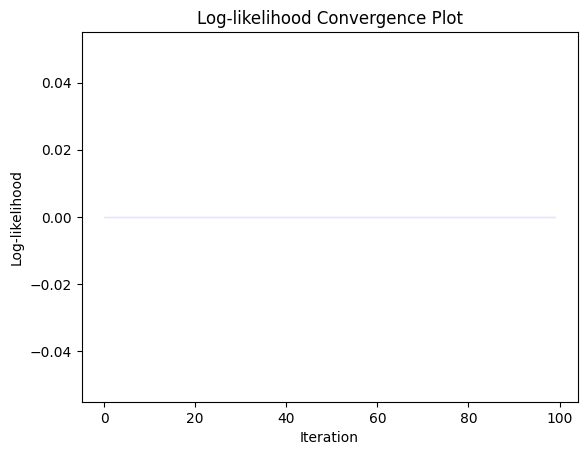

In [ ]:
### This block plots the evolution of log-likelihood during training iterations.
### They will be split off into a separate file for plotting
import scipy.stats as st

# we need to following two variables
print(len(train_llks))
print(train_lld_batches.shape)
#print(train_llks)

n_batches, n_iter = train_lld_batches.shape
lb = np.zeros((n_iter,))
ub = np.zeros((n_iter,))

# plotting codes
plt.figure()
plt.plot(train_llks)
# for i in range(n_batches):
#   temp = -train_lld_batches[i,:]
#   plt.plot(temp, color = 'black', alpha = 0.05)
for j in range(n_iter):
  temp = -train_lld_batches[:,j]

  lb[j] = min(temp)
  ub[j] = max(temp)
  # lb[j] = np.percentile(temp, 2.5)
  # ub[j] = np.percentile(temp, 97.5)

plt.fill_between( range(epoch), lb,ub, color='b', alpha=.1)
plt.title('Log-likelihood Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()

# save the training lld for each batch

(100, 870, 2)
(100, 197, 2)


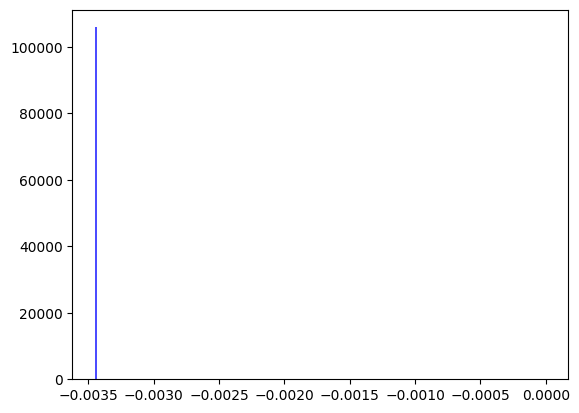

In [ ]:
test_data_1 = np.zeros((raw_test_data_1.shape[0], test_lens.max()))

btest_lens = ((raw_test_data_1 <= buffer_test_time[1]) * (raw_test_data_1 > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data_1 <= test_time[1]) * (raw_test_data_1 > test_time[0])).sum(1)

buffer_test_data1 = np.zeros((raw_test_data_1.shape[0], btest_lens.max()))

for i in range(raw_test_data_1.shape[0]):
    seq = raw_test_data_1[i]
    test_data_1[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data1[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_test_data_1 = np.concatenate((np.ones_like(buffer_test_data1[:, :1]) * buffer_test_time[0], buffer_test_data1), axis=-1)

test_data_1_ = generate_event_mark(test_data_1)
buffer_test_data_1_ = generate_event_mark(buffer_test_data_1)

test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)
true_beta = 0.5

nh_lams = nh_model.sample_intensity(ts,
                              torch.tensor(test_data_1_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_1_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data_1, mu=true_mu, alpha=true_alpha, beta=true_beta)

# # print(true_lams.shape)
# N_smp = true_lams.shape[0]
# for plot_idx in range(N_smp):

#   fig = plt.figure(figsize=(8, 6))
#   ax = fig.add_subplot(1, 1, 1)

#   ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="Truth")
#   ax.plot(ts, nh_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="Weighted NH")
#   # ax.set_ylim(0, 10)
#   ax.legend(fontsize=20)
#   ax.set_xlabel(r"$t$", fontsize=15)
#   ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
#   ax.set_title("Predicted vs True Conditional Intensity", fontsize = 15)
#   # ax.set_xlim(150, 170)

In [ ]:
mae_tol = 0
mae_tol_cnt = 0
mae = []

print(nh_lams.shape)
print(true_lams.shape)

for plot_idx in range(nh_lams.shape[0]):
  mae.append(np.mean(np.abs(nh_lams[plot_idx] - true_lams[plot_idx])))

print("MAE (first cluster): ", np.mean(np.array(mae)))

np.save('lam_1_pred.npy', nh_lams)
np.save('lam_1_true.npy', true_lams)

mae_tol_cnt += nh_lams.shape[0]
mae_tol += np.mean(np.array(mae)) * nh_lams.shape[0]

(100, 200)
(100, 200)
MAE (first cluster):  4.0666110061653145


(100, 870, 2)
(100, 194, 2)


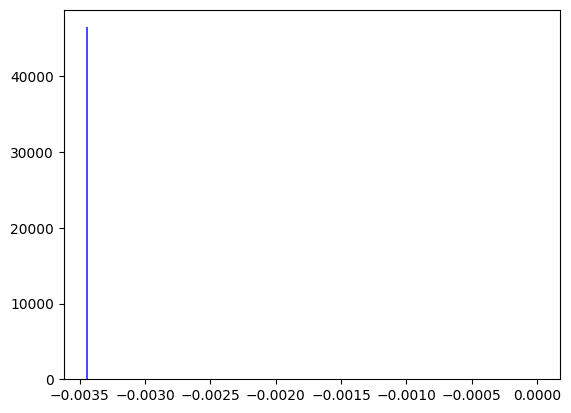

In [ ]:
test_data_2 = np.zeros((raw_test_data_2.shape[0], test_lens.max()))

btest_lens = ((raw_test_data_2 <= buffer_test_time[1]) * (raw_test_data_2 > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data_2 <= test_time[1]) * (raw_test_data_2 > test_time[0])).sum(1)

buffer_test_data2 = np.zeros((raw_test_data_2.shape[0], btest_lens.max()))

for i in range(raw_test_data_2.shape[0]):
    seq = raw_test_data_2[i]
    test_data_2[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data2[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_test_data_2 = np.concatenate((np.ones_like(buffer_test_data2[:, :1]) * buffer_test_time[0], buffer_test_data2), axis=-1)

test_data_2_ = generate_event_mark(test_data_2)
buffer_test_data_2_ = generate_event_mark(buffer_test_data_2)

test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)
true_beta = 1.0

nh_lams = nh_model.sample_intensity(ts,
                              torch.tensor(test_data_2_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_2_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data_2, mu=true_mu, alpha=true_alpha, beta=true_beta)

# print(np.mean(np.abs(lams - true_lams)))
# print(np.mean(np.abs(lams - true_lams) / true_lams))

N_smp = true_lams.shape[0]
# for plot_idx in range(N_smp):

#   fig = plt.figure(figsize=(8, 6))
#   ax = fig.add_subplot(1, 1, 1)

#   ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="Truth")
#   ax.plot(ts, nh_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="Weighted NH")
#   # ax.set_ylim(0, 10)
#   ax.legend(fontsize=20)
#   ax.set_xlabel(r"$t$", fontsize=15)
#   ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
#   ax.set_title("Predicted vs True Conditional Intensity", fontsize = 15)
#   # ax.set_xlim(150, 170)

In [ ]:
mae = []

print(nh_lams.shape)
print(true_lams.shape)

for plot_idx in range(nh_lams.shape[0]):
  mae.append(np.mean(np.abs(nh_lams[plot_idx] - true_lams[plot_idx])))

print("MAE (second cluster): ", np.mean(np.array(mae)))

np.save('lam_2_pred.npy', nh_lams)
np.save('lam_2_true.npy', true_lams)

mae_tol_cnt += nh_lams.shape[0]
mae_tol += np.mean(np.array(mae)) * nh_lams.shape[0]


(100, 200)
(100, 200)
MAE (second cluster):  1.389001882199283


(100, 469, 2)
(100, 142, 2)


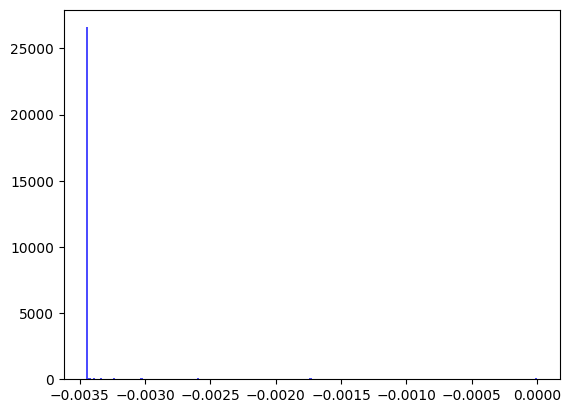

In [ ]:
test_data_3 = np.zeros((raw_test_data_3.shape[0], test_lens.max()))

btest_lens = ((raw_test_data_3 <= buffer_test_time[1]) * (raw_test_data_3 > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data_3 <= test_time[1]) * (raw_test_data_3 > test_time[0])).sum(1)

buffer_test_data3 = np.zeros((raw_test_data_3.shape[0], btest_lens.max()))

for i in range(raw_test_data_3.shape[0]):
    seq = raw_test_data_3[i]
    test_data_3[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data3[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_test_data_3 = np.concatenate((np.ones_like(buffer_test_data3[:, :1]) * buffer_test_time[0], buffer_test_data3), axis=-1)

test_data_3_ = generate_event_mark(test_data_3)
buffer_test_data_3_ = generate_event_mark(buffer_test_data_3)

test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)
true_beta = 1.5

nh_lams = nh_model.sample_intensity(ts,
                              torch.tensor(test_data_3_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_3_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data_3, mu=true_mu, alpha=true_alpha, beta=true_beta)

N_smp = true_lams.shape[0]
# for plot_idx in range(N_smp):

#   fig = plt.figure(figsize=(8, 6))
#   ax = fig.add_subplot(1, 1, 1)

#   ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="Truth")
#   ax.plot(ts, nh_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="Weighted NH")
#   # ax.set_ylim(0, 10)
#   ax.legend(fontsize=20)
#   ax.set_xlabel(r"$t$", fontsize=15)
#   ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
#   ax.set_title("Predicted vs True Conditional Intensity", fontsize = 15)
#   # ax.set_xlim(150, 170)

In [ ]:
mae = []

for plot_idx in range(nh_lams.shape[0]):
  mae.append(np.mean(np.abs(nh_lams[plot_idx] - true_lams[plot_idx])))

print("MAE (third cluster): ", np.mean(np.array(mae)))

np.save('lam_3_pred.npy', nh_lams)
np.save('lam_3_true.npy', true_lams)

mae_tol_cnt += nh_lams.shape[0]
mae_tol += np.mean(np.array(mae)) * nh_lams.shape[0]


MAE (third cluster):  0.942882251973867


In [ ]:
MAE_res = mae_tol / mae_tol_cnt
print(MAE_res)

2.1328317134461545


(100, 134, 2)
(600, 85, 2)
(100, 73, 2)
(100, 134, 2) (600, 85, 2) (100, 73, 2)
CUDA is not Available. You are using CPU only.
Number of cores:  2
100.0
(600, 144, 2)
#parameters: 25
[2024-01-12T16:27:10.772497+00:00] #Training sequences: 600
[2024-01-12T16:27:10.772711+00:00] #Testing sequences: 100
[2024-01-12T16:27:10.772795+00:00] #Training events: 12343
[2024-01-12T16:27:10.772890+00:00] #Testing events: 3845


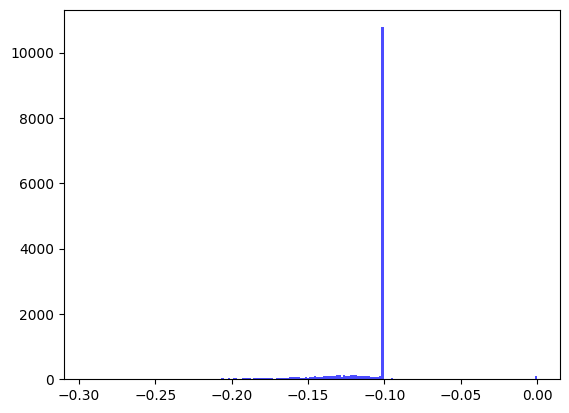

[2024-01-12T16:27:15.943497+00:00] Epochs 0, total loss: 3.30149e+04
[2024-01-12T16:27:15.944446+00:00] Training llk: -1.46638e+00
[2024-01-12T16:27:15.944772+00:00] Testing llk: -1.27250e+00
[2024-01-12T16:27:15.945121+00:00] MAE:0.48446, MRE:3.97512
saving model


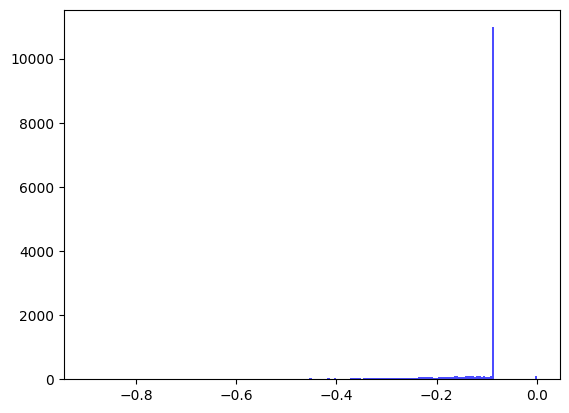

[2024-01-12T16:27:21.294635+00:00] Epochs 1, total loss: 2.96071e+04
[2024-01-12T16:27:21.295920+00:00] Training llk: -1.28069e+00
[2024-01-12T16:27:21.296576+00:00] Testing llk: -1.26689e+00
[2024-01-12T16:27:21.297221+00:00] MAE:0.30590, MRE:2.20914
saving model


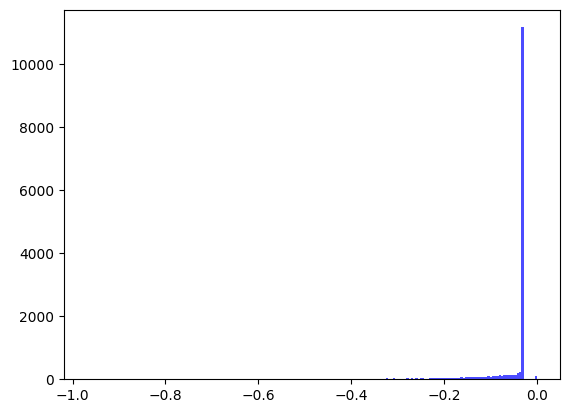

[2024-01-12T16:27:27.379163+00:00] Epochs 2, total loss: 2.66714e+04
[2024-01-12T16:27:27.379383+00:00] Training llk: -1.17134e+00
[2024-01-12T16:27:27.379480+00:00] Testing llk: -1.18640e+00
[2024-01-12T16:27:27.379557+00:00] MAE:0.26113, MRE:1.78005
saving model


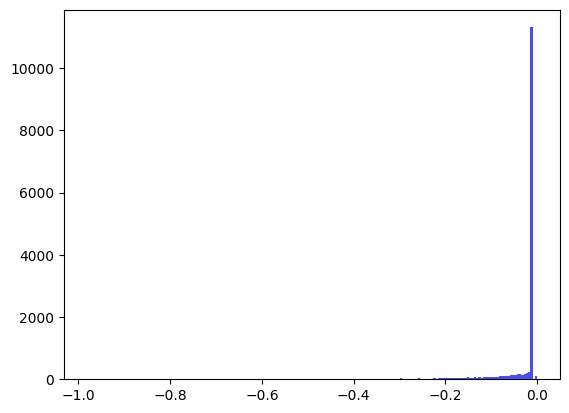

[2024-01-12T16:27:32.402391+00:00] Epochs 3, total loss: 2.47500e+04
[2024-01-12T16:27:32.402669+00:00] Training llk: -1.09395e+00
[2024-01-12T16:27:32.402765+00:00] Testing llk: -1.10248e+00
[2024-01-12T16:27:32.402865+00:00] MAE:0.24267, MRE:1.62716
saving model


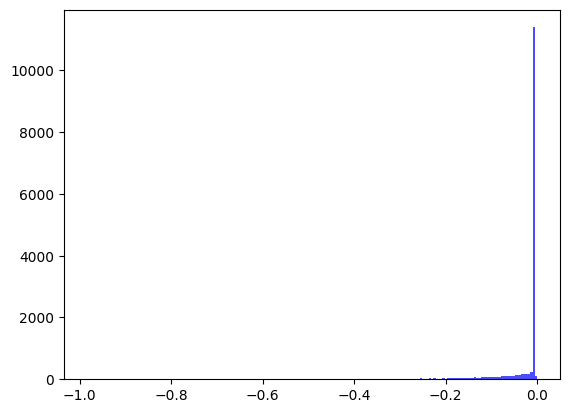

[2024-01-12T16:27:38.566436+00:00] Epochs 4, total loss: 2.32522e+04
[2024-01-12T16:27:38.567107+00:00] Training llk: -1.03053e+00
[2024-01-12T16:27:38.567217+00:00] Testing llk: -1.02298e+00
[2024-01-12T16:27:38.567299+00:00] MAE:0.23377, MRE:1.56373
saving model


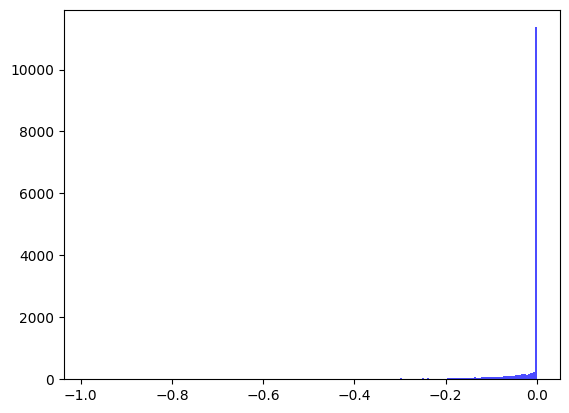

[2024-01-12T16:27:43.713455+00:00] Epochs 5, total loss: 2.19924e+04
[2024-01-12T16:27:43.714909+00:00] Training llk: -9.76613e-01
[2024-01-12T16:27:43.715078+00:00] Testing llk: -9.52983e-01
[2024-01-12T16:27:43.715196+00:00] MAE:0.22833, MRE:1.52019
saving model


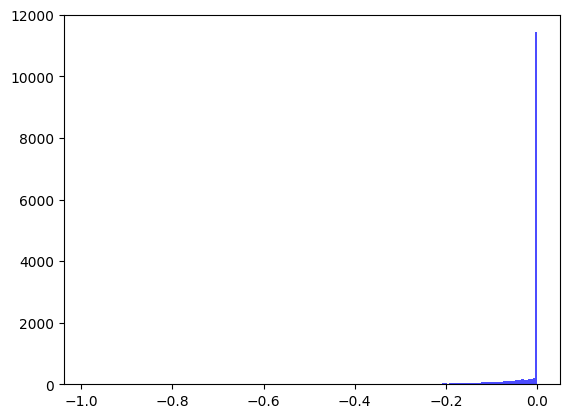

[2024-01-12T16:27:49.397363+00:00] Epochs 6, total loss: 2.09199e+04
[2024-01-12T16:27:49.398643+00:00] Training llk: -9.31058e-01
[2024-01-12T16:27:49.399229+00:00] Testing llk: -8.93780e-01
[2024-01-12T16:27:49.399853+00:00] MAE:0.22551, MRE:1.48389
saving model


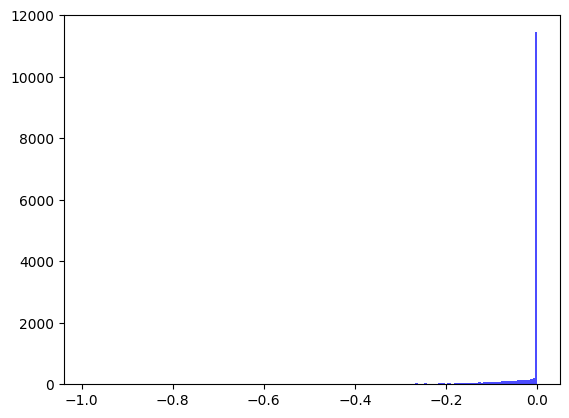

[2024-01-12T16:27:55.831716+00:00] Epochs 7, total loss: 2.00056e+04
[2024-01-12T16:27:55.832922+00:00] Training llk: -8.92770e-01
[2024-01-12T16:27:55.833430+00:00] Testing llk: -8.44242e-01
[2024-01-12T16:27:55.833924+00:00] MAE:0.22599, MRE:1.45602
saving model


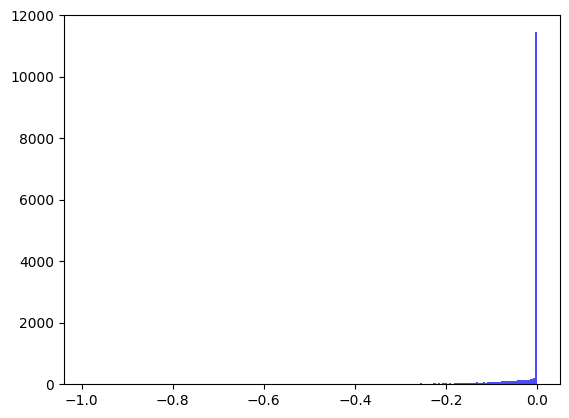

[2024-01-12T16:28:01.633740+00:00] Epochs 8, total loss: 1.92261e+04
[2024-01-12T16:28:01.634878+00:00] Training llk: -8.60594e-01
[2024-01-12T16:28:01.635382+00:00] Testing llk: -8.02890e-01
[2024-01-12T16:28:01.639139+00:00] MAE:0.22939, MRE:1.43502
saving model


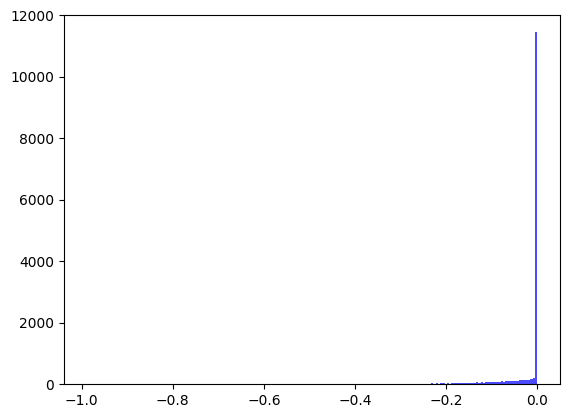

[2024-01-12T16:28:07.325036+00:00] Epochs 9, total loss: 1.85612e+04
[2024-01-12T16:28:07.325331+00:00] Training llk: -8.33534e-01
[2024-01-12T16:28:07.325444+00:00] Testing llk: -7.68429e-01
[2024-01-12T16:28:07.325535+00:00] MAE:0.23425, MRE:1.41778
saving model


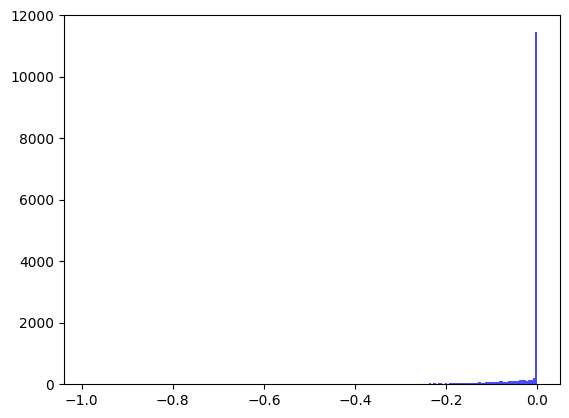

[2024-01-12T16:28:12.381261+00:00] Epochs 10, total loss: 1.79935e+04
[2024-01-12T16:28:12.381557+00:00] Training llk: -8.10750e-01
[2024-01-12T16:28:12.381652+00:00] Testing llk: -7.39697e-01
[2024-01-12T16:28:12.381729+00:00] MAE:0.24021, MRE:1.40318
saving model


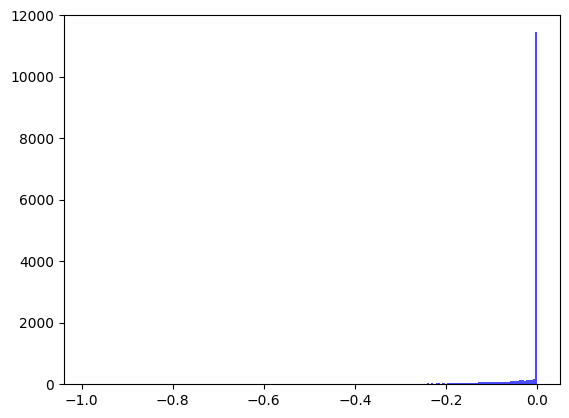

[2024-01-12T16:28:18.389892+00:00] Epochs 11, total loss: 1.75077e+04
[2024-01-12T16:28:18.390826+00:00] Training llk: -7.91529e-01
[2024-01-12T16:28:18.391464+00:00] Testing llk: -7.15688e-01
[2024-01-12T16:28:18.391583+00:00] MAE:0.24690, MRE:1.39075
saving model


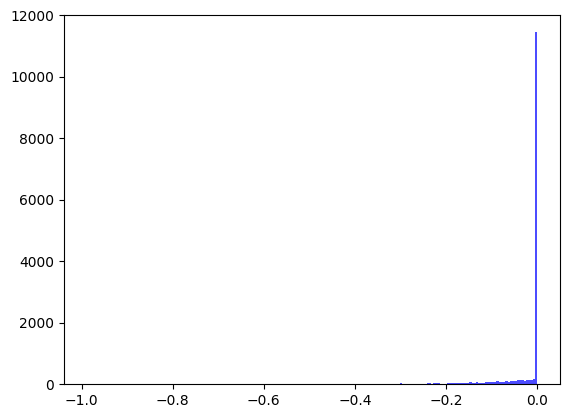

[2024-01-12T16:28:23.795778+00:00] Epochs 12, total loss: 1.70909e+04
[2024-01-12T16:28:23.796118+00:00] Training llk: -7.75268e-01
[2024-01-12T16:28:23.796260+00:00] Testing llk: -6.95561e-01
[2024-01-12T16:28:23.796372+00:00] MAE:0.25398, MRE:1.38014
saving model


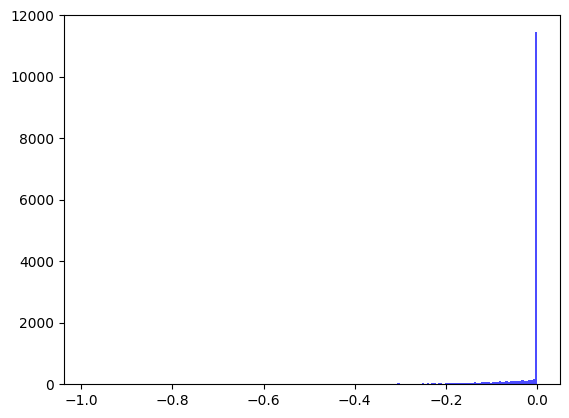

[2024-01-12T16:28:29.755386+00:00] Epochs 13, total loss: 1.67322e+04
[2024-01-12T16:28:29.756609+00:00] Training llk: -7.61468e-01
[2024-01-12T16:28:29.757136+00:00] Testing llk: -6.78630e-01
[2024-01-12T16:28:29.757614+00:00] MAE:0.26122, MRE:1.37115
saving model


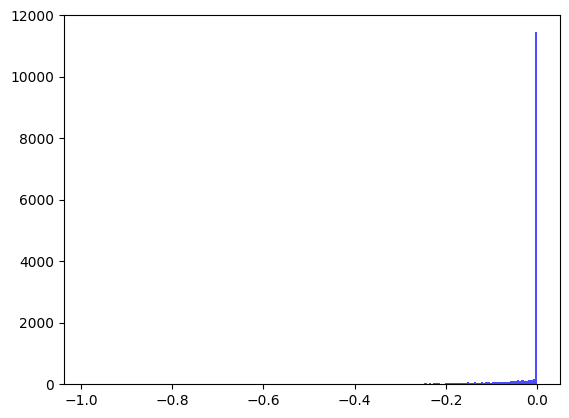

[2024-01-12T16:28:35.049021+00:00] Epochs 14, total loss: 1.64222e+04
[2024-01-12T16:28:35.050172+00:00] Training llk: -7.49714e-01
[2024-01-12T16:28:35.050295+00:00] Testing llk: -6.64335e-01
[2024-01-12T16:28:35.050383+00:00] MAE:0.26861, MRE:1.36365
saving model


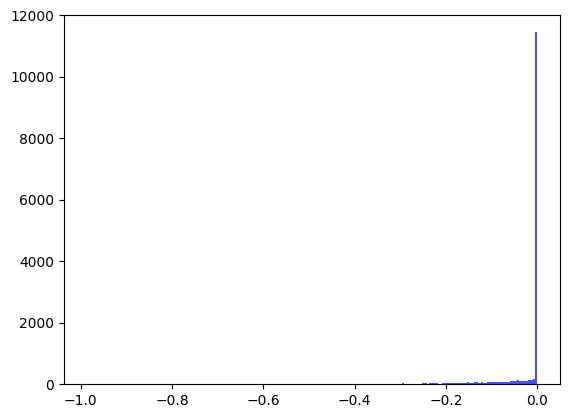

[2024-01-12T16:28:40.009119+00:00] Epochs 15, total loss: 1.61535e+04
[2024-01-12T16:28:40.010025+00:00] Training llk: -7.39667e-01
[2024-01-12T16:28:40.010360+00:00] Testing llk: -6.52221e-01
[2024-01-12T16:28:40.010669+00:00] MAE:0.27605, MRE:1.35747
saving model


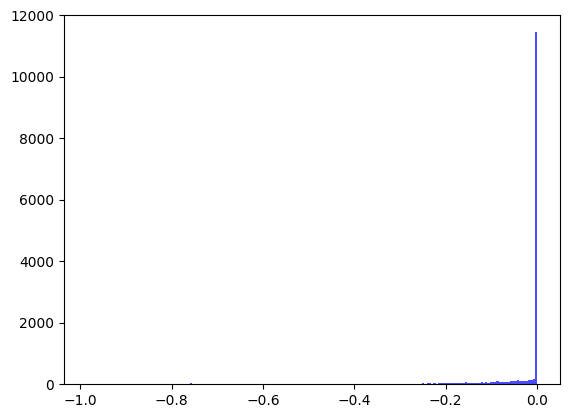

[2024-01-12T16:28:46.318574+00:00] Epochs 16, total loss: 1.59196e+04
[2024-01-12T16:28:46.319302+00:00] Training llk: -7.31047e-01
[2024-01-12T16:28:46.319414+00:00] Testing llk: -6.41919e-01
[2024-01-12T16:28:46.319503+00:00] MAE:0.28347, MRE:1.35244
saving model


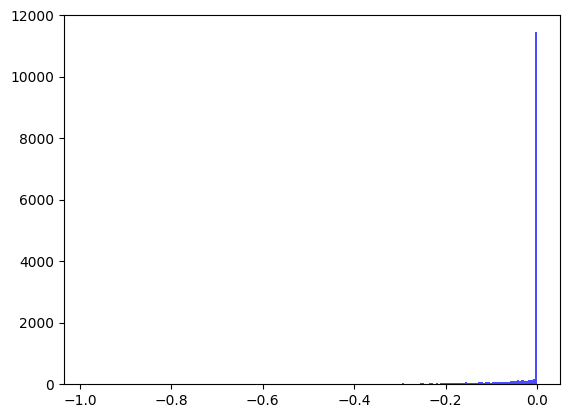

[2024-01-12T16:28:51.329523+00:00] Epochs 17, total loss: 1.57152e+04
[2024-01-12T16:28:51.330392+00:00] Training llk: -7.23624e-01
[2024-01-12T16:28:51.330497+00:00] Testing llk: -6.33129e-01
[2024-01-12T16:28:51.331868+00:00] MAE:0.29076, MRE:1.34837
saving model


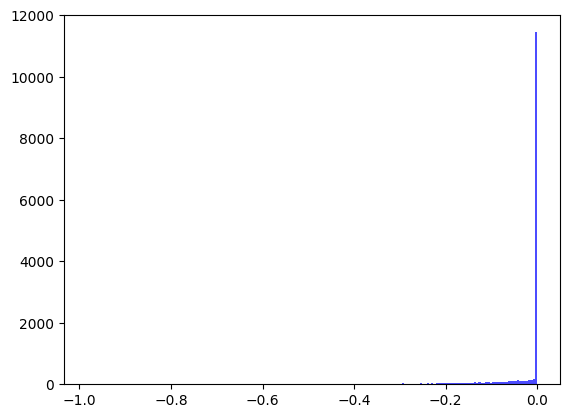

[2024-01-12T16:28:57.298394+00:00] Epochs 18, total loss: 1.55361e+04
[2024-01-12T16:28:57.298686+00:00] Training llk: -7.17209e-01
[2024-01-12T16:28:57.298807+00:00] Testing llk: -6.25604e-01
[2024-01-12T16:28:57.300594+00:00] MAE:0.29784, MRE:1.34509
saving model


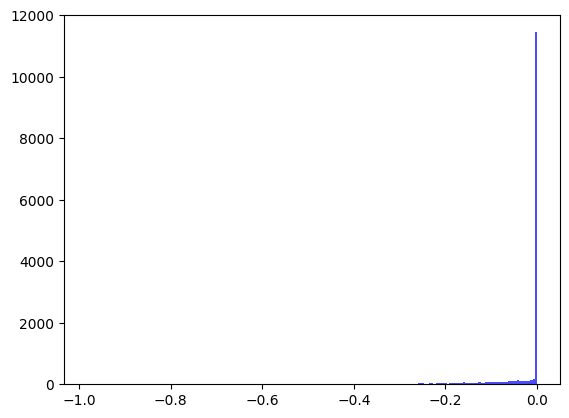

[2024-01-12T16:29:02.393360+00:00] Epochs 19, total loss: 1.53785e+04
[2024-01-12T16:29:02.394370+00:00] Training llk: -7.11646e-01
[2024-01-12T16:29:02.394490+00:00] Testing llk: -6.19144e-01
[2024-01-12T16:29:02.394572+00:00] MAE:0.30465, MRE:1.34246
saving model


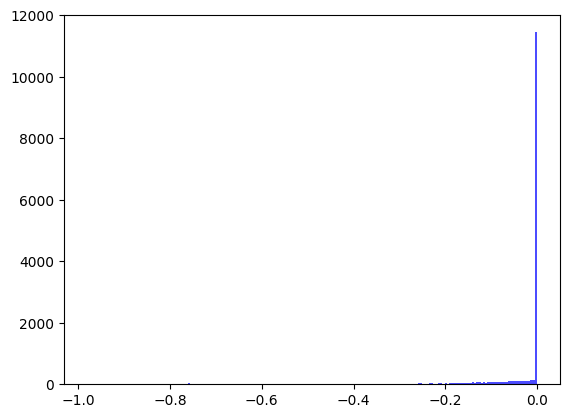

[2024-01-12T16:29:07.383242+00:00] Epochs 20, total loss: 1.52395e+04
[2024-01-12T16:29:07.383533+00:00] Training llk: -7.06806e-01
[2024-01-12T16:29:07.383646+00:00] Testing llk: -6.13582e-01
[2024-01-12T16:29:07.383736+00:00] MAE:0.31126, MRE:1.34039
saving model


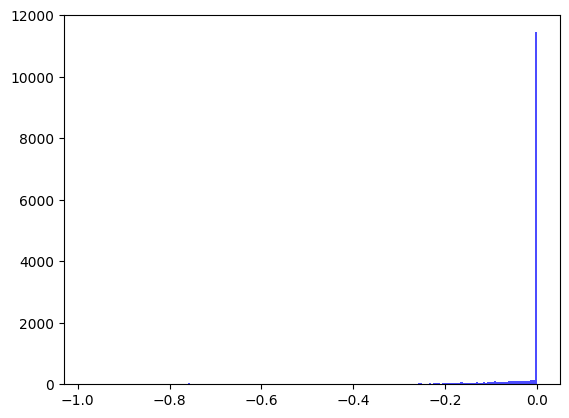

[2024-01-12T16:29:13.670517+00:00] Epochs 21, total loss: 1.51165e+04
[2024-01-12T16:29:13.670807+00:00] Training llk: -7.02583e-01
[2024-01-12T16:29:13.670999+00:00] Testing llk: -6.08783e-01
[2024-01-12T16:29:13.671149+00:00] MAE:0.31764, MRE:1.33879
saving model


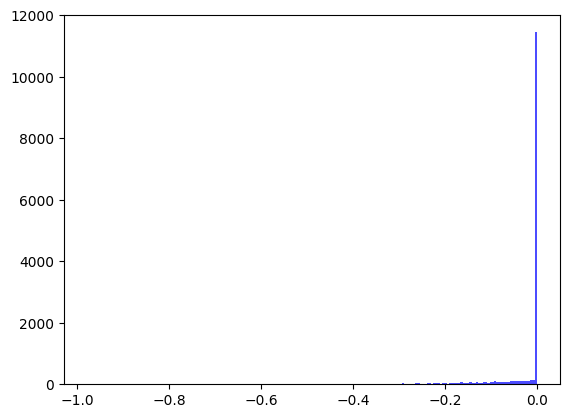

[2024-01-12T16:29:18.615058+00:00] Epochs 22, total loss: 1.50073e+04
[2024-01-12T16:29:18.615990+00:00] Training llk: -6.98885e-01
[2024-01-12T16:29:18.616112+00:00] Testing llk: -6.04631e-01
[2024-01-12T16:29:18.616195+00:00] MAE:0.32374, MRE:1.33754
saving model


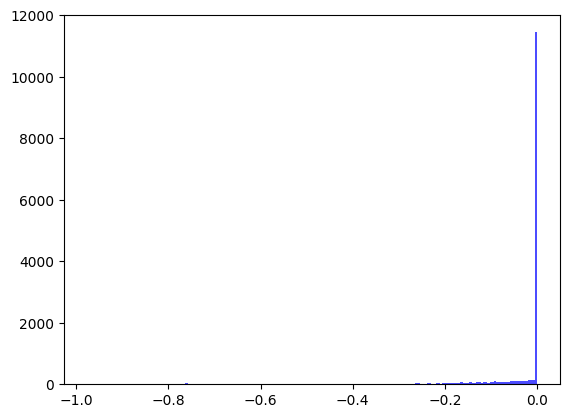

[2024-01-12T16:29:24.572538+00:00] Epochs 23, total loss: 1.49102e+04
[2024-01-12T16:29:24.577182+00:00] Training llk: -6.95638e-01
[2024-01-12T16:29:24.577798+00:00] Testing llk: -6.01034e-01
[2024-01-12T16:29:24.578639+00:00] MAE:0.32957, MRE:1.33656
saving model


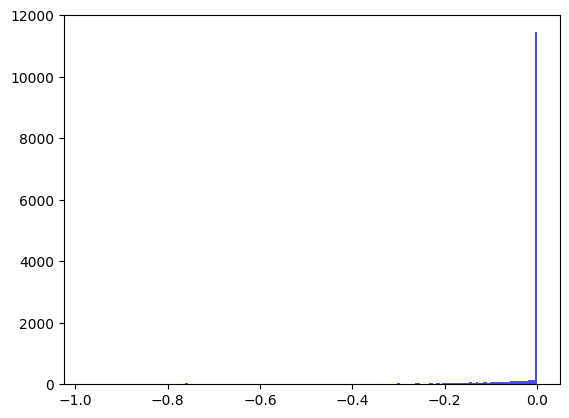

[2024-01-12T16:29:29.608254+00:00] Epochs 24, total loss: 1.48236e+04
[2024-01-12T16:29:29.608513+00:00] Training llk: -6.92780e-01
[2024-01-12T16:29:29.608631+00:00] Testing llk: -5.97910e-01
[2024-01-12T16:29:29.608713+00:00] MAE:0.33514, MRE:1.33580
saving model


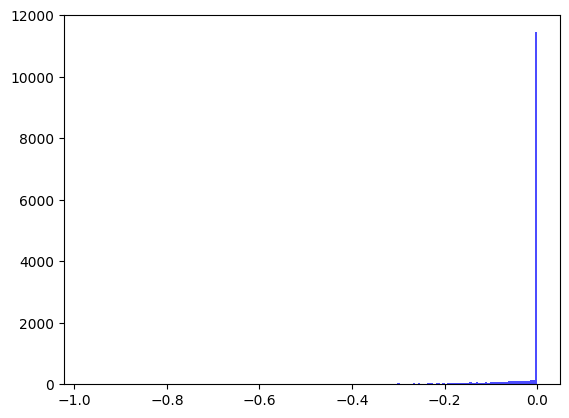

[2024-01-12T16:29:34.917352+00:00] Epochs 25, total loss: 1.47461e+04
[2024-01-12T16:29:34.918514+00:00] Training llk: -6.90256e-01
[2024-01-12T16:29:34.919039+00:00] Testing llk: -5.95194e-01
[2024-01-12T16:29:34.919504+00:00] MAE:0.34050, MRE:1.33522
saving model


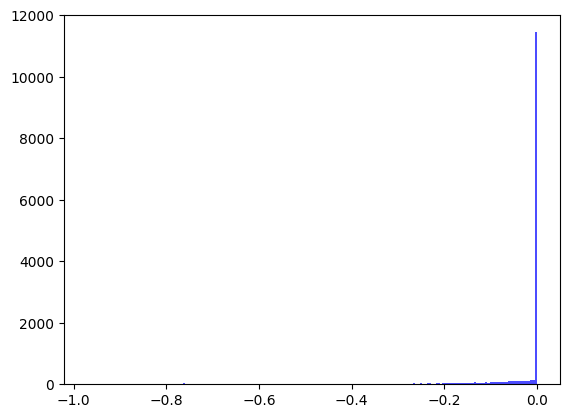

[2024-01-12T16:29:40.845494+00:00] Epochs 26, total loss: 1.46768e+04
[2024-01-12T16:29:40.846349+00:00] Training llk: -6.88022e-01
[2024-01-12T16:29:40.846681+00:00] Testing llk: -5.92828e-01
[2024-01-12T16:29:40.847036+00:00] MAE:0.34560, MRE:1.33473
saving model


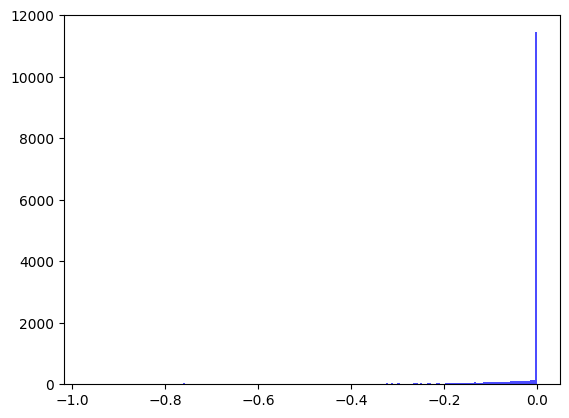

[2024-01-12T16:29:45.799930+00:00] Epochs 27, total loss: 1.46145e+04
[2024-01-12T16:29:45.800720+00:00] Training llk: -6.86040e-01
[2024-01-12T16:29:45.800874+00:00] Testing llk: -5.90766e-01
[2024-01-12T16:29:45.800968+00:00] MAE:0.35045, MRE:1.33431
saving model


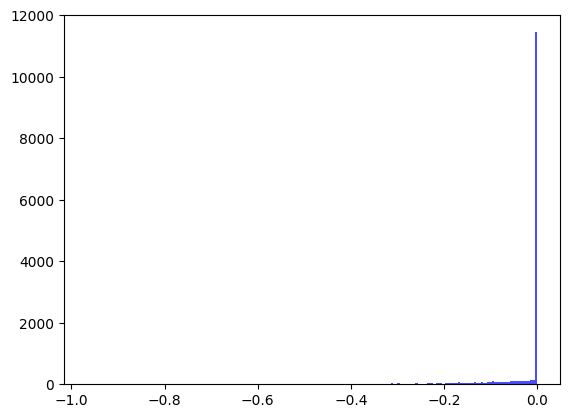

[2024-01-12T16:29:51.836242+00:00] Epochs 28, total loss: 1.45585e+04
[2024-01-12T16:29:51.837030+00:00] Training llk: -6.84276e-01
[2024-01-12T16:29:51.837146+00:00] Testing llk: -5.88966e-01
[2024-01-12T16:29:51.838696+00:00] MAE:0.35505, MRE:1.33391
saving model


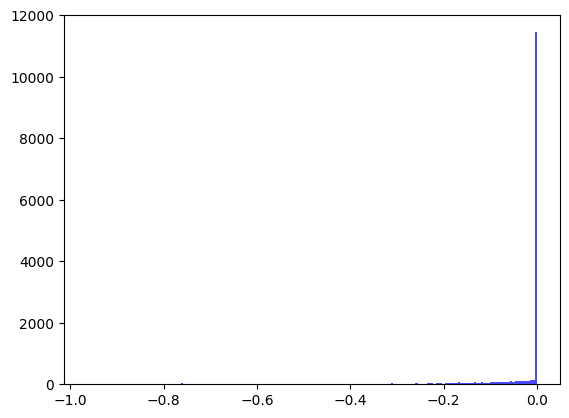

[2024-01-12T16:29:56.819866+00:00] Epochs 29, total loss: 1.45081e+04
[2024-01-12T16:29:56.820147+00:00] Training llk: -6.82703e-01
[2024-01-12T16:29:56.820252+00:00] Testing llk: -5.87394e-01
[2024-01-12T16:29:56.820338+00:00] MAE:0.35942, MRE:1.33351
saving model


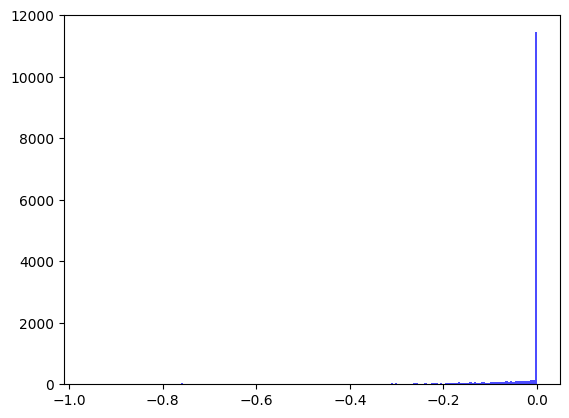

[2024-01-12T16:30:02.668605+00:00] Epochs 30, total loss: 1.44626e+04
[2024-01-12T16:30:02.669803+00:00] Training llk: -6.81296e-01
[2024-01-12T16:30:02.670346+00:00] Testing llk: -5.86020e-01
[2024-01-12T16:30:02.670824+00:00] MAE:0.36355, MRE:1.33309
saving model


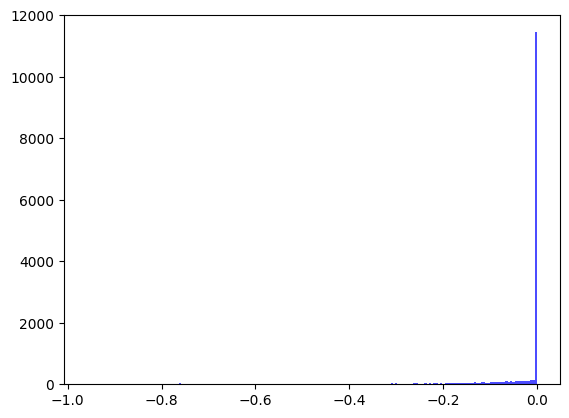

[2024-01-12T16:30:08.321042+00:00] Epochs 31, total loss: 1.44215e+04
[2024-01-12T16:30:08.321723+00:00] Training llk: -6.80036e-01
[2024-01-12T16:30:08.322884+00:00] Testing llk: -5.84818e-01
[2024-01-12T16:30:08.323005+00:00] MAE:0.36746, MRE:1.33263
saving model


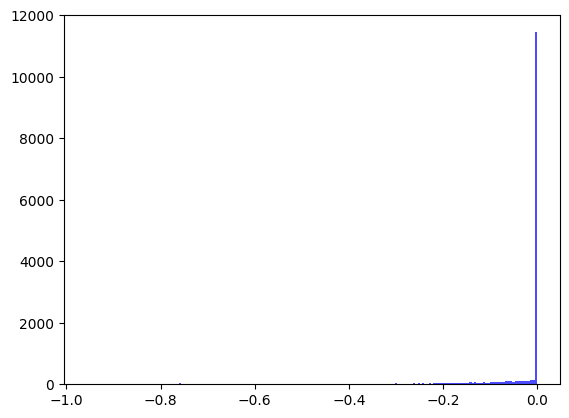

[2024-01-12T16:30:13.272223+00:00] Epochs 32, total loss: 1.43843e+04
[2024-01-12T16:30:13.272518+00:00] Training llk: -6.78903e-01
[2024-01-12T16:30:13.272640+00:00] Testing llk: -5.83766e-01
[2024-01-12T16:30:13.272731+00:00] MAE:0.37116, MRE:1.33212
saving model


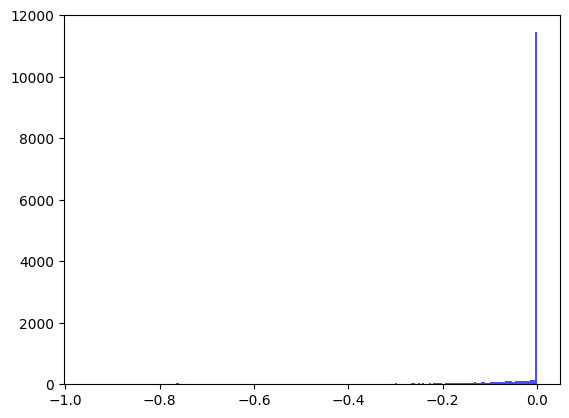

[2024-01-12T16:30:19.341702+00:00] Epochs 33, total loss: 1.43506e+04
[2024-01-12T16:30:19.343278+00:00] Training llk: -6.77883e-01
[2024-01-12T16:30:19.343717+00:00] Testing llk: -5.82845e-01
[2024-01-12T16:30:19.343858+00:00] MAE:0.37467, MRE:1.33155
saving model


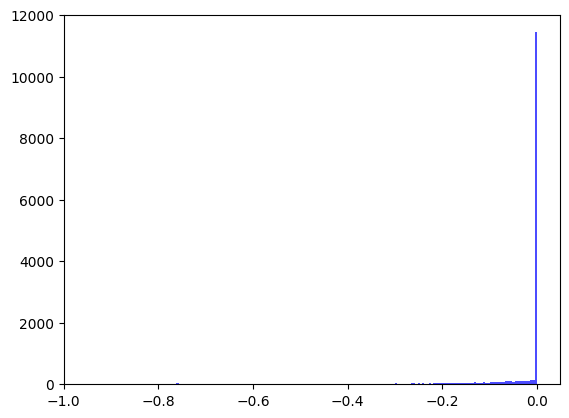

[2024-01-12T16:30:24.655131+00:00] Epochs 34, total loss: 1.43200e+04
[2024-01-12T16:30:24.656452+00:00] Training llk: -6.76963e-01
[2024-01-12T16:30:24.657097+00:00] Testing llk: -5.82039e-01
[2024-01-12T16:30:24.657675+00:00] MAE:0.37798, MRE:1.33091
saving model


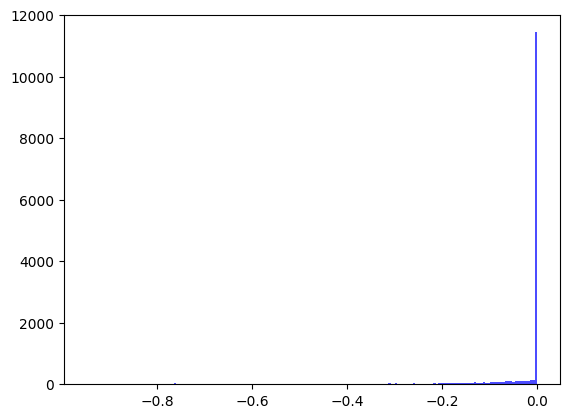

[2024-01-12T16:30:30.441471+00:00] Epochs 35, total loss: 1.42922e+04
[2024-01-12T16:30:30.442780+00:00] Training llk: -6.76130e-01
[2024-01-12T16:30:30.443363+00:00] Testing llk: -5.81332e-01
[2024-01-12T16:30:30.443880+00:00] MAE:0.38110, MRE:1.33019
saving model


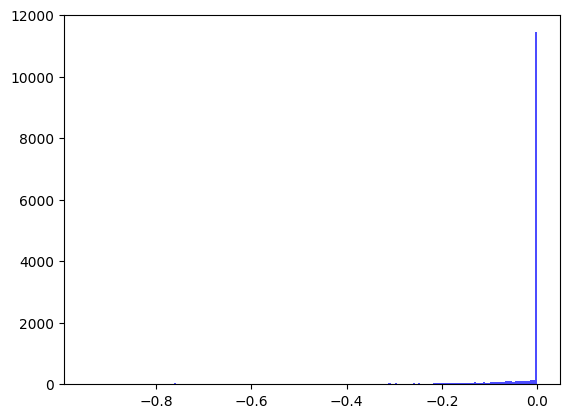

[2024-01-12T16:30:35.878627+00:00] Epochs 36, total loss: 1.42669e+04
[2024-01-12T16:30:35.879900+00:00] Training llk: -6.75375e-01
[2024-01-12T16:30:35.880531+00:00] Testing llk: -5.80714e-01
[2024-01-12T16:30:35.881086+00:00] MAE:0.38403, MRE:1.32941
saving model


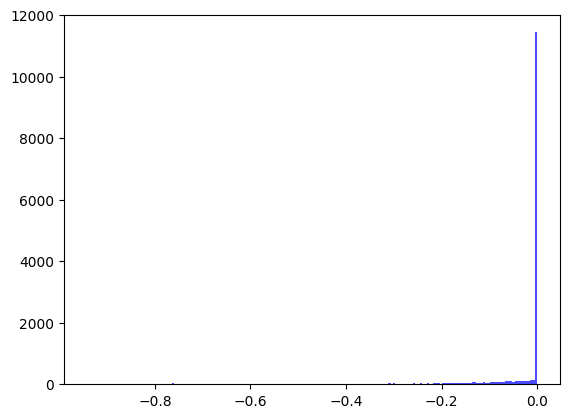

[2024-01-12T16:30:40.901910+00:00] Epochs 37, total loss: 1.42439e+04
[2024-01-12T16:30:40.903316+00:00] Training llk: -6.74688e-01
[2024-01-12T16:30:40.903897+00:00] Testing llk: -5.80173e-01
[2024-01-12T16:30:40.904416+00:00] MAE:0.38679, MRE:1.32854
saving model


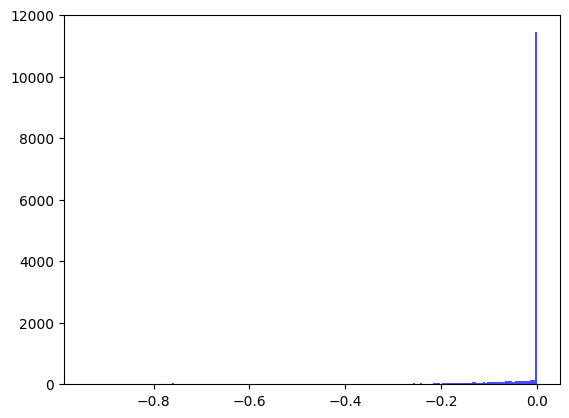

[2024-01-12T16:30:46.990295+00:00] Epochs 38, total loss: 1.42229e+04
[2024-01-12T16:30:46.991535+00:00] Training llk: -6.74063e-01
[2024-01-12T16:30:46.992183+00:00] Testing llk: -5.79699e-01
[2024-01-12T16:30:46.992784+00:00] MAE:0.38939, MRE:1.32762
saving model


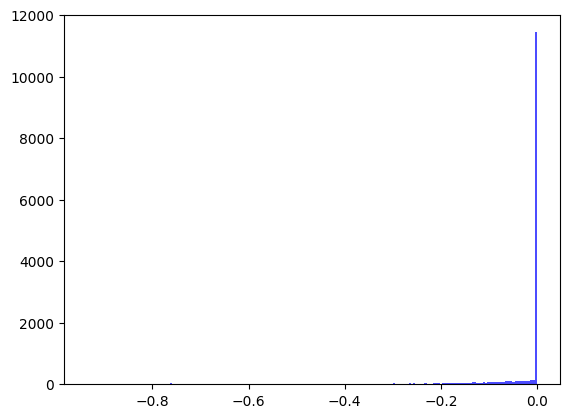

[2024-01-12T16:30:52.334628+00:00] Epochs 39, total loss: 1.42037e+04
[2024-01-12T16:30:52.335809+00:00] Training llk: -6.73492e-01
[2024-01-12T16:30:52.336568+00:00] Testing llk: -5.79284e-01
[2024-01-12T16:30:52.337177+00:00] MAE:0.39183, MRE:1.32662
saving model


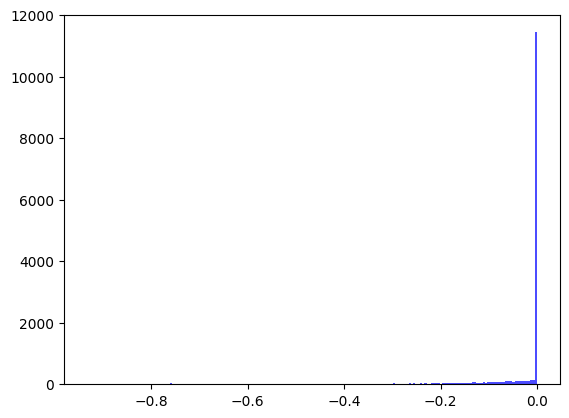

[2024-01-12T16:30:58.291795+00:00] Epochs 40, total loss: 1.41861e+04
[2024-01-12T16:30:58.292995+00:00] Training llk: -6.72970e-01
[2024-01-12T16:30:58.293526+00:00] Testing llk: -5.78922e-01
[2024-01-12T16:30:58.294049+00:00] MAE:0.39413, MRE:1.32557
saving model


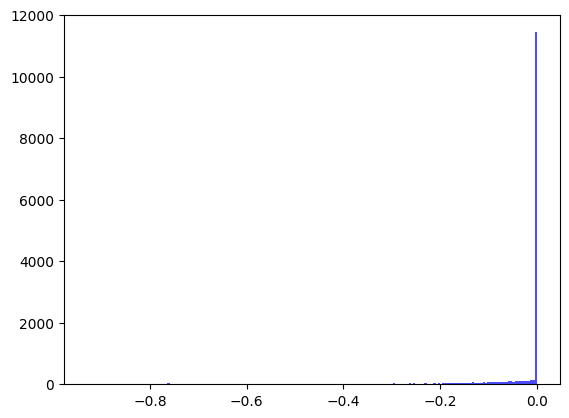

[2024-01-12T16:31:03.798743+00:00] Epochs 41, total loss: 1.41701e+04
[2024-01-12T16:31:03.799076+00:00] Training llk: -6.72490e-01
[2024-01-12T16:31:03.799188+00:00] Testing llk: -5.78605e-01
[2024-01-12T16:31:03.799289+00:00] MAE:0.39628, MRE:1.32446
saving model


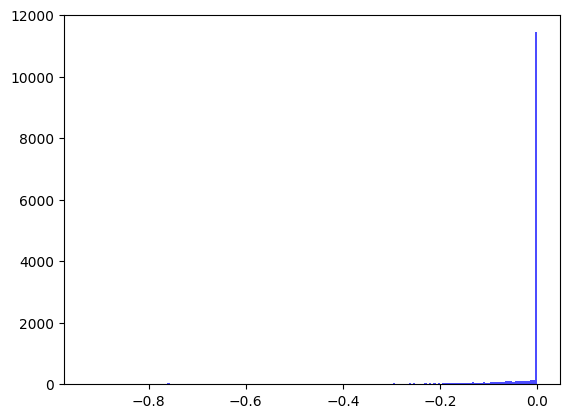

[2024-01-12T16:31:09.214755+00:00] Epochs 42, total loss: 1.41554e+04
[2024-01-12T16:31:09.216017+00:00] Training llk: -6.72050e-01
[2024-01-12T16:31:09.216539+00:00] Testing llk: -5.78327e-01
[2024-01-12T16:31:09.217061+00:00] MAE:0.39830, MRE:1.32330
saving model


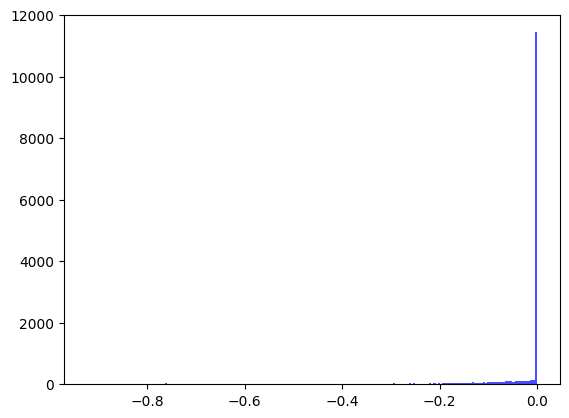

[2024-01-12T16:31:15.569344+00:00] Epochs 43, total loss: 1.41419e+04
[2024-01-12T16:31:15.570535+00:00] Training llk: -6.71643e-01
[2024-01-12T16:31:15.571096+00:00] Testing llk: -5.78085e-01
[2024-01-12T16:31:15.571617+00:00] MAE:0.40019, MRE:1.32210
saving model


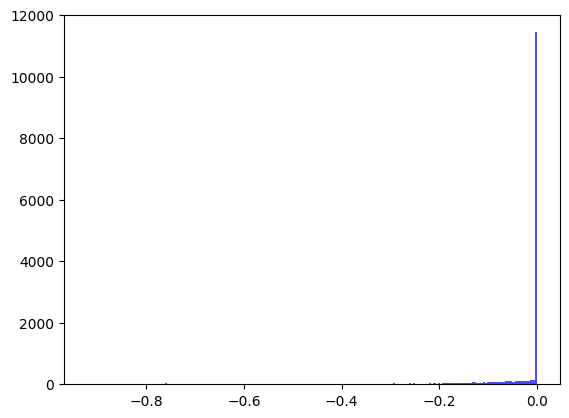

[2024-01-12T16:31:21.259914+00:00] Epochs 44, total loss: 1.41295e+04
[2024-01-12T16:31:21.260207+00:00] Training llk: -6.71267e-01
[2024-01-12T16:31:21.260302+00:00] Testing llk: -5.77873e-01
[2024-01-12T16:31:21.260379+00:00] MAE:0.40195, MRE:1.32086
saving model


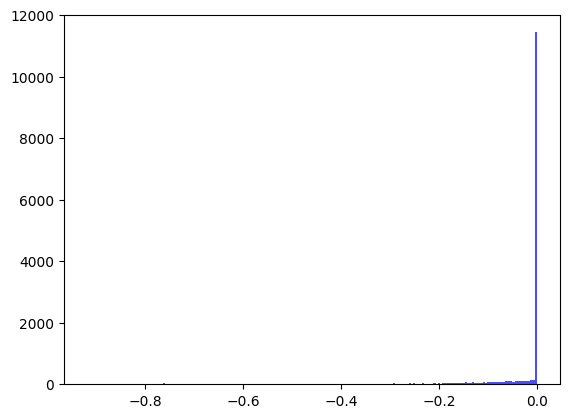

[2024-01-12T16:31:27.679075+00:00] Epochs 45, total loss: 1.41181e+04
[2024-01-12T16:31:27.680325+00:00] Training llk: -6.70918e-01
[2024-01-12T16:31:27.680905+00:00] Testing llk: -5.77685e-01
[2024-01-12T16:31:27.681396+00:00] MAE:0.40360, MRE:1.31958
saving model


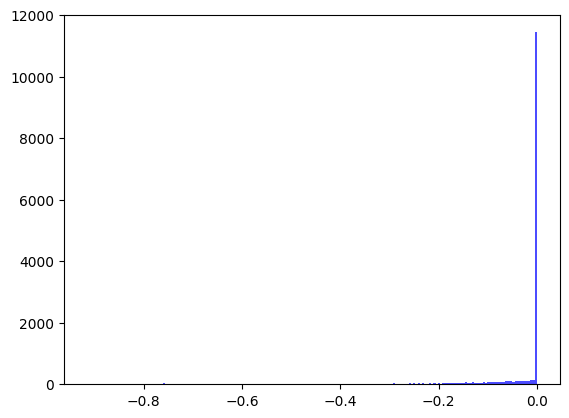

[2024-01-12T16:31:32.980717+00:00] Epochs 46, total loss: 1.41075e+04
[2024-01-12T16:31:32.981168+00:00] Training llk: -6.70591e-01
[2024-01-12T16:31:32.981367+00:00] Testing llk: -5.77518e-01
[2024-01-12T16:31:32.981454+00:00] MAE:0.40513, MRE:1.31828
saving model


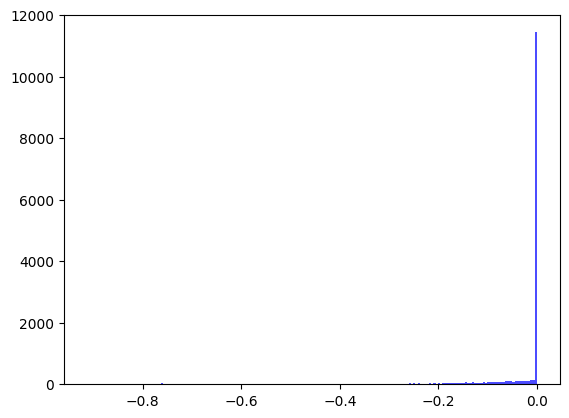

[2024-01-12T16:31:38.936310+00:00] Epochs 47, total loss: 1.40977e+04
[2024-01-12T16:31:38.938863+00:00] Training llk: -6.70281e-01
[2024-01-12T16:31:38.939099+00:00] Testing llk: -5.77363e-01
[2024-01-12T16:31:38.939198+00:00] MAE:0.40655, MRE:1.31695
saving model


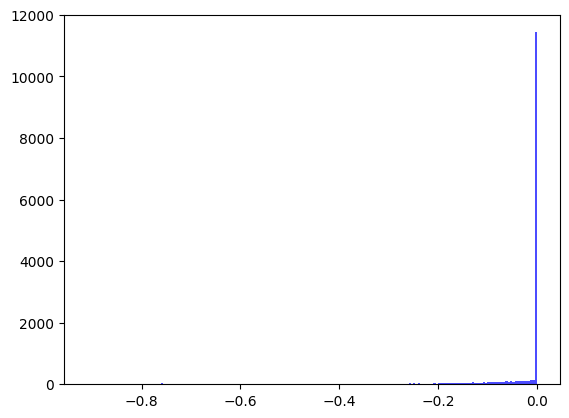

[2024-01-12T16:31:44.652228+00:00] Epochs 48, total loss: 1.40885e+04
[2024-01-12T16:31:44.652506+00:00] Training llk: -6.69979e-01
[2024-01-12T16:31:44.652611+00:00] Testing llk: -5.77207e-01
[2024-01-12T16:31:44.652699+00:00] MAE:0.40784, MRE:1.31557
saving model


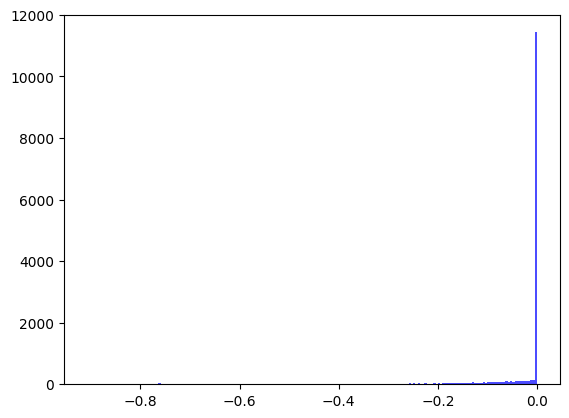

[2024-01-12T16:31:49.835228+00:00] Epochs 49, total loss: 1.40797e+04
[2024-01-12T16:31:49.836986+00:00] Training llk: -6.69658e-01
[2024-01-12T16:31:49.838070+00:00] Testing llk: -5.77015e-01
[2024-01-12T16:31:49.838689+00:00] MAE:0.40897, MRE:1.31409
saving model


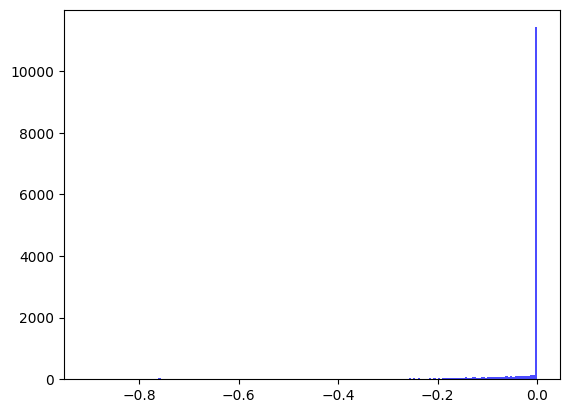

[2024-01-12T16:31:56.009922+00:00] Epochs 50, total loss: 1.40701e+04
[2024-01-12T16:31:56.011145+00:00] Training llk: -6.69190e-01
[2024-01-12T16:31:56.011724+00:00] Testing llk: -5.76605e-01
[2024-01-12T16:31:56.012382+00:00] MAE:0.40963, MRE:1.31202
saving model


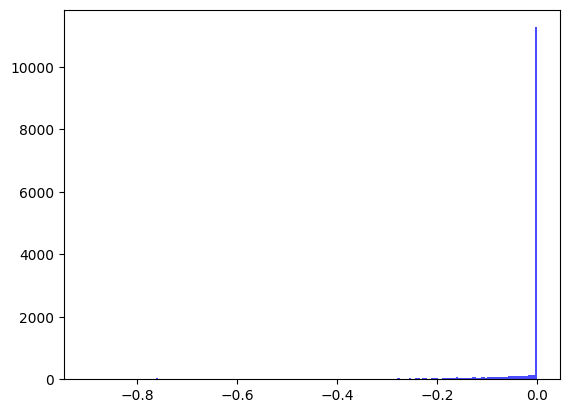

[2024-01-12T16:32:01.083704+00:00] Epochs 51, total loss: 1.40469e+04
[2024-01-12T16:32:01.084941+00:00] Training llk: -6.65226e-01
[2024-01-12T16:32:01.085488+00:00] Testing llk: -5.72037e-01
[2024-01-12T16:32:01.086007+00:00] MAE:0.39910, MRE:1.28219
saving model


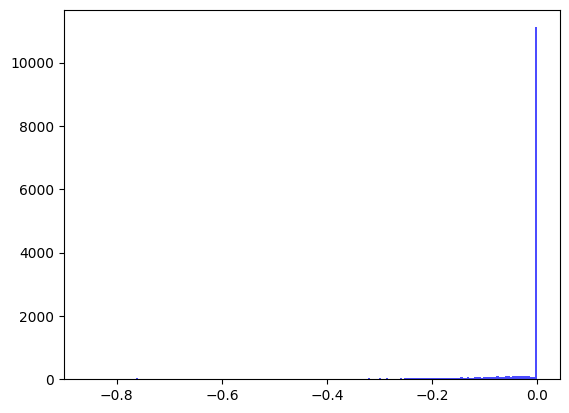

[2024-01-12T16:32:07.173114+00:00] Epochs 52, total loss: 1.38935e+04
[2024-01-12T16:32:07.174341+00:00] Training llk: -6.57497e-01
[2024-01-12T16:32:07.174919+00:00] Testing llk: -5.57609e-01
[2024-01-12T16:32:07.175441+00:00] MAE:0.35320, MRE:1.18274
saving model


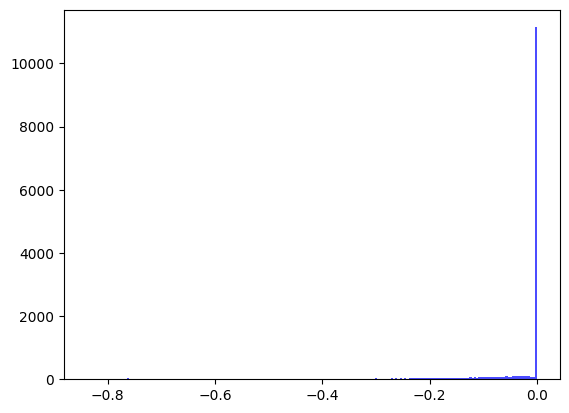

[2024-01-12T16:32:13.755789+00:00] Epochs 53, total loss: 1.38408e+04
[2024-01-12T16:32:13.756100+00:00] Training llk: -6.56792e-01
[2024-01-12T16:32:13.756205+00:00] Testing llk: -5.57233e-01
[2024-01-12T16:32:13.756297+00:00] MAE:0.37077, MRE:1.23505
saving model


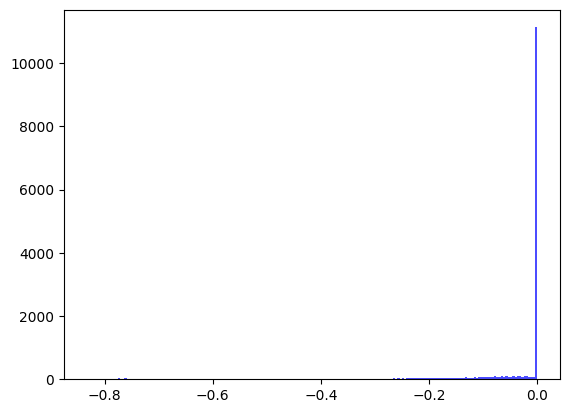

[2024-01-12T16:32:20.104207+00:00] Epochs 54, total loss: 1.37993e+04
[2024-01-12T16:32:20.109526+00:00] Training llk: -6.56121e-01
[2024-01-12T16:32:20.110108+00:00] Testing llk: -5.55180e-01
[2024-01-12T16:32:20.110721+00:00] MAE:0.37527, MRE:1.24798
saving model


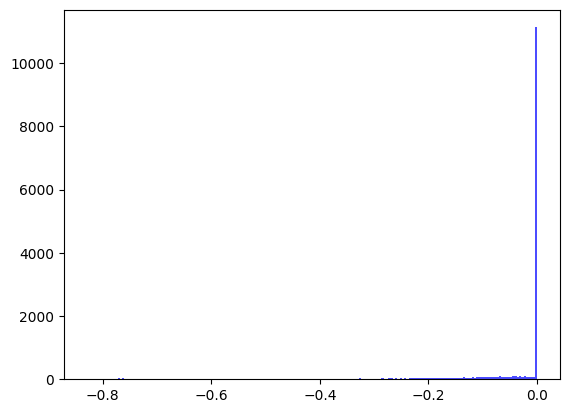

[2024-01-12T16:32:25.294631+00:00] Epochs 55, total loss: 1.37719e+04
[2024-01-12T16:32:25.295892+00:00] Training llk: -6.55802e-01
[2024-01-12T16:32:25.296481+00:00] Testing llk: -5.54647e-01
[2024-01-12T16:32:25.297029+00:00] MAE:0.37928, MRE:1.25362
saving model


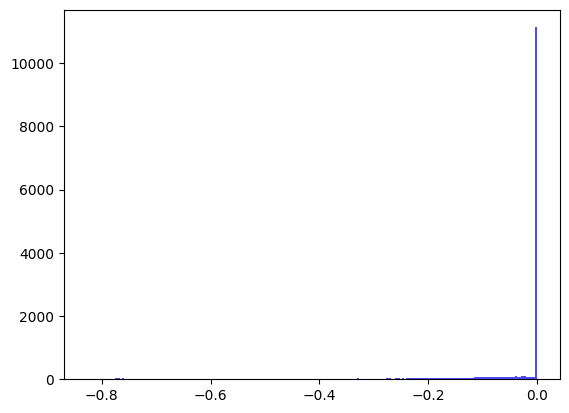

[2024-01-12T16:32:30.448242+00:00] Epochs 56, total loss: 1.37486e+04
[2024-01-12T16:32:30.449451+00:00] Training llk: -6.55475e-01
[2024-01-12T16:32:30.449979+00:00] Testing llk: -5.54066e-01
[2024-01-12T16:32:30.450462+00:00] MAE:0.38280, MRE:1.25790
saving model


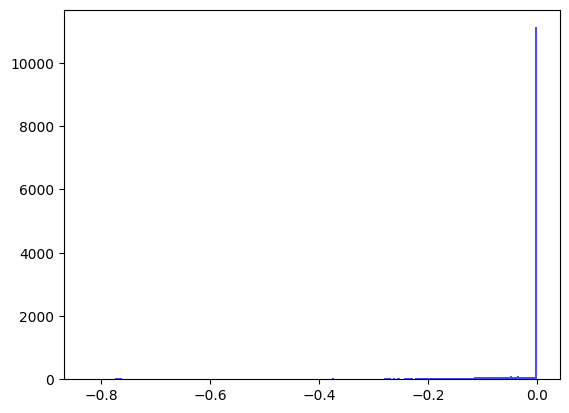

[2024-01-12T16:32:36.480706+00:00] Epochs 57, total loss: 1.37286e+04
[2024-01-12T16:32:36.482306+00:00] Training llk: -6.55188e-01
[2024-01-12T16:32:36.483066+00:00] Testing llk: -5.53620e-01
[2024-01-12T16:32:36.483583+00:00] MAE:0.38597, MRE:1.26101
saving model


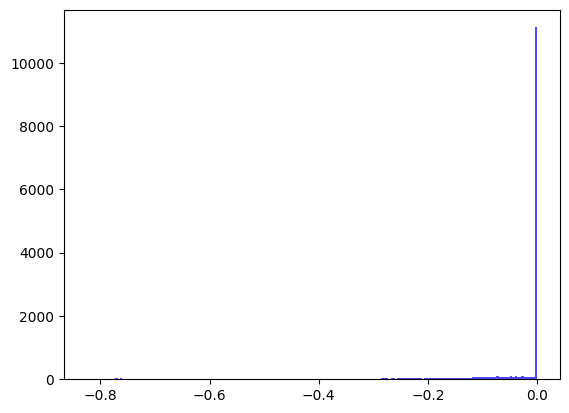

[2024-01-12T16:32:41.997953+00:00] Epochs 58, total loss: 1.37108e+04
[2024-01-12T16:32:41.999195+00:00] Training llk: -6.54928e-01
[2024-01-12T16:32:41.999744+00:00] Testing llk: -5.53255e-01
[2024-01-12T16:32:42.000281+00:00] MAE:0.38880, MRE:1.26318
saving model


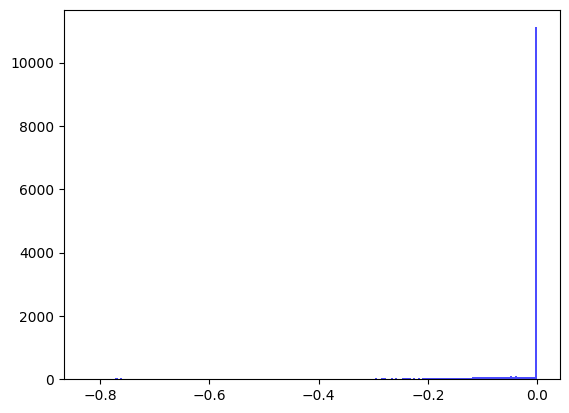

[2024-01-12T16:32:48.206191+00:00] Epochs 59, total loss: 1.36950e+04
[2024-01-12T16:32:48.207392+00:00] Training llk: -6.54691e-01
[2024-01-12T16:32:48.208094+00:00] Testing llk: -5.52949e-01
[2024-01-12T16:32:48.208626+00:00] MAE:0.39134, MRE:1.26471
saving model


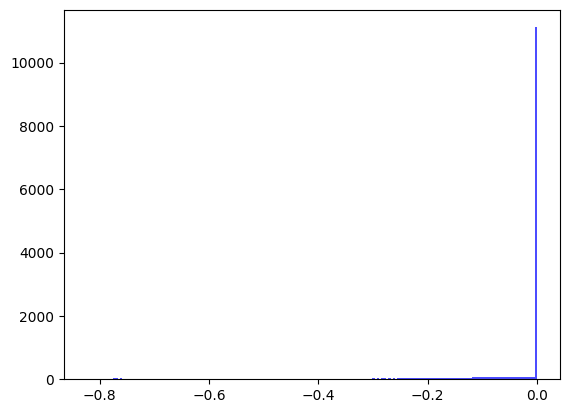

[2024-01-12T16:32:53.322233+00:00] Epochs 60, total loss: 1.36806e+04
[2024-01-12T16:32:53.323428+00:00] Training llk: -6.54472e-01
[2024-01-12T16:32:53.323975+00:00] Testing llk: -5.52688e-01
[2024-01-12T16:32:53.324481+00:00] MAE:0.39363, MRE:1.26574
saving model


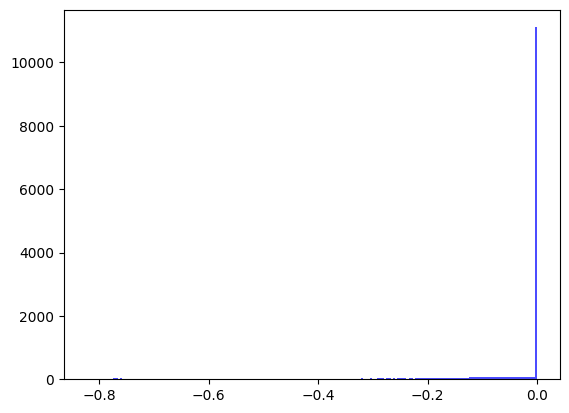

[2024-01-12T16:32:58.836809+00:00] Epochs 61, total loss: 1.36675e+04
[2024-01-12T16:32:58.838053+00:00] Training llk: -6.54268e-01
[2024-01-12T16:32:58.838642+00:00] Testing llk: -5.52460e-01
[2024-01-12T16:32:58.841288+00:00] MAE:0.39570, MRE:1.26639
saving model


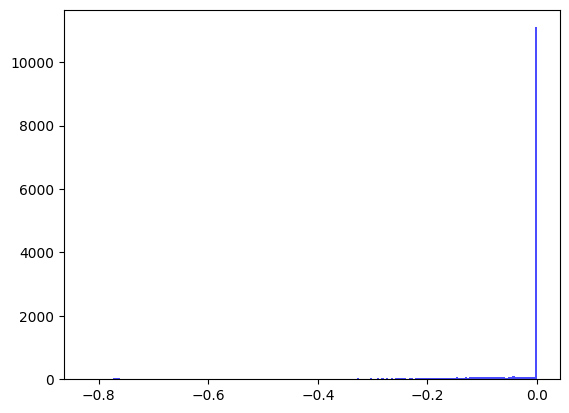

[2024-01-12T16:33:04.833922+00:00] Epochs 62, total loss: 1.36555e+04
[2024-01-12T16:33:04.834189+00:00] Training llk: -6.54076e-01
[2024-01-12T16:33:04.834298+00:00] Testing llk: -5.52258e-01
[2024-01-12T16:33:04.834386+00:00] MAE:0.39758, MRE:1.26673
saving model


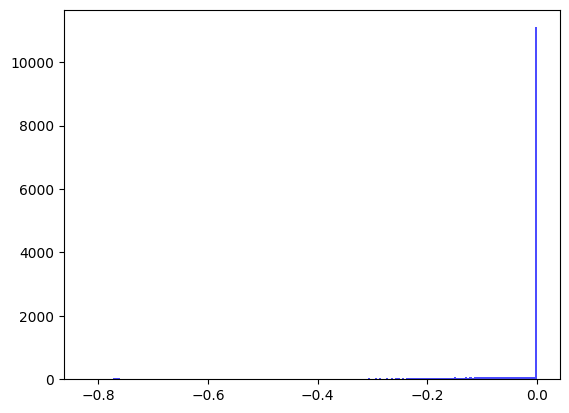

[2024-01-12T16:33:09.824686+00:00] Epochs 63, total loss: 1.36445e+04
[2024-01-12T16:33:09.826088+00:00] Training llk: -6.53895e-01
[2024-01-12T16:33:09.826735+00:00] Testing llk: -5.52077e-01
[2024-01-12T16:33:09.827344+00:00] MAE:0.39930, MRE:1.26683
saving model


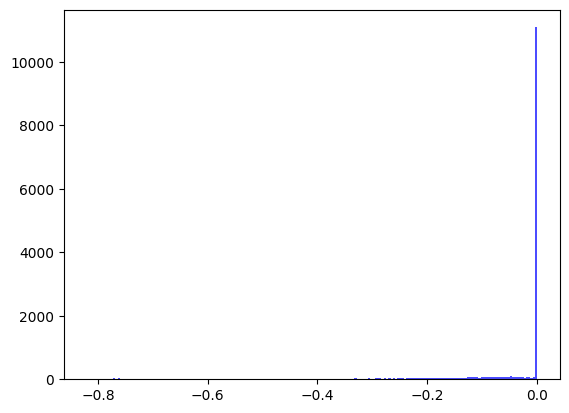

[2024-01-12T16:33:15.957961+00:00] Epochs 64, total loss: 1.36343e+04
[2024-01-12T16:33:15.959253+00:00] Training llk: -6.53723e-01
[2024-01-12T16:33:15.959793+00:00] Testing llk: -5.51912e-01
[2024-01-12T16:33:15.960343+00:00] MAE:0.40087, MRE:1.26674
saving model


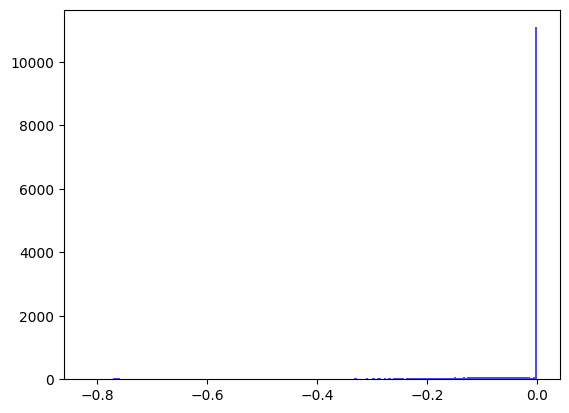

[2024-01-12T16:33:20.990563+00:00] Epochs 65, total loss: 1.36247e+04
[2024-01-12T16:33:20.991742+00:00] Training llk: -6.53559e-01
[2024-01-12T16:33:20.992316+00:00] Testing llk: -5.51761e-01
[2024-01-12T16:33:20.992807+00:00] MAE:0.40231, MRE:1.26648
saving model


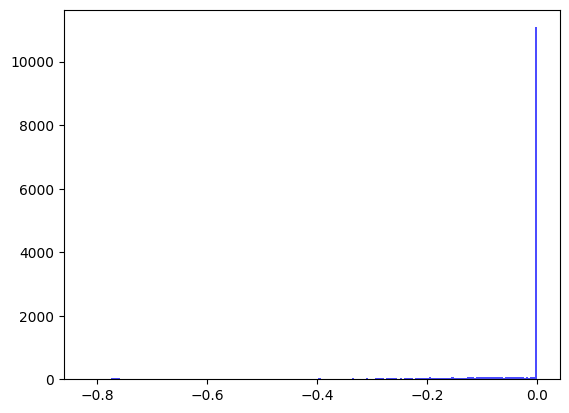

[2024-01-12T16:33:26.713696+00:00] Epochs 66, total loss: 1.36159e+04
[2024-01-12T16:33:26.714897+00:00] Training llk: -6.53403e-01
[2024-01-12T16:33:26.715465+00:00] Testing llk: -5.51622e-01
[2024-01-12T16:33:26.715992+00:00] MAE:0.40363, MRE:1.26610
saving model


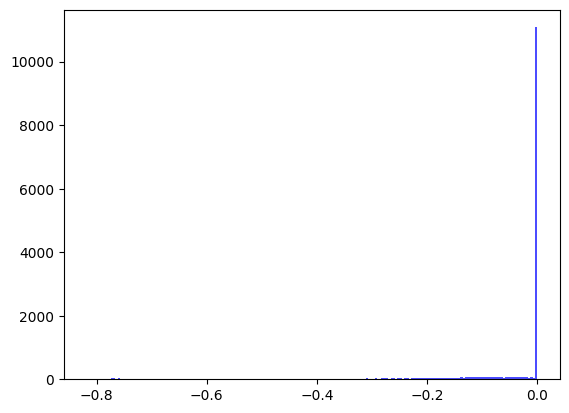

[2024-01-12T16:33:32.359820+00:00] Epochs 67, total loss: 1.36076e+04
[2024-01-12T16:33:32.361072+00:00] Training llk: -6.53252e-01
[2024-01-12T16:33:32.361631+00:00] Testing llk: -5.51492e-01
[2024-01-12T16:33:32.362167+00:00] MAE:0.40484, MRE:1.26561
saving model


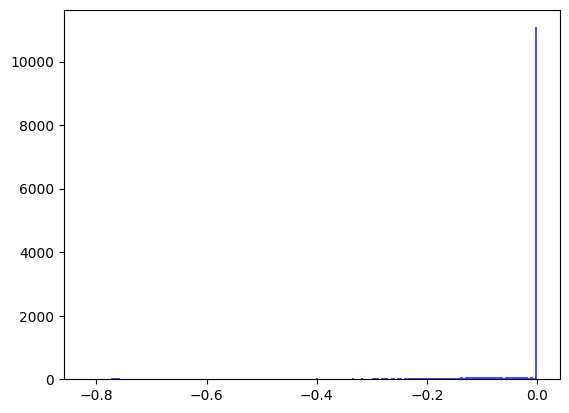

[2024-01-12T16:33:37.457090+00:00] Epochs 68, total loss: 1.35998e+04
[2024-01-12T16:33:37.457370+00:00] Training llk: -6.53108e-01
[2024-01-12T16:33:37.457487+00:00] Testing llk: -5.51371e-01
[2024-01-12T16:33:37.457577+00:00] MAE:0.40597, MRE:1.26503
saving model


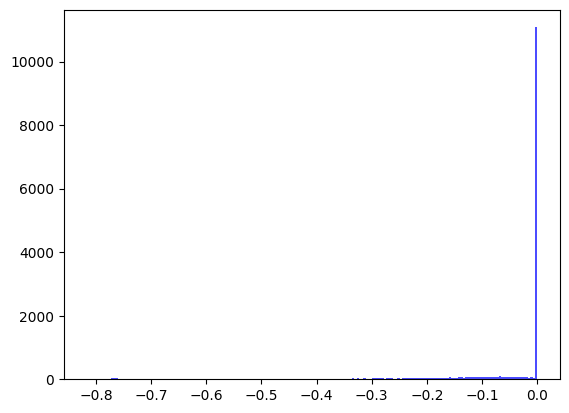

[2024-01-12T16:33:43.484224+00:00] Epochs 69, total loss: 1.35924e+04
[2024-01-12T16:33:43.485473+00:00] Training llk: -6.52969e-01
[2024-01-12T16:33:43.486059+00:00] Testing llk: -5.51258e-01
[2024-01-12T16:33:43.486540+00:00] MAE:0.40700, MRE:1.26439
saving model


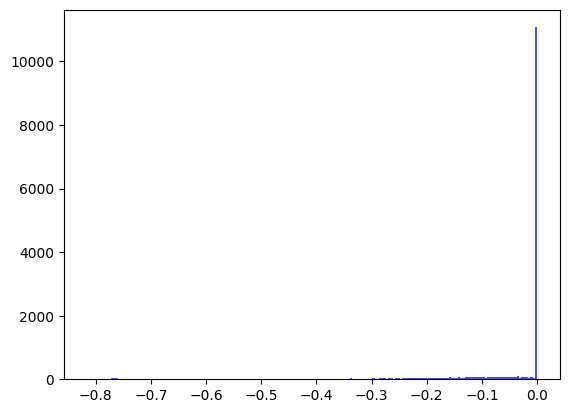

[2024-01-12T16:33:48.563624+00:00] Epochs 70, total loss: 1.35855e+04
[2024-01-12T16:33:48.565026+00:00] Training llk: -6.52835e-01
[2024-01-12T16:33:48.565599+00:00] Testing llk: -5.51152e-01
[2024-01-12T16:33:48.566134+00:00] MAE:0.40796, MRE:1.26370
saving model


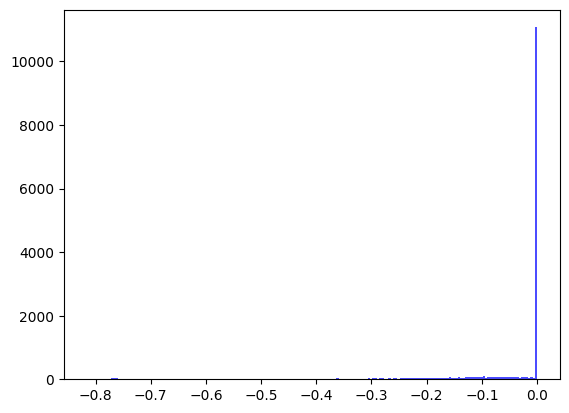

[2024-01-12T16:33:54.571394+00:00] Epochs 71, total loss: 1.35789e+04
[2024-01-12T16:33:54.572622+00:00] Training llk: -6.52706e-01
[2024-01-12T16:33:54.574379+00:00] Testing llk: -5.51051e-01
[2024-01-12T16:33:54.574976+00:00] MAE:0.40885, MRE:1.26296
saving model


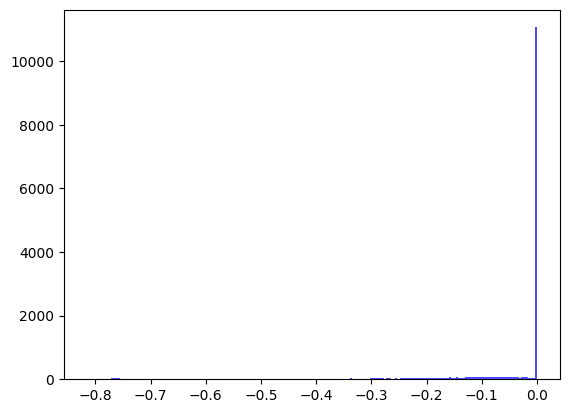

[2024-01-12T16:33:59.948412+00:00] Epochs 72, total loss: 1.35727e+04
[2024-01-12T16:33:59.949692+00:00] Training llk: -6.52582e-01
[2024-01-12T16:33:59.950270+00:00] Testing llk: -5.50957e-01
[2024-01-12T16:33:59.950754+00:00] MAE:0.40968, MRE:1.26220
saving model


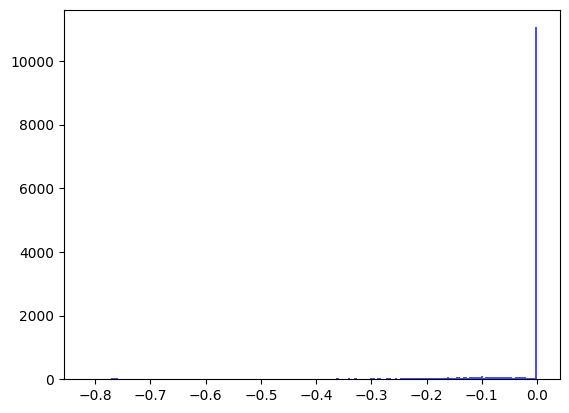

[2024-01-12T16:34:05.124042+00:00] Epochs 73, total loss: 1.35669e+04
[2024-01-12T16:34:05.125316+00:00] Training llk: -6.52463e-01
[2024-01-12T16:34:05.125930+00:00] Testing llk: -5.50868e-01
[2024-01-12T16:34:05.126551+00:00] MAE:0.41045, MRE:1.26141
saving model


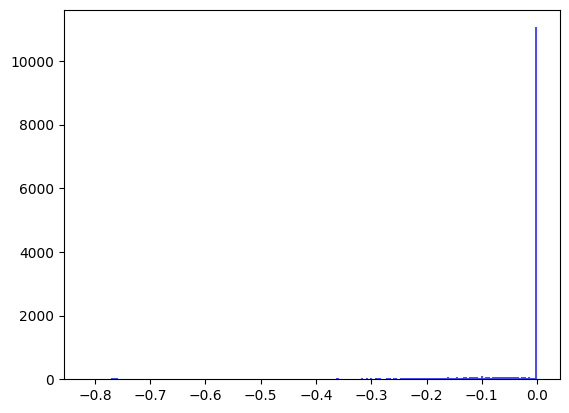

[2024-01-12T16:34:11.054489+00:00] Epochs 74, total loss: 1.35613e+04
[2024-01-12T16:34:11.055730+00:00] Training llk: -6.52348e-01
[2024-01-12T16:34:11.056329+00:00] Testing llk: -5.50784e-01
[2024-01-12T16:34:11.056814+00:00] MAE:0.41116, MRE:1.26061
saving model


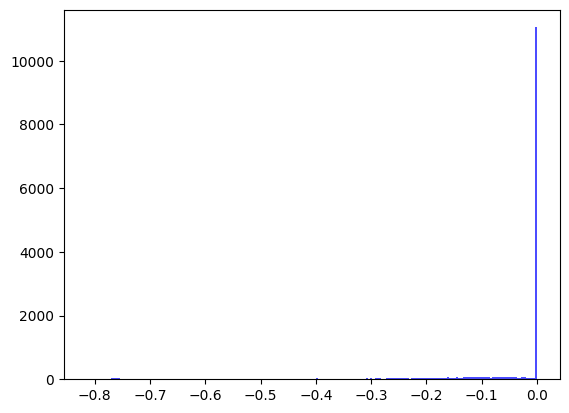

[2024-01-12T16:34:16.084094+00:00] Epochs 75, total loss: 1.35560e+04
[2024-01-12T16:34:16.085550+00:00] Training llk: -6.52237e-01
[2024-01-12T16:34:16.086274+00:00] Testing llk: -5.50705e-01
[2024-01-12T16:34:16.086942+00:00] MAE:0.41183, MRE:1.25980
saving model


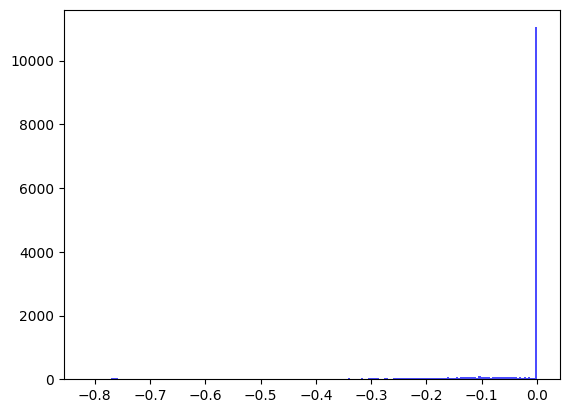

[2024-01-12T16:34:22.513892+00:00] Epochs 76, total loss: 1.35509e+04
[2024-01-12T16:34:22.514184+00:00] Training llk: -6.52131e-01
[2024-01-12T16:34:22.514303+00:00] Testing llk: -5.50630e-01
[2024-01-12T16:34:22.514395+00:00] MAE:0.41246, MRE:1.25899
saving model


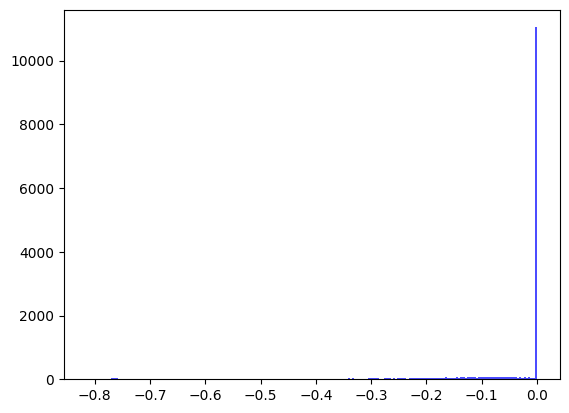

[2024-01-12T16:34:27.642179+00:00] Epochs 77, total loss: 1.35461e+04
[2024-01-12T16:34:27.643376+00:00] Training llk: -6.52029e-01
[2024-01-12T16:34:27.643952+00:00] Testing llk: -5.50560e-01
[2024-01-12T16:34:27.644443+00:00] MAE:0.41305, MRE:1.25819
saving model


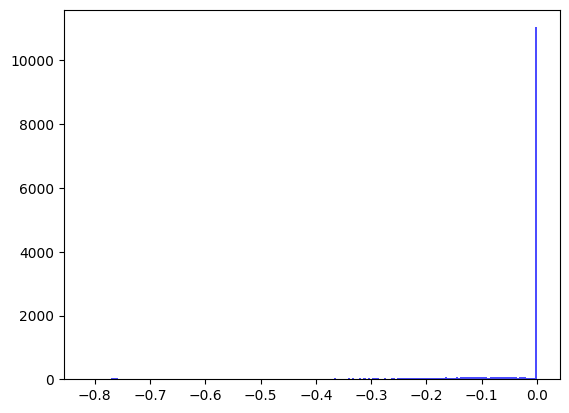

[2024-01-12T16:34:33.179772+00:00] Epochs 78, total loss: 1.35415e+04
[2024-01-12T16:34:33.180901+00:00] Training llk: -6.51931e-01
[2024-01-12T16:34:33.181417+00:00] Testing llk: -5.50494e-01
[2024-01-12T16:34:33.181898+00:00] MAE:0.41360, MRE:1.25739
saving model


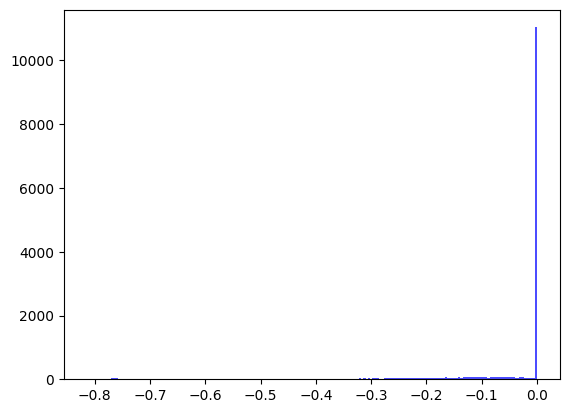

[2024-01-12T16:34:38.776804+00:00] Epochs 79, total loss: 1.35372e+04
[2024-01-12T16:34:38.778715+00:00] Training llk: -6.51837e-01
[2024-01-12T16:34:38.779297+00:00] Testing llk: -5.50431e-01
[2024-01-12T16:34:38.779824+00:00] MAE:0.41412, MRE:1.25660
saving model


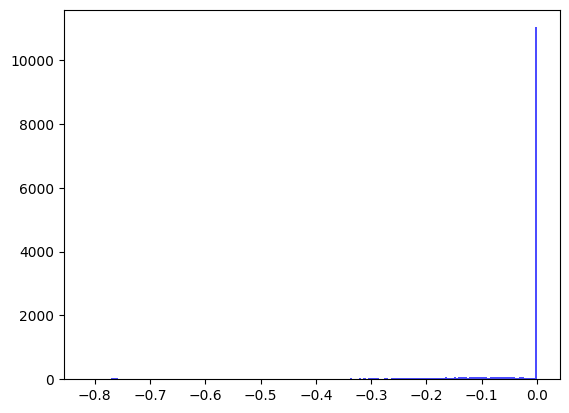

[2024-01-12T16:34:43.863937+00:00] Epochs 80, total loss: 1.35330e+04
[2024-01-12T16:34:43.864217+00:00] Training llk: -6.51747e-01
[2024-01-12T16:34:43.864315+00:00] Testing llk: -5.50373e-01
[2024-01-12T16:34:43.864387+00:00] MAE:0.41461, MRE:1.25582
saving model


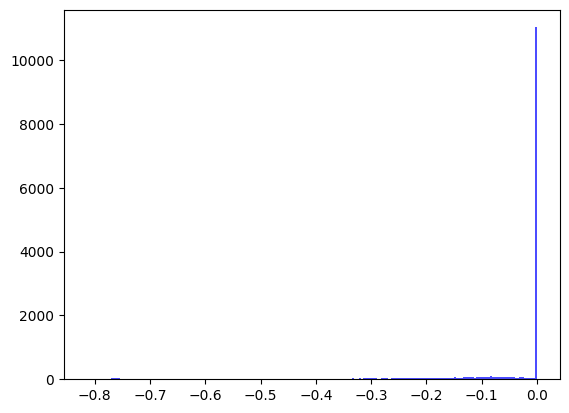

[2024-01-12T16:34:50.248087+00:00] Epochs 81, total loss: 1.35290e+04
[2024-01-12T16:34:50.249373+00:00] Training llk: -6.51661e-01
[2024-01-12T16:34:50.249937+00:00] Testing llk: -5.50318e-01
[2024-01-12T16:34:50.250455+00:00] MAE:0.41507, MRE:1.25506
saving model


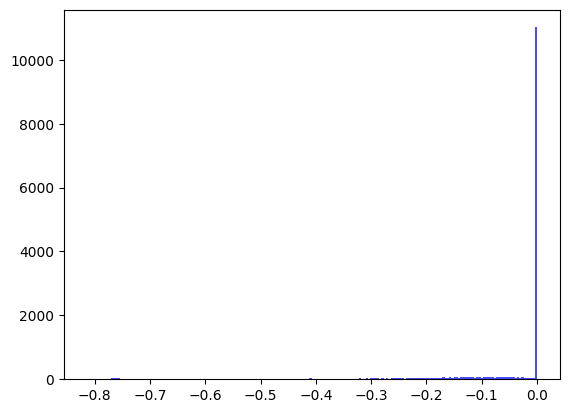

[2024-01-12T16:34:55.270352+00:00] Epochs 82, total loss: 1.35251e+04
[2024-01-12T16:34:55.271589+00:00] Training llk: -6.51579e-01
[2024-01-12T16:34:55.272153+00:00] Testing llk: -5.50266e-01
[2024-01-12T16:34:55.272664+00:00] MAE:0.41551, MRE:1.25432
saving model


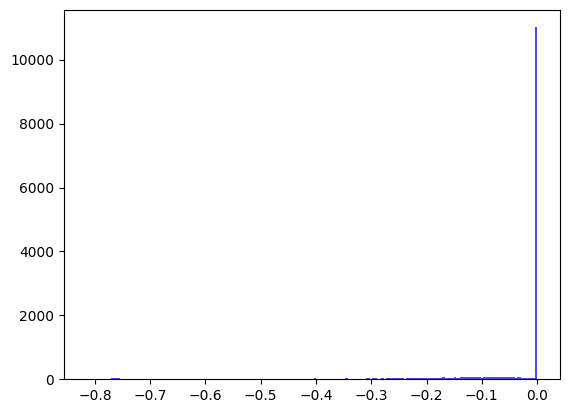

[2024-01-12T16:35:01.238742+00:00] Epochs 83, total loss: 1.35214e+04
[2024-01-12T16:35:01.240959+00:00] Training llk: -6.51500e-01
[2024-01-12T16:35:01.241128+00:00] Testing llk: -5.50218e-01
[2024-01-12T16:35:01.241223+00:00] MAE:0.41592, MRE:1.25359
saving model


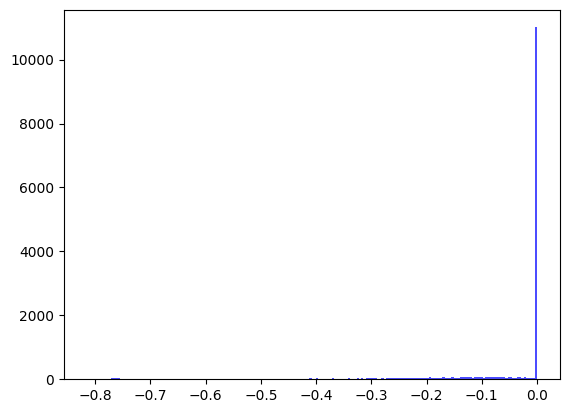

[2024-01-12T16:35:06.546327+00:00] Epochs 84, total loss: 1.35179e+04
[2024-01-12T16:35:06.546624+00:00] Training llk: -6.51425e-01
[2024-01-12T16:35:06.546723+00:00] Testing llk: -5.50173e-01
[2024-01-12T16:35:06.546804+00:00] MAE:0.41632, MRE:1.25289
saving model


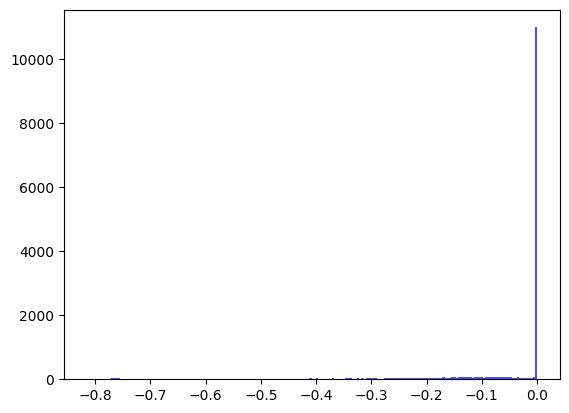

[2024-01-12T16:35:11.517594+00:00] Epochs 85, total loss: 1.35145e+04
[2024-01-12T16:35:11.518759+00:00] Training llk: -6.51353e-01
[2024-01-12T16:35:11.519327+00:00] Testing llk: -5.50131e-01
[2024-01-12T16:35:11.519819+00:00] MAE:0.41669, MRE:1.25221
saving model


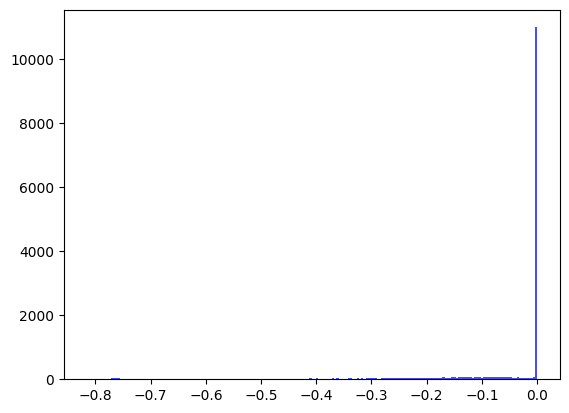

[2024-01-12T16:35:17.919396+00:00] Epochs 86, total loss: 1.35112e+04
[2024-01-12T16:35:17.920704+00:00] Training llk: -6.51285e-01
[2024-01-12T16:35:17.921264+00:00] Testing llk: -5.50092e-01
[2024-01-12T16:35:17.921757+00:00] MAE:0.41704, MRE:1.25155
saving model


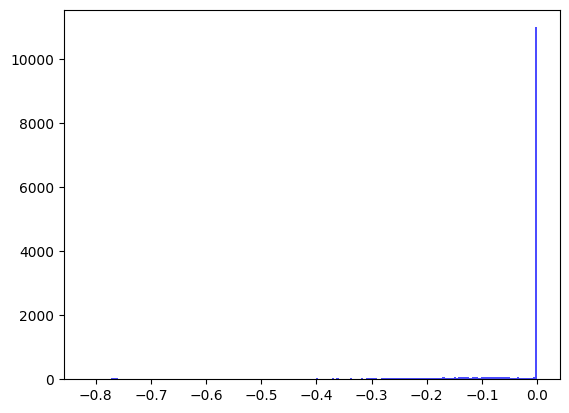

[2024-01-12T16:35:23.031269+00:00] Epochs 87, total loss: 1.35081e+04
[2024-01-12T16:35:23.032527+00:00] Training llk: -6.51220e-01
[2024-01-12T16:35:23.033152+00:00] Testing llk: -5.50055e-01
[2024-01-12T16:35:23.033671+00:00] MAE:0.41738, MRE:1.25091
saving model


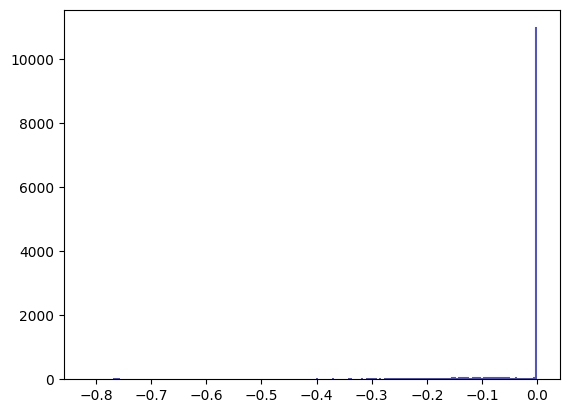

[2024-01-12T16:35:29.092633+00:00] Epochs 88, total loss: 1.35051e+04
[2024-01-12T16:35:29.093971+00:00] Training llk: -6.51158e-01
[2024-01-12T16:35:29.094516+00:00] Testing llk: -5.50021e-01
[2024-01-12T16:35:29.095034+00:00] MAE:0.41770, MRE:1.25030
saving model


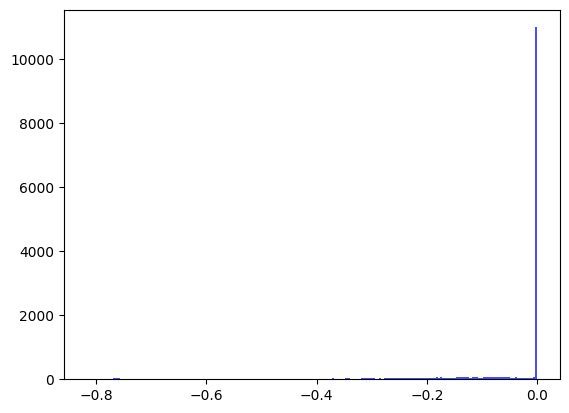

[2024-01-12T16:35:34.168901+00:00] Epochs 89, total loss: 1.35022e+04
[2024-01-12T16:35:34.170103+00:00] Training llk: -6.51099e-01
[2024-01-12T16:35:34.170612+00:00] Testing llk: -5.49990e-01
[2024-01-12T16:35:34.171154+00:00] MAE:0.41801, MRE:1.24971
saving model


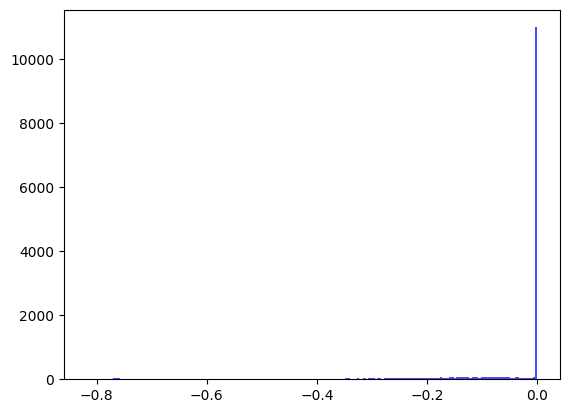

[2024-01-12T16:35:39.347777+00:00] Epochs 90, total loss: 1.34994e+04
[2024-01-12T16:35:39.349476+00:00] Training llk: -6.51043e-01
[2024-01-12T16:35:39.350037+00:00] Testing llk: -5.49961e-01
[2024-01-12T16:35:39.350576+00:00] MAE:0.41830, MRE:1.24915
saving model


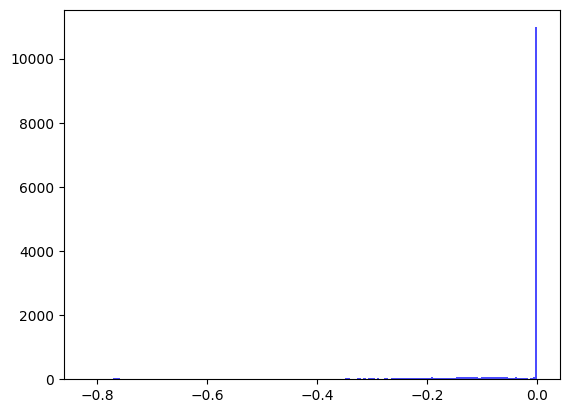

[2024-01-12T16:35:45.583318+00:00] Epochs 91, total loss: 1.34967e+04
[2024-01-12T16:35:45.584588+00:00] Training llk: -6.50991e-01
[2024-01-12T16:35:45.585168+00:00] Testing llk: -5.49934e-01
[2024-01-12T16:35:45.585668+00:00] MAE:0.41859, MRE:1.24861
saving model


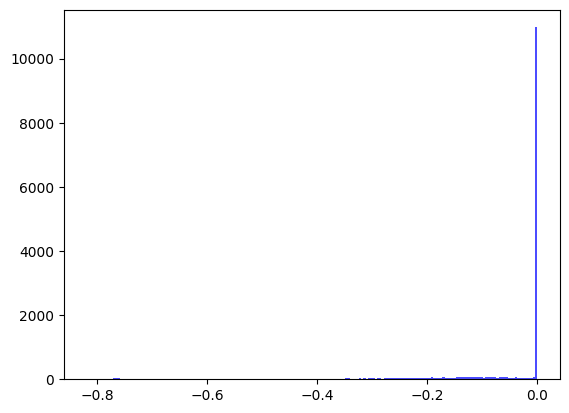

[2024-01-12T16:35:50.646535+00:00] Epochs 92, total loss: 1.34941e+04
[2024-01-12T16:35:50.647864+00:00] Training llk: -6.50941e-01
[2024-01-12T16:35:50.648445+00:00] Testing llk: -5.49910e-01
[2024-01-12T16:35:50.648961+00:00] MAE:0.41885, MRE:1.24810
saving model


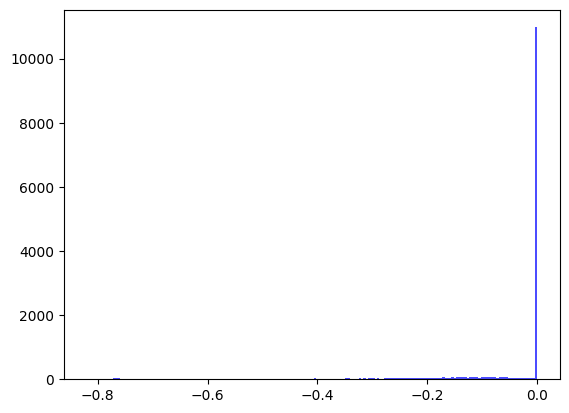

[2024-01-12T16:35:56.819112+00:00] Epochs 93, total loss: 1.34916e+04
[2024-01-12T16:35:56.820399+00:00] Training llk: -6.50893e-01
[2024-01-12T16:35:56.820955+00:00] Testing llk: -5.49887e-01
[2024-01-12T16:35:56.821455+00:00] MAE:0.41911, MRE:1.24761
saving model


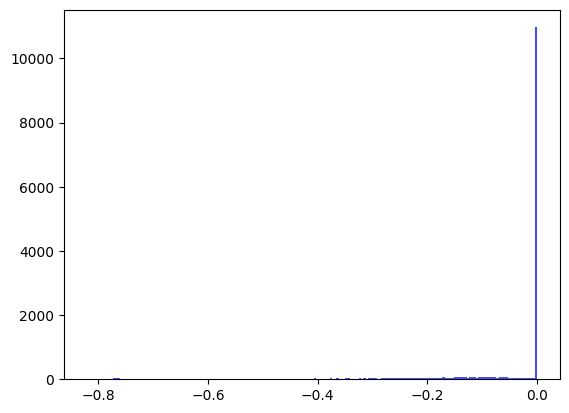

[2024-01-12T16:36:02.000538+00:00] Epochs 94, total loss: 1.34891e+04
[2024-01-12T16:36:02.001782+00:00] Training llk: -6.50849e-01
[2024-01-12T16:36:02.002644+00:00] Testing llk: -5.49866e-01
[2024-01-12T16:36:02.003219+00:00] MAE:0.41936, MRE:1.24715
saving model


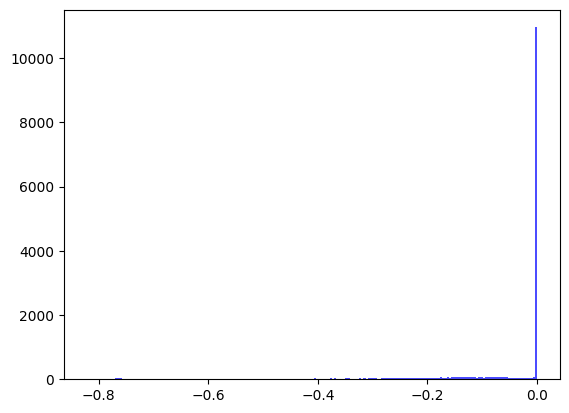

[2024-01-12T16:36:07.696944+00:00] Epochs 95, total loss: 1.34868e+04
[2024-01-12T16:36:07.701376+00:00] Training llk: -6.50807e-01
[2024-01-12T16:36:07.701988+00:00] Testing llk: -5.49847e-01
[2024-01-12T16:36:07.702484+00:00] MAE:0.41960, MRE:1.24671
saving model


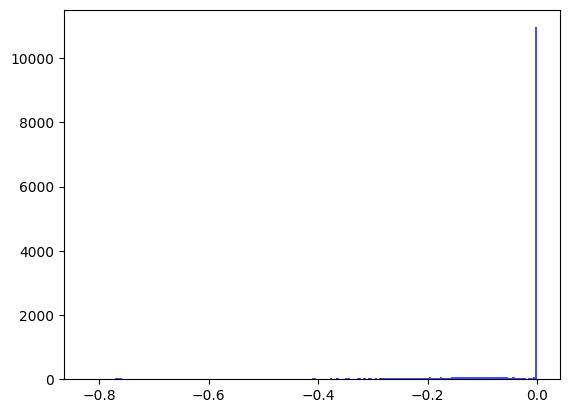

[2024-01-12T16:36:13.505461+00:00] Epochs 96, total loss: 1.34845e+04
[2024-01-12T16:36:13.506735+00:00] Training llk: -6.50768e-01
[2024-01-12T16:36:13.507318+00:00] Testing llk: -5.49830e-01
[2024-01-12T16:36:13.507816+00:00] MAE:0.41983, MRE:1.24629
saving model


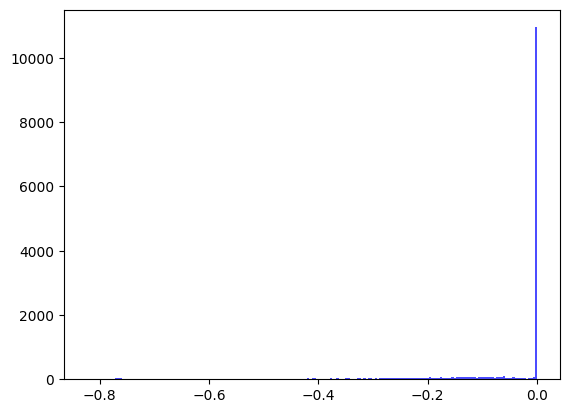

[2024-01-12T16:36:18.630735+00:00] Epochs 97, total loss: 1.34823e+04
[2024-01-12T16:36:18.631933+00:00] Training llk: -6.50731e-01
[2024-01-12T16:36:18.632537+00:00] Testing llk: -5.49814e-01
[2024-01-12T16:36:18.633067+00:00] MAE:0.42005, MRE:1.24590
saving model


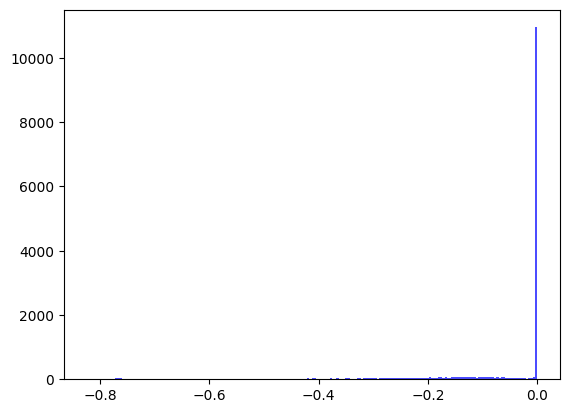

[2024-01-12T16:36:25.425383+00:00] Epochs 98, total loss: 1.34802e+04
[2024-01-12T16:36:25.430373+00:00] Training llk: -6.50696e-01
[2024-01-12T16:36:25.431024+00:00] Testing llk: -5.49800e-01
[2024-01-12T16:36:25.431562+00:00] MAE:0.42026, MRE:1.24554
saving model


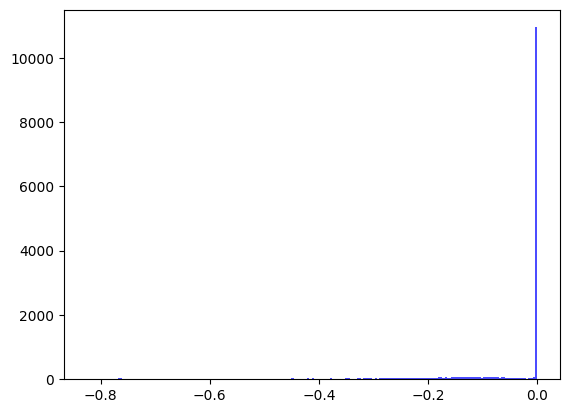

[2024-01-12T16:36:30.895856+00:00] Epochs 99, total loss: 1.34781e+04
[2024-01-12T16:36:30.897127+00:00] Training llk: -6.50664e-01
[2024-01-12T16:36:30.897667+00:00] Testing llk: -5.49787e-01
[2024-01-12T16:36:30.898198+00:00] MAE:0.42047, MRE:1.24520
saving model


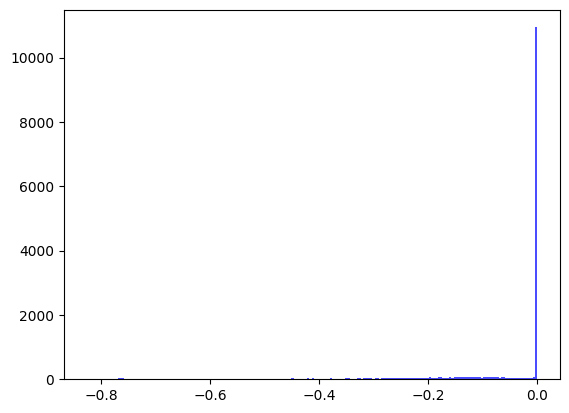

[2024-01-12T16:36:37.318452+00:00] Epochs 100, total loss: 1.34761e+04
[2024-01-12T16:36:37.319674+00:00] Training llk: -6.50634e-01
[2024-01-12T16:36:37.320378+00:00] Testing llk: -5.49775e-01
[2024-01-12T16:36:37.320897+00:00] MAE:0.42066, MRE:1.24488
saving model


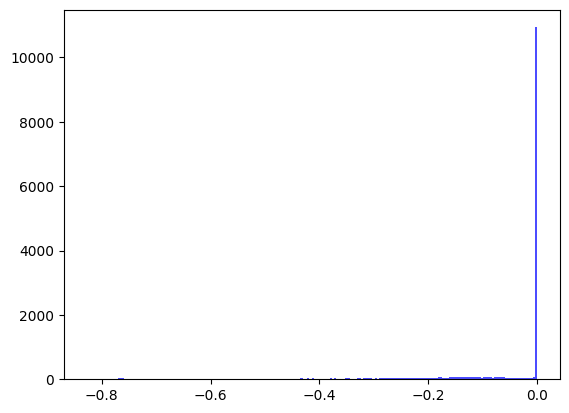

[2024-01-12T16:36:42.456122+00:00] Epochs 101, total loss: 1.34741e+04
[2024-01-12T16:36:42.457245+00:00] Training llk: -6.50606e-01
[2024-01-12T16:36:42.457392+00:00] Testing llk: -5.49765e-01
[2024-01-12T16:36:42.457475+00:00] MAE:0.42086, MRE:1.24458
saving model


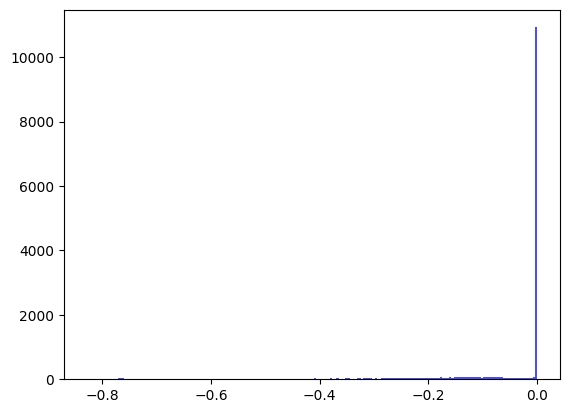

[2024-01-12T16:36:48.091731+00:00] Epochs 102, total loss: 1.34722e+04
[2024-01-12T16:36:48.092984+00:00] Training llk: -6.50580e-01
[2024-01-12T16:36:48.093538+00:00] Testing llk: -5.49755e-01
[2024-01-12T16:36:48.094061+00:00] MAE:0.42104, MRE:1.24431
saving model


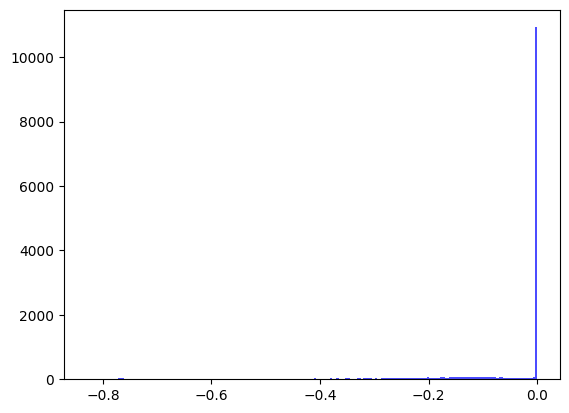

[2024-01-12T16:36:53.570981+00:00] Epochs 103, total loss: 1.34704e+04
[2024-01-12T16:36:53.572212+00:00] Training llk: -6.50556e-01
[2024-01-12T16:36:53.572745+00:00] Testing llk: -5.49747e-01
[2024-01-12T16:36:53.573291+00:00] MAE:0.42122, MRE:1.24406
saving model


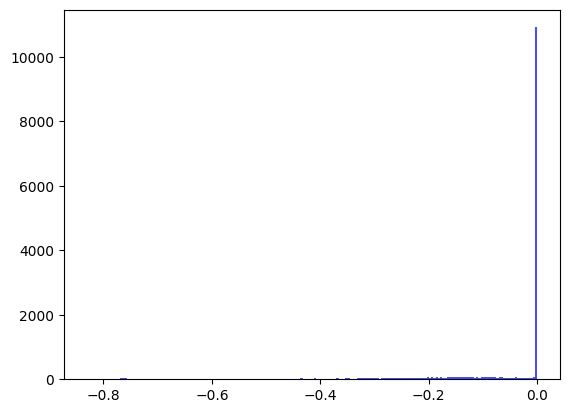

[2024-01-12T16:36:58.668648+00:00] Epochs 104, total loss: 1.34686e+04
[2024-01-12T16:36:58.669932+00:00] Training llk: -6.50534e-01
[2024-01-12T16:36:58.670480+00:00] Testing llk: -5.49740e-01
[2024-01-12T16:36:58.670993+00:00] MAE:0.42139, MRE:1.24383
saving model


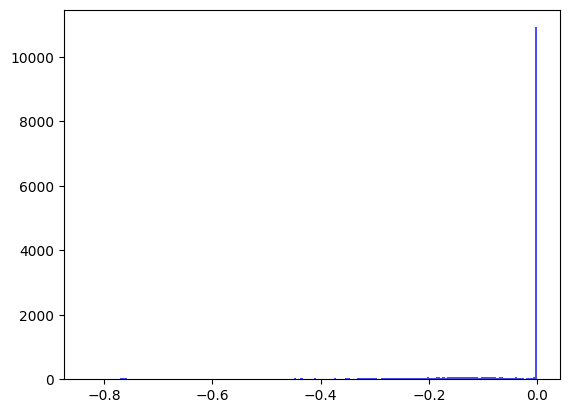

[2024-01-12T16:37:05.095297+00:00] Epochs 105, total loss: 1.34668e+04
[2024-01-12T16:37:05.096552+00:00] Training llk: -6.50514e-01
[2024-01-12T16:37:05.097146+00:00] Testing llk: -5.49734e-01
[2024-01-12T16:37:05.097653+00:00] MAE:0.42156, MRE:1.24362
saving model


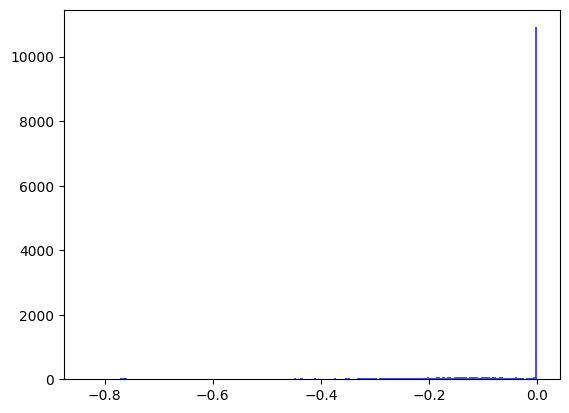

[2024-01-12T16:37:10.097172+00:00] Epochs 106, total loss: 1.34652e+04
[2024-01-12T16:37:10.098487+00:00] Training llk: -6.50496e-01
[2024-01-12T16:37:10.099087+00:00] Testing llk: -5.49728e-01
[2024-01-12T16:37:10.099591+00:00] MAE:0.42172, MRE:1.24344
saving model


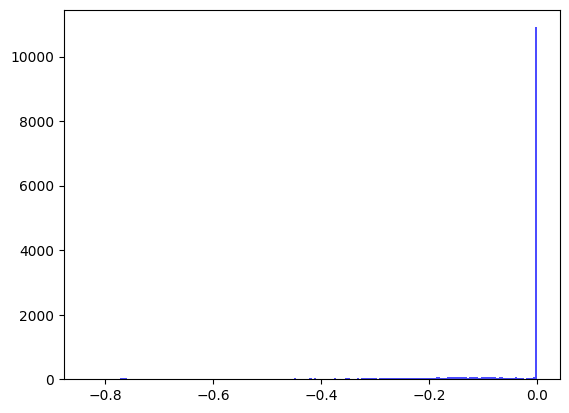

[2024-01-12T16:37:16.121316+00:00] Epochs 107, total loss: 1.34635e+04
[2024-01-12T16:37:16.125693+00:00] Training llk: -6.50479e-01
[2024-01-12T16:37:16.126309+00:00] Testing llk: -5.49724e-01
[2024-01-12T16:37:16.126864+00:00] MAE:0.42187, MRE:1.24327
saving model


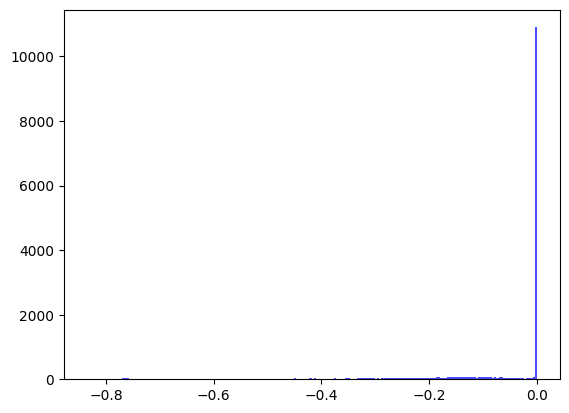

[2024-01-12T16:37:21.278916+00:00] Epochs 108, total loss: 1.34619e+04
[2024-01-12T16:37:21.280265+00:00] Training llk: -6.50465e-01
[2024-01-12T16:37:21.280851+00:00] Testing llk: -5.49720e-01
[2024-01-12T16:37:21.281370+00:00] MAE:0.42202, MRE:1.24313
saving model


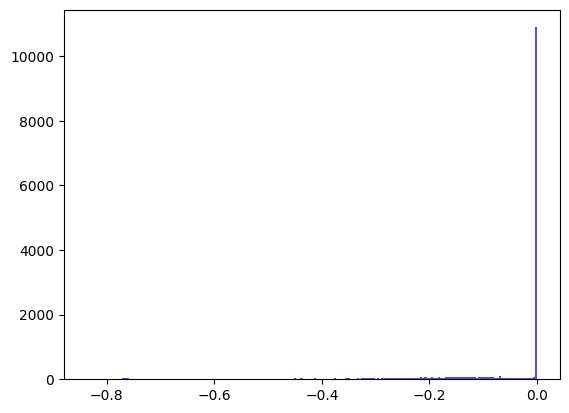

[2024-01-12T16:37:26.245530+00:00] Epochs 109, total loss: 1.34603e+04
[2024-01-12T16:37:26.246684+00:00] Training llk: -6.50452e-01
[2024-01-12T16:37:26.247238+00:00] Testing llk: -5.49717e-01
[2024-01-12T16:37:26.247761+00:00] MAE:0.42217, MRE:1.24300
saving model


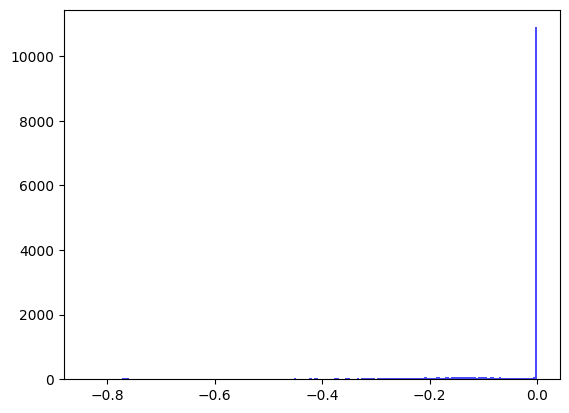

[2024-01-12T16:37:32.597373+00:00] Epochs 110, total loss: 1.34588e+04
[2024-01-12T16:37:32.598630+00:00] Training llk: -6.50440e-01
[2024-01-12T16:37:32.599245+00:00] Testing llk: -5.49715e-01
[2024-01-12T16:37:32.599740+00:00] MAE:0.42231, MRE:1.24290
saving model


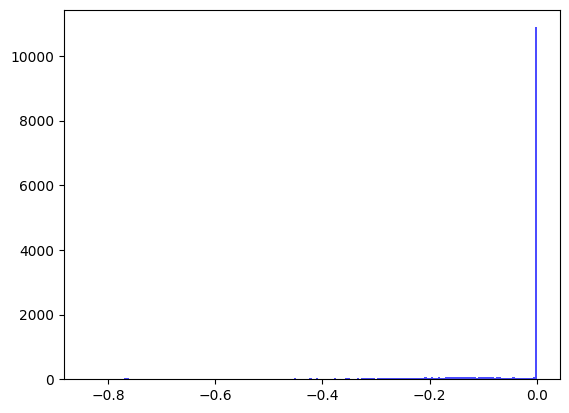

[2024-01-12T16:37:37.700960+00:00] Epochs 111, total loss: 1.34573e+04
[2024-01-12T16:37:37.702325+00:00] Training llk: -6.50431e-01
[2024-01-12T16:37:37.702930+00:00] Testing llk: -5.49713e-01
[2024-01-12T16:37:37.703469+00:00] MAE:0.42245, MRE:1.24281
saving model


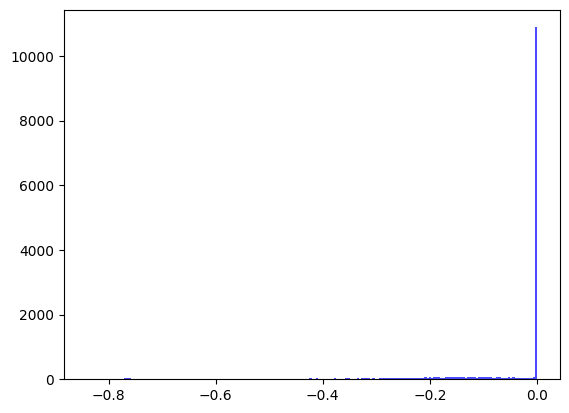

[2024-01-12T16:37:43.941632+00:00] Epochs 112, total loss: 1.34558e+04
[2024-01-12T16:37:43.942916+00:00] Training llk: -6.50422e-01
[2024-01-12T16:37:43.943501+00:00] Testing llk: -5.49712e-01
[2024-01-12T16:37:43.944022+00:00] MAE:0.42259, MRE:1.24275
saving model


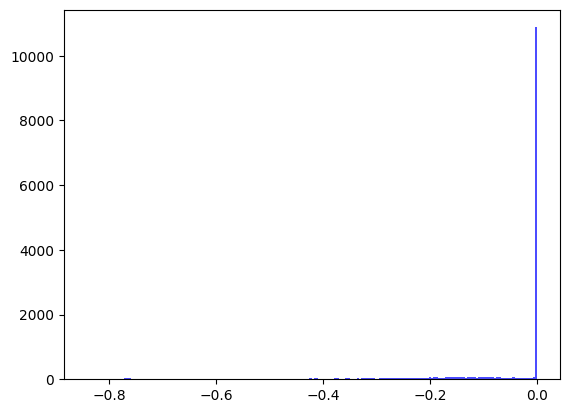

[2024-01-12T16:37:49.066215+00:00] Epochs 113, total loss: 1.34544e+04
[2024-01-12T16:37:49.067539+00:00] Training llk: -6.50416e-01
[2024-01-12T16:37:49.068130+00:00] Testing llk: -5.49711e-01
[2024-01-12T16:37:49.068649+00:00] MAE:0.42272, MRE:1.24270
saving model


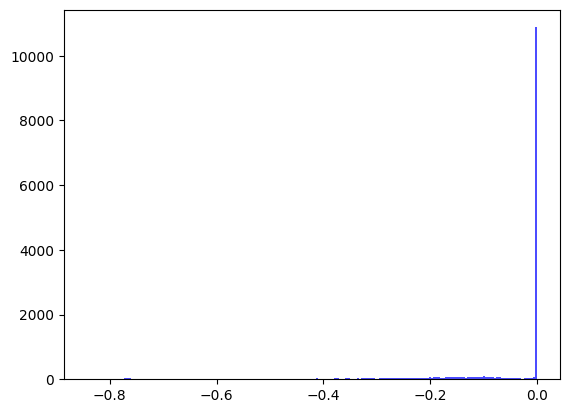

[2024-01-12T16:37:54.895719+00:00] Epochs 114, total loss: 1.34530e+04
[2024-01-12T16:37:54.900192+00:00] Training llk: -6.50410e-01
[2024-01-12T16:37:54.900724+00:00] Testing llk: -5.49712e-01
[2024-01-12T16:37:54.901261+00:00] MAE:0.42285, MRE:1.24267
saving model


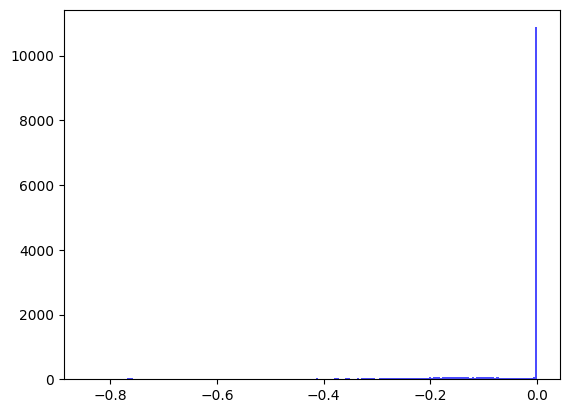

[2024-01-12T16:38:00.662503+00:00] Epochs 115, total loss: 1.34516e+04
[2024-01-12T16:38:00.663710+00:00] Training llk: -6.50406e-01
[2024-01-12T16:38:00.664276+00:00] Testing llk: -5.49712e-01
[2024-01-12T16:38:00.664766+00:00] MAE:0.42297, MRE:1.24266
saving model


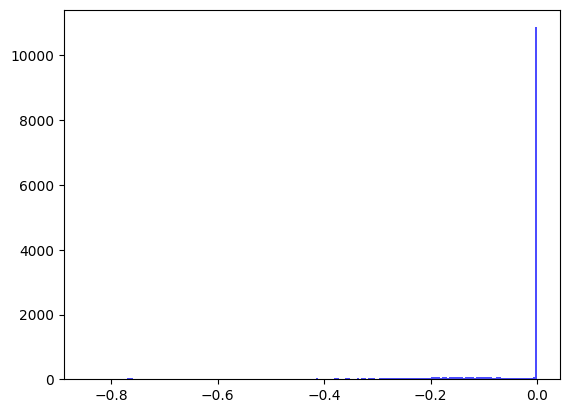

[2024-01-12T16:38:05.727393+00:00] Epochs 116, total loss: 1.34503e+04
[2024-01-12T16:38:05.728913+00:00] Training llk: -6.50404e-01
[2024-01-12T16:38:05.729640+00:00] Testing llk: -5.49714e-01
[2024-01-12T16:38:05.730272+00:00] MAE:0.42309, MRE:1.24266
saving model


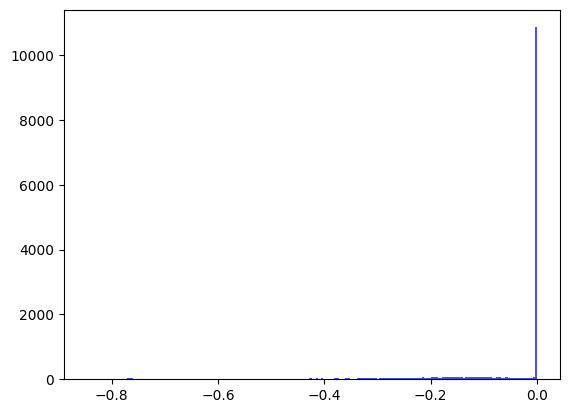

[2024-01-12T16:38:11.877409+00:00] Epochs 117, total loss: 1.34490e+04
[2024-01-12T16:38:11.878872+00:00] Training llk: -6.50402e-01
[2024-01-12T16:38:11.879538+00:00] Testing llk: -5.49715e-01
[2024-01-12T16:38:11.880119+00:00] MAE:0.42321, MRE:1.24268
saving model


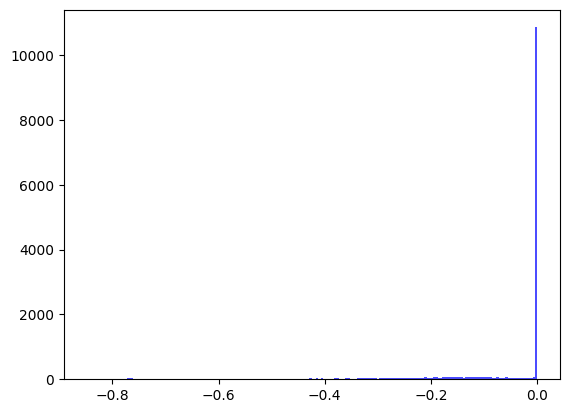

[2024-01-12T16:38:16.895058+00:00] Epochs 118, total loss: 1.34477e+04
[2024-01-12T16:38:16.896260+00:00] Training llk: -6.50402e-01
[2024-01-12T16:38:16.896856+00:00] Testing llk: -5.49718e-01
[2024-01-12T16:38:16.897378+00:00] MAE:0.42333, MRE:1.24272
saving model


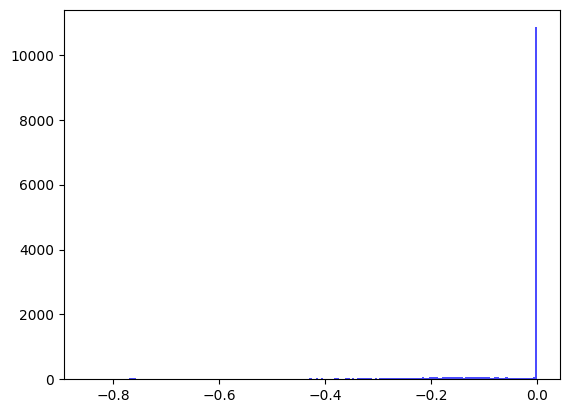

[2024-01-12T16:38:23.228144+00:00] Epochs 119, total loss: 1.34464e+04
[2024-01-12T16:38:23.231991+00:00] Training llk: -6.50404e-01
[2024-01-12T16:38:23.232173+00:00] Testing llk: -5.49720e-01
[2024-01-12T16:38:23.233504+00:00] MAE:0.42345, MRE:1.24277
saving model


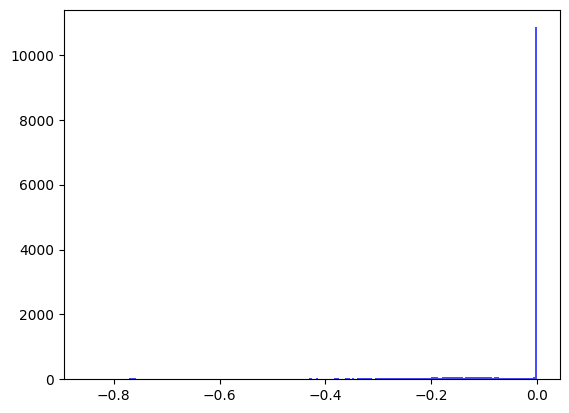

[2024-01-12T16:38:28.391623+00:00] Epochs 120, total loss: 1.34452e+04
[2024-01-12T16:38:28.392850+00:00] Training llk: -6.50406e-01
[2024-01-12T16:38:28.393421+00:00] Testing llk: -5.49724e-01
[2024-01-12T16:38:28.393952+00:00] MAE:0.42356, MRE:1.24284
saving model


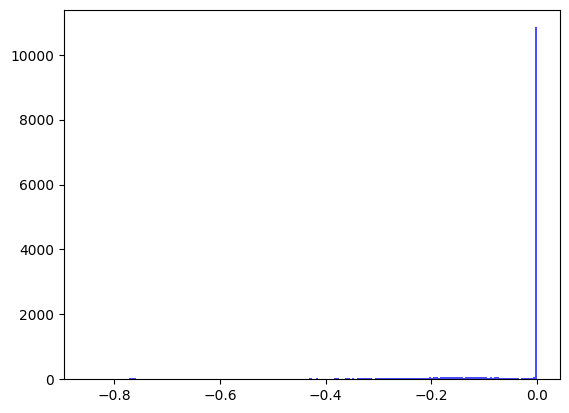

[2024-01-12T16:38:33.403483+00:00] Epochs 121, total loss: 1.34440e+04
[2024-01-12T16:38:33.404648+00:00] Training llk: -6.50410e-01
[2024-01-12T16:38:33.405179+00:00] Testing llk: -5.49728e-01
[2024-01-12T16:38:33.405681+00:00] MAE:0.42367, MRE:1.24292
saving model


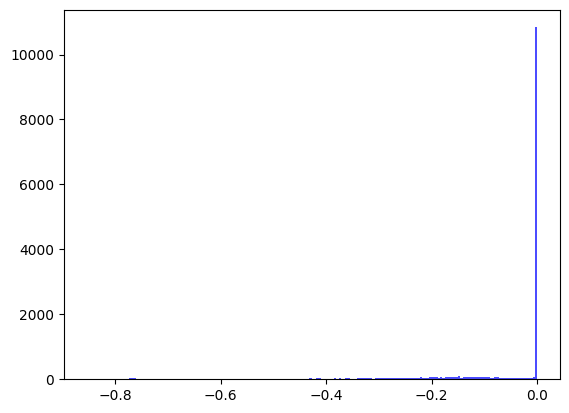

[2024-01-12T16:38:39.534313+00:00] Epochs 122, total loss: 1.34428e+04
[2024-01-12T16:38:39.535717+00:00] Training llk: -6.50415e-01
[2024-01-12T16:38:39.536302+00:00] Testing llk: -5.49732e-01
[2024-01-12T16:38:39.536904+00:00] MAE:0.42377, MRE:1.24302
saving model


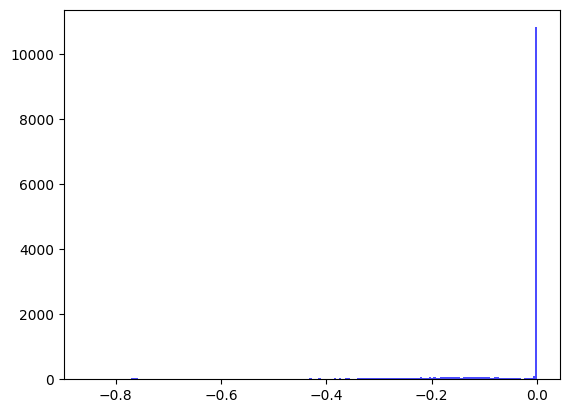

[2024-01-12T16:38:44.883107+00:00] Epochs 123, total loss: 1.34416e+04
[2024-01-12T16:38:44.884304+00:00] Training llk: -6.50421e-01
[2024-01-12T16:38:44.884852+00:00] Testing llk: -5.49736e-01
[2024-01-12T16:38:44.885365+00:00] MAE:0.42388, MRE:1.24314
saving model


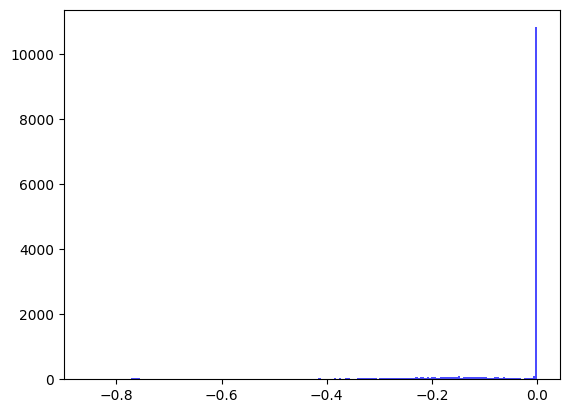

[2024-01-12T16:38:50.975652+00:00] Epochs 124, total loss: 1.34405e+04
[2024-01-12T16:38:50.976916+00:00] Training llk: -6.50428e-01
[2024-01-12T16:38:50.977461+00:00] Testing llk: -5.49742e-01
[2024-01-12T16:38:50.977988+00:00] MAE:0.42398, MRE:1.24327
saving model


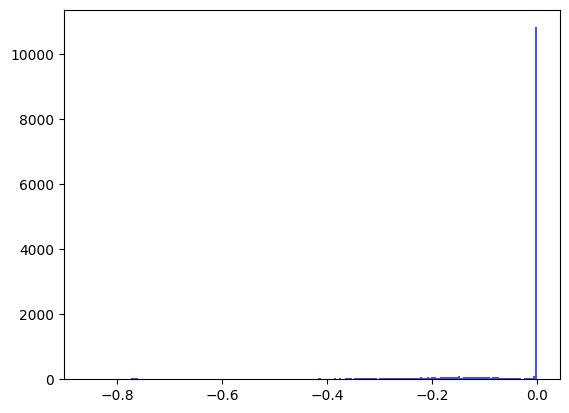

[2024-01-12T16:38:56.166263+00:00] Epochs 125, total loss: 1.34394e+04
[2024-01-12T16:38:56.167415+00:00] Training llk: -6.50437e-01
[2024-01-12T16:38:56.167977+00:00] Testing llk: -5.49747e-01
[2024-01-12T16:38:56.168467+00:00] MAE:0.42409, MRE:1.24341
saving model


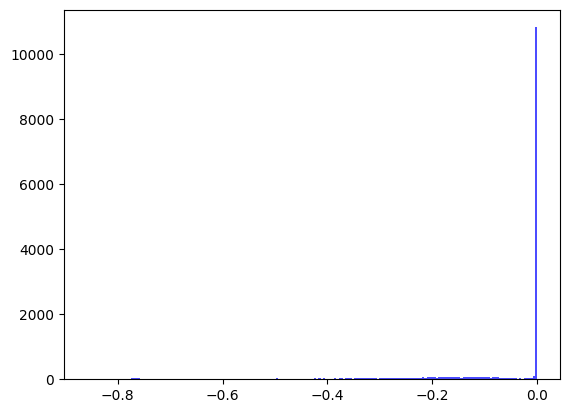

[2024-01-12T16:39:01.397950+00:00] Epochs 126, total loss: 1.34382e+04
[2024-01-12T16:39:01.399074+00:00] Training llk: -6.50446e-01
[2024-01-12T16:39:01.399580+00:00] Testing llk: -5.49754e-01
[2024-01-12T16:39:01.400083+00:00] MAE:0.42419, MRE:1.24357
saving model


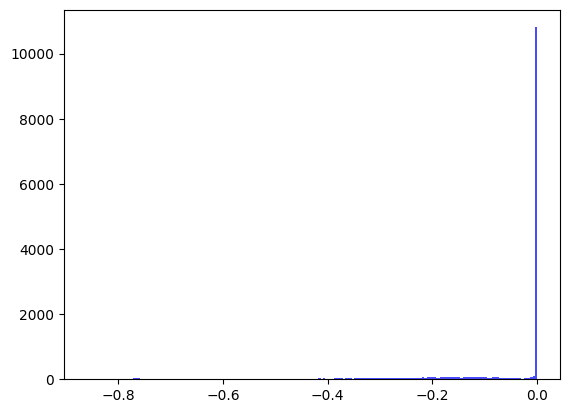

[2024-01-12T16:39:07.209747+00:00] Epochs 127, total loss: 1.34371e+04
[2024-01-12T16:39:07.210955+00:00] Training llk: -6.50457e-01
[2024-01-12T16:39:07.211490+00:00] Testing llk: -5.49761e-01
[2024-01-12T16:39:07.212001+00:00] MAE:0.42428, MRE:1.24374
saving model


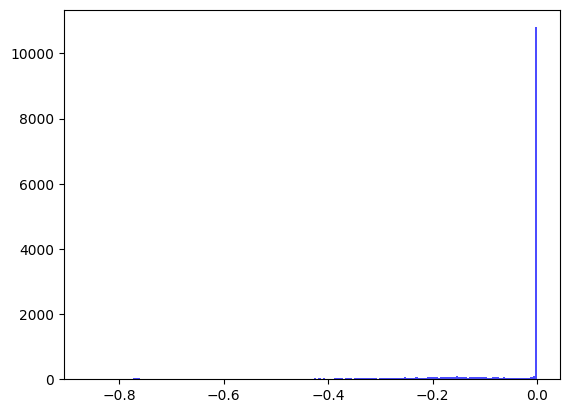

[2024-01-12T16:39:12.669042+00:00] Epochs 128, total loss: 1.34361e+04
[2024-01-12T16:39:12.670278+00:00] Training llk: -6.50469e-01
[2024-01-12T16:39:12.670806+00:00] Testing llk: -5.49768e-01
[2024-01-12T16:39:12.671329+00:00] MAE:0.42438, MRE:1.24393
saving model


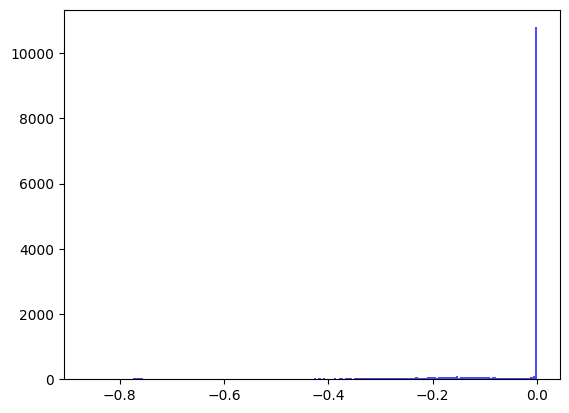

[2024-01-12T16:39:18.782005+00:00] Epochs 129, total loss: 1.34350e+04
[2024-01-12T16:39:18.783206+00:00] Training llk: -6.50482e-01
[2024-01-12T16:39:18.783732+00:00] Testing llk: -5.49777e-01
[2024-01-12T16:39:18.784255+00:00] MAE:0.42447, MRE:1.24413
saving model


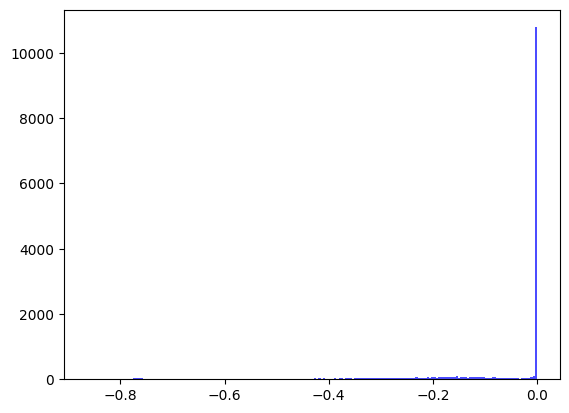

[2024-01-12T16:39:23.813137+00:00] Epochs 130, total loss: 1.34339e+04
[2024-01-12T16:39:23.814552+00:00] Training llk: -6.50496e-01
[2024-01-12T16:39:23.815286+00:00] Testing llk: -5.49786e-01
[2024-01-12T16:39:23.815933+00:00] MAE:0.42456, MRE:1.24435
saving model


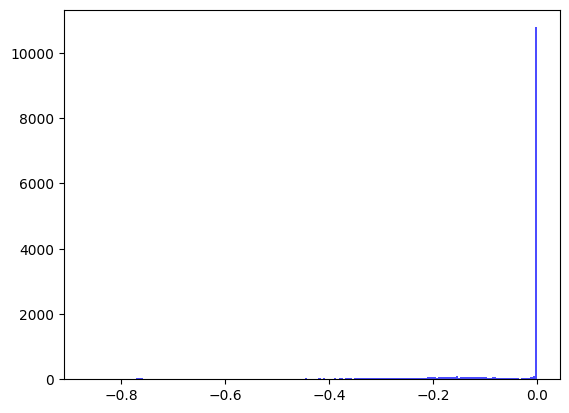

[2024-01-12T16:39:29.436369+00:00] Epochs 131, total loss: 1.34329e+04
[2024-01-12T16:39:29.437529+00:00] Training llk: -6.50511e-01
[2024-01-12T16:39:29.438054+00:00] Testing llk: -5.49796e-01
[2024-01-12T16:39:29.438525+00:00] MAE:0.42465, MRE:1.24459
saving model


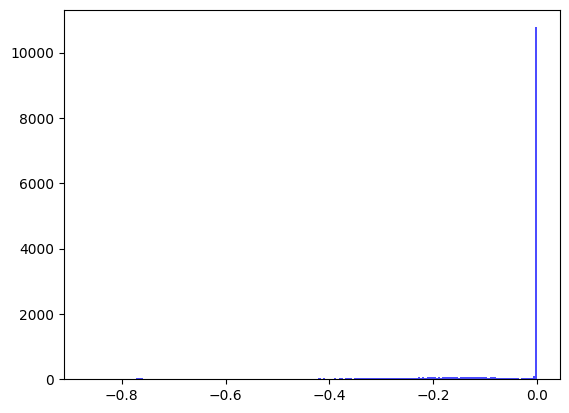

[2024-01-12T16:39:34.831993+00:00] Epochs 132, total loss: 1.34319e+04
[2024-01-12T16:39:34.833206+00:00] Training llk: -6.50528e-01
[2024-01-12T16:39:34.833777+00:00] Testing llk: -5.49807e-01
[2024-01-12T16:39:34.834354+00:00] MAE:0.42473, MRE:1.24484
saving model


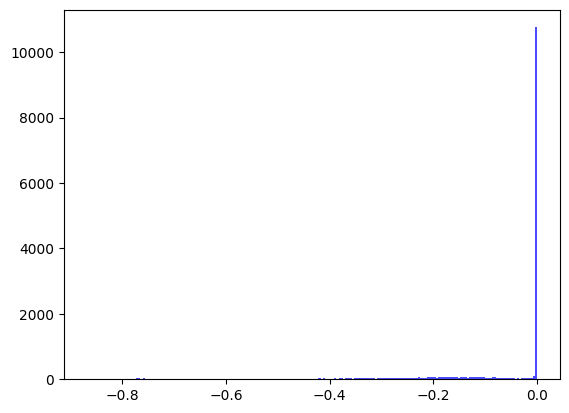

[2024-01-12T16:39:40.117737+00:00] Epochs 133, total loss: 1.34308e+04
[2024-01-12T16:39:40.118974+00:00] Training llk: -6.50547e-01
[2024-01-12T16:39:40.119521+00:00] Testing llk: -5.49821e-01
[2024-01-12T16:39:40.120033+00:00] MAE:0.42480, MRE:1.24512
saving model


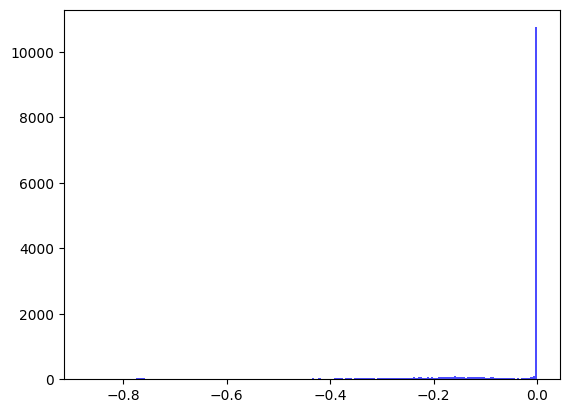

[2024-01-12T16:39:46.225345+00:00] Epochs 134, total loss: 1.34298e+04
[2024-01-12T16:39:46.226730+00:00] Training llk: -6.50567e-01
[2024-01-12T16:39:46.227398+00:00] Testing llk: -5.49837e-01
[2024-01-12T16:39:46.228020+00:00] MAE:0.42487, MRE:1.24542
saving model


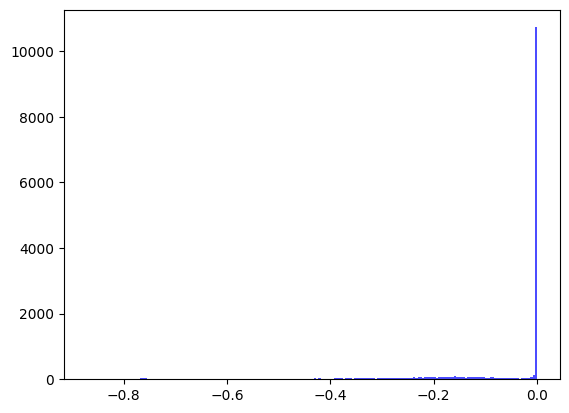

[2024-01-12T16:39:51.208312+00:00] Epochs 135, total loss: 1.34287e+04
[2024-01-12T16:39:51.209837+00:00] Training llk: -6.50590e-01
[2024-01-12T16:39:51.210524+00:00] Testing llk: -5.49857e-01
[2024-01-12T16:39:51.211190+00:00] MAE:0.42491, MRE:1.24574
saving model


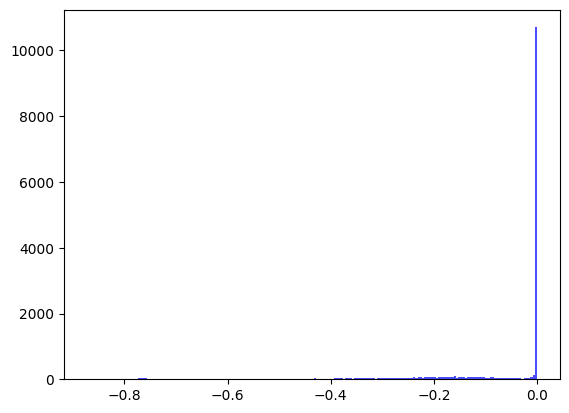

[2024-01-12T16:39:57.249820+00:00] Epochs 136, total loss: 1.34276e+04
[2024-01-12T16:39:57.250137+00:00] Training llk: -6.50617e-01
[2024-01-12T16:39:57.250243+00:00] Testing llk: -5.49885e-01
[2024-01-12T16:39:57.250322+00:00] MAE:0.42493, MRE:1.24610
saving model


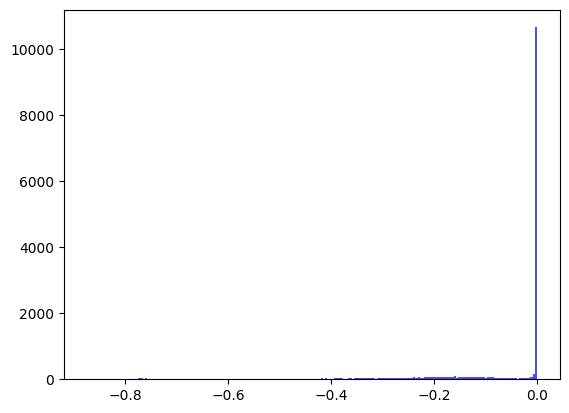

[2024-01-12T16:40:02.477868+00:00] Epochs 137, total loss: 1.34265e+04
[2024-01-12T16:40:02.479136+00:00] Training llk: -6.50651e-01
[2024-01-12T16:40:02.479727+00:00] Testing llk: -5.49925e-01
[2024-01-12T16:40:02.480247+00:00] MAE:0.42488, MRE:1.24648
saving model


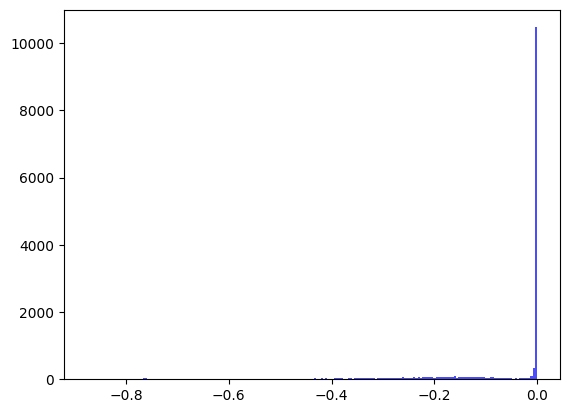

[2024-01-12T16:40:07.942298+00:00] Epochs 138, total loss: 1.34252e+04
[2024-01-12T16:40:07.946936+00:00] Training llk: -6.50696e-01
[2024-01-12T16:40:07.947474+00:00] Testing llk: -5.49994e-01
[2024-01-12T16:40:07.948112+00:00] MAE:0.42468, MRE:1.24687
saving model


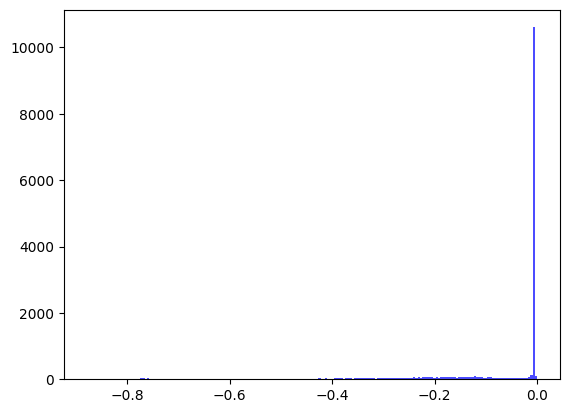

[2024-01-12T16:40:13.932195+00:00] Epochs 139, total loss: 1.34237e+04
[2024-01-12T16:40:13.933405+00:00] Training llk: -6.50770e-01
[2024-01-12T16:40:13.933963+00:00] Testing llk: -5.50129e-01
[2024-01-12T16:40:13.934482+00:00] MAE:0.42414, MRE:1.24717
saving model


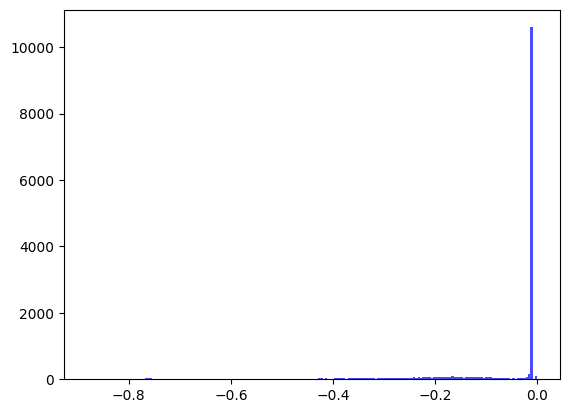

[2024-01-12T16:40:18.951243+00:00] Epochs 140, total loss: 1.34217e+04
[2024-01-12T16:40:18.956639+00:00] Training llk: -6.50908e-01
[2024-01-12T16:40:18.957323+00:00] Testing llk: -5.50416e-01
[2024-01-12T16:40:18.957923+00:00] MAE:0.42285, MRE:1.24704
saving model


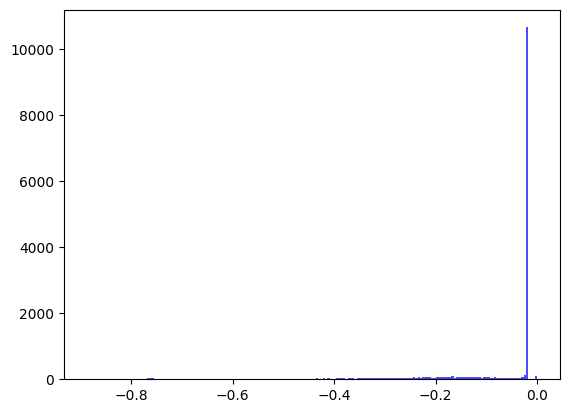

[2024-01-12T16:40:24.955047+00:00] Epochs 141, total loss: 1.34188e+04
[2024-01-12T16:40:24.955349+00:00] Training llk: -6.51167e-01
[2024-01-12T16:40:24.955457+00:00] Testing llk: -5.50957e-01
[2024-01-12T16:40:24.955543+00:00] MAE:0.42056, MRE:1.24624
saving model


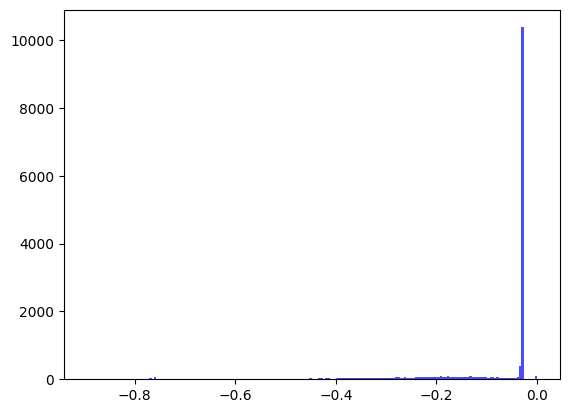

[2024-01-12T16:40:30.482178+00:00] Epochs 142, total loss: 1.34145e+04
[2024-01-12T16:40:30.482467+00:00] Training llk: -6.51565e-01
[2024-01-12T16:40:30.482568+00:00] Testing llk: -5.51684e-01
[2024-01-12T16:40:30.482648+00:00] MAE:0.41815, MRE:1.24637
saving model


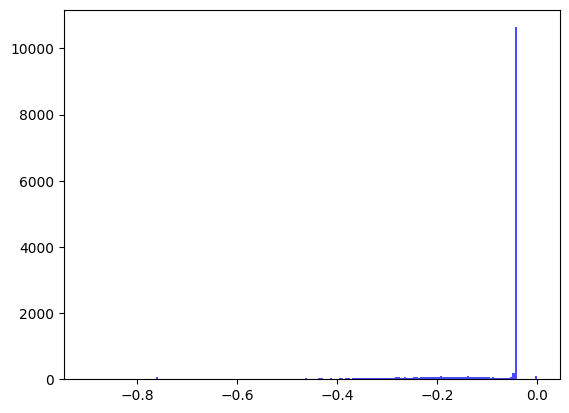

[2024-01-12T16:40:36.893528+00:00] Epochs 143, total loss: 1.34084e+04
[2024-01-12T16:40:36.894862+00:00] Training llk: -6.52094e-01
[2024-01-12T16:40:36.895496+00:00] Testing llk: -5.52483e-01
[2024-01-12T16:40:36.896115+00:00] MAE:0.41637, MRE:1.24935
saving model


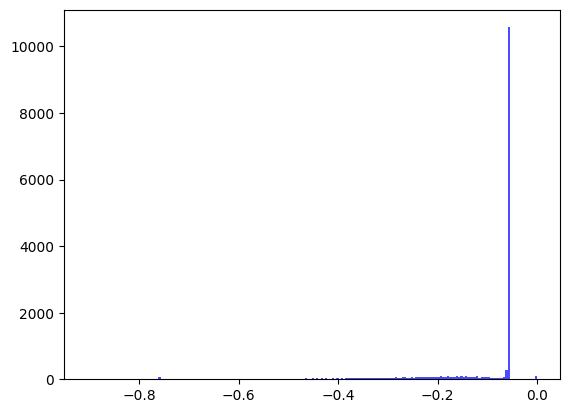

[2024-01-12T16:40:43.150077+00:00] Epochs 144, total loss: 1.33999e+04
[2024-01-12T16:40:43.151301+00:00] Training llk: -6.52795e-01
[2024-01-12T16:40:43.151850+00:00] Testing llk: -5.53424e-01
[2024-01-12T16:40:43.152378+00:00] MAE:0.41478, MRE:1.25447
saving model


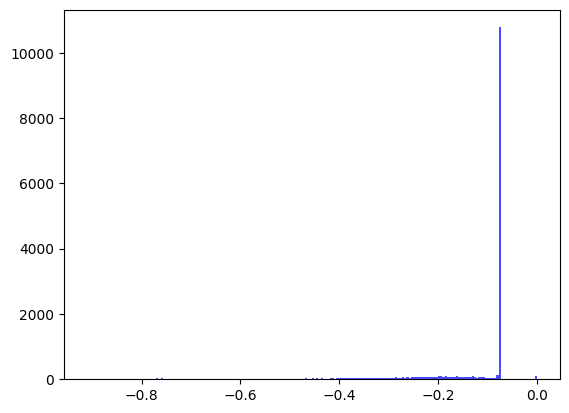

[2024-01-12T16:40:48.223405+00:00] Epochs 145, total loss: 1.33868e+04
[2024-01-12T16:40:48.224661+00:00] Training llk: -6.53762e-01
[2024-01-12T16:40:48.225242+00:00] Testing llk: -5.54639e-01
[2024-01-12T16:40:48.225724+00:00] MAE:0.41296, MRE:1.26164
saving model


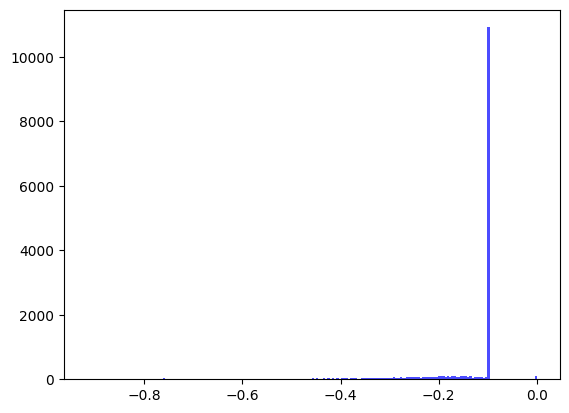

[2024-01-12T16:40:54.558632+00:00] Epochs 146, total loss: 1.33650e+04
[2024-01-12T16:40:54.561988+00:00] Training llk: -6.55126e-01
[2024-01-12T16:40:54.562351+00:00] Testing llk: -5.56224e-01
[2024-01-12T16:40:54.562481+00:00] MAE:0.41073, MRE:1.27198
saving model


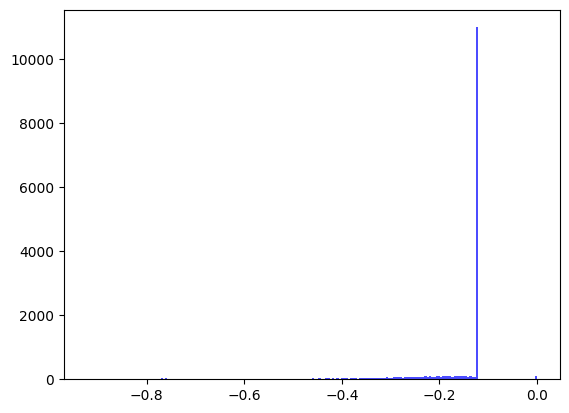

[2024-01-12T16:40:59.790644+00:00] Epochs 147, total loss: 1.33277e+04
[2024-01-12T16:40:59.791810+00:00] Training llk: -6.56924e-01
[2024-01-12T16:40:59.792358+00:00] Testing llk: -5.57988e-01
[2024-01-12T16:40:59.792850+00:00] MAE:0.40858, MRE:1.28748
saving model


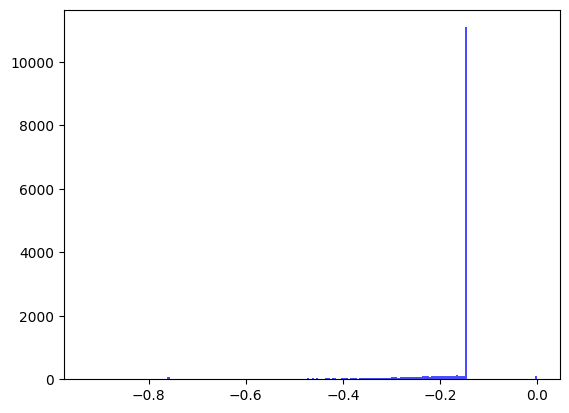

[2024-01-12T16:41:05.110857+00:00] Epochs 148, total loss: 1.32683e+04
[2024-01-12T16:41:05.112001+00:00] Training llk: -6.58756e-01
[2024-01-12T16:41:05.112511+00:00] Testing llk: -5.59032e-01
[2024-01-12T16:41:05.113004+00:00] MAE:0.40821, MRE:1.30958
saving model


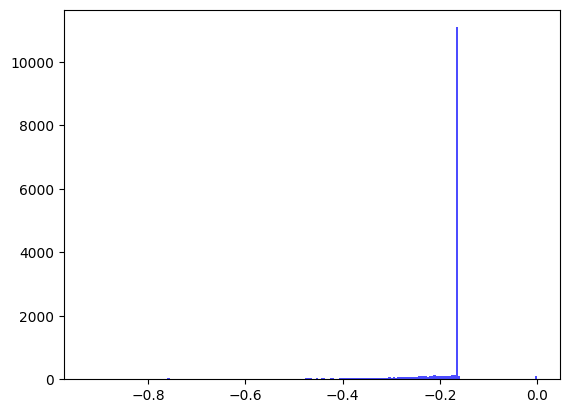

[2024-01-12T16:41:11.024537+00:00] Epochs 149, total loss: 1.31907e+04
[2024-01-12T16:41:11.025768+00:00] Training llk: -6.59883e-01
[2024-01-12T16:41:11.026345+00:00] Testing llk: -5.58408e-01
[2024-01-12T16:41:11.026870+00:00] MAE:0.41087, MRE:1.33569
saving model


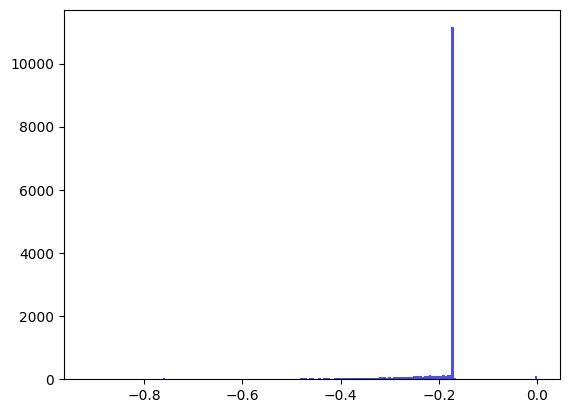

[2024-01-12T16:41:16.196071+00:00] Epochs 150, total loss: 1.31089e+04
[2024-01-12T16:41:16.197216+00:00] Training llk: -6.60067e-01
[2024-01-12T16:41:16.197770+00:00] Testing llk: -5.56474e-01
[2024-01-12T16:41:16.198334+00:00] MAE:0.41516, MRE:1.35910
saving model


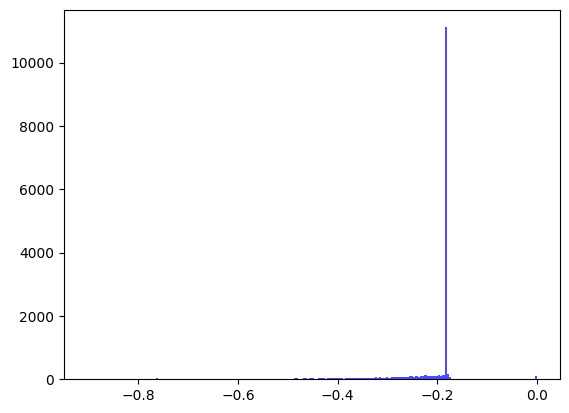

[2024-01-12T16:41:22.241252+00:00] Epochs 151, total loss: 1.30324e+04
[2024-01-12T16:41:22.242685+00:00] Training llk: -6.59619e-01
[2024-01-12T16:41:22.243371+00:00] Testing llk: -5.54077e-01
[2024-01-12T16:41:22.243984+00:00] MAE:0.41942, MRE:1.37564
saving model


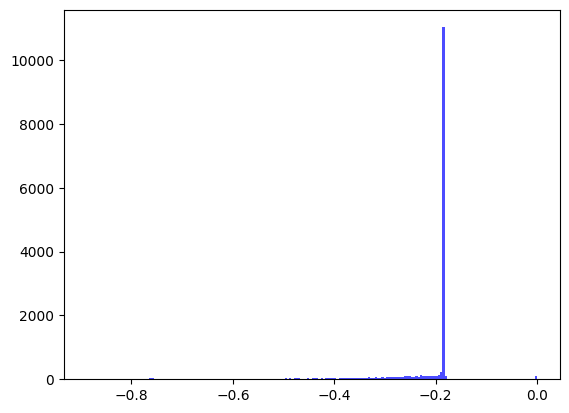

[2024-01-12T16:41:27.624879+00:00] Epochs 152, total loss: 1.29637e+04
[2024-01-12T16:41:27.626347+00:00] Training llk: -6.58896e-01
[2024-01-12T16:41:27.627036+00:00] Testing llk: -5.51646e-01
[2024-01-12T16:41:27.627629+00:00] MAE:0.42331, MRE:1.38639
saving model


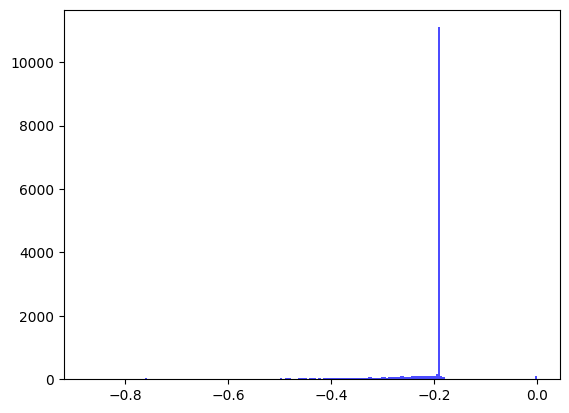

[2024-01-12T16:41:33.556042+00:00] Epochs 153, total loss: 1.29030e+04
[2024-01-12T16:41:33.557193+00:00] Training llk: -6.58081e-01
[2024-01-12T16:41:33.557707+00:00] Testing llk: -5.49327e-01
[2024-01-12T16:41:33.558208+00:00] MAE:0.42685, MRE:1.39336
saving model


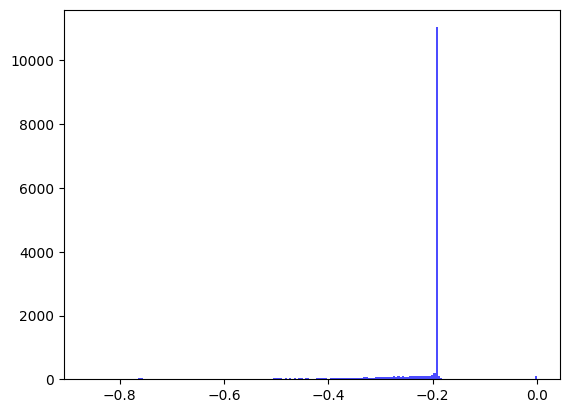

[2024-01-12T16:41:38.984183+00:00] Epochs 154, total loss: 1.28496e+04
[2024-01-12T16:41:38.985412+00:00] Training llk: -6.57249e-01
[2024-01-12T16:41:38.985972+00:00] Testing llk: -5.47183e-01
[2024-01-12T16:41:38.986464+00:00] MAE:0.42998, MRE:1.39763
saving model


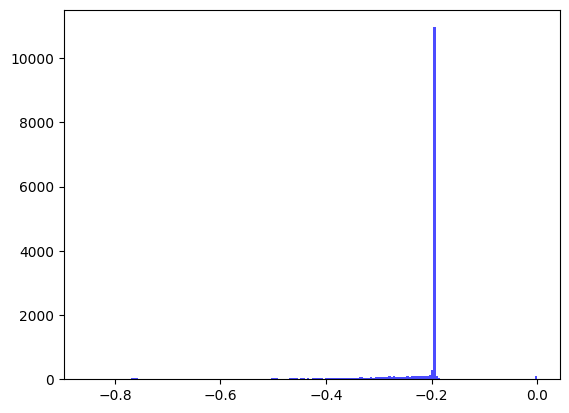

[2024-01-12T16:41:43.988899+00:00] Epochs 155, total loss: 1.28025e+04
[2024-01-12T16:41:43.989200+00:00] Training llk: -6.56426e-01
[2024-01-12T16:41:43.989316+00:00] Testing llk: -5.45231e-01
[2024-01-12T16:41:43.989402+00:00] MAE:0.43265, MRE:1.39974
saving model


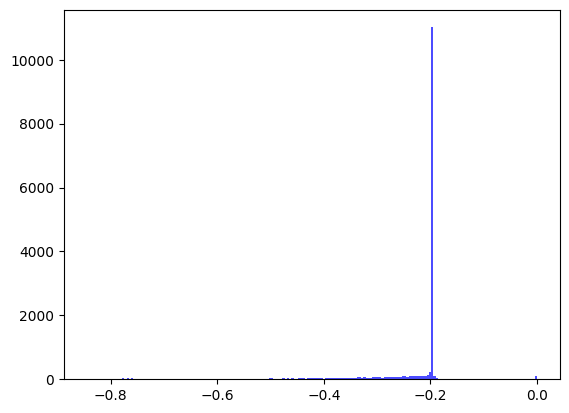

[2024-01-12T16:41:50.438504+00:00] Epochs 156, total loss: 1.27605e+04
[2024-01-12T16:41:50.438776+00:00] Training llk: -6.55624e-01
[2024-01-12T16:41:50.438882+00:00] Testing llk: -5.43465e-01
[2024-01-12T16:41:50.438964+00:00] MAE:0.43487, MRE:1.40014
saving model


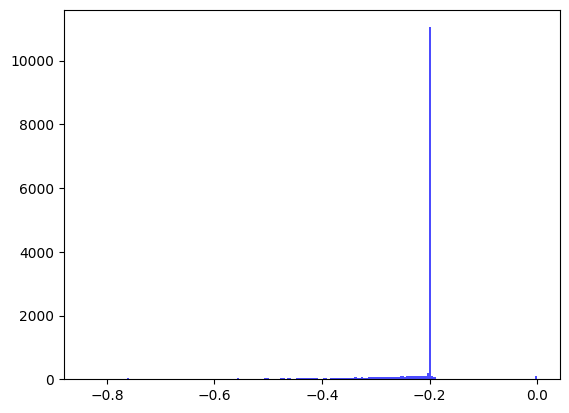

[2024-01-12T16:41:55.470935+00:00] Epochs 157, total loss: 1.27228e+04
[2024-01-12T16:41:55.472207+00:00] Training llk: -6.54844e-01
[2024-01-12T16:41:55.472783+00:00] Testing llk: -5.41863e-01
[2024-01-12T16:41:55.473330+00:00] MAE:0.43665, MRE:1.39920
saving model


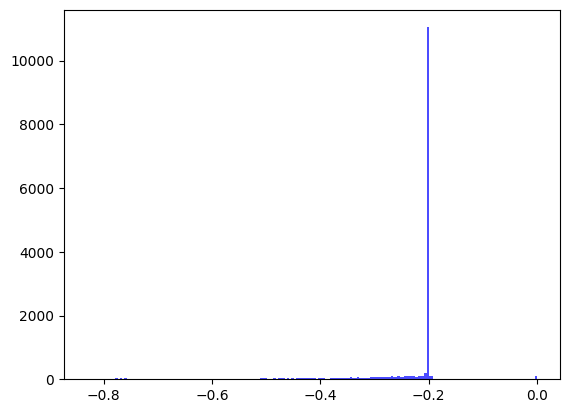

[2024-01-12T16:42:01.679175+00:00] Epochs 158, total loss: 1.26885e+04
[2024-01-12T16:42:01.680436+00:00] Training llk: -6.54089e-01
[2024-01-12T16:42:01.681026+00:00] Testing llk: -5.40405e-01
[2024-01-12T16:42:01.681527+00:00] MAE:0.43804, MRE:1.39720
saving model


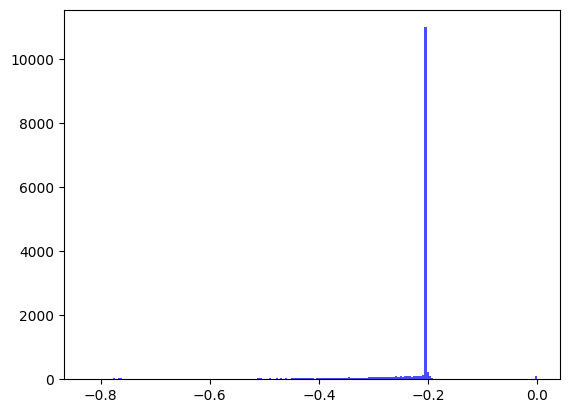

[2024-01-12T16:42:06.866497+00:00] Epochs 159, total loss: 1.26570e+04
[2024-01-12T16:42:06.867723+00:00] Training llk: -6.53357e-01
[2024-01-12T16:42:06.868315+00:00] Testing llk: -5.39070e-01
[2024-01-12T16:42:06.868812+00:00] MAE:0.43909, MRE:1.39441
saving model


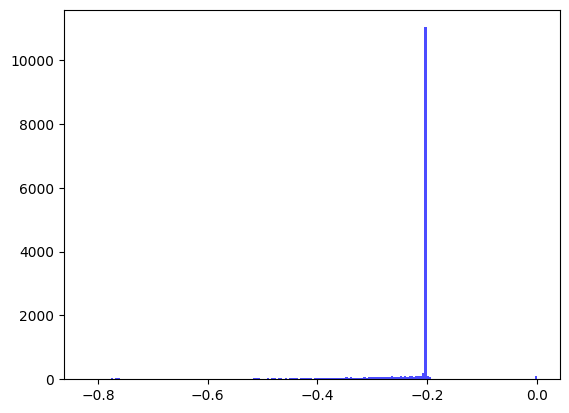

[2024-01-12T16:42:12.010712+00:00] Epochs 160, total loss: 1.26279e+04
[2024-01-12T16:42:12.011877+00:00] Training llk: -6.52647e-01
[2024-01-12T16:42:12.012388+00:00] Testing llk: -5.37840e-01
[2024-01-12T16:42:12.012875+00:00] MAE:0.43984, MRE:1.39102
saving model


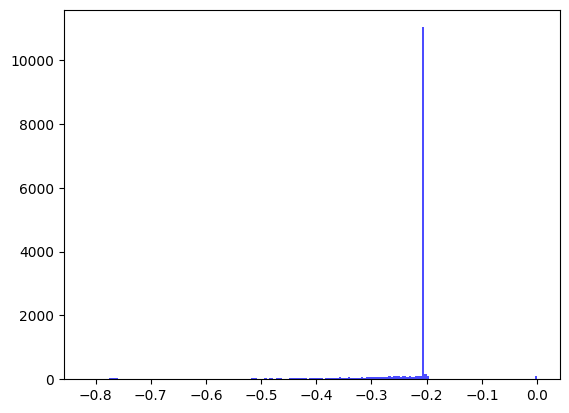

[2024-01-12T16:42:18.321559+00:00] Epochs 161, total loss: 1.26007e+04
[2024-01-12T16:42:18.322794+00:00] Training llk: -6.51960e-01
[2024-01-12T16:42:18.323371+00:00] Testing llk: -5.36699e-01
[2024-01-12T16:42:18.323861+00:00] MAE:0.44034, MRE:1.38720
saving model


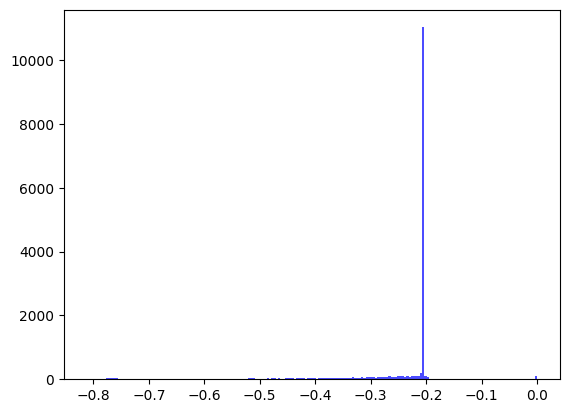

[2024-01-12T16:42:23.441163+00:00] Epochs 162, total loss: 1.25753e+04
[2024-01-12T16:42:23.442459+00:00] Training llk: -6.51293e-01
[2024-01-12T16:42:23.443027+00:00] Testing llk: -5.35635e-01
[2024-01-12T16:42:23.443525+00:00] MAE:0.44063, MRE:1.38308
saving model


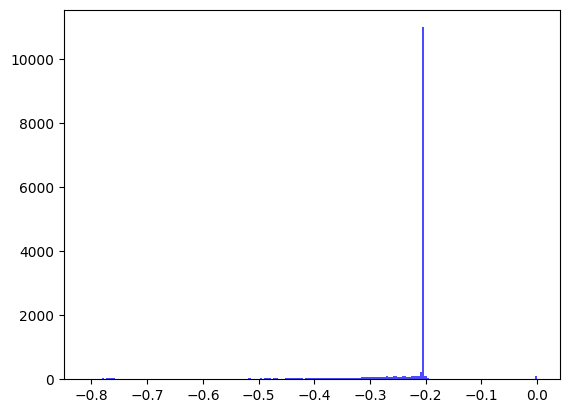

[2024-01-12T16:42:29.529428+00:00] Epochs 163, total loss: 1.25513e+04
[2024-01-12T16:42:29.530662+00:00] Training llk: -6.50645e-01
[2024-01-12T16:42:29.531248+00:00] Testing llk: -5.34636e-01
[2024-01-12T16:42:29.531750+00:00] MAE:0.44074, MRE:1.37877
saving model


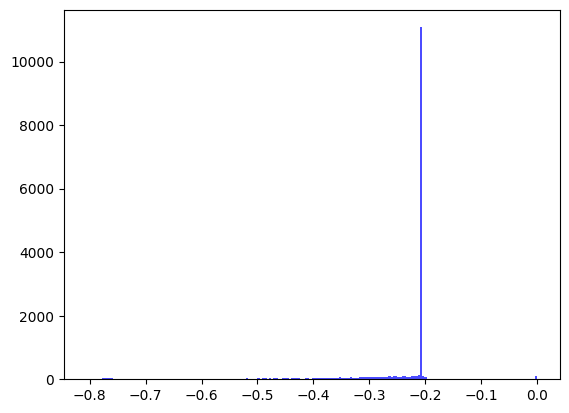

[2024-01-12T16:42:34.579644+00:00] Epochs 164, total loss: 1.25286e+04
[2024-01-12T16:42:34.580852+00:00] Training llk: -6.50018e-01
[2024-01-12T16:42:34.581381+00:00] Testing llk: -5.33695e-01
[2024-01-12T16:42:34.581982+00:00] MAE:0.44071, MRE:1.37435
saving model


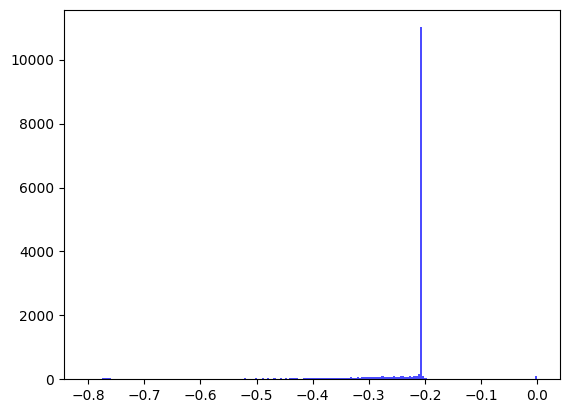

[2024-01-12T16:42:40.351311+00:00] Epochs 165, total loss: 1.25070e+04
[2024-01-12T16:42:40.355734+00:00] Training llk: -6.49408e-01
[2024-01-12T16:42:40.356367+00:00] Testing llk: -5.32803e-01
[2024-01-12T16:42:40.356894+00:00] MAE:0.44056, MRE:1.36989
saving model


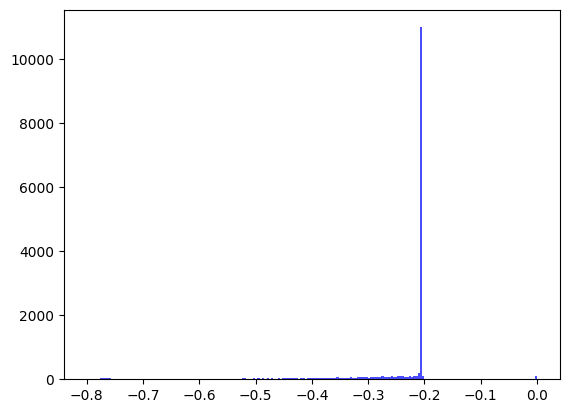

[2024-01-12T16:42:45.929234+00:00] Epochs 166, total loss: 1.24864e+04
[2024-01-12T16:42:45.930403+00:00] Training llk: -6.48816e-01
[2024-01-12T16:42:45.930934+00:00] Testing llk: -5.31955e-01
[2024-01-12T16:42:45.931422+00:00] MAE:0.44031, MRE:1.36543
saving model


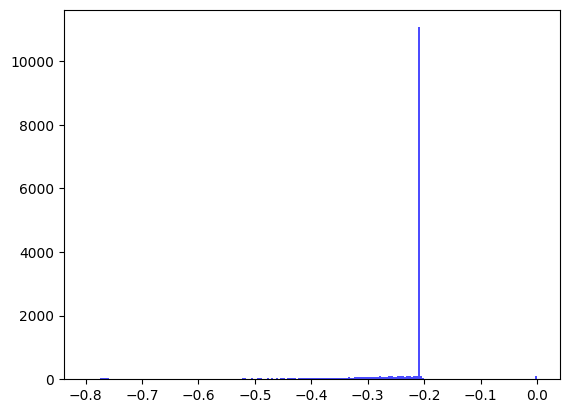

[2024-01-12T16:42:50.918656+00:00] Epochs 167, total loss: 1.24667e+04
[2024-01-12T16:42:50.919905+00:00] Training llk: -6.48242e-01
[2024-01-12T16:42:50.920450+00:00] Testing llk: -5.31148e-01
[2024-01-12T16:42:50.920976+00:00] MAE:0.43998, MRE:1.36101
saving model


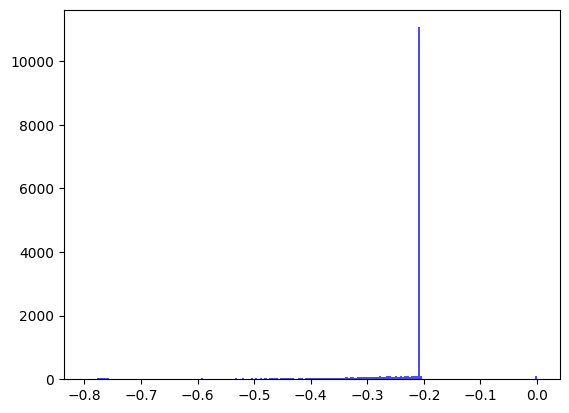

[2024-01-12T16:42:57.003188+00:00] Epochs 168, total loss: 1.24478e+04
[2024-01-12T16:42:57.003488+00:00] Training llk: -6.47684e-01
[2024-01-12T16:42:57.003588+00:00] Testing llk: -5.30376e-01
[2024-01-12T16:42:57.003664+00:00] MAE:0.43959, MRE:1.35664
saving model


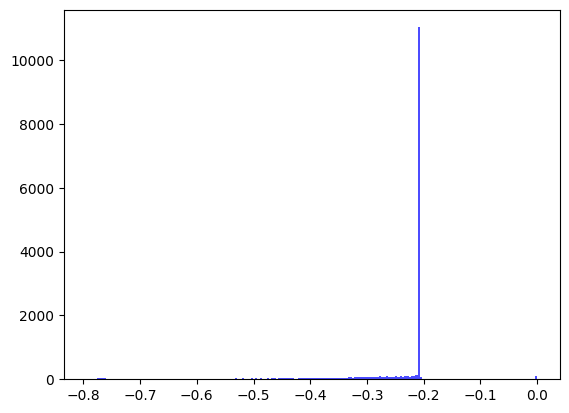

[2024-01-12T16:43:01.995986+00:00] Epochs 169, total loss: 1.24297e+04
[2024-01-12T16:43:01.996282+00:00] Training llk: -6.47143e-01
[2024-01-12T16:43:01.996389+00:00] Testing llk: -5.29637e-01
[2024-01-12T16:43:01.996474+00:00] MAE:0.43914, MRE:1.35236
saving model


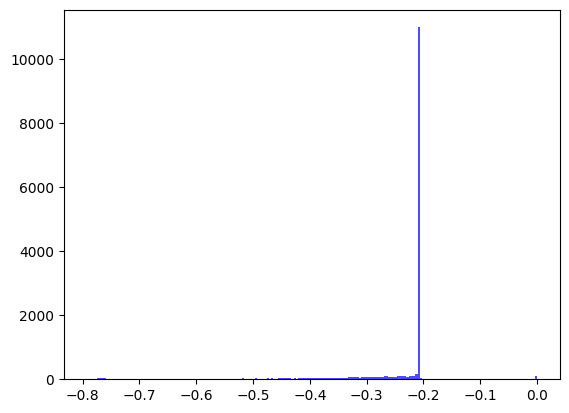

[2024-01-12T16:43:07.979374+00:00] Epochs 170, total loss: 1.24122e+04
[2024-01-12T16:43:07.984243+00:00] Training llk: -6.46617e-01
[2024-01-12T16:43:07.984820+00:00] Testing llk: -5.28928e-01
[2024-01-12T16:43:07.985326+00:00] MAE:0.43865, MRE:1.34815
saving model


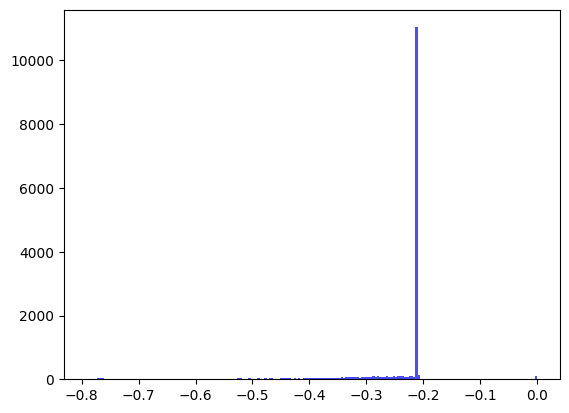

[2024-01-12T16:43:13.460124+00:00] Epochs 171, total loss: 1.23955e+04
[2024-01-12T16:43:13.461307+00:00] Training llk: -6.46107e-01
[2024-01-12T16:43:13.461857+00:00] Testing llk: -5.28247e-01
[2024-01-12T16:43:13.462369+00:00] MAE:0.43813, MRE:1.34405
saving model


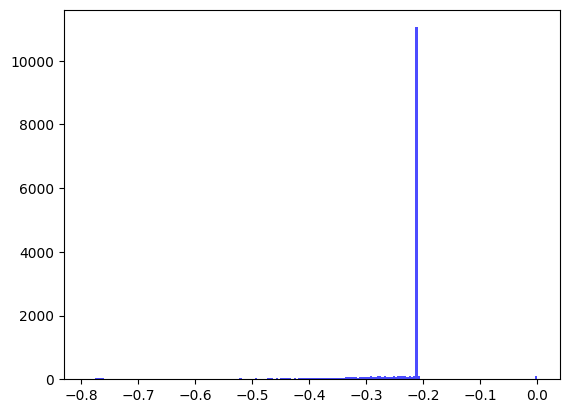

[2024-01-12T16:43:18.597870+00:00] Epochs 172, total loss: 1.23793e+04
[2024-01-12T16:43:18.599114+00:00] Training llk: -6.45612e-01
[2024-01-12T16:43:18.599668+00:00] Testing llk: -5.27593e-01
[2024-01-12T16:43:18.600185+00:00] MAE:0.43759, MRE:1.34003
saving model


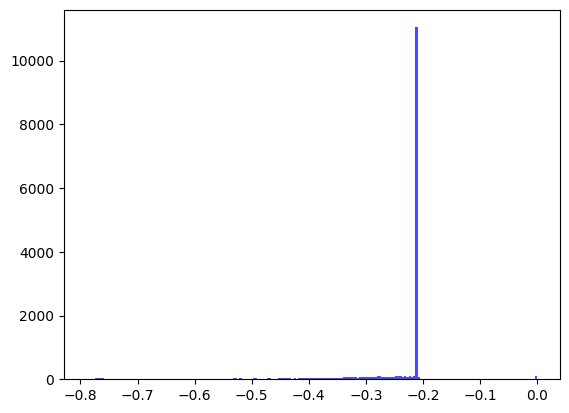

[2024-01-12T16:43:24.698886+00:00] Epochs 173, total loss: 1.23636e+04
[2024-01-12T16:43:24.700122+00:00] Training llk: -6.45132e-01
[2024-01-12T16:43:24.700678+00:00] Testing llk: -5.26963e-01
[2024-01-12T16:43:24.701211+00:00] MAE:0.43703, MRE:1.33612
saving model


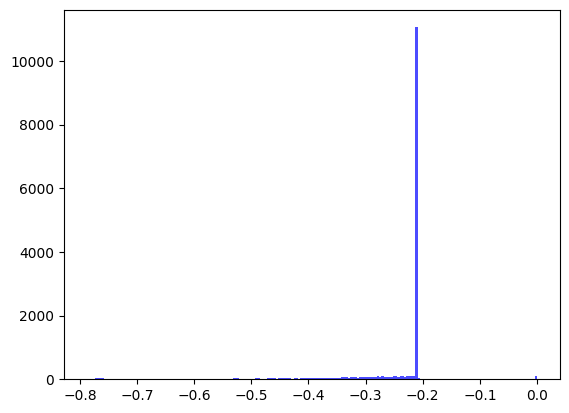

[2024-01-12T16:43:29.705477+00:00] Epochs 174, total loss: 1.23485e+04
[2024-01-12T16:43:29.706863+00:00] Training llk: -6.44667e-01
[2024-01-12T16:43:29.707446+00:00] Testing llk: -5.26356e-01
[2024-01-12T16:43:29.707965+00:00] MAE:0.43645, MRE:1.33231
saving model


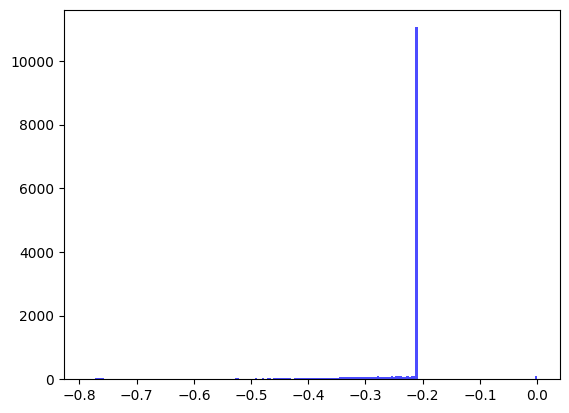

[2024-01-12T16:43:35.997567+00:00] Epochs 175, total loss: 1.23339e+04
[2024-01-12T16:43:35.998739+00:00] Training llk: -6.44216e-01
[2024-01-12T16:43:35.999308+00:00] Testing llk: -5.25772e-01
[2024-01-12T16:43:35.999856+00:00] MAE:0.43587, MRE:1.32861
saving model


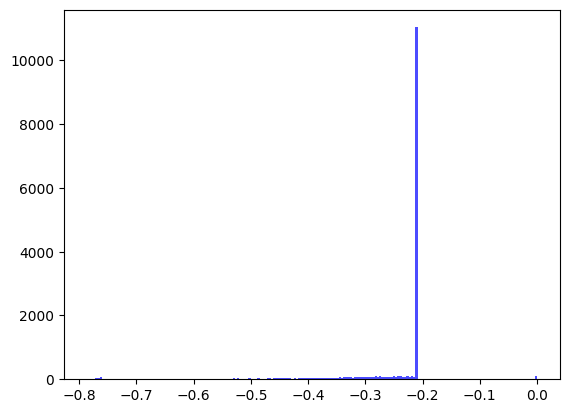

[2024-01-12T16:43:41.074149+00:00] Epochs 176, total loss: 1.23197e+04
[2024-01-12T16:43:41.075371+00:00] Training llk: -6.43779e-01
[2024-01-12T16:43:41.075966+00:00] Testing llk: -5.25207e-01
[2024-01-12T16:43:41.076494+00:00] MAE:0.43530, MRE:1.32502
saving model


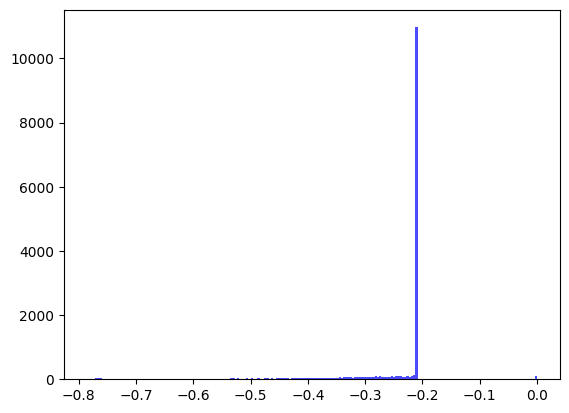

[2024-01-12T16:43:46.255867+00:00] Epochs 177, total loss: 1.23060e+04
[2024-01-12T16:43:46.261601+00:00] Training llk: -6.43355e-01
[2024-01-12T16:43:46.262185+00:00] Testing llk: -5.24662e-01
[2024-01-12T16:43:46.262665+00:00] MAE:0.43472, MRE:1.32154
saving model


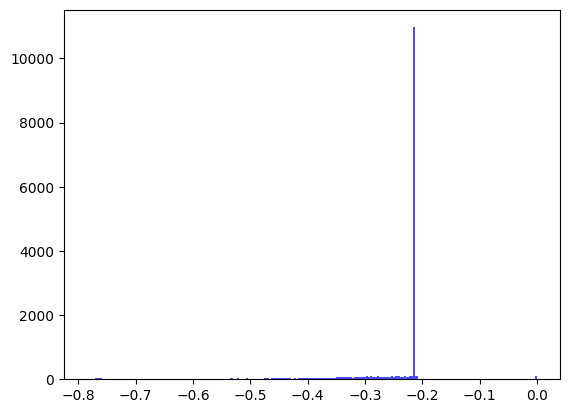

[2024-01-12T16:43:52.338723+00:00] Epochs 178, total loss: 1.22928e+04
[2024-01-12T16:43:52.339943+00:00] Training llk: -6.42945e-01
[2024-01-12T16:43:52.340499+00:00] Testing llk: -5.24135e-01
[2024-01-12T16:43:52.341018+00:00] MAE:0.43415, MRE:1.31818
saving model


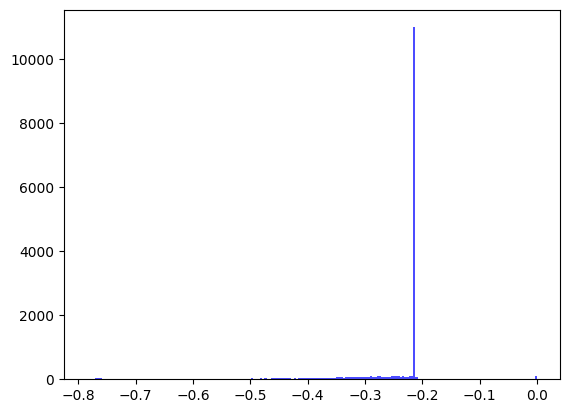

[2024-01-12T16:43:57.370652+00:00] Epochs 179, total loss: 1.22799e+04
[2024-01-12T16:43:57.371781+00:00] Training llk: -6.42548e-01
[2024-01-12T16:43:57.372339+00:00] Testing llk: -5.23625e-01
[2024-01-12T16:43:57.372823+00:00] MAE:0.43359, MRE:1.31494
saving model


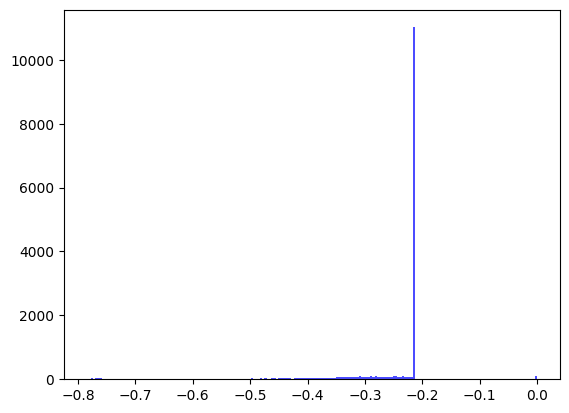

[2024-01-12T16:44:03.695735+00:00] Epochs 180, total loss: 1.22674e+04
[2024-01-12T16:44:03.696025+00:00] Training llk: -6.42164e-01
[2024-01-12T16:44:03.696144+00:00] Testing llk: -5.23130e-01
[2024-01-12T16:44:03.696230+00:00] MAE:0.43305, MRE:1.31183
saving model


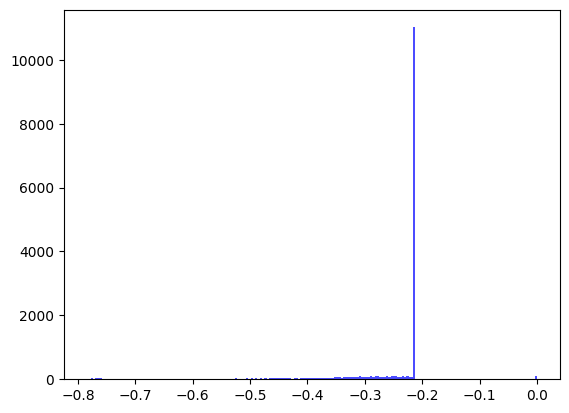

[2024-01-12T16:44:08.712382+00:00] Epochs 181, total loss: 1.22553e+04
[2024-01-12T16:44:08.713530+00:00] Training llk: -6.41792e-01
[2024-01-12T16:44:08.714077+00:00] Testing llk: -5.22650e-01
[2024-01-12T16:44:08.714587+00:00] MAE:0.43253, MRE:1.30884
saving model


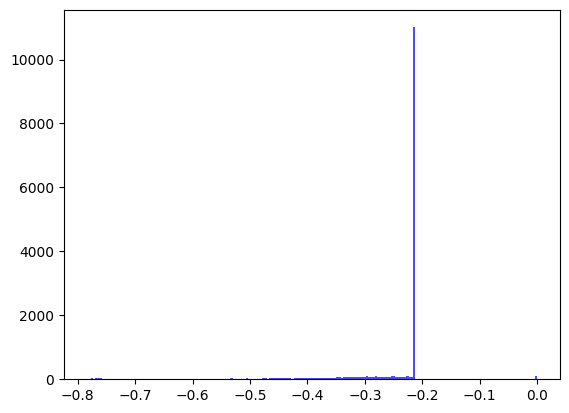

[2024-01-12T16:44:14.182876+00:00] Epochs 182, total loss: 1.22435e+04
[2024-01-12T16:44:14.184018+00:00] Training llk: -6.41431e-01
[2024-01-12T16:44:14.184531+00:00] Testing llk: -5.22184e-01
[2024-01-12T16:44:14.185014+00:00] MAE:0.43203, MRE:1.30598
saving model


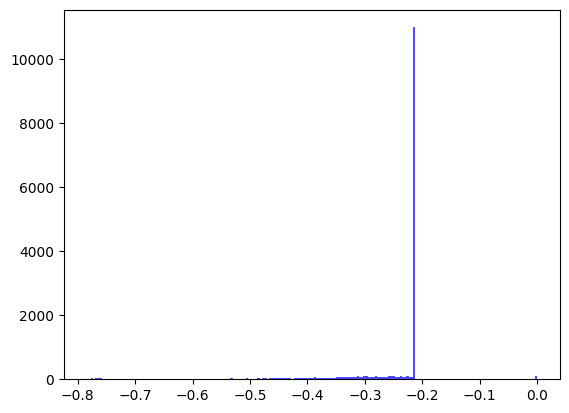

[2024-01-12T16:44:19.764261+00:00] Epochs 183, total loss: 1.22321e+04
[2024-01-12T16:44:19.765402+00:00] Training llk: -6.41082e-01
[2024-01-12T16:44:19.765943+00:00] Testing llk: -5.21731e-01
[2024-01-12T16:44:19.766430+00:00] MAE:0.43156, MRE:1.30325
saving model


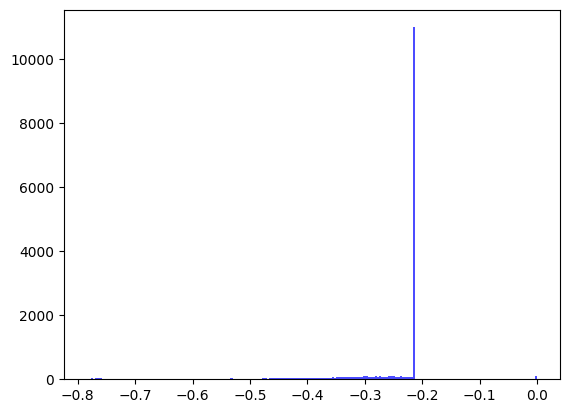

[2024-01-12T16:44:25.020484+00:00] Epochs 184, total loss: 1.22210e+04
[2024-01-12T16:44:25.021765+00:00] Training llk: -6.40744e-01
[2024-01-12T16:44:25.022363+00:00] Testing llk: -5.21290e-01
[2024-01-12T16:44:25.022857+00:00] MAE:0.43110, MRE:1.30065
saving model


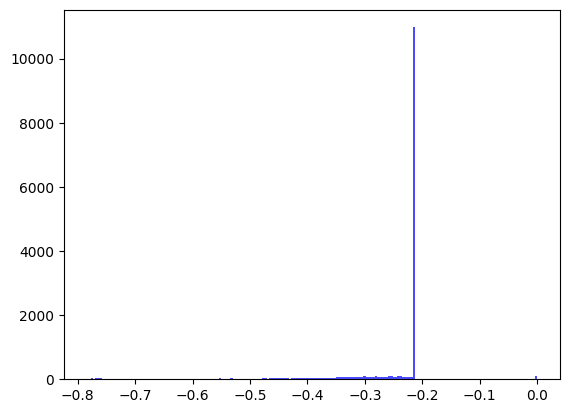

[2024-01-12T16:44:31.174037+00:00] Epochs 185, total loss: 1.22103e+04
[2024-01-12T16:44:31.175229+00:00] Training llk: -6.40417e-01
[2024-01-12T16:44:31.175797+00:00] Testing llk: -5.20861e-01
[2024-01-12T16:44:31.176327+00:00] MAE:0.43068, MRE:1.29818
saving model


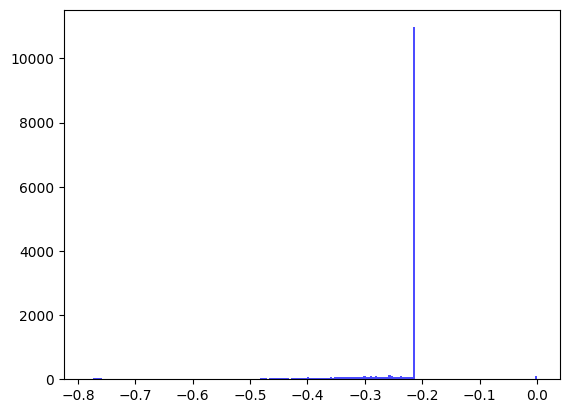

[2024-01-12T16:44:36.143023+00:00] Epochs 186, total loss: 1.21998e+04
[2024-01-12T16:44:36.144178+00:00] Training llk: -6.40100e-01
[2024-01-12T16:44:36.144680+00:00] Testing llk: -5.20443e-01
[2024-01-12T16:44:36.145199+00:00] MAE:0.43028, MRE:1.29582
saving model


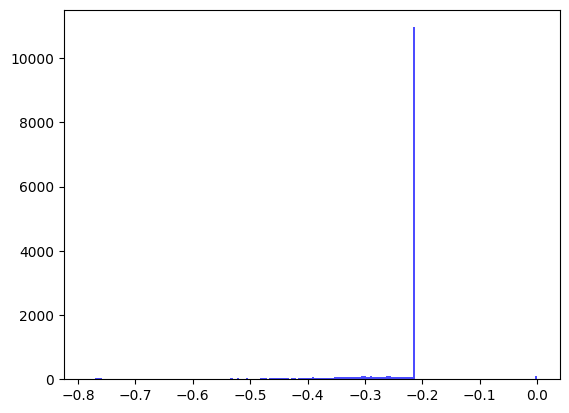

[2024-01-12T16:44:41.995466+00:00] Epochs 187, total loss: 1.21896e+04
[2024-01-12T16:44:41.996714+00:00] Training llk: -6.39793e-01
[2024-01-12T16:44:41.997264+00:00] Testing llk: -5.20036e-01
[2024-01-12T16:44:41.997747+00:00] MAE:0.42990, MRE:1.29359
saving model


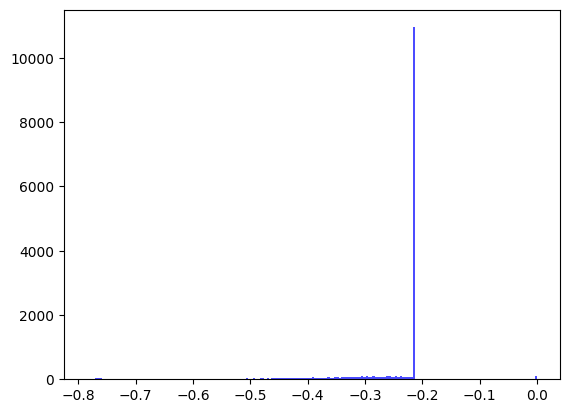

[2024-01-12T16:44:48.530851+00:00] Epochs 188, total loss: 1.21797e+04
[2024-01-12T16:44:48.532065+00:00] Training llk: -6.39496e-01
[2024-01-12T16:44:48.532612+00:00] Testing llk: -5.19638e-01
[2024-01-12T16:44:48.533128+00:00] MAE:0.42956, MRE:1.29148
saving model


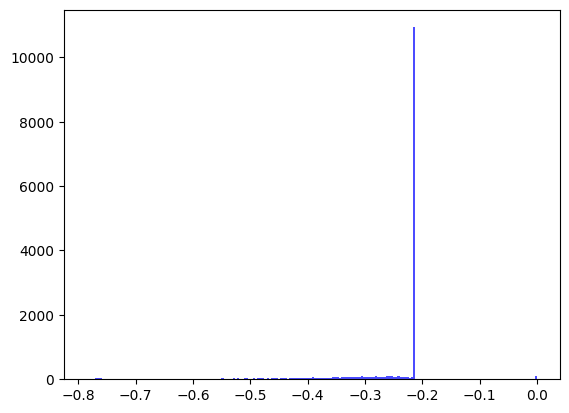

[2024-01-12T16:44:54.260633+00:00] Epochs 189, total loss: 1.21701e+04
[2024-01-12T16:44:54.261764+00:00] Training llk: -6.39207e-01
[2024-01-12T16:44:54.262287+00:00] Testing llk: -5.19250e-01
[2024-01-12T16:44:54.262758+00:00] MAE:0.42924, MRE:1.28948
saving model


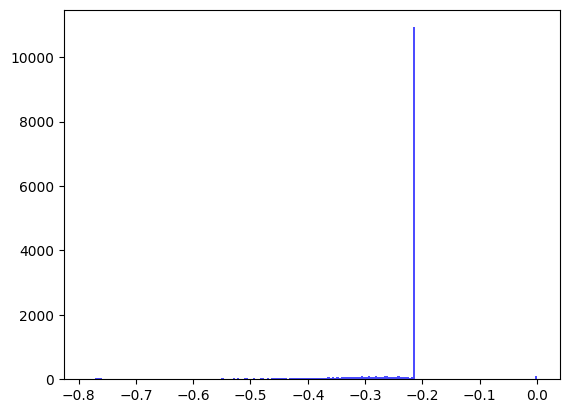

[2024-01-12T16:45:00.151522+00:00] Epochs 190, total loss: 1.21608e+04
[2024-01-12T16:45:00.152775+00:00] Training llk: -6.38928e-01
[2024-01-12T16:45:00.153360+00:00] Testing llk: -5.18872e-01
[2024-01-12T16:45:00.153873+00:00] MAE:0.42895, MRE:1.28758
saving model


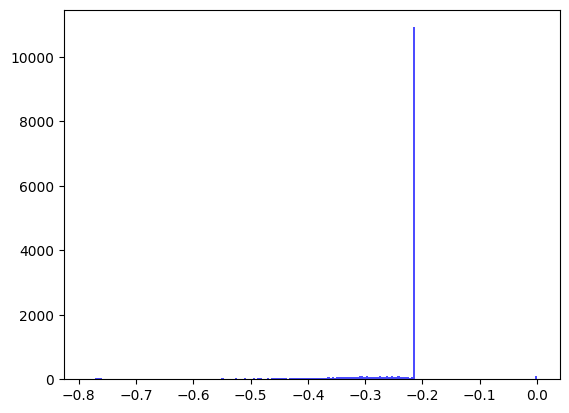

[2024-01-12T16:45:05.170787+00:00] Epochs 191, total loss: 1.21517e+04
[2024-01-12T16:45:05.171083+00:00] Training llk: -6.38658e-01
[2024-01-12T16:45:05.171196+00:00] Testing llk: -5.18502e-01
[2024-01-12T16:45:05.171282+00:00] MAE:0.42868, MRE:1.28579
saving model


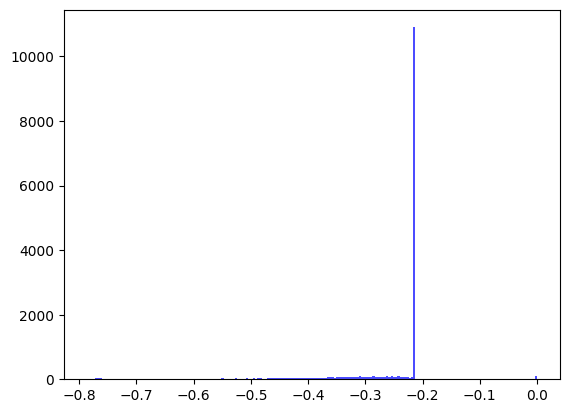

[2024-01-12T16:45:11.314481+00:00] Epochs 192, total loss: 1.21428e+04
[2024-01-12T16:45:11.315659+00:00] Training llk: -6.38395e-01
[2024-01-12T16:45:11.316194+00:00] Testing llk: -5.18142e-01
[2024-01-12T16:45:11.316692+00:00] MAE:0.42843, MRE:1.28409
saving model


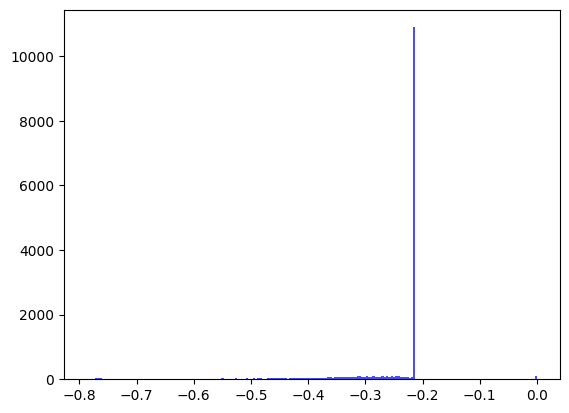

[2024-01-12T16:45:16.695998+00:00] Epochs 193, total loss: 1.21342e+04
[2024-01-12T16:45:16.697198+00:00] Training llk: -6.38141e-01
[2024-01-12T16:45:16.697742+00:00] Testing llk: -5.17790e-01
[2024-01-12T16:45:16.698260+00:00] MAE:0.42820, MRE:1.28248
saving model


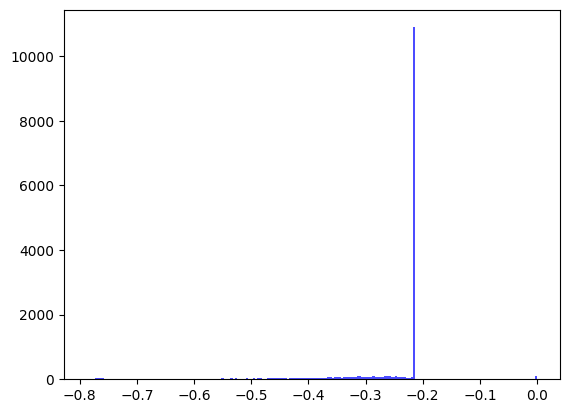

[2024-01-12T16:45:22.436786+00:00] Epochs 194, total loss: 1.21258e+04
[2024-01-12T16:45:22.437943+00:00] Training llk: -6.37895e-01
[2024-01-12T16:45:22.438453+00:00] Testing llk: -5.17446e-01
[2024-01-12T16:45:22.438941+00:00] MAE:0.42799, MRE:1.28095
saving model


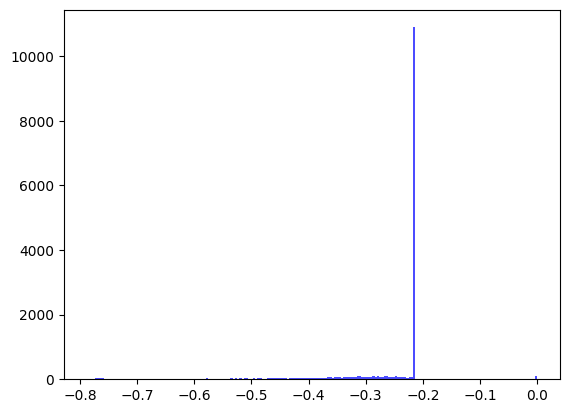

[2024-01-12T16:45:27.739418+00:00] Epochs 195, total loss: 1.21176e+04
[2024-01-12T16:45:27.740613+00:00] Training llk: -6.37656e-01
[2024-01-12T16:45:27.741153+00:00] Testing llk: -5.17111e-01
[2024-01-12T16:45:27.741675+00:00] MAE:0.42780, MRE:1.27950
saving model


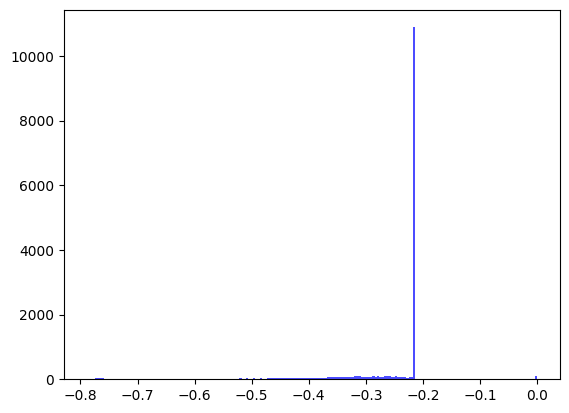

[2024-01-12T16:45:32.716697+00:00] Epochs 196, total loss: 1.21096e+04
[2024-01-12T16:45:32.718042+00:00] Training llk: -6.37424e-01
[2024-01-12T16:45:32.718580+00:00] Testing llk: -5.16784e-01
[2024-01-12T16:45:32.719106+00:00] MAE:0.42763, MRE:1.27812
saving model


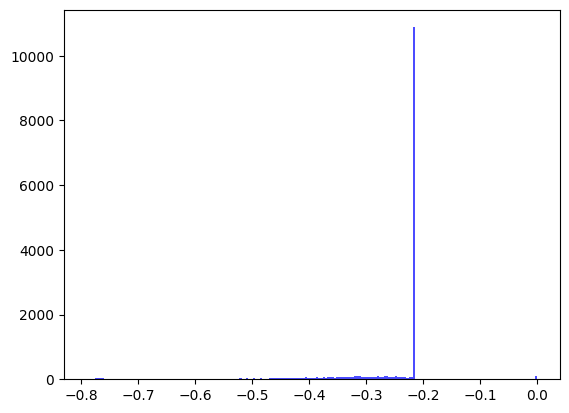

[2024-01-12T16:45:38.957496+00:00] Epochs 197, total loss: 1.21019e+04
[2024-01-12T16:45:38.958732+00:00] Training llk: -6.37200e-01
[2024-01-12T16:45:38.959298+00:00] Testing llk: -5.16465e-01
[2024-01-12T16:45:38.959801+00:00] MAE:0.42747, MRE:1.27682
saving model


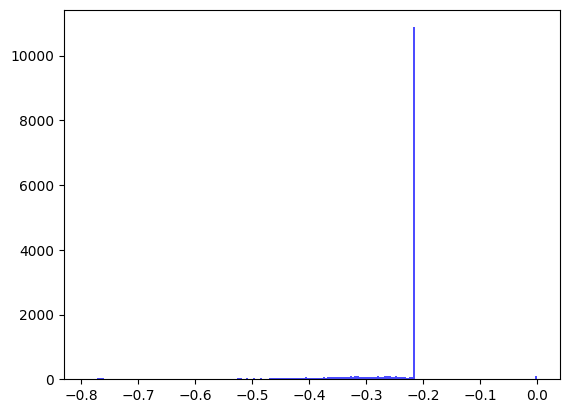

[2024-01-12T16:45:44.389530+00:00] Epochs 198, total loss: 1.20943e+04
[2024-01-12T16:45:44.390824+00:00] Training llk: -6.36982e-01
[2024-01-12T16:45:44.391384+00:00] Testing llk: -5.16154e-01
[2024-01-12T16:45:44.391891+00:00] MAE:0.42732, MRE:1.27558
saving model


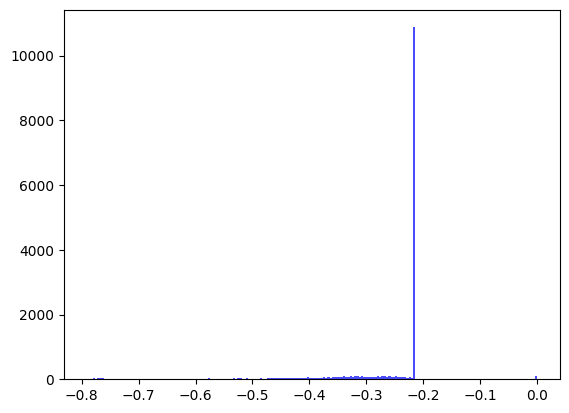

[2024-01-12T16:45:50.633694+00:00] Epochs 199, total loss: 1.20870e+04
[2024-01-12T16:45:50.634946+00:00] Training llk: -6.36771e-01
[2024-01-12T16:45:50.635497+00:00] Testing llk: -5.15849e-01
[2024-01-12T16:45:50.636039+00:00] MAE:0.42719, MRE:1.27440
saving model
training done!


In [ ]:

buffer_start_time = 35
buffer_end_time = 50
end_time = raw_test_data.max()

buffer_train_time = [buffer_start_time, buffer_end_time]
buffer_test_time = [buffer_start_time, buffer_end_time]
test_time = [buffer_end_time, end_time]

btrain_lens = ((raw_train_data <= buffer_train_time[1]) * (raw_train_data > buffer_train_time[0])).sum(1)
btest_lens = ((raw_test_data <= buffer_test_time[1]) * (raw_test_data > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum(1)

buffer_train_data = np.zeros((raw_train_data.shape[0], btrain_lens.max()))
buffer_test_data = np.zeros((raw_test_data.shape[0], btest_lens.max()))
test_data = np.zeros((raw_test_data.shape[0], test_lens.max()))

for i in range(raw_train_data.shape[0]):
    seq = raw_train_data[i]
    buffer_train_data[i, :btrain_lens[i]] = seq[(seq <= buffer_train_time[1]) * (seq > buffer_train_time[0])]

for i in range(raw_test_data.shape[0]):
    seq = raw_test_data[i]
    test_data[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_train_data = np.concatenate((np.ones_like(buffer_train_data[:, :1]) * buffer_train_time[0], buffer_train_data), axis=-1)
buffer_test_data = np.concatenate((np.ones_like(buffer_test_data[:, :1]) * buffer_test_time[0], buffer_test_data), axis=-1)

test_data_ = generate_event_mark(test_data)
buffer_train_data_ = generate_event_mark(buffer_train_data)
buffer_test_data_ = generate_event_mark(buffer_test_data)


print(test_data_.shape, buffer_train_data_.shape, buffer_test_data_.shape)
ngrid = 100

ts = np.linspace(test_time[0], test_time[1], ngrid)
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

event_loglams = 0
for i in range(raw_test_data.shape[0]):
    ts = raw_test_data[i, :][(raw_test_data[i, :] <= test_time[1]) * (raw_test_data[i, :] > test_time[0])]
    if len(ts) == 0: continue
    lams = Exponential_Hawkes(ts, raw_test_data[[i], :], mu=true_mu, alpha=true_alpha, beta=true_beta)
    event_loglams += np.log(lams).sum()

(event_loglams - true_lams.sum() * (test_time[1] - test_time[0]) / ngrid) / ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum()

for Tm in [100.]:

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
    else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())

    # device="cpu"

    print(Tm)
    T = [buffer_end_time, Tm]
    tau_max = 10.
    baserate = true_mu
    nsample = 10
    n_class = 1
    int_res = 200
    hid_dim = 1
    batch_size = 16
    train_size = 1000
    lr = 0.01
    epoch = 200
    config = config_generate(T0=str(T[0]),
                            T1=str(T[1]),
                            tau_max=str(tau_max),
                            nsample=str(nsample),
                            int_res=str(int_res),
                            n_class=str(n_class),
                            lr=str(lr),
                            epoch=str(epoch),
                            hid_dim=str(hid_dim),
                            batch_size=str(batch_size))
    config.own_event_embed = False
    config.bptt = 10
    config.alpha = true_alpha

    train_lens = ((raw_train_data <= Tm) * (raw_train_data > T[0])).sum(1)
    train_data = np.zeros((raw_train_data.shape[0], train_lens.max()))
    for i in range(train_data.shape[0]):
        seq = raw_train_data[i]
        train_data[i, :train_lens[i]] = seq[(seq <= Tm) * (seq > T[0])]

    train_data_ = generate_event_mark(train_data)

    # modelname = "1d-synthetic-exponential%.2f_hid_dim%d_T[%d, %d]_#train%d_#test%d" % (baserate,
    #                                                                                         hid_dim,
    #                                                                                         T[0],
    #                                                                                         T[1],
    #                                                                                         train_size,
    #                                                                                         test_data.shape[0])
    # save_path = os.path.join(os.getcwd(), 'Neural_Hawkes', 'saved_models', modelname)

    # if os.path.exists(save_path):
    #     # raise(ValueError("Duplicated folder!"))
    #     pass
    # else:
    #     os.makedirs(save_path)

    # seeds = [300, 816, 2999]
    # seeds = [1000, 2000, 3000]
    seeds = [0]

    for seed in seeds:
        # torch.random.manual_seed(seed)
        random.seed(seed)

        train_idx = np.arange(train_data_.shape[0])
        # random.shuffle(train_idx)
        train_data2 = train_data_[train_idx[:train_size]]
        buffer_train_data2 = buffer_train_data_[train_idx[:train_size]]

        nh_model = NH(config, device)
        num_paras = count_parameters(nh_model)
        print("#parameters: %d" % num_paras)

        for name, parameter in nh_model.named_parameters():
            if name == "baserate_mu":
                # parameter.data.fill_(random.uniform(0.4, 0.5))
                parameter.data.fill_(baserate)
            else:
                parameter.data.fill_(random.gauss(0, 0.01))

        ts = np.linspace(test_time[0], test_time[1], ngrid)
        true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

        # model = torch.load(save_path + "/model-%d.pt" % 816)

        nh_model, train_llks, test_llks, test_maes, test_mres, wall_time, train_lld_batches = model_train(train_data2,
                                                                                       test_data_,
                                                                                       buffer_train_data2,
                                                                                       buffer_test_data_,
                                                                                       nh_model,
                                                                                       config,
                                                                                       device,
                                                                                       True, ts, true_lams)


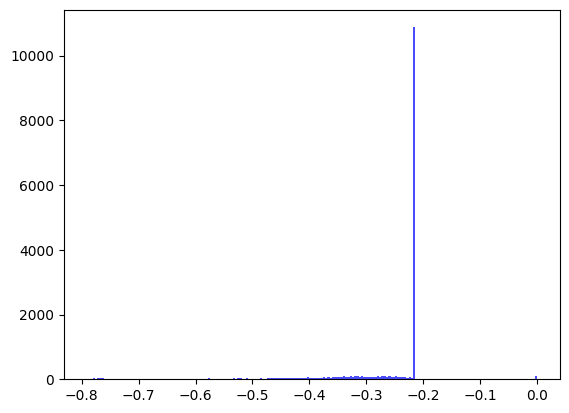

Text(0.5, 1.0, 'Conditional Intensity')

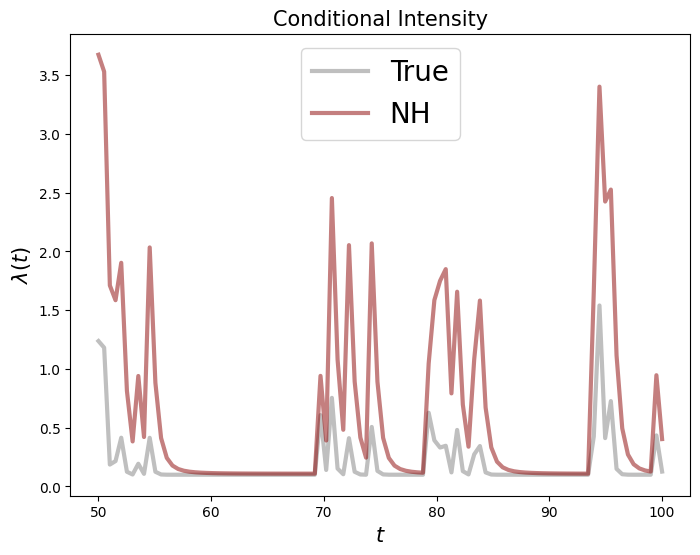

In [ ]:
test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)

nh_lams = nh_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

# print(np.mean(np.abs(lams - true_lams)))
# print(np.mean(np.abs(lams - true_lams) / true_lams))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 0
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, nh_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="NH")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)

(50, 62, 2)
(200, 57, 2)
(50, 41, 2)
(50, 62, 2) (200, 57, 2) (50, 41, 2)
CUDA is not Available. You are using CPU only.
Number of cores:  2
100.0
(200, 109, 2)
#parameters: 25
[2023-10-02T01:36:29.506897+00:00] #Training sequences: 200
[2023-10-02T01:36:29.507143+00:00] #Testing sequences: 50
[2023-10-02T01:36:29.507235+00:00] #Training events: 3716
[2023-10-02T01:36:29.507308+00:00] #Testing events: 786


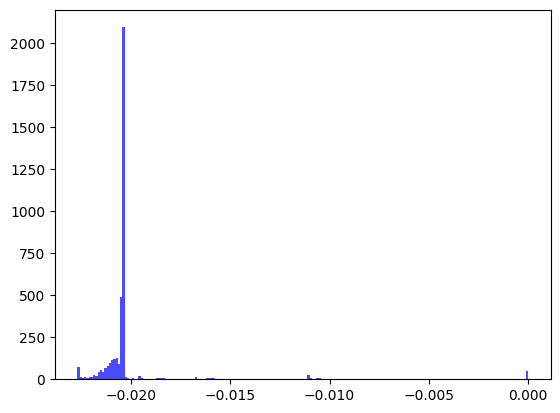

[2023-10-02T01:36:30.881865+00:00] Epochs 0, total loss: 1.09407e+04
[2023-10-02T01:36:30.883097+00:00] Training llk: -1.64064e+00
[2023-10-02T01:36:30.884365+00:00] Testing llk: -2.65210e+00
[2023-10-02T01:36:30.884936+00:00] MAE:0.63419, MRE:5.32829
saving model


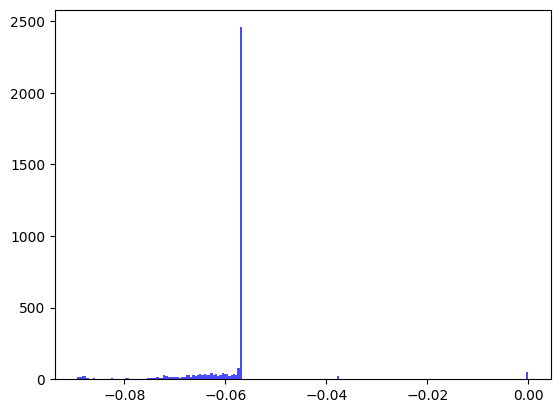

[2023-10-02T01:36:32.228985+00:00] Epochs 1, total loss: 1.06252e+04
[2023-10-02T01:36:32.230207+00:00] Training llk: -1.58733e+00
[2023-10-02T01:36:32.230818+00:00] Testing llk: -2.54955e+00
[2023-10-02T01:36:32.231365+00:00] MAE:0.58672, MRE:4.85088
saving model


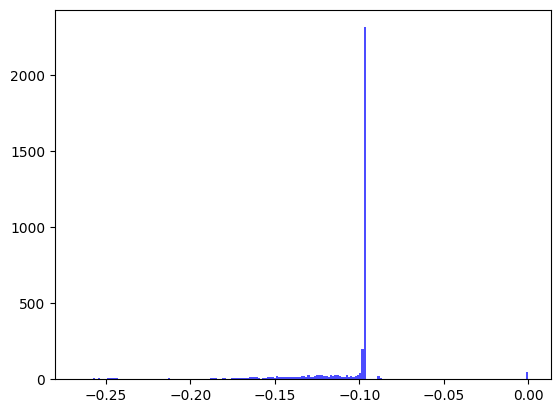

[2023-10-02T01:36:33.545463+00:00] Epochs 2, total loss: 1.03046e+04
[2023-10-02T01:36:33.545700+00:00] Training llk: -1.52306e+00
[2023-10-02T01:36:33.545799+00:00] Testing llk: -2.42516e+00
[2023-10-02T01:36:33.545874+00:00] MAE:0.52867, MRE:4.26637
saving model


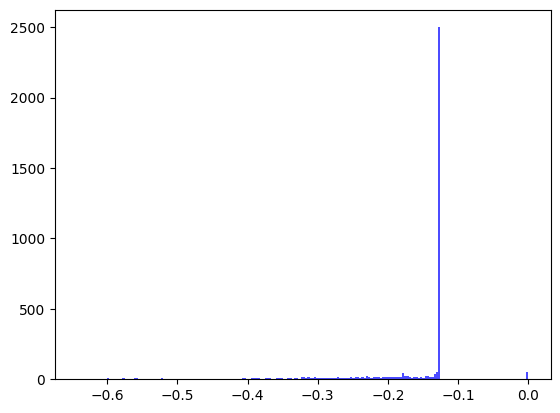

[2023-10-02T01:36:34.861365+00:00] Epochs 3, total loss: 9.87454e+03
[2023-10-02T01:36:34.862509+00:00] Training llk: -1.42840e+00
[2023-10-02T01:36:34.863062+00:00] Testing llk: -2.24225e+00
[2023-10-02T01:36:34.864808+00:00] MAE:0.44277, MRE:3.40712
saving model


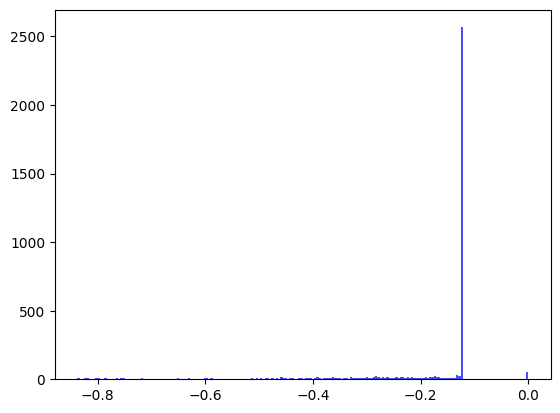

[2023-10-02T01:36:36.679845+00:00] Epochs 4, total loss: 9.38556e+03
[2023-10-02T01:36:36.682403+00:00] Training llk: -1.35614e+00
[2023-10-02T01:36:36.683009+00:00] Testing llk: -2.09736e+00
[2023-10-02T01:36:36.683668+00:00] MAE:0.36809, MRE:2.65004
saving model


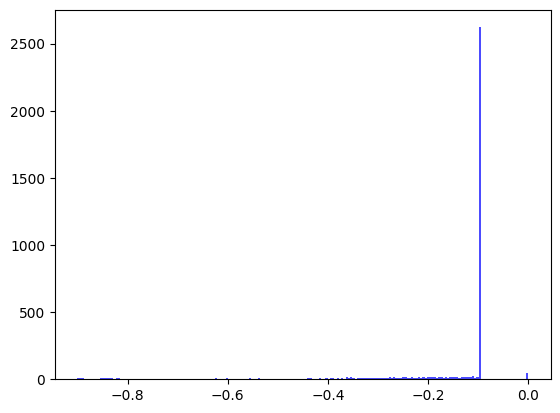

[2023-10-02T01:36:38.749388+00:00] Epochs 5, total loss: 9.03446e+03
[2023-10-02T01:36:38.749619+00:00] Training llk: -1.30331e+00
[2023-10-02T01:36:38.749703+00:00] Testing llk: -1.99941e+00
[2023-10-02T01:36:38.749761+00:00] MAE:0.32549, MRE:2.23072
saving model


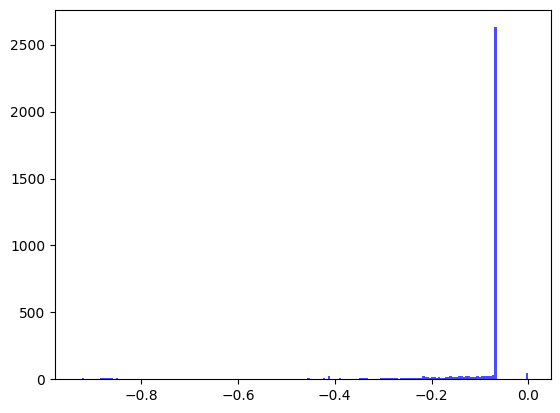

[2023-10-02T01:36:40.158057+00:00] Epochs 6, total loss: 8.72444e+03
[2023-10-02T01:36:40.158318+00:00] Training llk: -1.25848e+00
[2023-10-02T01:36:40.158406+00:00] Testing llk: -1.92186e+00
[2023-10-02T01:36:40.158474+00:00] MAE:0.29785, MRE:1.96857
saving model


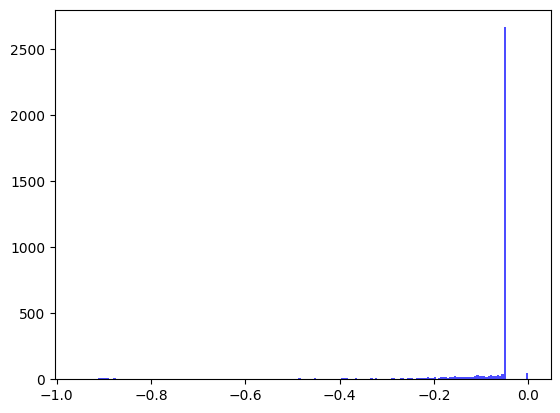

[2023-10-02T01:36:41.514059+00:00] Epochs 7, total loss: 8.46692e+03
[2023-10-02T01:36:41.514308+00:00] Training llk: -1.22176e+00
[2023-10-02T01:36:41.514391+00:00] Testing llk: -1.85889e+00
[2023-10-02T01:36:41.514461+00:00] MAE:0.27535, MRE:1.75544
saving model


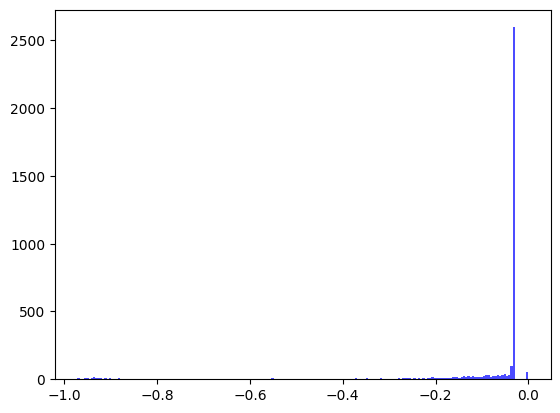

[2023-10-02T01:36:42.838537+00:00] Epochs 8, total loss: 8.24752e+03
[2023-10-02T01:36:42.838796+00:00] Training llk: -1.19049e+00
[2023-10-02T01:36:42.838890+00:00] Testing llk: -1.80607e+00
[2023-10-02T01:36:42.838963+00:00] MAE:0.25659, MRE:1.58084
saving model


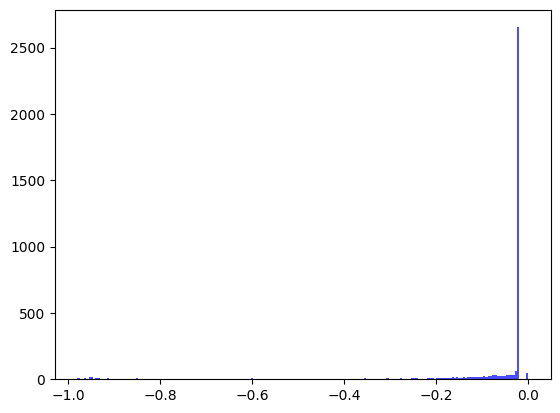

[2023-10-02T01:36:44.191076+00:00] Epochs 9, total loss: 8.05552e+03
[2023-10-02T01:36:44.191414+00:00] Training llk: -1.16341e+00
[2023-10-02T01:36:44.191533+00:00] Testing llk: -1.76211e+00
[2023-10-02T01:36:44.191617+00:00] MAE:0.24273, MRE:1.45749
saving model


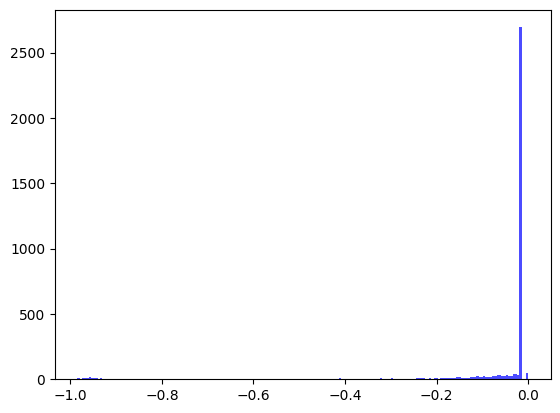

[2023-10-02T01:36:45.905190+00:00] Epochs 10, total loss: 7.88356e+03
[2023-10-02T01:36:45.905455+00:00] Training llk: -1.13915e+00
[2023-10-02T01:36:45.905564+00:00] Testing llk: -1.72410e+00
[2023-10-02T01:36:45.905630+00:00] MAE:0.23217, MRE:1.36899
saving model


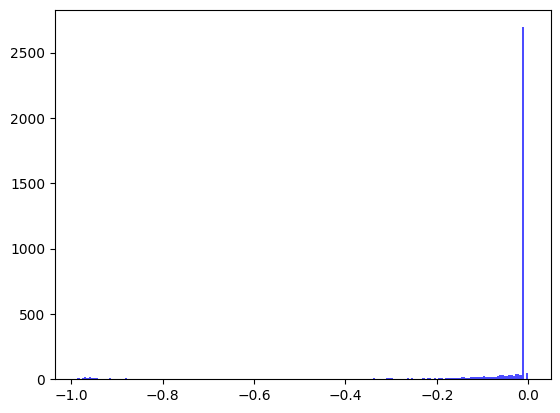

[2023-10-02T01:36:47.328664+00:00] Epochs 11, total loss: 7.72540e+03
[2023-10-02T01:36:47.329105+00:00] Training llk: -1.11692e+00
[2023-10-02T01:36:47.329214+00:00] Testing llk: -1.68991e+00
[2023-10-02T01:36:47.329317+00:00] MAE:0.22319, MRE:1.29767
saving model


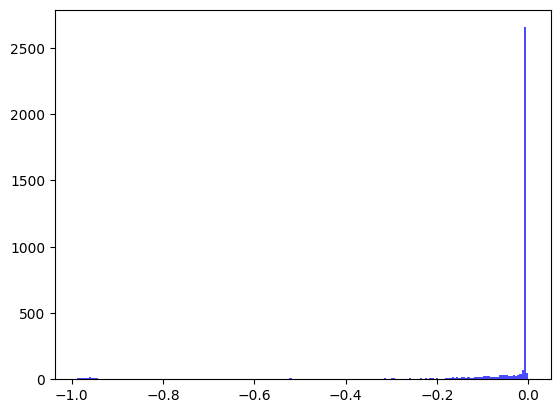

[2023-10-02T01:36:48.786028+00:00] Epochs 12, total loss: 7.57673e+03
[2023-10-02T01:36:48.788805+00:00] Training llk: -1.09623e+00
[2023-10-02T01:36:48.789457+00:00] Testing llk: -1.65868e+00
[2023-10-02T01:36:48.790053+00:00] MAE:0.21560, MRE:1.24133
saving model


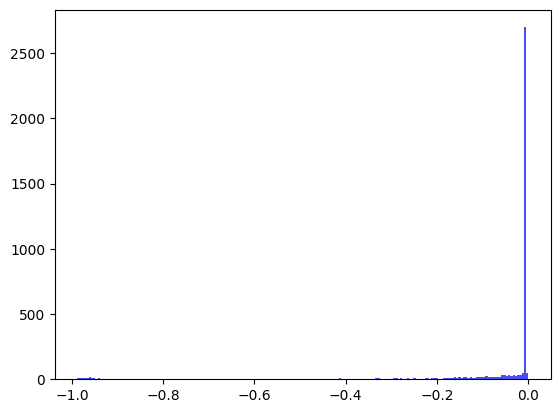

[2023-10-02T01:36:50.797714+00:00] Epochs 13, total loss: 7.43590e+03
[2023-10-02T01:36:50.802882+00:00] Training llk: -1.07676e+00
[2023-10-02T01:36:50.803576+00:00] Testing llk: -1.62973e+00
[2023-10-02T01:36:50.804146+00:00] MAE:0.20907, MRE:1.19632
saving model


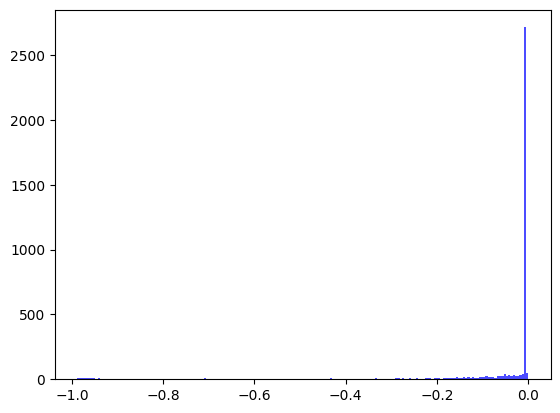

[2023-10-02T01:36:52.347415+00:00] Epochs 14, total loss: 7.30211e+03
[2023-10-02T01:36:52.347732+00:00] Training llk: -1.05830e+00
[2023-10-02T01:36:52.347835+00:00] Testing llk: -1.60254e+00
[2023-10-02T01:36:52.347918+00:00] MAE:0.20315, MRE:1.15783
saving model


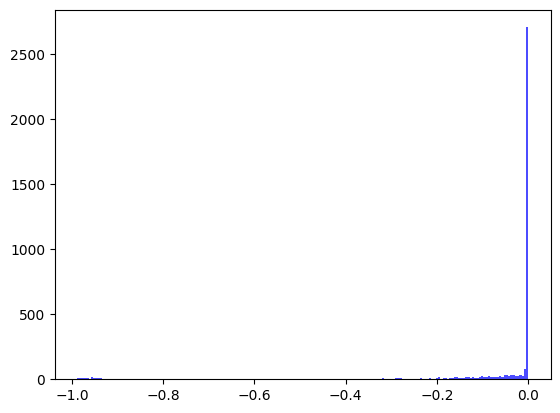

[2023-10-02T01:36:54.003893+00:00] Epochs 15, total loss: 7.17458e+03
[2023-10-02T01:36:54.004225+00:00] Training llk: -1.04075e+00
[2023-10-02T01:36:54.004370+00:00] Testing llk: -1.57685e+00
[2023-10-02T01:36:54.004479+00:00] MAE:0.19770, MRE:1.12444
saving model


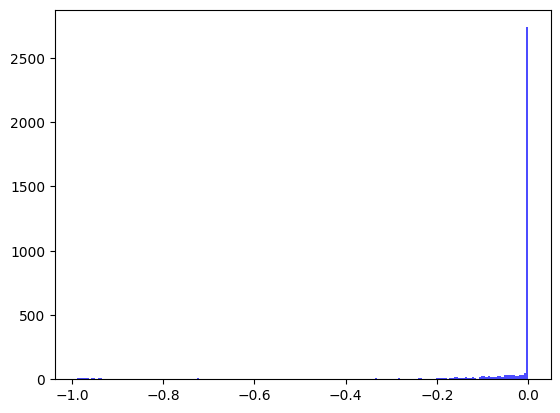

[2023-10-02T01:36:55.363581+00:00] Epochs 16, total loss: 7.05288e+03
[2023-10-02T01:36:55.363916+00:00] Training llk: -1.02401e+00
[2023-10-02T01:36:55.364020+00:00] Testing llk: -1.55247e+00
[2023-10-02T01:36:55.364151+00:00] MAE:0.19259, MRE:1.09458
saving model


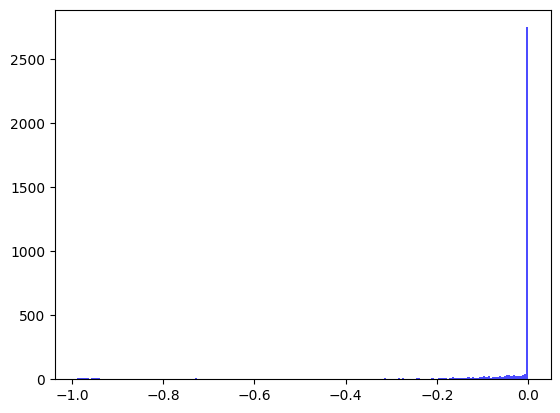

[2023-10-02T01:36:56.761373+00:00] Epochs 17, total loss: 6.93671e+03
[2023-10-02T01:36:56.761648+00:00] Training llk: -1.00805e+00
[2023-10-02T01:36:56.761754+00:00] Testing llk: -1.52929e+00
[2023-10-02T01:36:56.761872+00:00] MAE:0.18771, MRE:1.06706
saving model


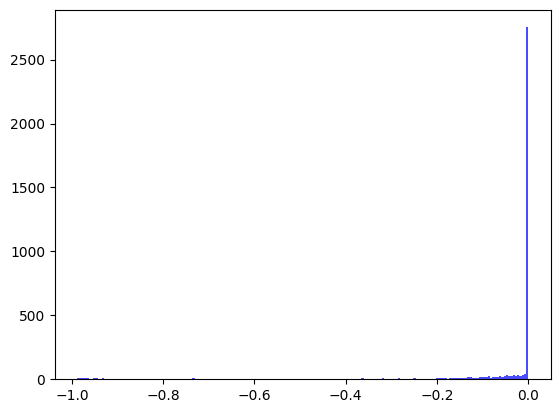

[2023-10-02T01:36:58.102112+00:00] Epochs 18, total loss: 6.82574e+03
[2023-10-02T01:36:58.102344+00:00] Training llk: -9.92838e-01
[2023-10-02T01:36:58.102433+00:00] Testing llk: -1.50724e+00
[2023-10-02T01:36:58.102493+00:00] MAE:0.18303, MRE:1.04138
saving model


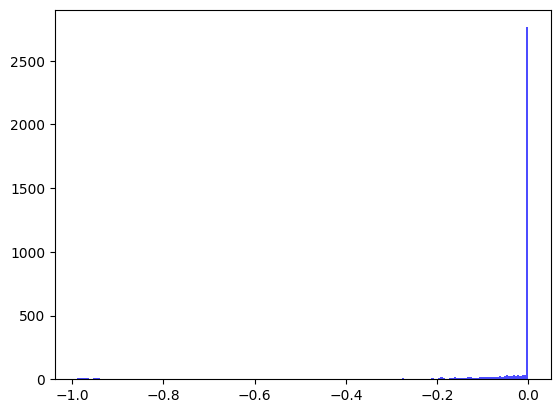

[2023-10-02T01:36:59.395886+00:00] Epochs 19, total loss: 6.71977e+03
[2023-10-02T01:36:59.401052+00:00] Training llk: -9.78352e-01
[2023-10-02T01:36:59.401228+00:00] Testing llk: -1.48626e+00
[2023-10-02T01:36:59.401312+00:00] MAE:0.17850, MRE:1.01702
saving model


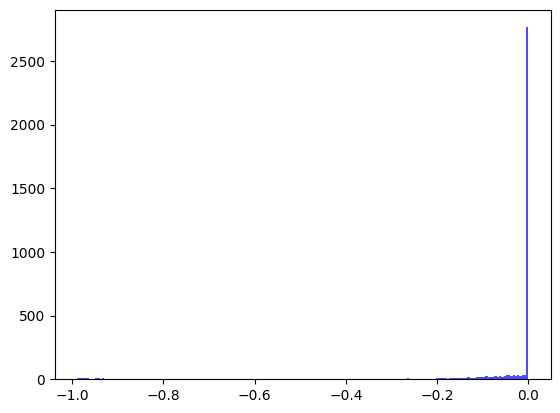

[2023-10-02T01:37:01.551256+00:00] Epochs 20, total loss: 6.61858e+03
[2023-10-02T01:37:01.553016+00:00] Training llk: -9.64564e-01
[2023-10-02T01:37:01.553159+00:00] Testing llk: -1.46630e+00
[2023-10-02T01:37:01.553230+00:00] MAE:0.17412, MRE:0.99371
saving model


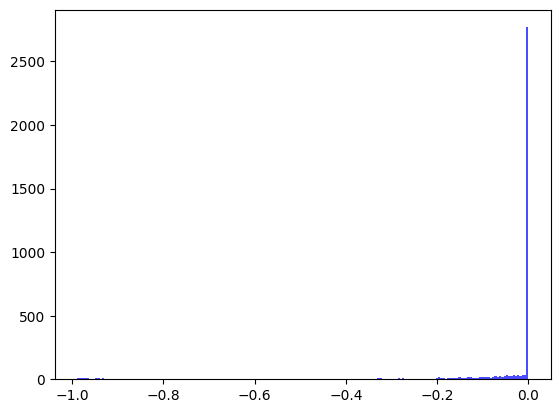

[2023-10-02T01:37:03.594839+00:00] Epochs 21, total loss: 6.52198e+03
[2023-10-02T01:37:03.595972+00:00] Training llk: -9.51448e-01
[2023-10-02T01:37:03.596530+00:00] Testing llk: -1.44732e+00
[2023-10-02T01:37:03.597046+00:00] MAE:0.16987, MRE:0.97124
saving model


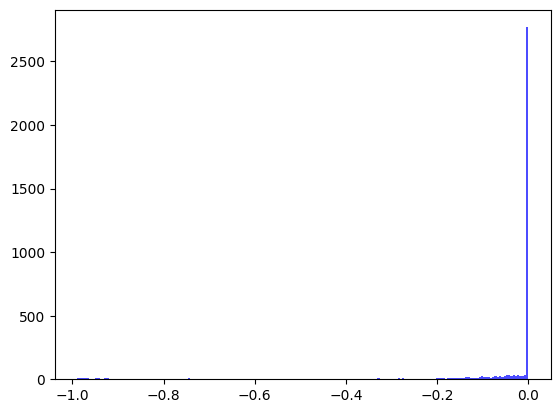

[2023-10-02T01:37:05.161834+00:00] Epochs 22, total loss: 6.42979e+03
[2023-10-02T01:37:05.162149+00:00] Training llk: -9.38978e-01
[2023-10-02T01:37:05.162245+00:00] Testing llk: -1.42927e+00
[2023-10-02T01:37:05.162332+00:00] MAE:0.16577, MRE:0.94949
saving model


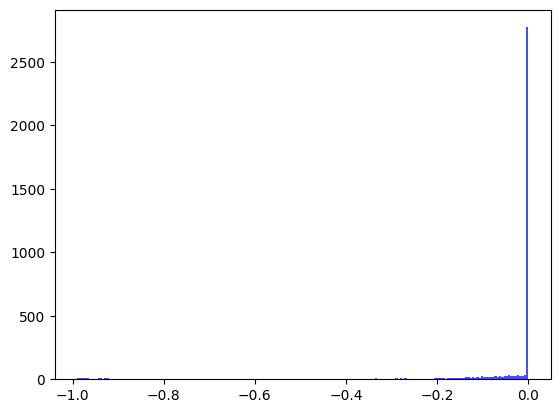

[2023-10-02T01:37:06.493717+00:00] Epochs 23, total loss: 6.34183e+03
[2023-10-02T01:37:06.493971+00:00] Training llk: -9.27127e-01
[2023-10-02T01:37:06.494085+00:00] Testing llk: -1.41210e+00
[2023-10-02T01:37:06.494162+00:00] MAE:0.16185, MRE:0.92844
saving model


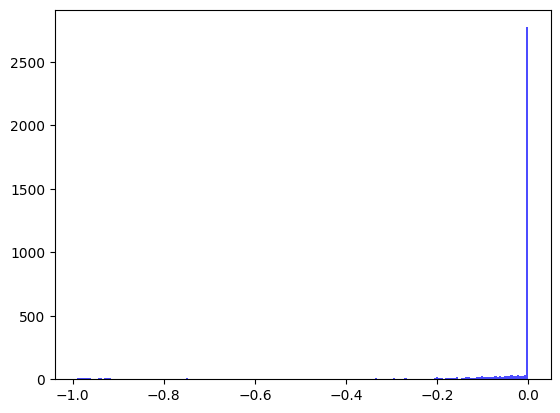

[2023-10-02T01:37:07.854509+00:00] Epochs 24, total loss: 6.25795e+03
[2023-10-02T01:37:07.854807+00:00] Training llk: -9.15869e-01
[2023-10-02T01:37:07.854902+00:00] Testing llk: -1.39578e+00
[2023-10-02T01:37:07.854989+00:00] MAE:0.15823, MRE:0.90814
saving model


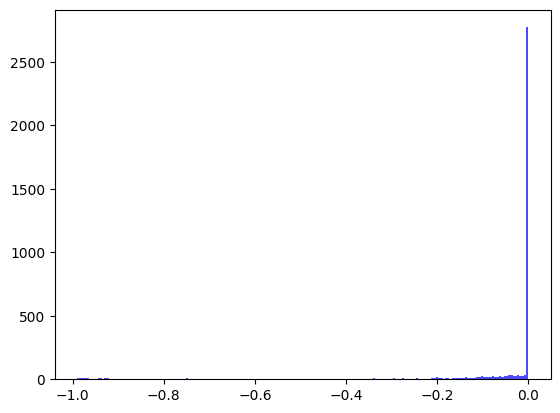

[2023-10-02T01:37:09.143728+00:00] Epochs 25, total loss: 6.17798e+03
[2023-10-02T01:37:09.144007+00:00] Training llk: -9.05178e-01
[2023-10-02T01:37:09.144133+00:00] Testing llk: -1.38028e+00
[2023-10-02T01:37:09.144226+00:00] MAE:0.15497, MRE:0.88861
saving model


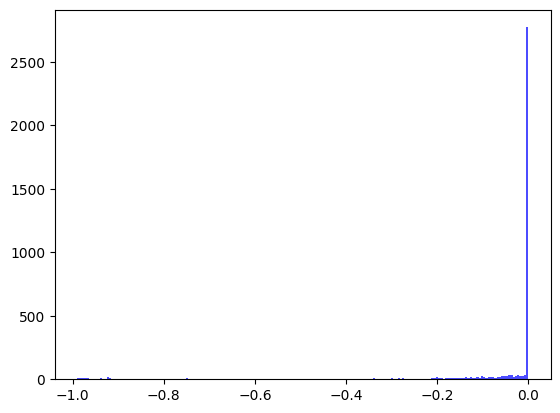

[2023-10-02T01:37:10.744617+00:00] Epochs 26, total loss: 6.10176e+03
[2023-10-02T01:37:10.744851+00:00] Training llk: -8.95028e-01
[2023-10-02T01:37:10.744944+00:00] Testing llk: -1.36554e+00
[2023-10-02T01:37:10.745008+00:00] MAE:0.15192, MRE:0.86967
saving model


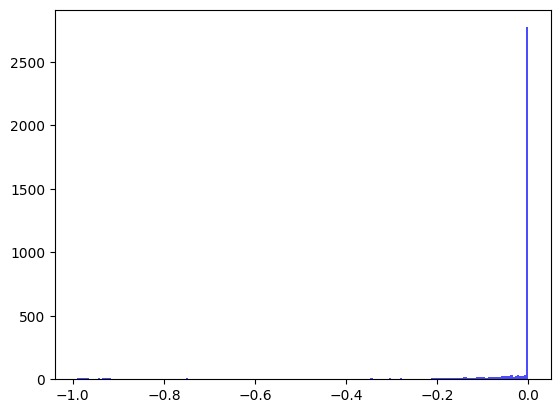

[2023-10-02T01:37:12.059481+00:00] Epochs 27, total loss: 6.02913e+03
[2023-10-02T01:37:12.059696+00:00] Training llk: -8.85395e-01
[2023-10-02T01:37:12.059791+00:00] Testing llk: -1.35154e+00
[2023-10-02T01:37:12.059871+00:00] MAE:0.14896, MRE:0.85120
saving model


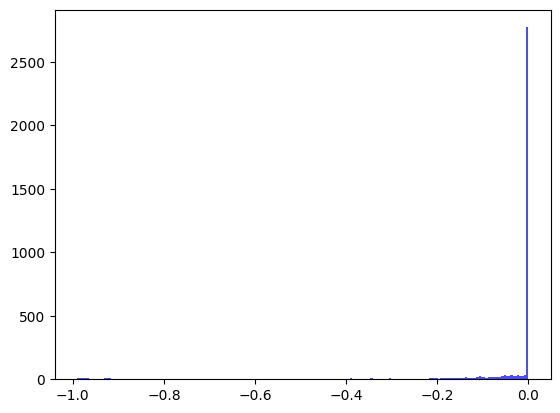

[2023-10-02T01:37:13.369803+00:00] Epochs 28, total loss: 5.95993e+03
[2023-10-02T01:37:13.370068+00:00] Training llk: -8.76255e-01
[2023-10-02T01:37:13.370162+00:00] Testing llk: -1.33824e+00
[2023-10-02T01:37:13.370248+00:00] MAE:0.14611, MRE:0.83322
saving model


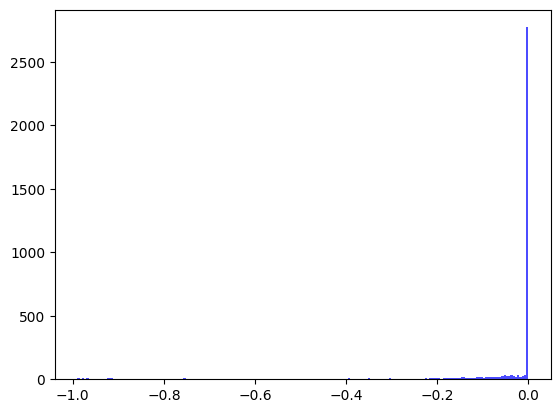

[2023-10-02T01:37:14.855715+00:00] Epochs 29, total loss: 5.89400e+03
[2023-10-02T01:37:14.856897+00:00] Training llk: -8.67583e-01
[2023-10-02T01:37:14.857597+00:00] Testing llk: -1.32562e+00
[2023-10-02T01:37:14.858181+00:00] MAE:0.14338, MRE:0.81571
saving model


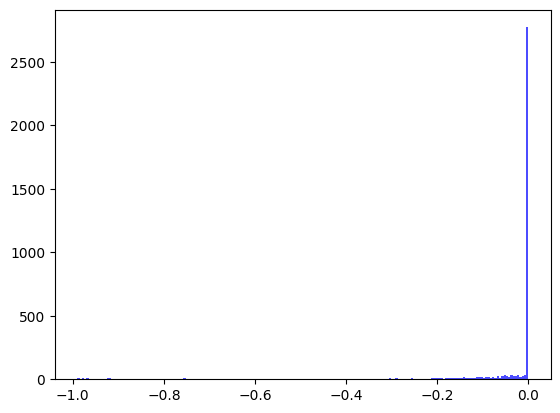

[2023-10-02T01:37:17.736990+00:00] Epochs 30, total loss: 5.83120e+03
[2023-10-02T01:37:17.737262+00:00] Training llk: -8.59357e-01
[2023-10-02T01:37:17.737354+00:00] Testing llk: -1.31363e+00
[2023-10-02T01:37:17.737430+00:00] MAE:0.14076, MRE:0.79871
saving model


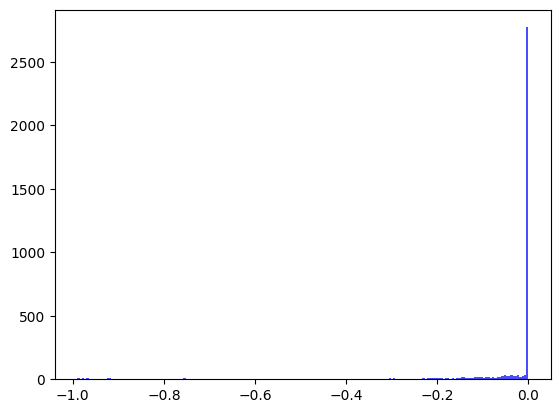

[2023-10-02T01:37:19.284799+00:00] Epochs 31, total loss: 5.77137e+03
[2023-10-02T01:37:19.285016+00:00] Training llk: -8.51554e-01
[2023-10-02T01:37:19.285120+00:00] Testing llk: -1.30225e+00
[2023-10-02T01:37:19.285192+00:00] MAE:0.13828, MRE:0.78221
saving model


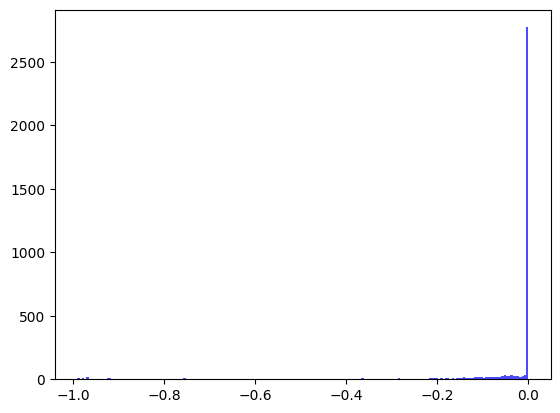

[2023-10-02T01:37:20.592062+00:00] Epochs 32, total loss: 5.71437e+03
[2023-10-02T01:37:20.592408+00:00] Training llk: -8.44153e-01
[2023-10-02T01:37:20.592520+00:00] Testing llk: -1.29144e+00
[2023-10-02T01:37:20.592591+00:00] MAE:0.13591, MRE:0.76620
saving model


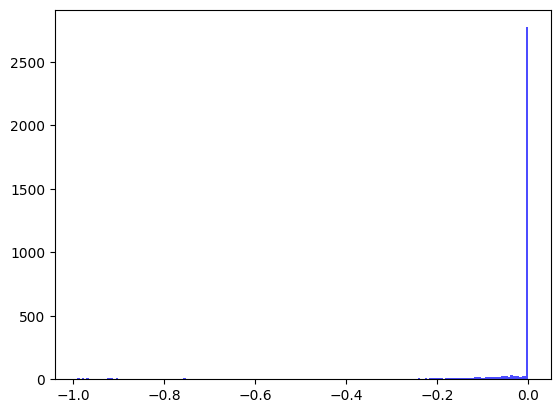

[2023-10-02T01:37:21.981789+00:00] Epochs 33, total loss: 5.66006e+03
[2023-10-02T01:37:21.983185+00:00] Training llk: -8.37133e-01
[2023-10-02T01:37:21.983774+00:00] Testing llk: -1.28118e+00
[2023-10-02T01:37:21.984323+00:00] MAE:0.13364, MRE:0.75068
saving model


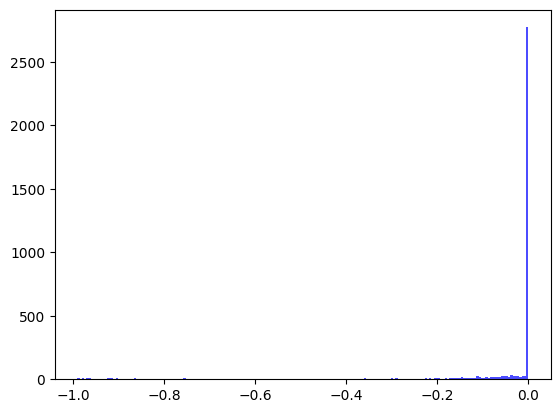

[2023-10-02T01:37:23.332801+00:00] Epochs 34, total loss: 5.60831e+03
[2023-10-02T01:37:23.333099+00:00] Training llk: -8.30473e-01
[2023-10-02T01:37:23.333239+00:00] Testing llk: -1.27144e+00
[2023-10-02T01:37:23.333337+00:00] MAE:0.13151, MRE:0.73565
saving model


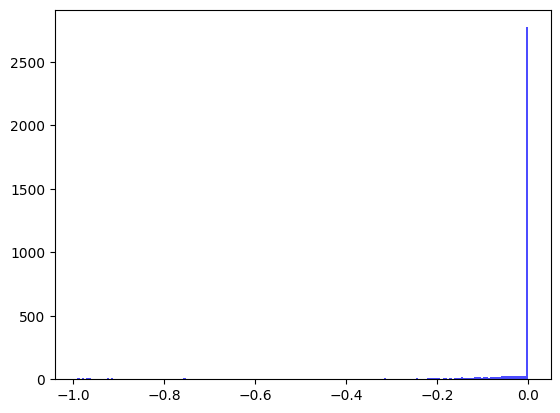

[2023-10-02T01:37:24.680616+00:00] Epochs 35, total loss: 5.55898e+03
[2023-10-02T01:37:24.680863+00:00] Training llk: -8.24154e-01
[2023-10-02T01:37:24.680949+00:00] Testing llk: -1.26220e+00
[2023-10-02T01:37:24.681018+00:00] MAE:0.12946, MRE:0.72108
saving model


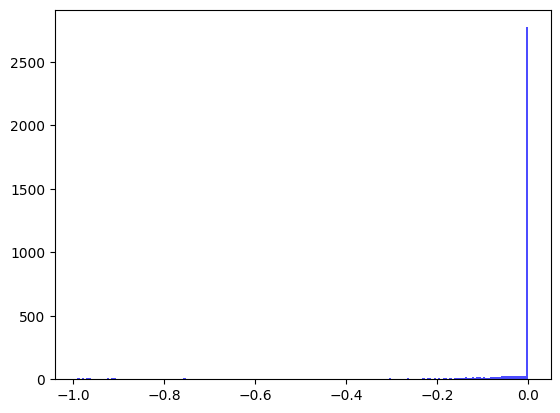

[2023-10-02T01:37:25.985529+00:00] Epochs 36, total loss: 5.51195e+03
[2023-10-02T01:37:25.985765+00:00] Training llk: -8.18158e-01
[2023-10-02T01:37:25.985849+00:00] Testing llk: -1.25342e+00
[2023-10-02T01:37:25.985919+00:00] MAE:0.12753, MRE:0.70698
saving model


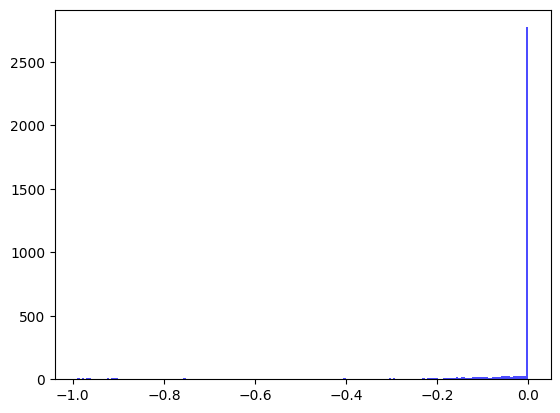

[2023-10-02T01:37:27.714739+00:00] Epochs 37, total loss: 5.46711e+03
[2023-10-02T01:37:27.715989+00:00] Training llk: -8.12468e-01
[2023-10-02T01:37:27.716623+00:00] Testing llk: -1.24508e+00
[2023-10-02T01:37:27.721487+00:00] MAE:0.12569, MRE:0.69334
saving model


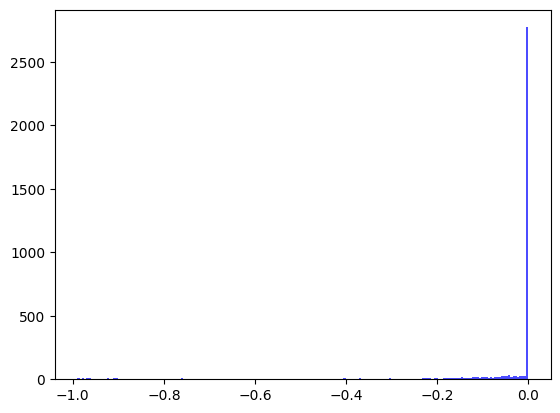

[2023-10-02T01:37:29.695852+00:00] Epochs 38, total loss: 5.42433e+03
[2023-10-02T01:37:29.701113+00:00] Training llk: -8.07066e-01
[2023-10-02T01:37:29.701720+00:00] Testing llk: -1.23716e+00
[2023-10-02T01:37:29.702255+00:00] MAE:0.12393, MRE:0.68013
saving model


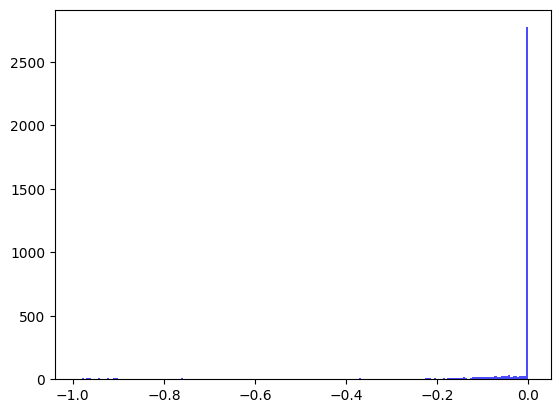

[2023-10-02T01:37:31.186748+00:00] Epochs 39, total loss: 5.38352e+03
[2023-10-02T01:37:31.187070+00:00] Training llk: -8.01937e-01
[2023-10-02T01:37:31.187187+00:00] Testing llk: -1.22963e+00
[2023-10-02T01:37:31.187270+00:00] MAE:0.12227, MRE:0.66735
saving model


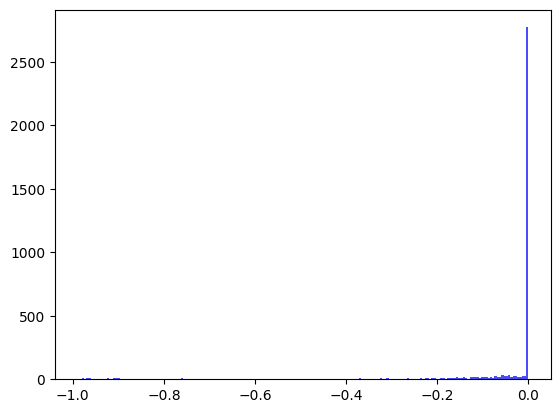

[2023-10-02T01:37:32.518205+00:00] Epochs 40, total loss: 5.34457e+03
[2023-10-02T01:37:32.518437+00:00] Training llk: -7.97065e-01
[2023-10-02T01:37:32.518533+00:00] Testing llk: -1.22248e+00
[2023-10-02T01:37:32.518599+00:00] MAE:0.12068, MRE:0.65498
saving model


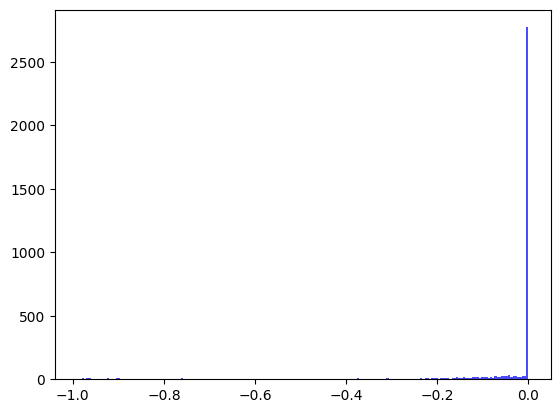

[2023-10-02T01:37:33.836378+00:00] Epochs 41, total loss: 5.30738e+03
[2023-10-02T01:37:33.837463+00:00] Training llk: -7.92438e-01
[2023-10-02T01:37:33.838040+00:00] Testing llk: -1.21569e+00
[2023-10-02T01:37:33.838556+00:00] MAE:0.11918, MRE:0.64303
saving model


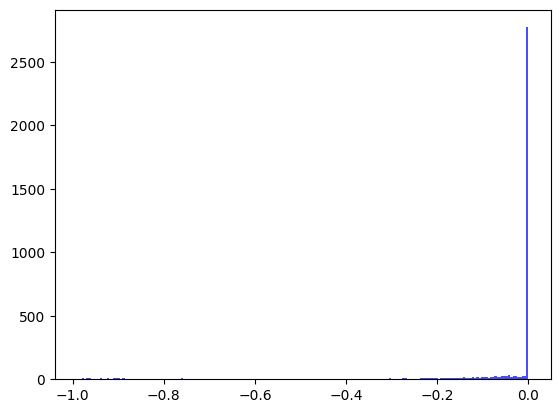

[2023-10-02T01:37:35.375856+00:00] Epochs 42, total loss: 5.27187e+03
[2023-10-02T01:37:35.377182+00:00] Training llk: -7.88040e-01
[2023-10-02T01:37:35.377865+00:00] Testing llk: -1.20923e+00
[2023-10-02T01:37:35.379211+00:00] MAE:0.11777, MRE:0.63147
saving model


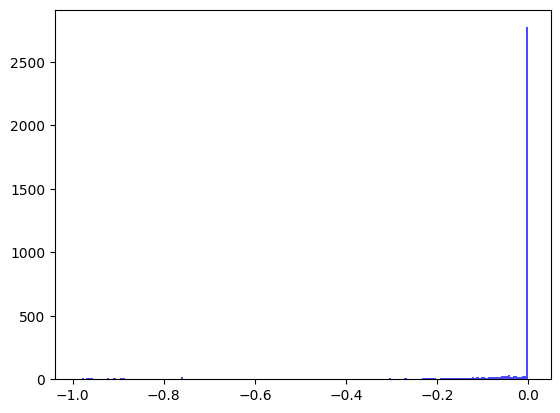

[2023-10-02T01:37:36.715093+00:00] Epochs 43, total loss: 5.23794e+03
[2023-10-02T01:37:36.715349+00:00] Training llk: -7.83861e-01
[2023-10-02T01:37:36.715448+00:00] Testing llk: -1.20309e+00
[2023-10-02T01:37:36.715532+00:00] MAE:0.11643, MRE:0.62030
saving model


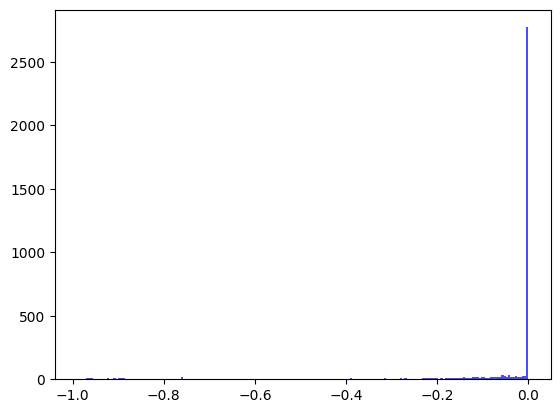

[2023-10-02T01:37:38.058173+00:00] Epochs 44, total loss: 5.20551e+03
[2023-10-02T01:37:38.058472+00:00] Training llk: -7.79886e-01
[2023-10-02T01:37:38.058560+00:00] Testing llk: -1.19725e+00
[2023-10-02T01:37:38.058633+00:00] MAE:0.11520, MRE:0.60951
saving model


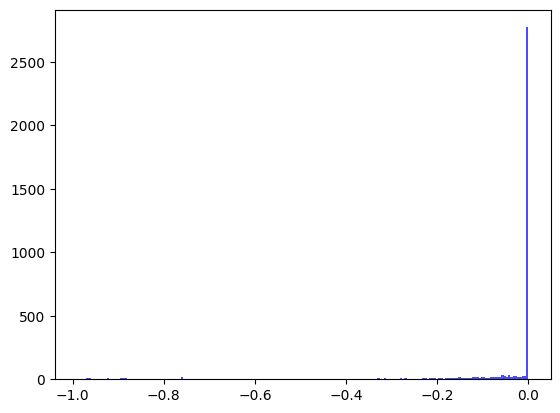

[2023-10-02T01:37:39.373849+00:00] Epochs 45, total loss: 5.17452e+03
[2023-10-02T01:37:39.374092+00:00] Training llk: -7.76106e-01
[2023-10-02T01:37:39.374190+00:00] Testing llk: -1.19169e+00
[2023-10-02T01:37:39.374266+00:00] MAE:0.11408, MRE:0.59911
saving model


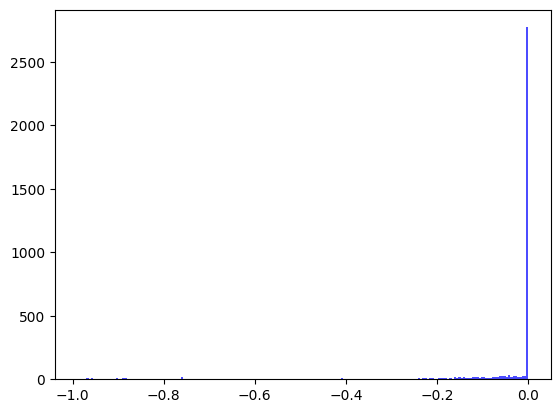

[2023-10-02T01:37:41.007719+00:00] Epochs 46, total loss: 5.14487e+03
[2023-10-02T01:37:41.008891+00:00] Training llk: -7.72510e-01
[2023-10-02T01:37:41.009439+00:00] Testing llk: -1.18640e+00
[2023-10-02T01:37:41.009947+00:00] MAE:0.11303, MRE:0.58905
saving model


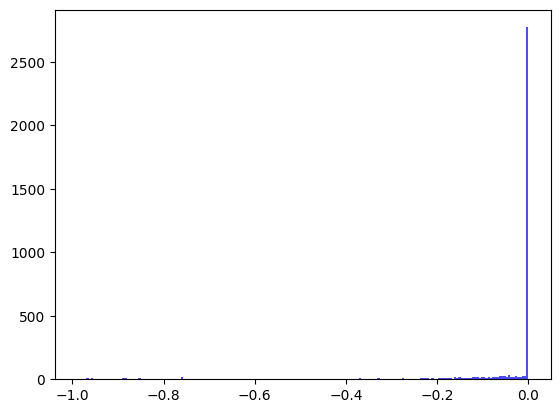

[2023-10-02T01:37:42.951199+00:00] Epochs 47, total loss: 5.11651e+03
[2023-10-02T01:37:42.952354+00:00] Training llk: -7.69087e-01
[2023-10-02T01:37:42.952884+00:00] Testing llk: -1.18137e+00
[2023-10-02T01:37:42.953409+00:00] MAE:0.11205, MRE:0.57933
saving model


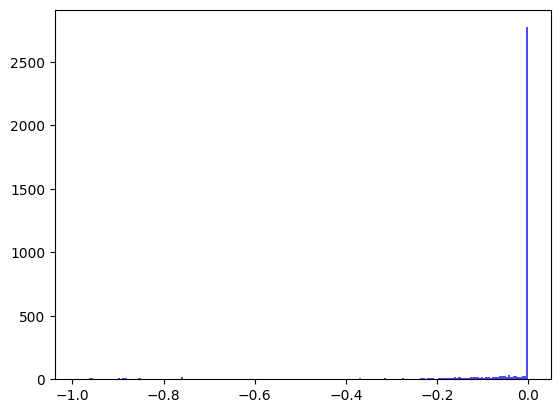

[2023-10-02T01:37:44.532740+00:00] Epochs 48, total loss: 5.08937e+03
[2023-10-02T01:37:44.533014+00:00] Training llk: -7.65828e-01
[2023-10-02T01:37:44.533130+00:00] Testing llk: -1.17657e+00
[2023-10-02T01:37:44.533212+00:00] MAE:0.11114, MRE:0.56994
saving model


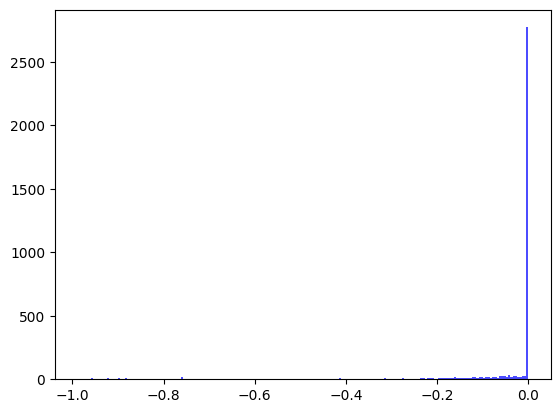

[2023-10-02T01:37:45.863198+00:00] Epochs 49, total loss: 5.06338e+03
[2023-10-02T01:37:45.863451+00:00] Training llk: -7.62724e-01
[2023-10-02T01:37:45.863532+00:00] Testing llk: -1.17201e+00
[2023-10-02T01:37:45.863599+00:00] MAE:0.11029, MRE:0.56085
saving model


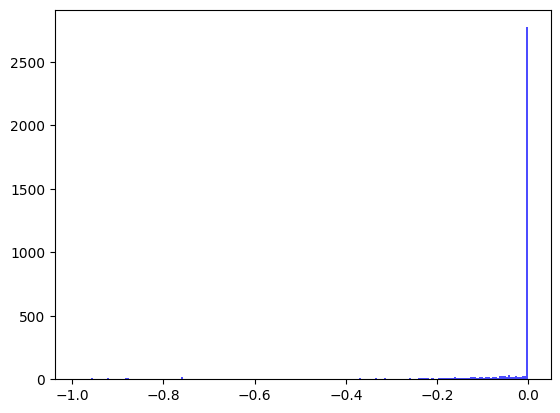

[2023-10-02T01:37:47.183359+00:00] Epochs 50, total loss: 5.03849e+03
[2023-10-02T01:37:47.183645+00:00] Training llk: -7.59768e-01
[2023-10-02T01:37:47.183776+00:00] Testing llk: -1.16766e+00
[2023-10-02T01:37:47.183849+00:00] MAE:0.10948, MRE:0.55205
saving model


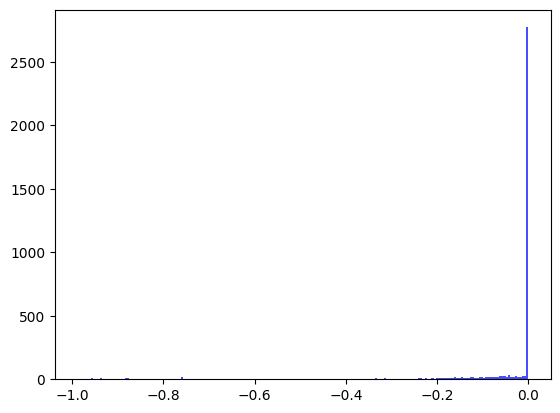

[2023-10-02T01:37:48.516313+00:00] Epochs 51, total loss: 5.01464e+03
[2023-10-02T01:37:48.516584+00:00] Training llk: -7.56950e-01
[2023-10-02T01:37:48.516751+00:00] Testing llk: -1.16351e+00
[2023-10-02T01:37:48.516834+00:00] MAE:0.10872, MRE:0.54353
saving model


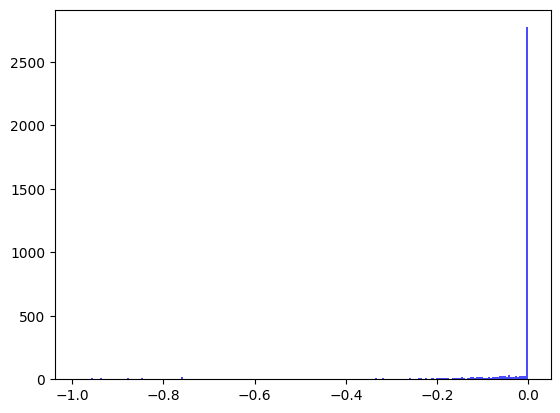

[2023-10-02T01:37:49.839895+00:00] Epochs 52, total loss: 4.99179e+03
[2023-10-02T01:37:49.841014+00:00] Training llk: -7.54264e-01
[2023-10-02T01:37:49.841563+00:00] Testing llk: -1.15956e+00
[2023-10-02T01:37:49.842094+00:00] MAE:0.10799, MRE:0.53528
saving model


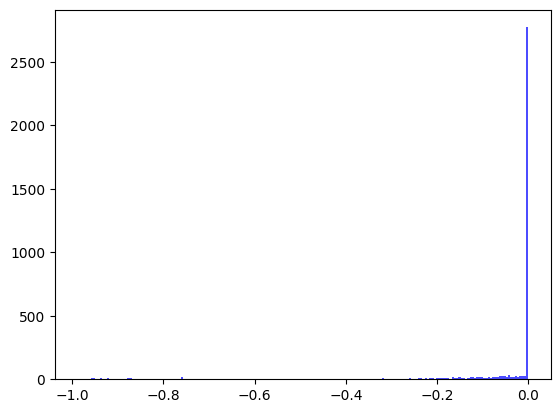

[2023-10-02T01:37:51.407345+00:00] Epochs 53, total loss: 4.96988e+03
[2023-10-02T01:37:51.407572+00:00] Training llk: -7.51703e-01
[2023-10-02T01:37:51.407662+00:00] Testing llk: -1.15580e+00
[2023-10-02T01:37:51.407771+00:00] MAE:0.10729, MRE:0.52728
saving model


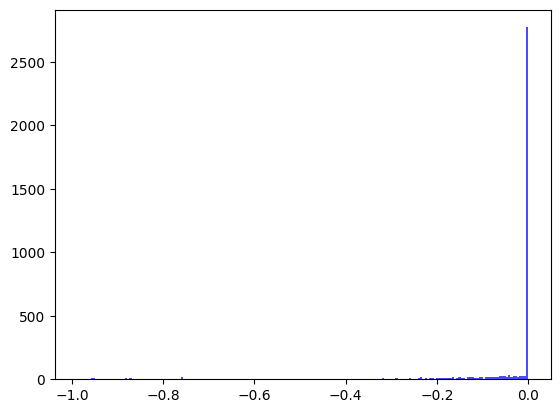

[2023-10-02T01:37:52.729122+00:00] Epochs 54, total loss: 4.94887e+03
[2023-10-02T01:37:52.729346+00:00] Training llk: -7.49259e-01
[2023-10-02T01:37:52.729433+00:00] Testing llk: -1.15220e+00
[2023-10-02T01:37:52.729506+00:00] MAE:0.10664, MRE:0.51954
saving model


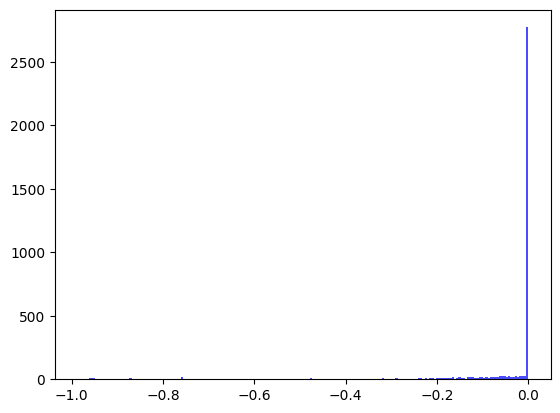

[2023-10-02T01:37:54.744236+00:00] Epochs 55, total loss: 4.92870e+03
[2023-10-02T01:37:54.744500+00:00] Training llk: -7.46927e-01
[2023-10-02T01:37:54.744603+00:00] Testing llk: -1.14877e+00
[2023-10-02T01:37:54.744690+00:00] MAE:0.10603, MRE:0.51204
saving model


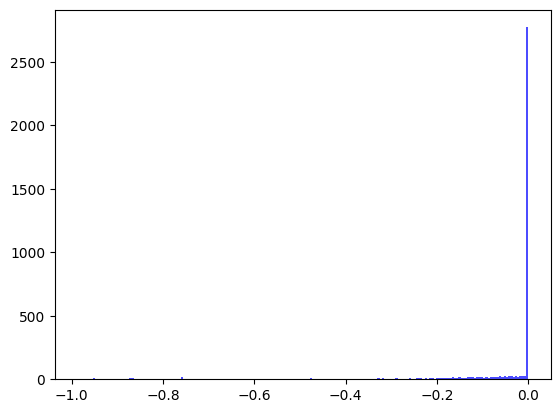

[2023-10-02T01:37:56.828600+00:00] Epochs 56, total loss: 4.90935e+03
[2023-10-02T01:37:56.832179+00:00] Training llk: -7.44702e-01
[2023-10-02T01:37:56.832357+00:00] Testing llk: -1.14550e+00
[2023-10-02T01:37:56.832465+00:00] MAE:0.10546, MRE:0.50477
saving model


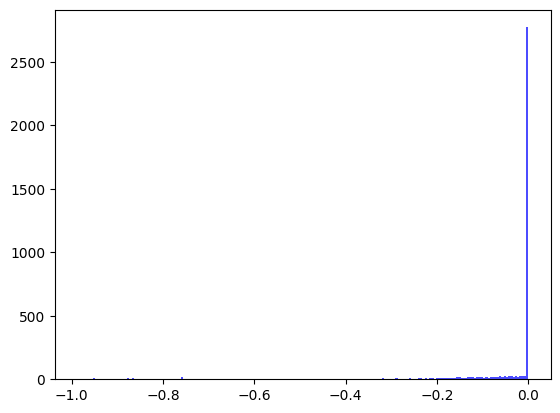

[2023-10-02T01:37:58.635015+00:00] Epochs 57, total loss: 4.89078e+03
[2023-10-02T01:37:58.635248+00:00] Training llk: -7.42576e-01
[2023-10-02T01:37:58.635331+00:00] Testing llk: -1.14238e+00
[2023-10-02T01:37:58.635401+00:00] MAE:0.10493, MRE:0.49773
saving model


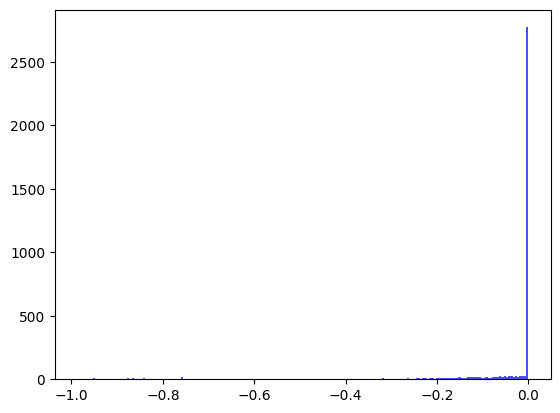

[2023-10-02T01:38:00.002181+00:00] Epochs 58, total loss: 4.87293e+03
[2023-10-02T01:38:00.003273+00:00] Training llk: -7.40546e-01
[2023-10-02T01:38:00.003782+00:00] Testing llk: -1.13940e+00
[2023-10-02T01:38:00.004288+00:00] MAE:0.10444, MRE:0.49091
saving model


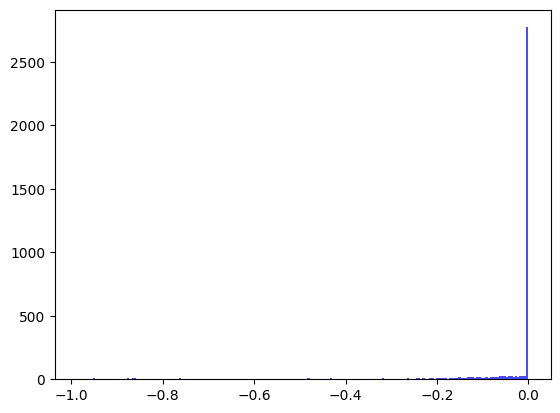

[2023-10-02T01:38:01.600295+00:00] Epochs 59, total loss: 4.85579e+03
[2023-10-02T01:38:01.601620+00:00] Training llk: -7.38607e-01
[2023-10-02T01:38:01.602176+00:00] Testing llk: -1.13655e+00
[2023-10-02T01:38:01.602664+00:00] MAE:0.10400, MRE:0.48431
saving model


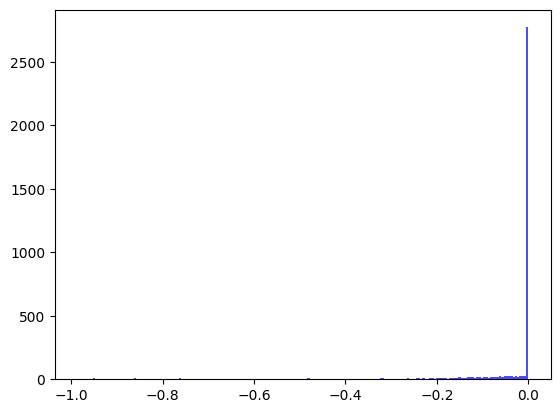

[2023-10-02T01:38:02.937578+00:00] Epochs 60, total loss: 4.83932e+03
[2023-10-02T01:38:02.937807+00:00] Training llk: -7.36753e-01
[2023-10-02T01:38:02.937894+00:00] Testing llk: -1.13383e+00
[2023-10-02T01:38:02.937965+00:00] MAE:0.10361, MRE:0.47792
saving model


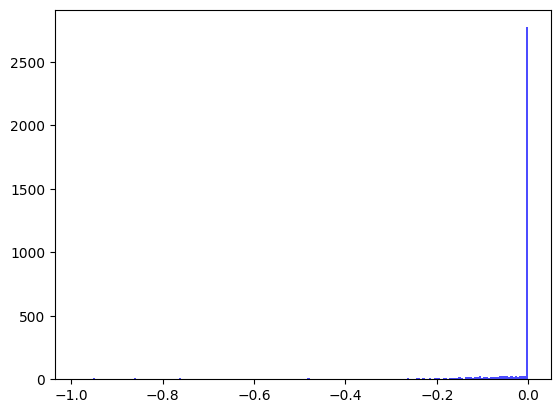

[2023-10-02T01:38:04.229196+00:00] Epochs 61, total loss: 4.82348e+03
[2023-10-02T01:38:04.229415+00:00] Training llk: -7.34981e-01
[2023-10-02T01:38:04.229496+00:00] Testing llk: -1.13123e+00
[2023-10-02T01:38:04.229562+00:00] MAE:0.10325, MRE:0.47174
saving model


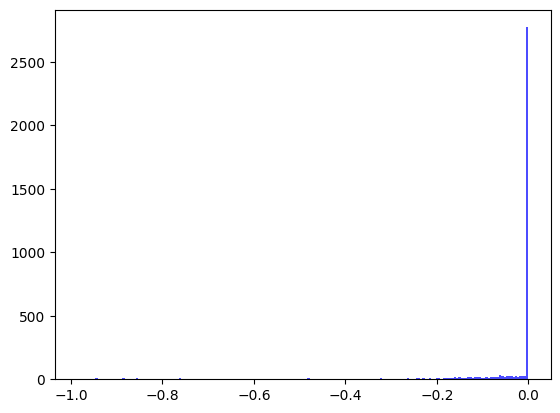

[2023-10-02T01:38:05.534392+00:00] Epochs 62, total loss: 4.80825e+03
[2023-10-02T01:38:05.534614+00:00] Training llk: -7.33286e-01
[2023-10-02T01:38:05.534695+00:00] Testing llk: -1.12874e+00
[2023-10-02T01:38:05.534766+00:00] MAE:0.10292, MRE:0.46573
saving model


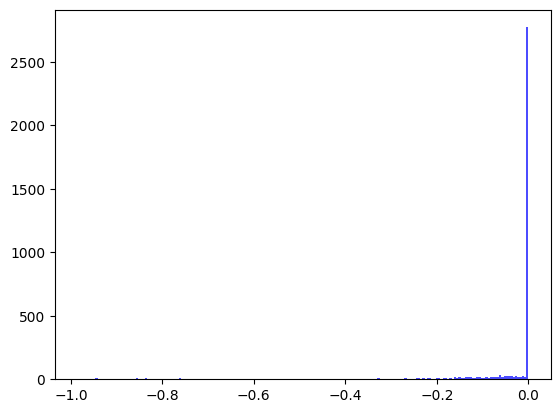

[2023-10-02T01:38:06.827108+00:00] Epochs 63, total loss: 4.79360e+03
[2023-10-02T01:38:06.827336+00:00] Training llk: -7.31664e-01
[2023-10-02T01:38:06.827419+00:00] Testing llk: -1.12636e+00
[2023-10-02T01:38:06.827487+00:00] MAE:0.10261, MRE:0.45990
saving model


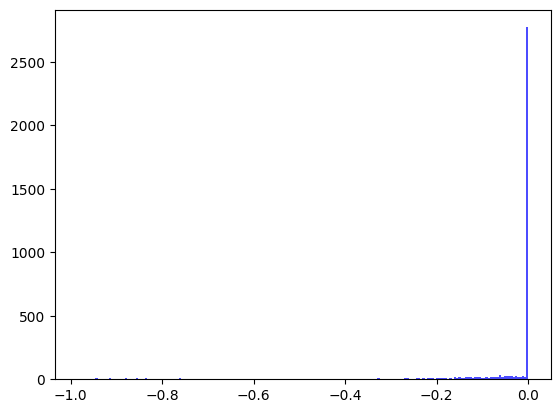

[2023-10-02T01:38:08.708588+00:00] Epochs 64, total loss: 4.77951e+03
[2023-10-02T01:38:08.713177+00:00] Training llk: -7.30113e-01
[2023-10-02T01:38:08.713746+00:00] Testing llk: -1.12409e+00
[2023-10-02T01:38:08.714267+00:00] MAE:0.10232, MRE:0.45425
saving model


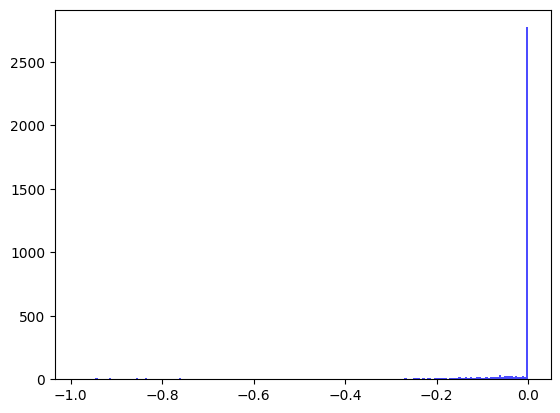

[2023-10-02T01:38:10.579627+00:00] Epochs 65, total loss: 4.76594e+03
[2023-10-02T01:38:10.579859+00:00] Training llk: -7.28628e-01
[2023-10-02T01:38:10.579941+00:00] Testing llk: -1.12192e+00
[2023-10-02T01:38:10.580009+00:00] MAE:0.10204, MRE:0.44875
saving model


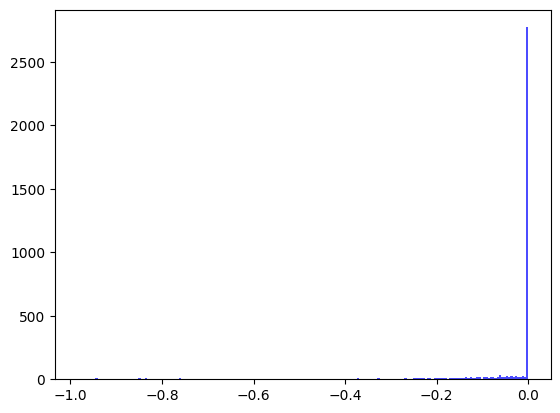

[2023-10-02T01:38:11.950235+00:00] Epochs 66, total loss: 4.75288e+03
[2023-10-02T01:38:11.950486+00:00] Training llk: -7.27205e-01
[2023-10-02T01:38:11.950569+00:00] Testing llk: -1.11984e+00
[2023-10-02T01:38:11.950641+00:00] MAE:0.10178, MRE:0.44341
saving model


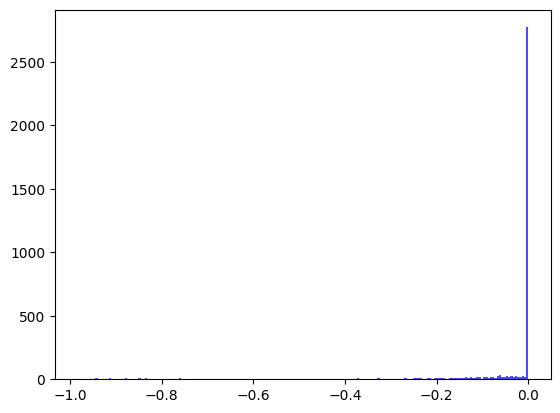

[2023-10-02T01:38:13.267746+00:00] Epochs 67, total loss: 4.74029e+03
[2023-10-02T01:38:13.267982+00:00] Training llk: -7.25843e-01
[2023-10-02T01:38:13.268088+00:00] Testing llk: -1.11784e+00
[2023-10-02T01:38:13.268163+00:00] MAE:0.10154, MRE:0.43822
saving model


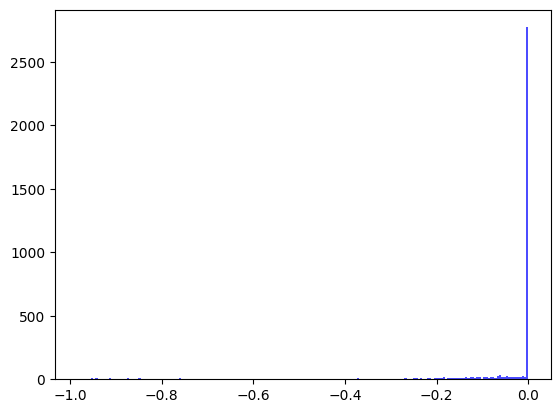

[2023-10-02T01:38:14.558817+00:00] Epochs 68, total loss: 4.72817e+03
[2023-10-02T01:38:14.559049+00:00] Training llk: -7.24539e-01
[2023-10-02T01:38:14.559146+00:00] Testing llk: -1.11594e+00
[2023-10-02T01:38:14.559218+00:00] MAE:0.10133, MRE:0.43318
saving model


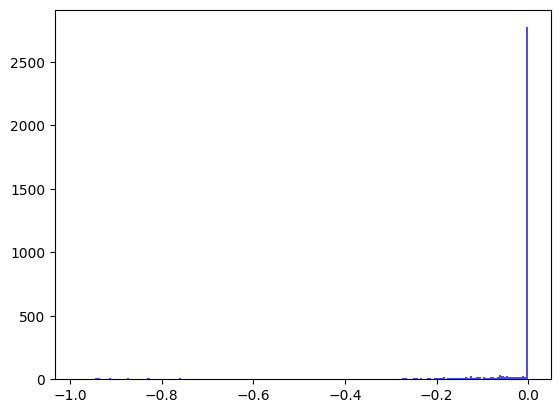

[2023-10-02T01:38:16.165404+00:00] Epochs 69, total loss: 4.71650e+03
[2023-10-02T01:38:16.166306+00:00] Training llk: -7.23288e-01
[2023-10-02T01:38:16.166435+00:00] Testing llk: -1.11411e+00
[2023-10-02T01:38:16.168733+00:00] MAE:0.10113, MRE:0.42828
saving model


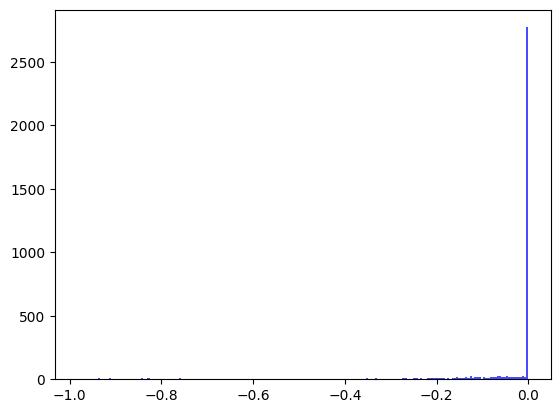

[2023-10-02T01:38:17.503561+00:00] Epochs 70, total loss: 4.70524e+03
[2023-10-02T01:38:17.503795+00:00] Training llk: -7.22089e-01
[2023-10-02T01:38:17.503885+00:00] Testing llk: -1.11237e+00
[2023-10-02T01:38:17.503956+00:00] MAE:0.10095, MRE:0.42352
saving model


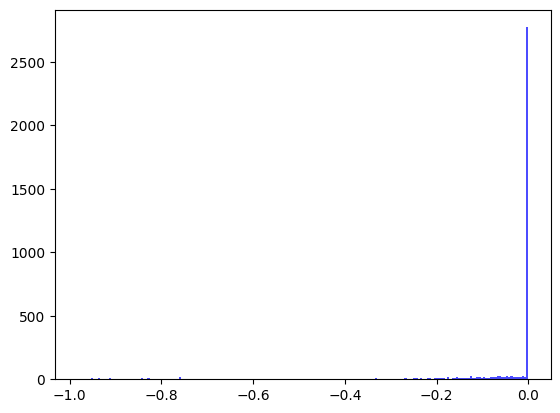

[2023-10-02T01:38:18.832912+00:00] Epochs 71, total loss: 4.69438e+03
[2023-10-02T01:38:18.836025+00:00] Training llk: -7.20940e-01
[2023-10-02T01:38:18.836613+00:00] Testing llk: -1.11069e+00
[2023-10-02T01:38:18.837133+00:00] MAE:0.10080, MRE:0.41889
saving model


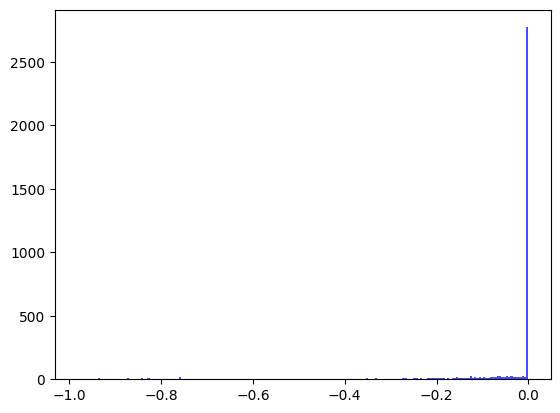

[2023-10-02T01:38:20.155734+00:00] Epochs 72, total loss: 4.68392e+03
[2023-10-02T01:38:20.155968+00:00] Training llk: -7.19838e-01
[2023-10-02T01:38:20.156068+00:00] Testing llk: -1.10909e+00
[2023-10-02T01:38:20.156146+00:00] MAE:0.10065, MRE:0.41439
saving model


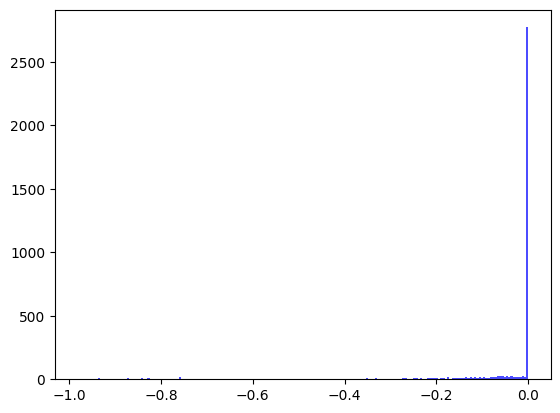

[2023-10-02T01:38:22.021667+00:00] Epochs 73, total loss: 4.67382e+03
[2023-10-02T01:38:22.022831+00:00] Training llk: -7.18780e-01
[2023-10-02T01:38:22.023384+00:00] Testing llk: -1.10755e+00
[2023-10-02T01:38:22.023917+00:00] MAE:0.10052, MRE:0.41001
saving model


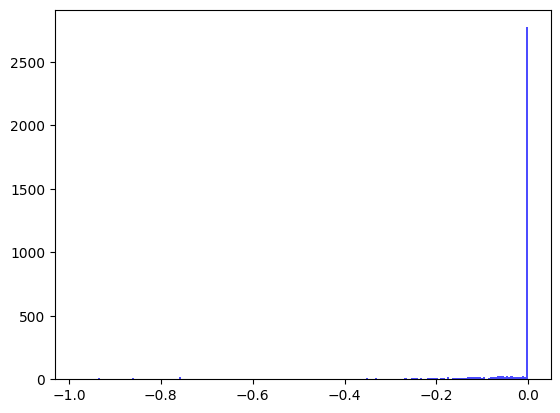

[2023-10-02T01:38:23.731441+00:00] Epochs 74, total loss: 4.66407e+03
[2023-10-02T01:38:23.731646+00:00] Training llk: -7.17765e-01
[2023-10-02T01:38:23.731738+00:00] Testing llk: -1.10608e+00
[2023-10-02T01:38:23.731814+00:00] MAE:0.10040, MRE:0.40574
saving model


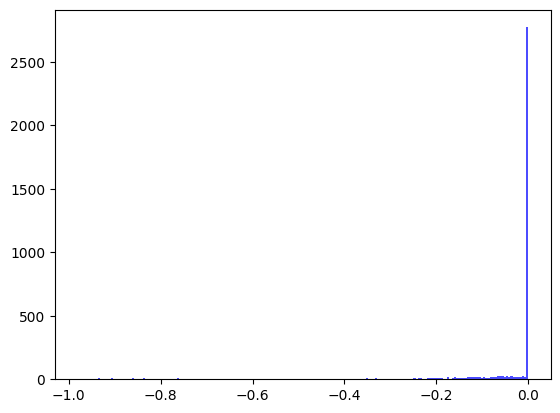

[2023-10-02T01:38:25.288526+00:00] Epochs 75, total loss: 4.65467e+03
[2023-10-02T01:38:25.288752+00:00] Training llk: -7.16791e-01
[2023-10-02T01:38:25.288835+00:00] Testing llk: -1.10467e+00
[2023-10-02T01:38:25.288903+00:00] MAE:0.10029, MRE:0.40159
saving model


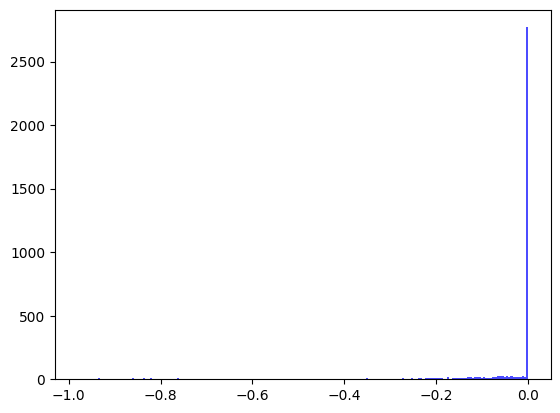

[2023-10-02T01:38:26.616183+00:00] Epochs 76, total loss: 4.64559e+03
[2023-10-02T01:38:26.616431+00:00] Training llk: -7.15855e-01
[2023-10-02T01:38:26.616518+00:00] Testing llk: -1.10331e+00
[2023-10-02T01:38:26.616592+00:00] MAE:0.10020, MRE:0.39755
saving model


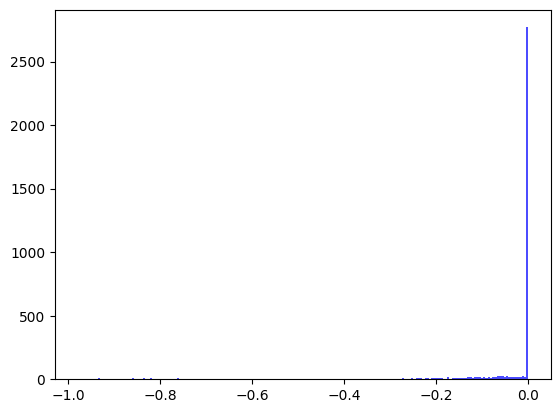

[2023-10-02T01:38:27.941547+00:00] Epochs 77, total loss: 4.63682e+03
[2023-10-02T01:38:27.941802+00:00] Training llk: -7.14957e-01
[2023-10-02T01:38:27.941891+00:00] Testing llk: -1.10201e+00
[2023-10-02T01:38:27.941964+00:00] MAE:0.10013, MRE:0.39361
saving model


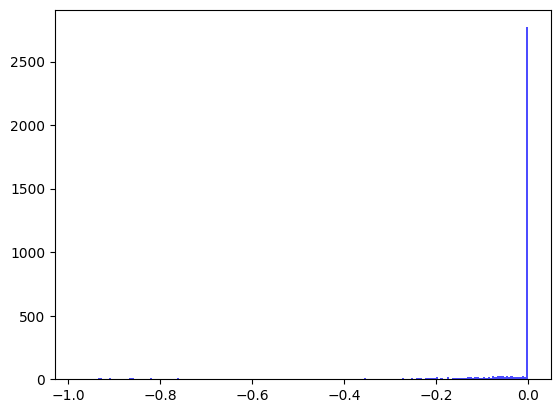

[2023-10-02T01:38:29.257394+00:00] Epochs 78, total loss: 4.62835e+03
[2023-10-02T01:38:29.257652+00:00] Training llk: -7.14094e-01
[2023-10-02T01:38:29.257740+00:00] Testing llk: -1.10077e+00
[2023-10-02T01:38:29.257826+00:00] MAE:0.10006, MRE:0.38978
saving model


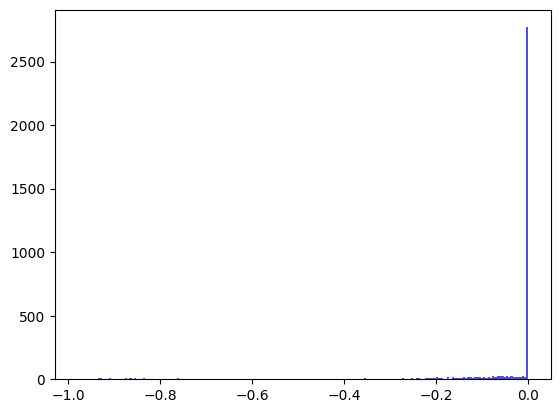

[2023-10-02T01:38:30.532489+00:00] Epochs 79, total loss: 4.62017e+03
[2023-10-02T01:38:30.532735+00:00] Training llk: -7.13264e-01
[2023-10-02T01:38:30.532825+00:00] Testing llk: -1.09957e+00
[2023-10-02T01:38:30.532898+00:00] MAE:0.10000, MRE:0.38605
saving model


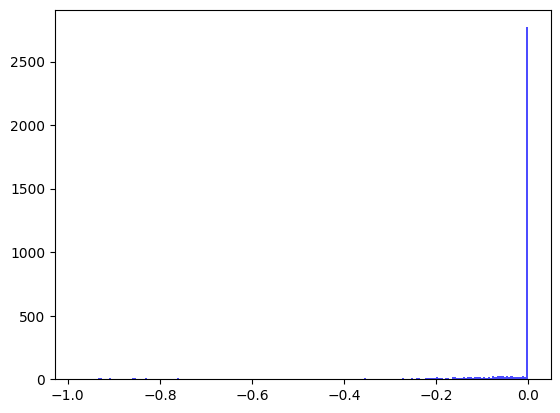

[2023-10-02T01:38:32.130472+00:00] Epochs 80, total loss: 4.61226e+03
[2023-10-02T01:38:32.130692+00:00] Training llk: -7.12467e-01
[2023-10-02T01:38:32.130785+00:00] Testing llk: -1.09842e+00
[2023-10-02T01:38:32.130857+00:00] MAE:0.09997, MRE:0.38242
saving model


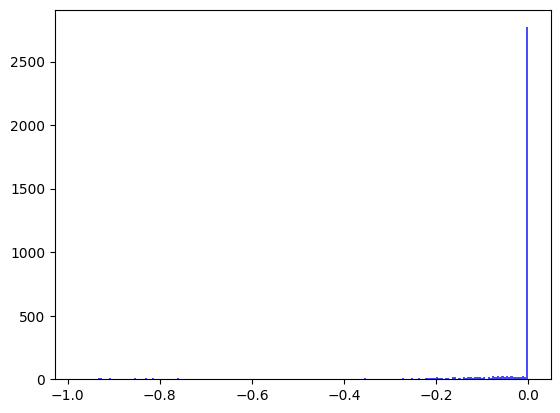

[2023-10-02T01:38:33.667955+00:00] Epochs 81, total loss: 4.60462e+03
[2023-10-02T01:38:33.669134+00:00] Training llk: -7.11700e-01
[2023-10-02T01:38:33.669702+00:00] Testing llk: -1.09732e+00
[2023-10-02T01:38:33.670269+00:00] MAE:0.09993, MRE:0.37887
saving model


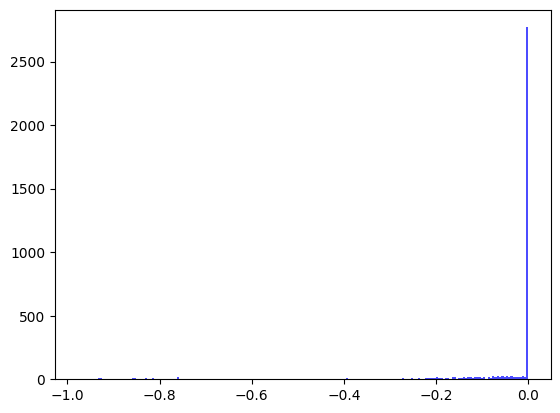

[2023-10-02T01:38:35.635391+00:00] Epochs 82, total loss: 4.59723e+03
[2023-10-02T01:38:35.636542+00:00] Training llk: -7.10963e-01
[2023-10-02T01:38:35.637083+00:00] Testing llk: -1.09626e+00
[2023-10-02T01:38:35.637583+00:00] MAE:0.09992, MRE:0.37542
saving model


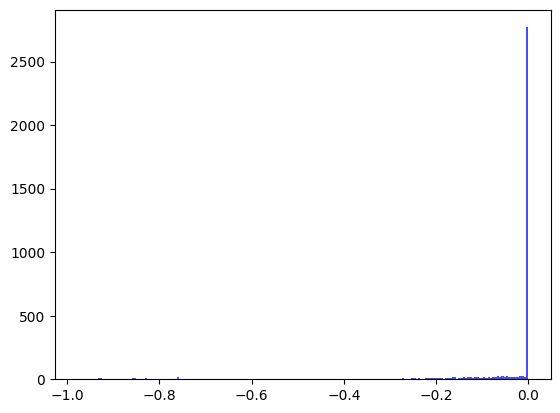

[2023-10-02T01:38:37.159243+00:00] Epochs 83, total loss: 4.59009e+03
[2023-10-02T01:38:37.159515+00:00] Training llk: -7.10254e-01
[2023-10-02T01:38:37.159634+00:00] Testing llk: -1.09525e+00
[2023-10-02T01:38:37.159730+00:00] MAE:0.09991, MRE:0.37205
saving model


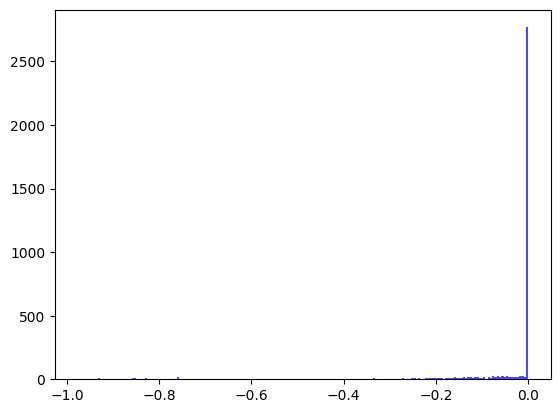

[2023-10-02T01:38:38.483532+00:00] Epochs 84, total loss: 4.58318e+03
[2023-10-02T01:38:38.484920+00:00] Training llk: -7.09571e-01
[2023-10-02T01:38:38.485628+00:00] Testing llk: -1.09427e+00
[2023-10-02T01:38:38.488783+00:00] MAE:0.09991, MRE:0.36877
saving model


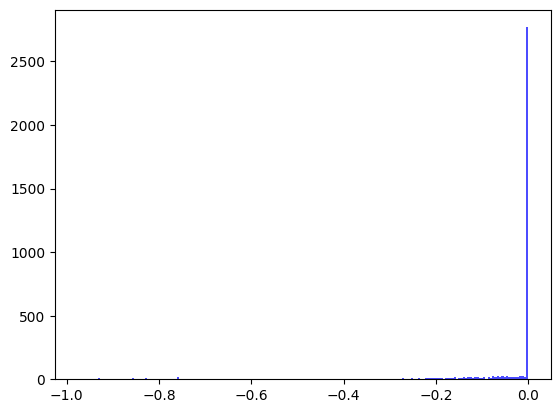

[2023-10-02T01:38:39.846711+00:00] Epochs 85, total loss: 4.57649e+03
[2023-10-02T01:38:39.846981+00:00] Training llk: -7.08914e-01
[2023-10-02T01:38:39.847111+00:00] Testing llk: -1.09334e+00
[2023-10-02T01:38:39.847218+00:00] MAE:0.09992, MRE:0.36557
saving model


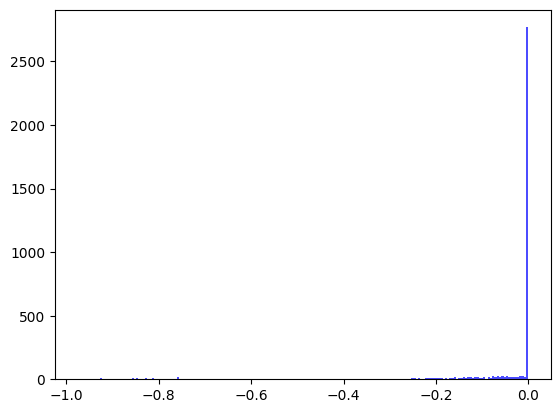

[2023-10-02T01:38:41.439203+00:00] Epochs 86, total loss: 4.57002e+03
[2023-10-02T01:38:41.440345+00:00] Training llk: -7.08282e-01
[2023-10-02T01:38:41.440865+00:00] Testing llk: -1.09244e+00
[2023-10-02T01:38:41.441362+00:00] MAE:0.09993, MRE:0.36245
saving model


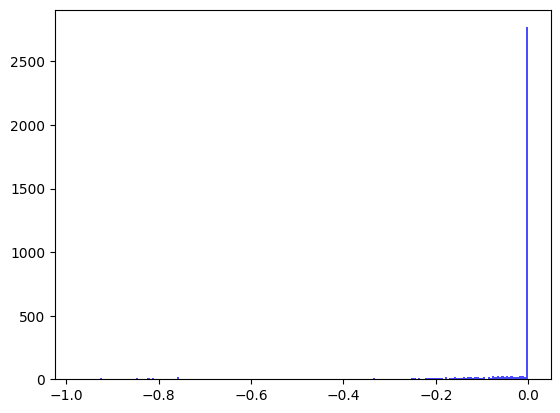

[2023-10-02T01:38:42.776480+00:00] Epochs 87, total loss: 4.56376e+03
[2023-10-02T01:38:42.777424+00:00] Training llk: -7.07673e-01
[2023-10-02T01:38:42.777887+00:00] Testing llk: -1.09157e+00
[2023-10-02T01:38:42.778369+00:00] MAE:0.09995, MRE:0.35940
saving model


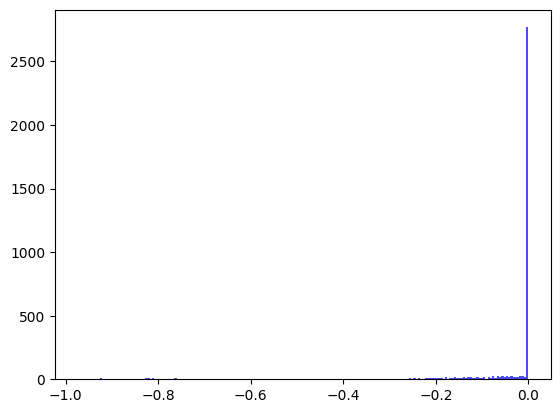

[2023-10-02T01:38:44.093157+00:00] Epochs 88, total loss: 4.55770e+03
[2023-10-02T01:38:44.093374+00:00] Training llk: -7.07086e-01
[2023-10-02T01:38:44.093457+00:00] Testing llk: -1.09074e+00
[2023-10-02T01:38:44.093528+00:00] MAE:0.09999, MRE:0.35643
saving model


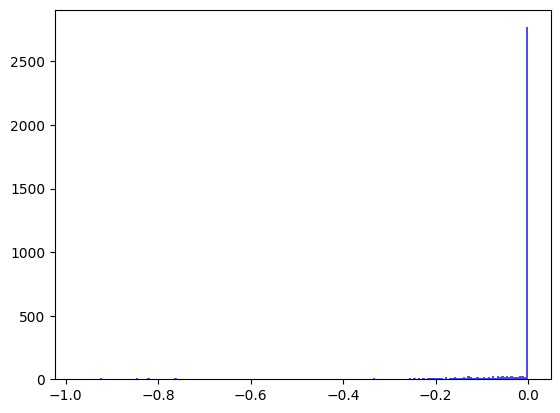

[2023-10-02T01:38:45.426176+00:00] Epochs 89, total loss: 4.55183e+03
[2023-10-02T01:38:45.426405+00:00] Training llk: -7.06520e-01
[2023-10-02T01:38:45.426487+00:00] Testing llk: -1.08994e+00
[2023-10-02T01:38:45.426555+00:00] MAE:0.10002, MRE:0.35353
saving model


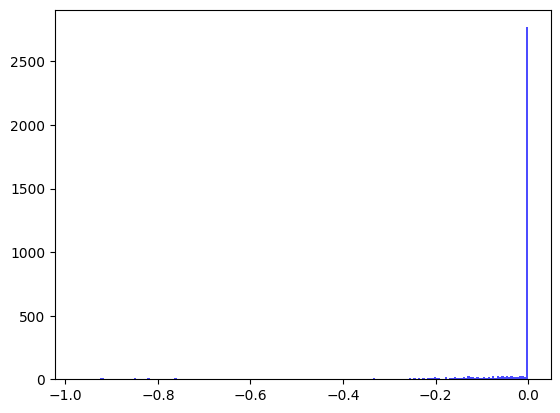

[2023-10-02T01:38:48.075336+00:00] Epochs 90, total loss: 4.54614e+03
[2023-10-02T01:38:48.076817+00:00] Training llk: -7.05975e-01
[2023-10-02T01:38:48.077413+00:00] Testing llk: -1.08917e+00
[2023-10-02T01:38:48.077909+00:00] MAE:0.10007, MRE:0.35069
saving model


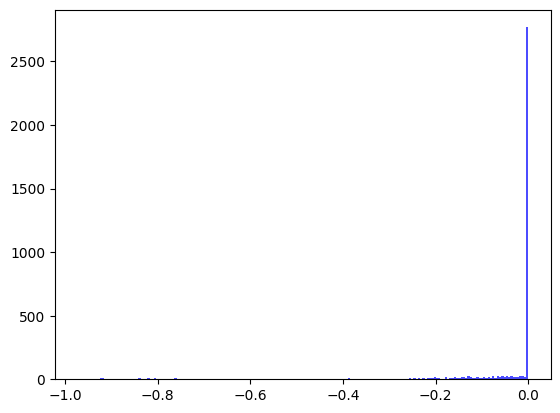

[2023-10-02T01:38:50.014209+00:00] Epochs 91, total loss: 4.54064e+03
[2023-10-02T01:38:50.014508+00:00] Training llk: -7.05449e-01
[2023-10-02T01:38:50.014607+00:00] Testing llk: -1.08843e+00
[2023-10-02T01:38:50.014695+00:00] MAE:0.10012, MRE:0.34792
saving model


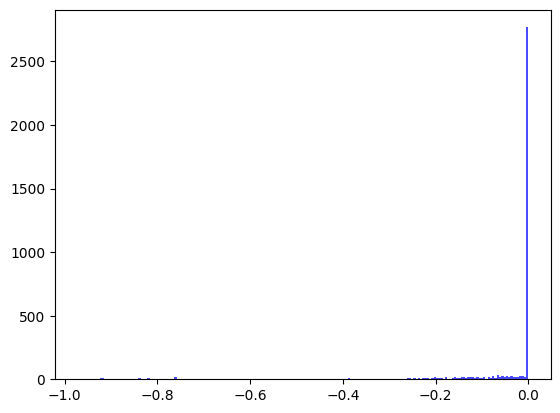

[2023-10-02T01:38:51.316517+00:00] Epochs 92, total loss: 4.53530e+03
[2023-10-02T01:38:51.316769+00:00] Training llk: -7.04942e-01
[2023-10-02T01:38:51.316861+00:00] Testing llk: -1.08772e+00
[2023-10-02T01:38:51.316937+00:00] MAE:0.10017, MRE:0.34521
saving model


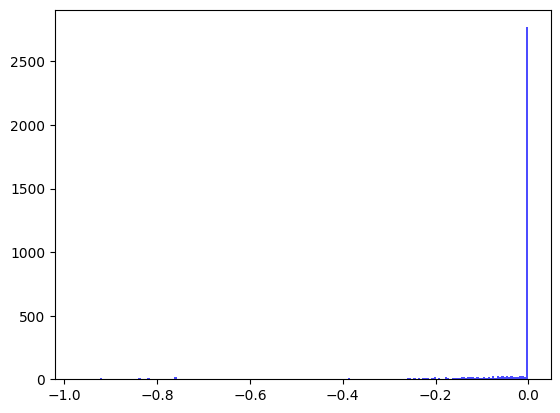

[2023-10-02T01:38:52.661126+00:00] Epochs 93, total loss: 4.53013e+03
[2023-10-02T01:38:52.661371+00:00] Training llk: -7.04453e-01
[2023-10-02T01:38:52.662609+00:00] Testing llk: -1.08703e+00
[2023-10-02T01:38:52.662753+00:00] MAE:0.10022, MRE:0.34256
saving model


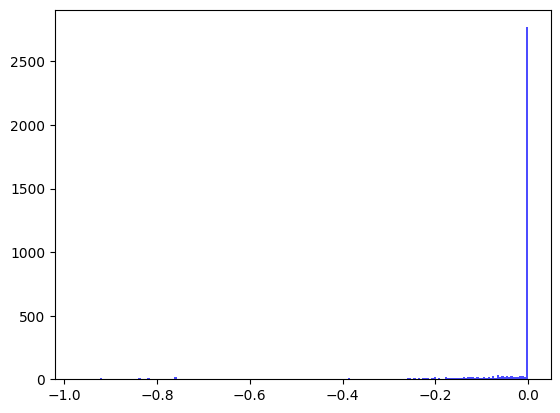

[2023-10-02T01:38:54.042357+00:00] Epochs 94, total loss: 4.52512e+03
[2023-10-02T01:38:54.042688+00:00] Training llk: -7.03980e-01
[2023-10-02T01:38:54.042792+00:00] Testing llk: -1.08637e+00
[2023-10-02T01:38:54.042888+00:00] MAE:0.10027, MRE:0.33996
saving model


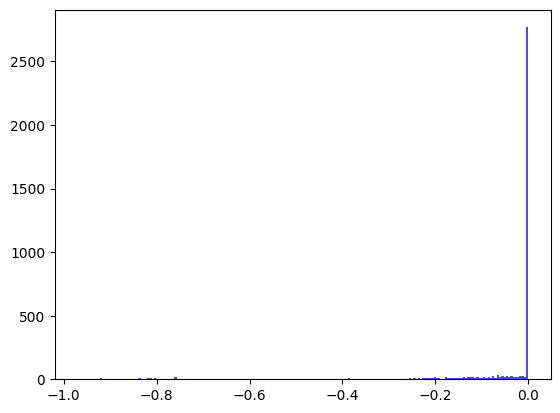

[2023-10-02T01:38:55.353189+00:00] Epochs 95, total loss: 4.52026e+03
[2023-10-02T01:38:55.354263+00:00] Training llk: -7.03524e-01
[2023-10-02T01:38:55.354787+00:00] Testing llk: -1.08574e+00
[2023-10-02T01:38:55.355313+00:00] MAE:0.10033, MRE:0.33742
saving model


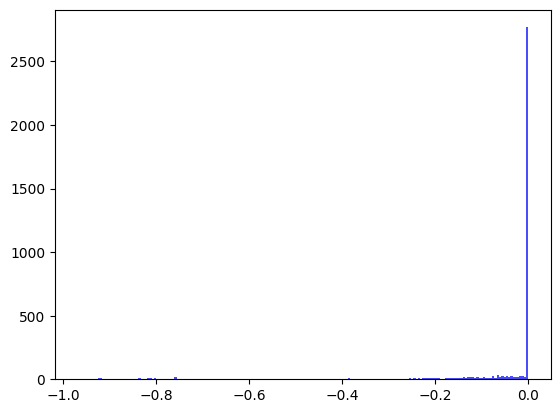

[2023-10-02T01:38:56.972885+00:00] Epochs 96, total loss: 4.51555e+03
[2023-10-02T01:38:56.973139+00:00] Training llk: -7.03084e-01
[2023-10-02T01:38:56.973237+00:00] Testing llk: -1.08512e+00
[2023-10-02T01:38:56.973314+00:00] MAE:0.10038, MRE:0.33494
saving model


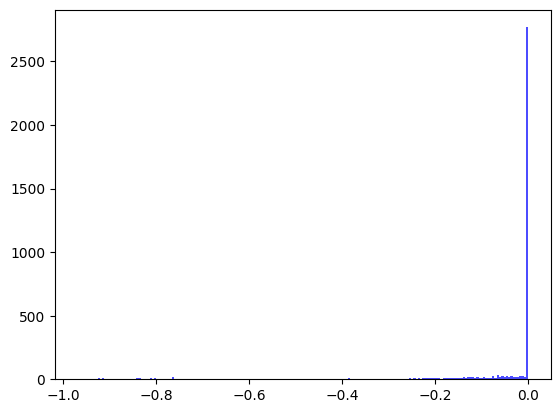

[2023-10-02T01:38:58.295593+00:00] Epochs 97, total loss: 4.51098e+03
[2023-10-02T01:38:58.295828+00:00] Training llk: -7.02659e-01
[2023-10-02T01:38:58.295911+00:00] Testing llk: -1.08453e+00
[2023-10-02T01:38:58.295980+00:00] MAE:0.10044, MRE:0.33251
saving model


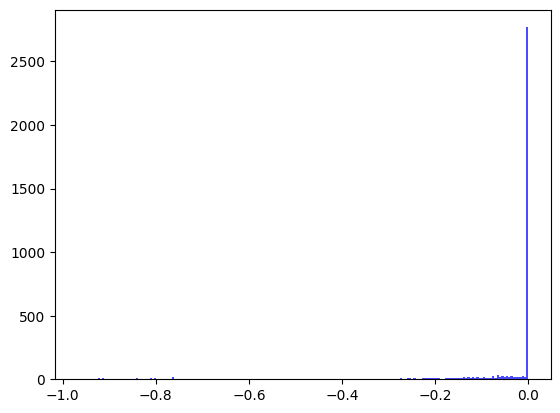

[2023-10-02T01:38:59.989852+00:00] Epochs 98, total loss: 4.50655e+03
[2023-10-02T01:38:59.991060+00:00] Training llk: -7.02248e-01
[2023-10-02T01:38:59.991615+00:00] Testing llk: -1.08397e+00
[2023-10-02T01:38:59.992142+00:00] MAE:0.10049, MRE:0.33013
saving model


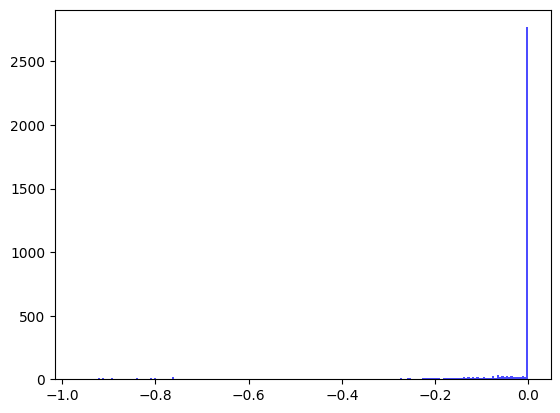

[2023-10-02T01:39:01.928664+00:00] Epochs 99, total loss: 4.50225e+03
[2023-10-02T01:39:01.928916+00:00] Training llk: -7.01850e-01
[2023-10-02T01:39:01.928993+00:00] Testing llk: -1.08342e+00
[2023-10-02T01:39:01.929073+00:00] MAE:0.10055, MRE:0.32779
saving model
training done!


In [ ]:
# For second data set
true_mu = 0.1
true_alpha = 1.0
true_beta = 2.0
raw_train_data = np.load('sample_data/training_2_0911.npy')
raw_test_data = np.load('sample_data/testing_2_0911.npy')


buffer_start_time = 35
buffer_end_time = 50
end_time = raw_test_data.max()

buffer_train_time = [buffer_start_time, buffer_end_time]
buffer_test_time = [buffer_start_time, buffer_end_time]
test_time = [buffer_end_time, end_time]

btrain_lens = ((raw_train_data <= buffer_train_time[1]) * (raw_train_data > buffer_train_time[0])).sum(1)
btest_lens = ((raw_test_data <= buffer_test_time[1]) * (raw_test_data > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum(1)

buffer_train_data = np.zeros((raw_train_data.shape[0], btrain_lens.max()))
buffer_test_data = np.zeros((raw_test_data.shape[0], btest_lens.max()))
test_data = np.zeros((raw_test_data.shape[0], test_lens.max()))

for i in range(raw_train_data.shape[0]):
    seq = raw_train_data[i]
    buffer_train_data[i, :btrain_lens[i]] = seq[(seq <= buffer_train_time[1]) * (seq > buffer_train_time[0])]

for i in range(raw_test_data.shape[0]):
    seq = raw_test_data[i]
    test_data[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_train_data = np.concatenate((np.ones_like(buffer_train_data[:, :1]) * buffer_train_time[0], buffer_train_data), axis=-1)
buffer_test_data = np.concatenate((np.ones_like(buffer_test_data[:, :1]) * buffer_test_time[0], buffer_test_data), axis=-1)

test_data_ = generate_event_mark(test_data)
buffer_train_data_ = generate_event_mark(buffer_train_data)
buffer_test_data_ = generate_event_mark(buffer_test_data)


print(test_data_.shape, buffer_train_data_.shape, buffer_test_data_.shape)
ngrid = 100

ts = np.linspace(test_time[0], test_time[1], ngrid)
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

event_loglams = 0
for i in range(raw_test_data.shape[0]):
    ts = raw_test_data[i, :][(raw_test_data[i, :] <= test_time[1]) * (raw_test_data[i, :] > test_time[0])]
    if len(ts) == 0: continue
    lams = Exponential_Hawkes(ts, raw_test_data[[i], :], mu=true_mu, alpha=true_alpha, beta=true_beta)
    event_loglams += np.log(lams).sum()

(event_loglams - true_lams.sum() * (test_time[1] - test_time[0]) / ngrid) / ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum()

for Tm in [100.]:

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
    else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())

    # device="cpu"

    print(Tm)
    T = [buffer_end_time, Tm]
    tau_max = 10.
    baserate = true_mu
    nsample = 10
    n_class = 1
    int_res = 200
    hid_dim = 1
    batch_size = 16
    train_size = 1000
    lr = 0.01
    epoch = 100
    config = config_generate(T0=str(T[0]),
                            T1=str(T[1]),
                            tau_max=str(tau_max),
                            nsample=str(nsample),
                            int_res=str(int_res),
                            n_class=str(n_class),
                            lr=str(lr),
                            epoch=str(epoch),
                            hid_dim=str(hid_dim),
                            batch_size=str(batch_size))
    config.own_event_embed = False
    config.bptt = 10
    config.alpha = true_alpha

    train_lens = ((raw_train_data <= Tm) * (raw_train_data > T[0])).sum(1)
    train_data = np.zeros((raw_train_data.shape[0], train_lens.max()))
    for i in range(train_data.shape[0]):
        seq = raw_train_data[i]
        train_data[i, :train_lens[i]] = seq[(seq <= Tm) * (seq > T[0])]

    train_data_ = generate_event_mark(train_data)

    # modelname = "1d-synthetic-exponential%.2f_hid_dim%d_T[%d, %d]_#train%d_#test%d" % (baserate,
    #                                                                                         hid_dim,
    #                                                                                         T[0],
    #                                                                                         T[1],
    #                                                                                         train_size,
    #                                                                                         test_data.shape[0])
    # save_path = os.path.join(os.getcwd(), 'Neural_Hawkes', 'saved_models', modelname)

    # if os.path.exists(save_path):
    #     # raise(ValueError("Duplicated folder!"))
    #     pass
    # else:
    #     os.makedirs(save_path)

    # seeds = [300, 816, 2999]
    # seeds = [1000, 2000, 3000]
    seeds = [0]

    for seed in seeds:
        # torch.random.manual_seed(seed)
        random.seed(seed)

        train_idx = np.arange(train_data_.shape[0])
        # random.shuffle(train_idx)
        train_data2 = train_data_[train_idx[:train_size]]
        buffer_train_data2 = buffer_train_data_[train_idx[:train_size]]

        nh_model = NH(config, device)
        num_paras = count_parameters(nh_model)
        print("#parameters: %d" % num_paras)

        for name, parameter in nh_model.named_parameters():
            if name == "baserate_mu":
                # parameter.data.fill_(random.uniform(0.4, 0.5))
                parameter.data.fill_(baserate)
            else:
                parameter.data.fill_(random.gauss(0, 0.01))

        ts = np.linspace(test_time[0], test_time[1], ngrid)
        true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

        # model = torch.load(save_path + "/model-%d.pt" % 816)

        nh_model, train_llks, test_llks, test_maes, test_mres, wall_time = model_train(train_data2,
                                                                                       test_data_,
                                                                                       buffer_train_data2,
                                                                                       buffer_test_data_,
                                                                                       nh_model,
                                                                                       config,
                                                                                       device,
                                                                                       True, ts, true_lams)


In [ ]:
test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)

nh_lams = nh_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

# print(np.mean(np.abs(lams - true_lams)))
# print(np.mean(np.abs(lams - true_lams) / true_lams))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 0
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, nh_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="NH")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)

(50, 23, 2)
(200, 16, 2)
(50, 12, 2)
(50, 23, 2) (200, 16, 2) (50, 12, 2)
CUDA is not Available. You are using CPU only.
Number of cores:  2
100.0
(200, 30, 2)
#parameters: 25
[2023-10-02T01:39:03.558436+00:00] #Training sequences: 200
[2023-10-02T01:39:03.558653+00:00] #Testing sequences: 50
[2023-10-02T01:39:03.558752+00:00] #Training events: 1606
[2023-10-02T01:39:03.558815+00:00] #Testing events: 414


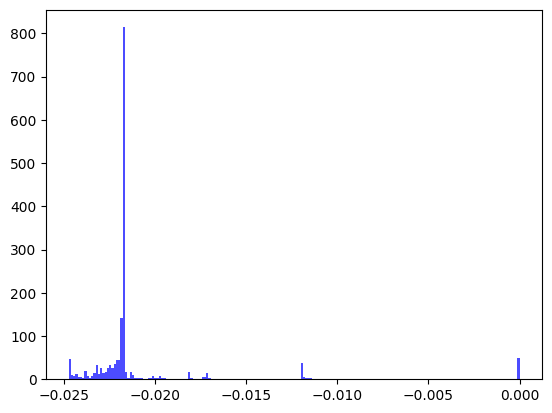

[2023-10-02T01:39:04.686749+00:00] Epochs 0, total loss: 1.01654e+04
[2023-10-02T01:39:04.687884+00:00] Training llk: -3.39387e+00
[2023-10-02T01:39:04.688505+00:00] Testing llk: -4.75157e+00
[2023-10-02T01:39:04.689012+00:00] MAE:0.61695, MRE:5.60430
saving model


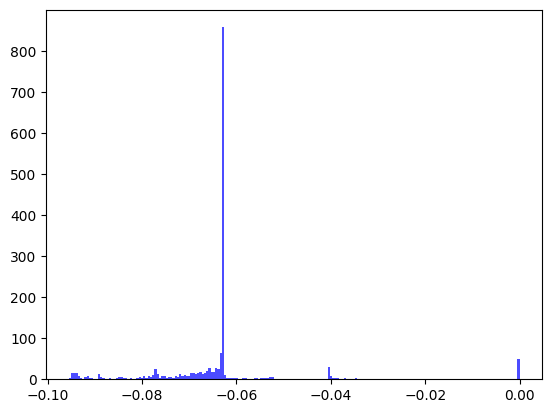

[2023-10-02T01:39:05.530988+00:00] Epochs 1, total loss: 9.60445e+03
[2023-10-02T01:39:05.532255+00:00] Training llk: -3.19107e+00
[2023-10-02T01:39:05.532909+00:00] Testing llk: -4.46998e+00
[2023-10-02T01:39:05.533448+00:00] MAE:0.56173, MRE:5.06650
saving model


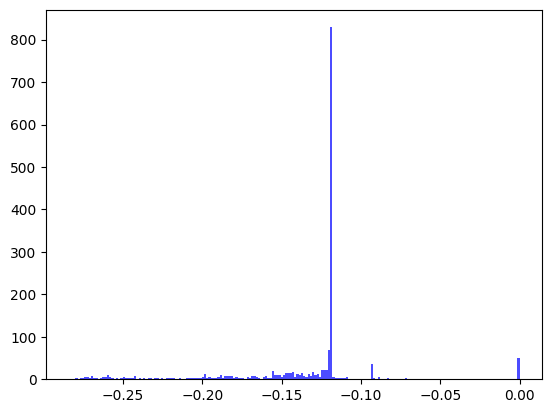

[2023-10-02T01:39:06.368925+00:00] Epochs 2, total loss: 9.00610e+03
[2023-10-02T01:39:06.369148+00:00] Training llk: -2.94668e+00
[2023-10-02T01:39:06.369241+00:00] Testing llk: -4.12784e+00
[2023-10-02T01:39:06.369304+00:00] MAE:0.49392, MRE:4.40167
saving model


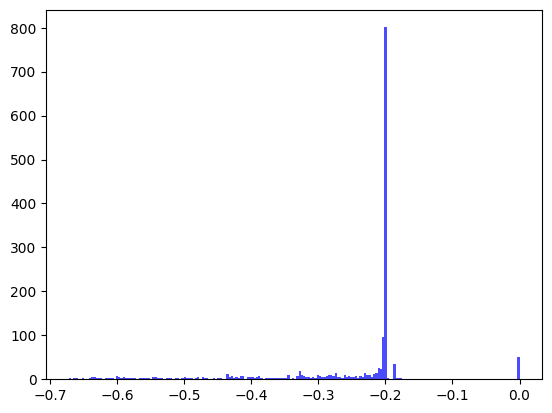

[2023-10-02T01:39:07.206761+00:00] Epochs 3, total loss: 8.23495e+03
[2023-10-02T01:39:07.206969+00:00] Training llk: -2.60876e+00
[2023-10-02T01:39:07.207078+00:00] Testing llk: -3.65114e+00
[2023-10-02T01:39:07.207141+00:00] MAE:0.39687, MRE:3.44287
saving model


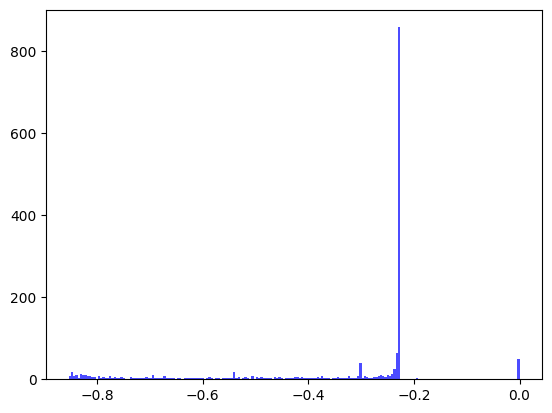

[2023-10-02T01:39:08.041290+00:00] Epochs 4, total loss: 7.35359e+03
[2023-10-02T01:39:08.042438+00:00] Training llk: -2.32685e+00
[2023-10-02T01:39:08.042966+00:00] Testing llk: -3.26401e+00
[2023-10-02T01:39:08.043563+00:00] MAE:0.31153, MRE:2.57785
saving model


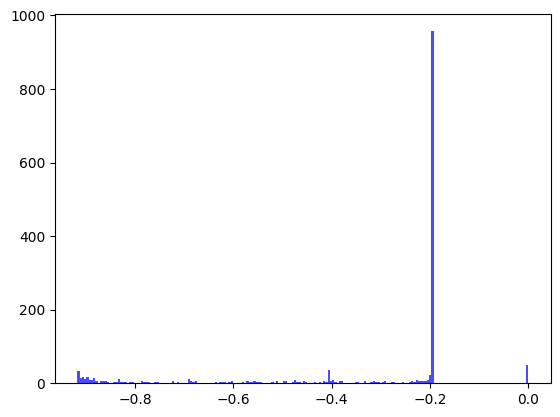

[2023-10-02T01:39:08.840184+00:00] Epochs 5, total loss: 6.71277e+03
[2023-10-02T01:39:08.841246+00:00] Training llk: -2.15232e+00
[2023-10-02T01:39:08.841788+00:00] Testing llk: -3.03005e+00
[2023-10-02T01:39:08.842347+00:00] MAE:0.25698, MRE:2.02019
saving model


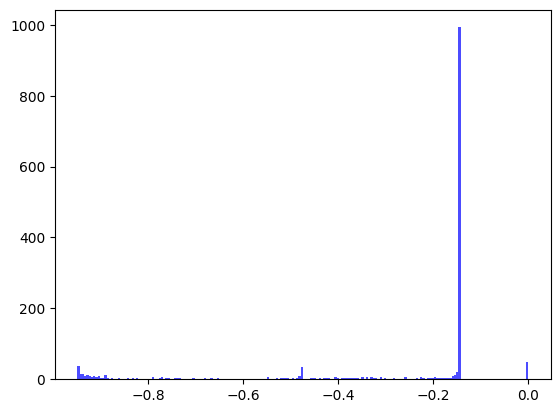

[2023-10-02T01:39:09.954375+00:00] Epochs 6, total loss: 6.28118e+03
[2023-10-02T01:39:09.954608+00:00] Training llk: -2.03059e+00
[2023-10-02T01:39:09.954697+00:00] Testing llk: -2.86582e+00
[2023-10-02T01:39:09.954756+00:00] MAE:0.22083, MRE:1.65466
saving model


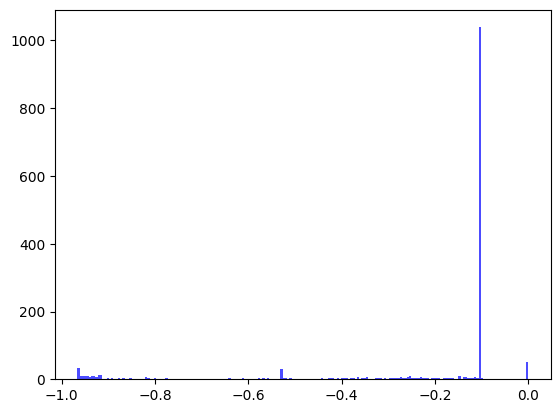

[2023-10-02T01:39:10.790669+00:00] Epochs 7, total loss: 5.96871e+03
[2023-10-02T01:39:10.790960+00:00] Training llk: -1.93783e+00
[2023-10-02T01:39:10.791066+00:00] Testing llk: -2.73816e+00
[2023-10-02T01:39:10.791134+00:00] MAE:0.19523, MRE:1.40458
saving model


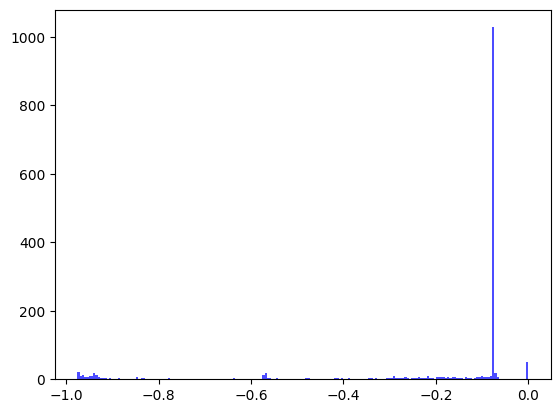

[2023-10-02T01:39:11.629770+00:00] Epochs 8, total loss: 5.73733e+03
[2023-10-02T01:39:11.630014+00:00] Training llk: -1.86949e+00
[2023-10-02T01:39:11.630112+00:00] Testing llk: -2.64226e+00
[2023-10-02T01:39:11.630175+00:00] MAE:0.17609, MRE:1.22427
saving model


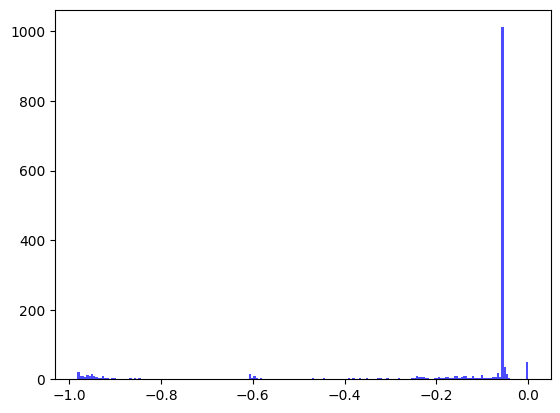

[2023-10-02T01:39:12.767797+00:00] Epochs 9, total loss: 5.57580e+03
[2023-10-02T01:39:12.769228+00:00] Training llk: -1.82320e+00
[2023-10-02T01:39:12.769768+00:00] Testing llk: -2.57726e+00
[2023-10-02T01:39:12.770288+00:00] MAE:0.16169, MRE:1.08638
saving model


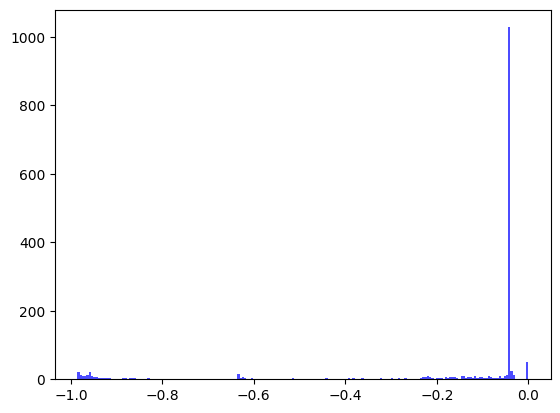

[2023-10-02T01:39:13.975953+00:00] Epochs 10, total loss: 5.46155e+03
[2023-10-02T01:39:13.977135+00:00] Training llk: -1.79057e+00
[2023-10-02T01:39:13.977736+00:00] Testing llk: -2.53274e+00
[2023-10-02T01:39:13.978337+00:00] MAE:0.15058, MRE:0.97361
saving model


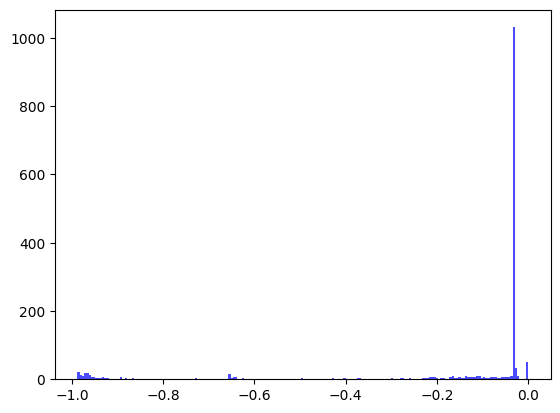

[2023-10-02T01:39:14.996534+00:00] Epochs 11, total loss: 5.37422e+03
[2023-10-02T01:39:14.996751+00:00] Training llk: -1.76615e+00
[2023-10-02T01:39:14.996844+00:00] Testing llk: -2.49976e+00
[2023-10-02T01:39:14.996909+00:00] MAE:0.14193, MRE:0.88452
saving model


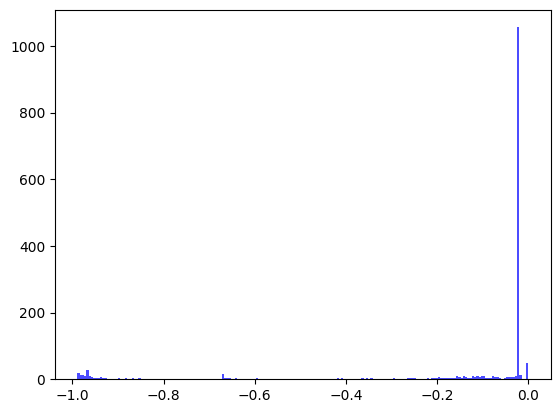

[2023-10-02T01:39:16.075400+00:00] Epochs 12, total loss: 5.30594e+03
[2023-10-02T01:39:16.075609+00:00] Training llk: -1.74650e+00
[2023-10-02T01:39:16.075697+00:00] Testing llk: -2.47275e+00
[2023-10-02T01:39:16.075758+00:00] MAE:0.13508, MRE:0.81624
saving model


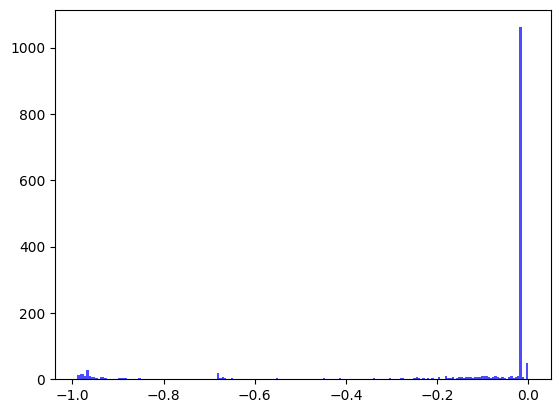

[2023-10-02T01:39:16.925056+00:00] Epochs 13, total loss: 5.25119e+03
[2023-10-02T01:39:16.925284+00:00] Training llk: -1.73054e+00
[2023-10-02T01:39:16.925373+00:00] Testing llk: -2.45070e+00
[2023-10-02T01:39:16.925436+00:00] MAE:0.12952, MRE:0.76158
saving model


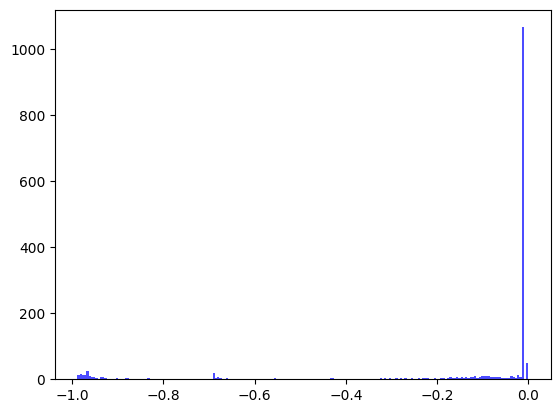

[2023-10-02T01:39:17.764386+00:00] Epochs 14, total loss: 5.20619e+03
[2023-10-02T01:39:17.764597+00:00] Training llk: -1.71746e+00
[2023-10-02T01:39:17.764687+00:00] Testing llk: -2.43282e+00
[2023-10-02T01:39:17.764747+00:00] MAE:0.12491, MRE:0.71557
saving model


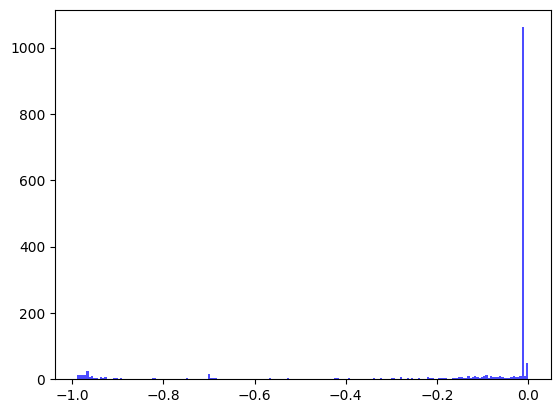

[2023-10-02T01:39:18.578256+00:00] Epochs 15, total loss: 5.16799e+03
[2023-10-02T01:39:18.579388+00:00] Training llk: -1.70629e+00
[2023-10-02T01:39:18.579919+00:00] Testing llk: -2.41758e+00
[2023-10-02T01:39:18.580445+00:00] MAE:0.12101, MRE:0.67672
saving model


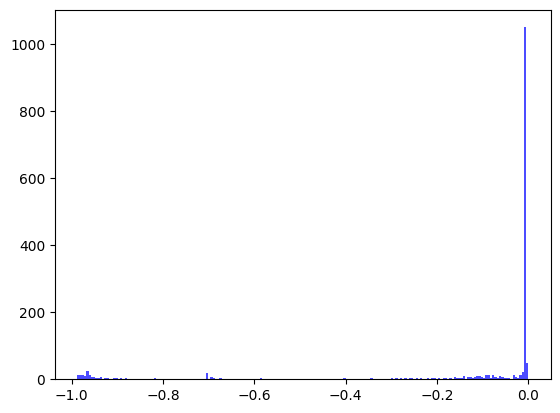

[2023-10-02T01:39:19.391867+00:00] Epochs 16, total loss: 5.13481e+03
[2023-10-02T01:39:19.392089+00:00] Training llk: -1.69645e+00
[2023-10-02T01:39:19.392188+00:00] Testing llk: -2.40407e+00
[2023-10-02T01:39:19.392263+00:00] MAE:0.11766, MRE:0.64377
saving model


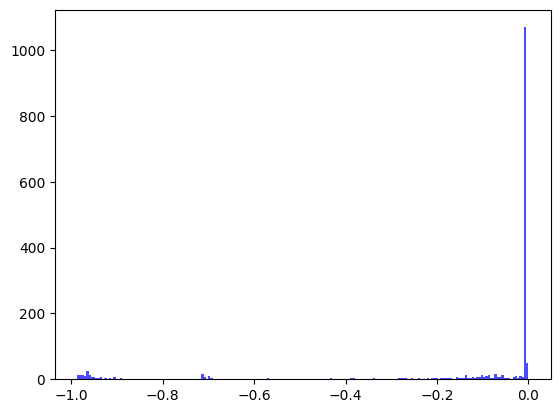

[2023-10-02T01:39:20.211000+00:00] Epochs 17, total loss: 5.10540e+03
[2023-10-02T01:39:20.211255+00:00] Training llk: -1.68762e+00
[2023-10-02T01:39:20.211352+00:00] Testing llk: -2.39194e+00
[2023-10-02T01:39:20.211413+00:00] MAE:0.11473, MRE:0.61519
saving model


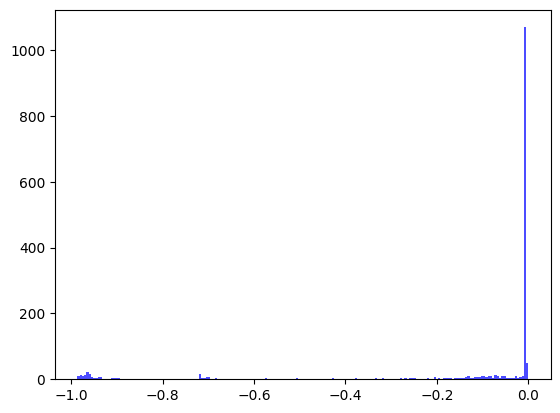

[2023-10-02T01:39:21.059608+00:00] Epochs 18, total loss: 5.07880e+03
[2023-10-02T01:39:21.060672+00:00] Training llk: -1.67959e+00
[2023-10-02T01:39:21.061212+00:00] Testing llk: -2.38089e+00
[2023-10-02T01:39:21.061732+00:00] MAE:0.11214, MRE:0.59008
saving model


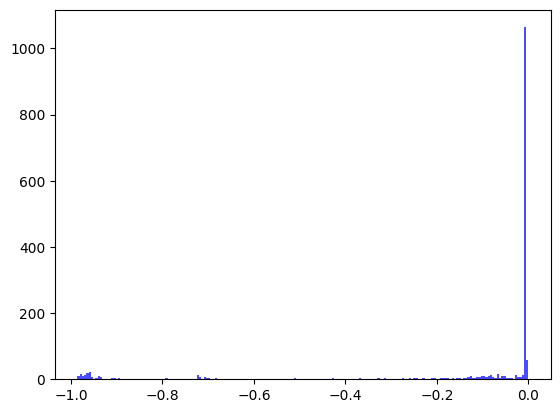

[2023-10-02T01:39:22.173705+00:00] Epochs 19, total loss: 5.05431e+03
[2023-10-02T01:39:22.173948+00:00] Training llk: -1.67215e+00
[2023-10-02T01:39:22.174080+00:00] Testing llk: -2.37061e+00
[2023-10-02T01:39:22.174161+00:00] MAE:0.10983, MRE:0.56798
saving model


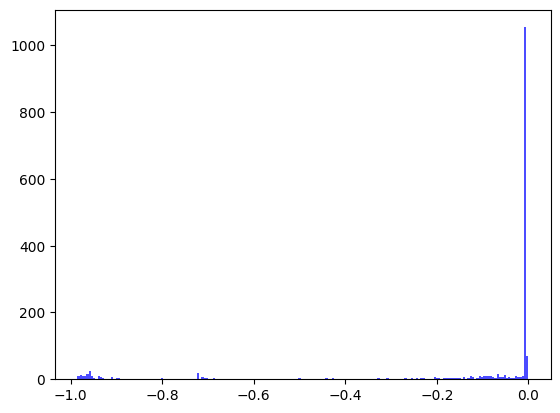

[2023-10-02T01:39:22.996927+00:00] Epochs 20, total loss: 5.03142e+03
[2023-10-02T01:39:22.997163+00:00] Training llk: -1.66518e+00
[2023-10-02T01:39:22.997261+00:00] Testing llk: -2.36096e+00
[2023-10-02T01:39:22.997323+00:00] MAE:0.10776, MRE:0.54840
saving model


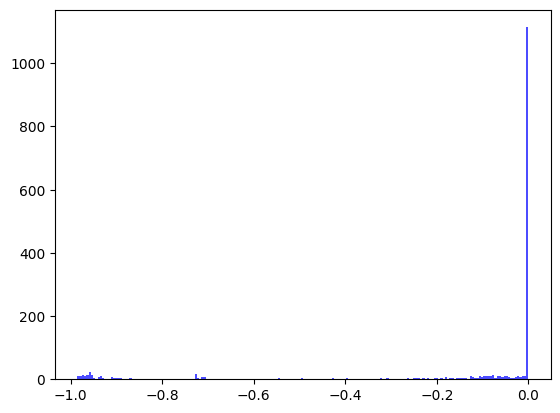

[2023-10-02T01:39:23.796405+00:00] Epochs 21, total loss: 5.00977e+03
[2023-10-02T01:39:23.797484+00:00] Training llk: -1.65859e+00
[2023-10-02T01:39:23.798010+00:00] Testing llk: -2.35181e+00
[2023-10-02T01:39:23.798513+00:00] MAE:0.10588, MRE:0.53094
saving model


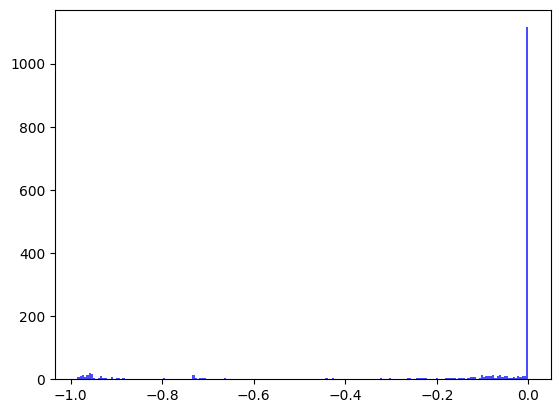

[2023-10-02T01:39:24.632669+00:00] Epochs 22, total loss: 4.98905e+03
[2023-10-02T01:39:24.632956+00:00] Training llk: -1.65230e+00
[2023-10-02T01:39:24.633079+00:00] Testing llk: -2.34304e+00
[2023-10-02T01:39:24.633168+00:00] MAE:0.10417, MRE:0.51528
saving model


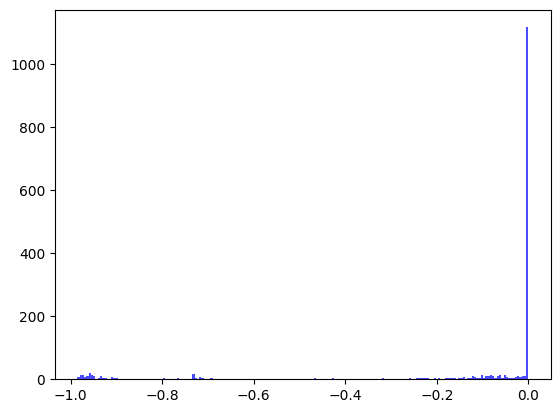

[2023-10-02T01:39:25.829403+00:00] Epochs 23, total loss: 4.96906e+03
[2023-10-02T01:39:25.830585+00:00] Training llk: -1.64624e+00
[2023-10-02T01:39:25.831148+00:00] Testing llk: -2.33457e+00
[2023-10-02T01:39:25.831646+00:00] MAE:0.10260, MRE:0.50119
saving model


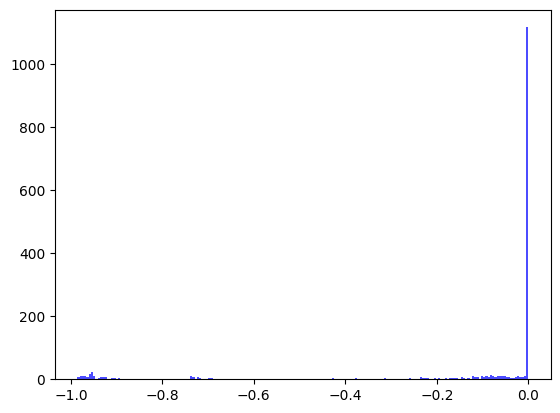

[2023-10-02T01:39:27.339642+00:00] Epochs 24, total loss: 4.94960e+03
[2023-10-02T01:39:27.340640+00:00] Training llk: -1.64036e+00
[2023-10-02T01:39:27.341183+00:00] Testing llk: -2.32634e+00
[2023-10-02T01:39:27.341665+00:00] MAE:0.10114, MRE:0.48842
saving model


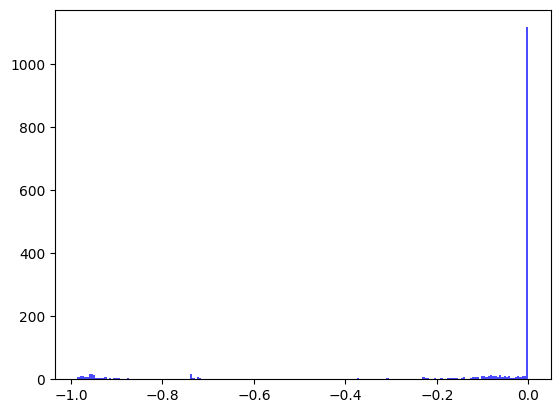

[2023-10-02T01:39:28.270106+00:00] Epochs 25, total loss: 4.93056e+03
[2023-10-02T01:39:28.270402+00:00] Training llk: -1.63463e+00
[2023-10-02T01:39:28.270499+00:00] Testing llk: -2.31828e+00
[2023-10-02T01:39:28.270582+00:00] MAE:0.09979, MRE:0.47681
saving model


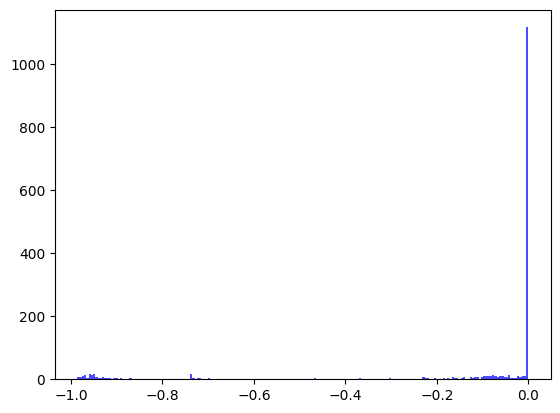

[2023-10-02T01:39:29.093459+00:00] Epochs 26, total loss: 4.91183e+03
[2023-10-02T01:39:29.093766+00:00] Training llk: -1.62901e+00
[2023-10-02T01:39:29.093862+00:00] Testing llk: -2.31036e+00
[2023-10-02T01:39:29.093947+00:00] MAE:0.09853, MRE:0.46620
saving model


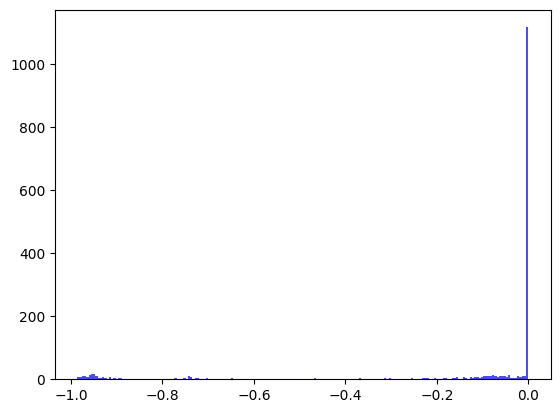

[2023-10-02T01:39:29.997336+00:00] Epochs 27, total loss: 4.89332e+03
[2023-10-02T01:39:29.997628+00:00] Training llk: -1.62348e+00
[2023-10-02T01:39:29.997726+00:00] Testing llk: -2.30254e+00
[2023-10-02T01:39:29.997806+00:00] MAE:0.09734, MRE:0.45647
saving model


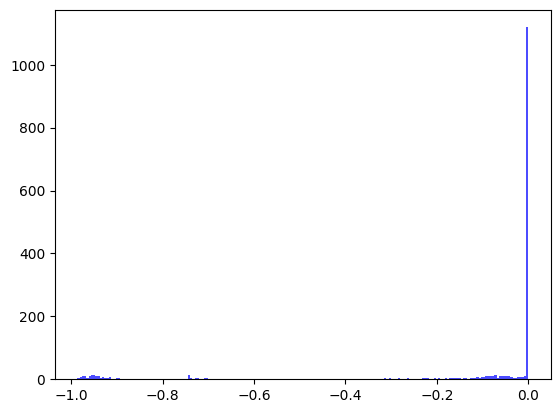

[2023-10-02T01:39:30.813361+00:00] Epochs 28, total loss: 4.87497e+03
[2023-10-02T01:39:30.813572+00:00] Training llk: -1.61801e+00
[2023-10-02T01:39:30.813667+00:00] Testing llk: -2.29480e+00
[2023-10-02T01:39:30.813729+00:00] MAE:0.09621, MRE:0.44750
saving model


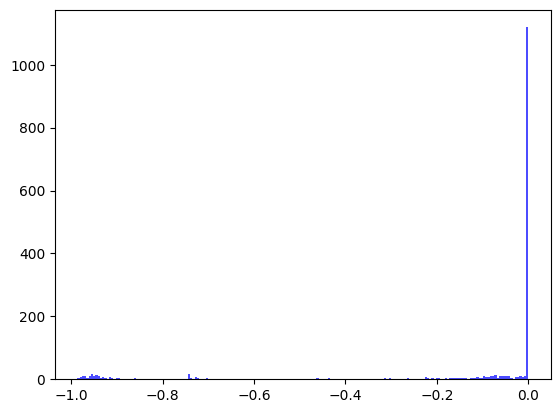

[2023-10-02T01:39:31.629426+00:00] Epochs 29, total loss: 4.85674e+03
[2023-10-02T01:39:31.629731+00:00] Training llk: -1.61260e+00
[2023-10-02T01:39:31.629828+00:00] Testing llk: -2.28712e+00
[2023-10-02T01:39:31.629914+00:00] MAE:0.09514, MRE:0.43920
saving model


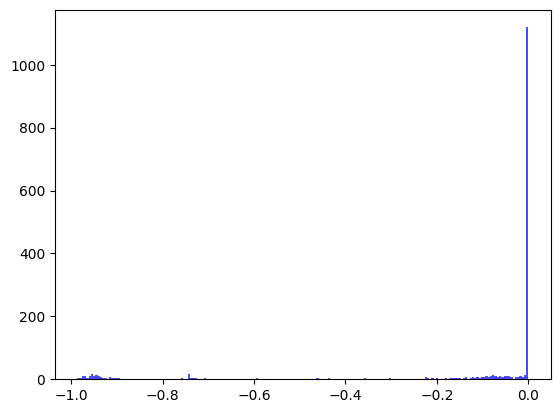

[2023-10-02T01:39:32.742892+00:00] Epochs 30, total loss: 4.83858e+03
[2023-10-02T01:39:32.743215+00:00] Training llk: -1.60722e+00
[2023-10-02T01:39:32.743371+00:00] Testing llk: -2.27948e+00
[2023-10-02T01:39:32.743480+00:00] MAE:0.09412, MRE:0.43150
saving model


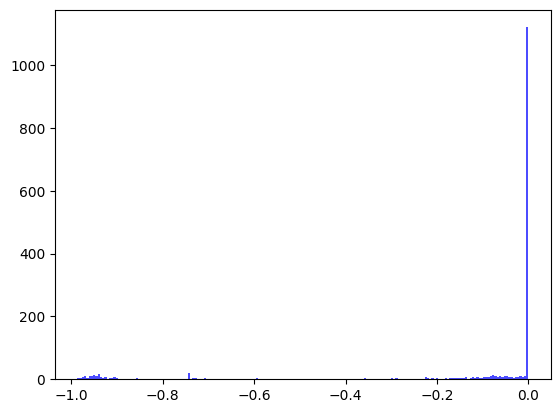

[2023-10-02T01:39:33.593877+00:00] Epochs 31, total loss: 4.82047e+03
[2023-10-02T01:39:33.594140+00:00] Training llk: -1.60188e+00
[2023-10-02T01:39:33.594235+00:00] Testing llk: -2.27188e+00
[2023-10-02T01:39:33.594300+00:00] MAE:0.09314, MRE:0.42431
saving model


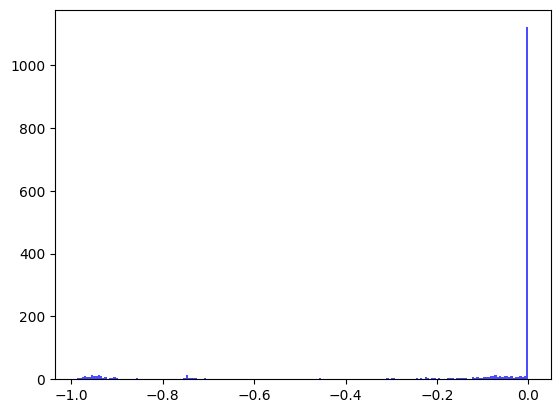

[2023-10-02T01:39:34.419367+00:00] Epochs 32, total loss: 4.80239e+03
[2023-10-02T01:39:34.419631+00:00] Training llk: -1.59656e+00
[2023-10-02T01:39:34.419732+00:00] Testing llk: -2.26429e+00
[2023-10-02T01:39:34.419820+00:00] MAE:0.09219, MRE:0.41759
saving model


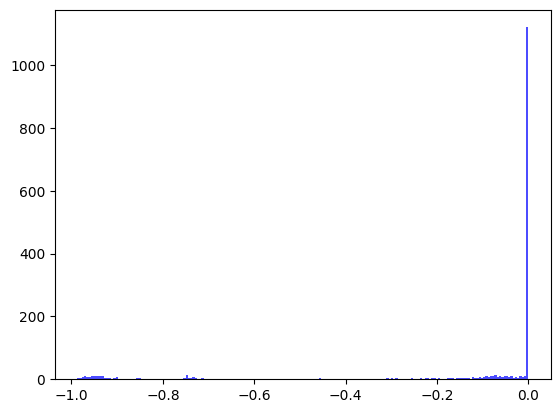

[2023-10-02T01:39:35.223415+00:00] Epochs 33, total loss: 4.78432e+03
[2023-10-02T01:39:35.223723+00:00] Training llk: -1.59126e+00
[2023-10-02T01:39:35.223823+00:00] Testing llk: -2.25673e+00
[2023-10-02T01:39:35.223901+00:00] MAE:0.09127, MRE:0.41127
saving model


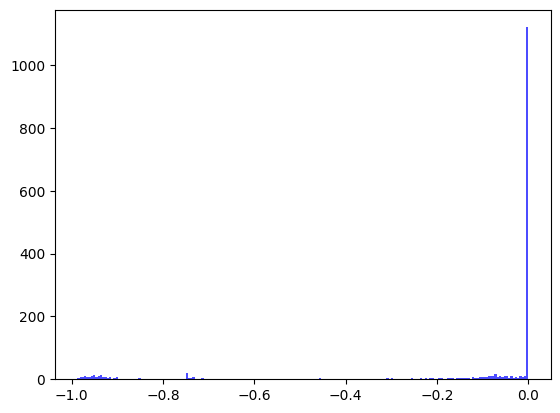

[2023-10-02T01:39:36.074106+00:00] Epochs 34, total loss: 4.76626e+03
[2023-10-02T01:39:36.074392+00:00] Training llk: -1.58597e+00
[2023-10-02T01:39:36.074489+00:00] Testing llk: -2.24918e+00
[2023-10-02T01:39:36.074575+00:00] MAE:0.09038, MRE:0.40532
saving model


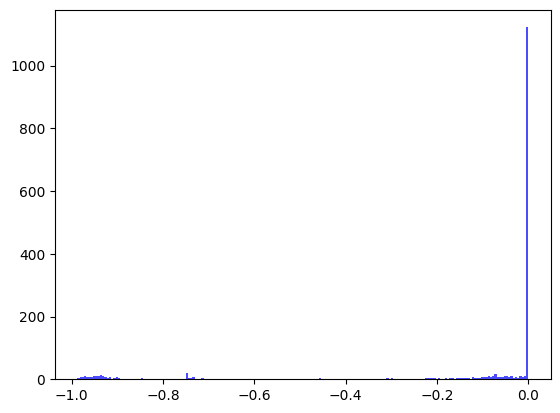

[2023-10-02T01:39:36.912049+00:00] Epochs 35, total loss: 4.74820e+03
[2023-10-02T01:39:36.913229+00:00] Training llk: -1.58070e+00
[2023-10-02T01:39:36.913774+00:00] Testing llk: -2.24164e+00
[2023-10-02T01:39:36.914299+00:00] MAE:0.08952, MRE:0.39969
saving model


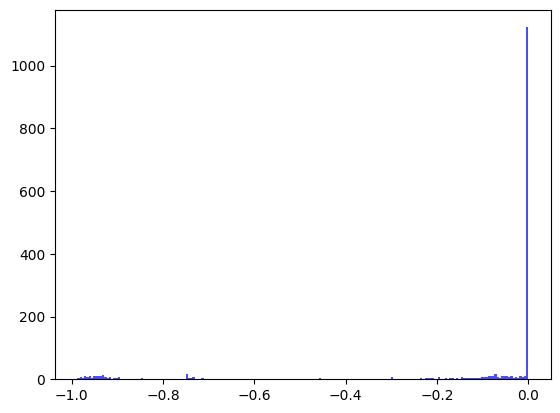

[2023-10-02T01:39:37.935229+00:00] Epochs 36, total loss: 4.73014e+03
[2023-10-02T01:39:37.936555+00:00] Training llk: -1.57544e+00
[2023-10-02T01:39:37.939160+00:00] Testing llk: -2.23412e+00
[2023-10-02T01:39:37.939295+00:00] MAE:0.08867, MRE:0.39435
saving model


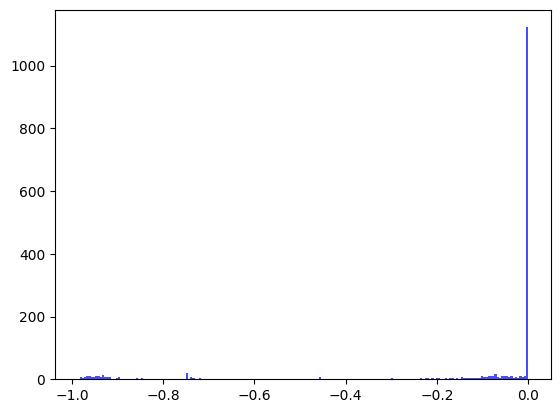

[2023-10-02T01:39:39.437309+00:00] Epochs 37, total loss: 4.71208e+03
[2023-10-02T01:39:39.438473+00:00] Training llk: -1.57020e+00
[2023-10-02T01:39:39.444453+00:00] Testing llk: -2.22661e+00
[2023-10-02T01:39:39.445074+00:00] MAE:0.08784, MRE:0.38927
saving model


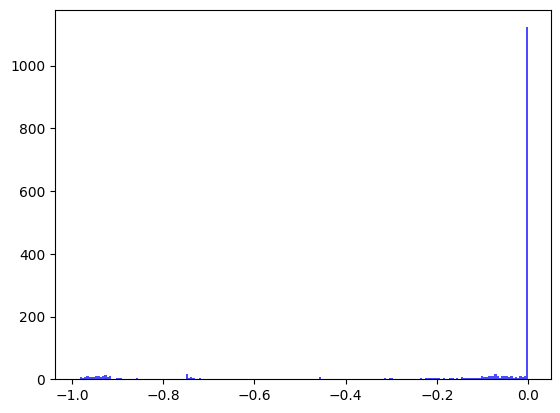

[2023-10-02T01:39:40.547425+00:00] Epochs 38, total loss: 4.69402e+03
[2023-10-02T01:39:40.547688+00:00] Training llk: -1.56497e+00
[2023-10-02T01:39:40.547775+00:00] Testing llk: -2.21911e+00
[2023-10-02T01:39:40.547844+00:00] MAE:0.08703, MRE:0.38440
saving model


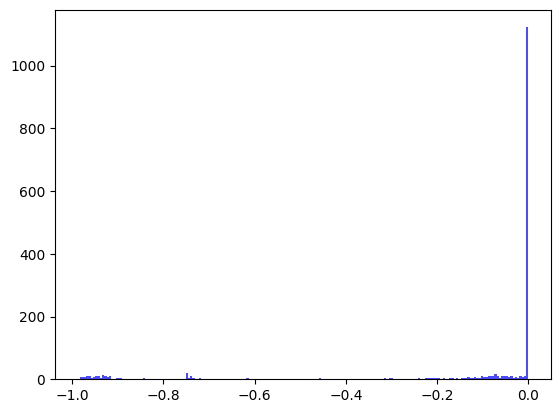

[2023-10-02T01:39:41.388880+00:00] Epochs 39, total loss: 4.67597e+03
[2023-10-02T01:39:41.389091+00:00] Training llk: -1.55975e+00
[2023-10-02T01:39:41.389184+00:00] Testing llk: -2.21164e+00
[2023-10-02T01:39:41.389257+00:00] MAE:0.08622, MRE:0.37975
saving model


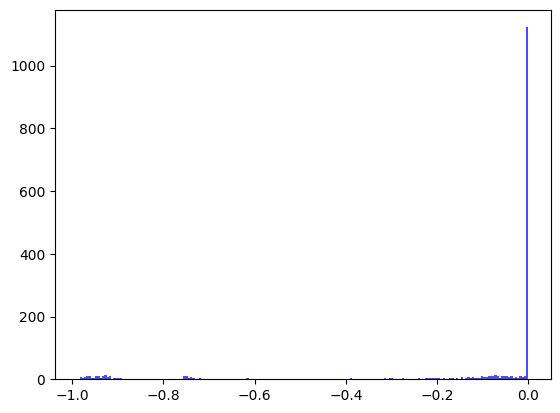

[2023-10-02T01:39:42.213636+00:00] Epochs 40, total loss: 4.65794e+03
[2023-10-02T01:39:42.213873+00:00] Training llk: -1.55455e+00
[2023-10-02T01:39:42.213970+00:00] Testing llk: -2.20419e+00
[2023-10-02T01:39:42.214055+00:00] MAE:0.08543, MRE:0.37527
saving model


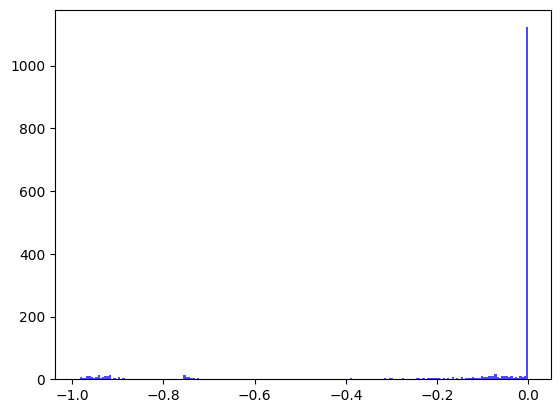

[2023-10-02T01:39:43.036046+00:00] Epochs 41, total loss: 4.63993e+03
[2023-10-02T01:39:43.037420+00:00] Training llk: -1.54937e+00
[2023-10-02T01:39:43.037977+00:00] Testing llk: -2.19676e+00
[2023-10-02T01:39:43.038508+00:00] MAE:0.08464, MRE:0.37095
saving model


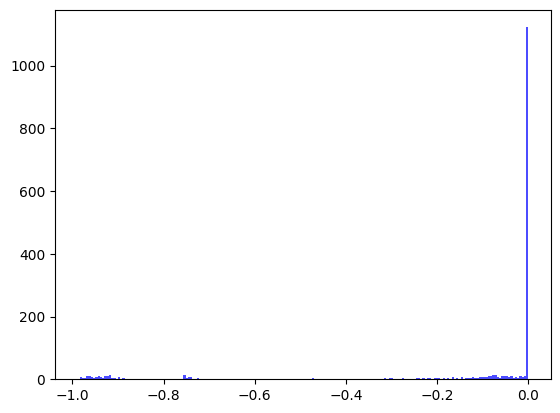

[2023-10-02T01:39:44.114177+00:00] Epochs 42, total loss: 4.62196e+03
[2023-10-02T01:39:44.114448+00:00] Training llk: -1.54421e+00
[2023-10-02T01:39:44.114527+00:00] Testing llk: -2.18936e+00
[2023-10-02T01:39:44.114587+00:00] MAE:0.08387, MRE:0.36678
saving model


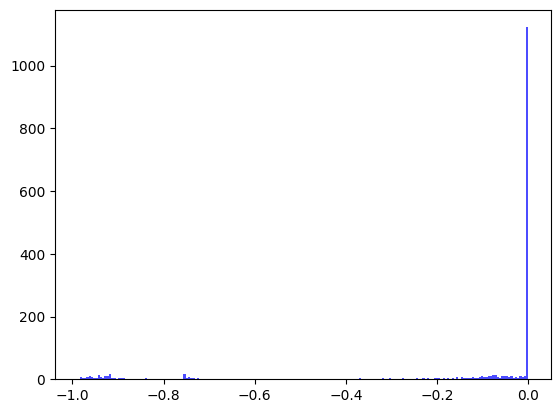

[2023-10-02T01:39:44.921612+00:00] Epochs 43, total loss: 4.60403e+03
[2023-10-02T01:39:44.921882+00:00] Training llk: -1.53908e+00
[2023-10-02T01:39:44.921976+00:00] Testing llk: -2.18200e+00
[2023-10-02T01:39:44.922082+00:00] MAE:0.08310, MRE:0.36273
saving model


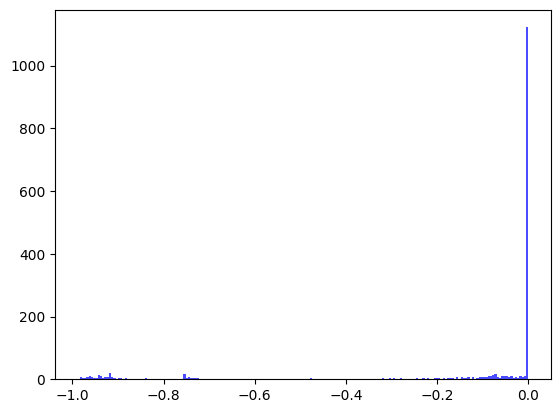

[2023-10-02T01:39:45.734196+00:00] Epochs 44, total loss: 4.58616e+03
[2023-10-02T01:39:45.735122+00:00] Training llk: -1.53397e+00
[2023-10-02T01:39:45.735264+00:00] Testing llk: -2.17467e+00
[2023-10-02T01:39:45.735343+00:00] MAE:0.08233, MRE:0.35880
saving model


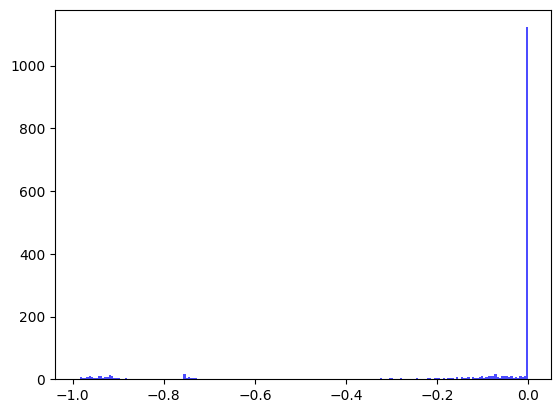

[2023-10-02T01:39:46.557906+00:00] Epochs 45, total loss: 4.56835e+03
[2023-10-02T01:39:46.558149+00:00] Training llk: -1.52890e+00
[2023-10-02T01:39:46.558238+00:00] Testing llk: -2.16739e+00
[2023-10-02T01:39:46.558310+00:00] MAE:0.08157, MRE:0.35496
saving model


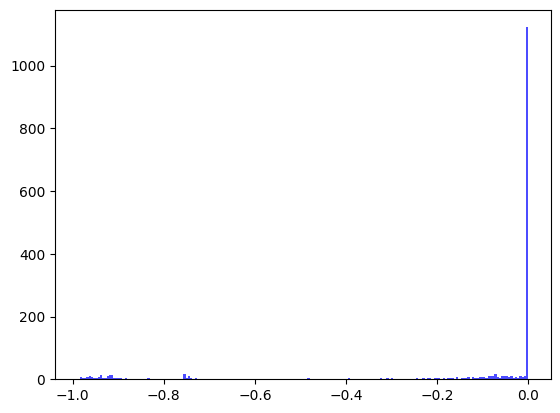

[2023-10-02T01:39:47.390106+00:00] Epochs 46, total loss: 4.55062e+03
[2023-10-02T01:39:47.390384+00:00] Training llk: -1.52385e+00
[2023-10-02T01:39:47.390470+00:00] Testing llk: -2.16015e+00
[2023-10-02T01:39:47.390534+00:00] MAE:0.08081, MRE:0.35122
saving model


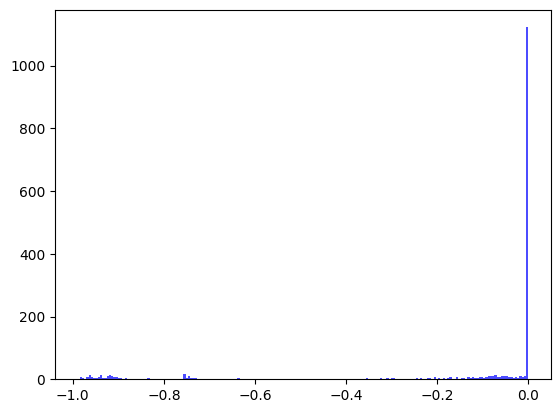

[2023-10-02T01:39:48.219253+00:00] Epochs 47, total loss: 4.53298e+03
[2023-10-02T01:39:48.219526+00:00] Training llk: -1.51884e+00
[2023-10-02T01:39:48.219640+00:00] Testing llk: -2.15296e+00
[2023-10-02T01:39:48.219725+00:00] MAE:0.08006, MRE:0.34755
saving model


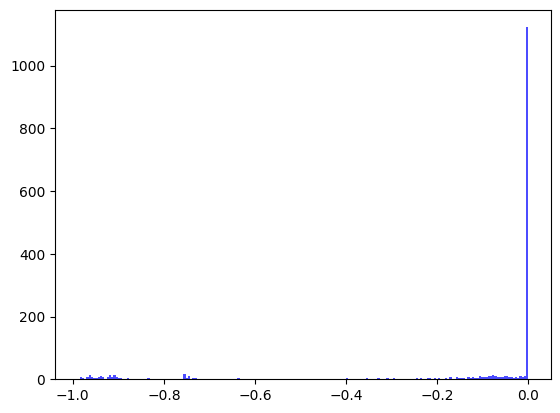

[2023-10-02T01:39:49.312244+00:00] Epochs 48, total loss: 4.51543e+03
[2023-10-02T01:39:49.312459+00:00] Training llk: -1.51387e+00
[2023-10-02T01:39:49.312547+00:00] Testing llk: -2.14584e+00
[2023-10-02T01:39:49.312608+00:00] MAE:0.07931, MRE:0.34396
saving model


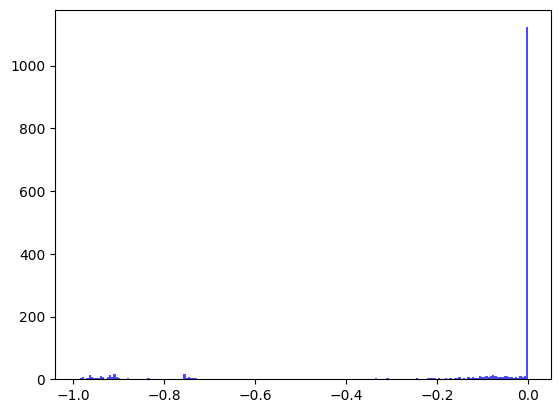

[2023-10-02T01:39:50.146957+00:00] Epochs 49, total loss: 4.49799e+03
[2023-10-02T01:39:50.147198+00:00] Training llk: -1.50894e+00
[2023-10-02T01:39:50.147285+00:00] Testing llk: -2.13877e+00
[2023-10-02T01:39:50.147344+00:00] MAE:0.07856, MRE:0.34042
saving model


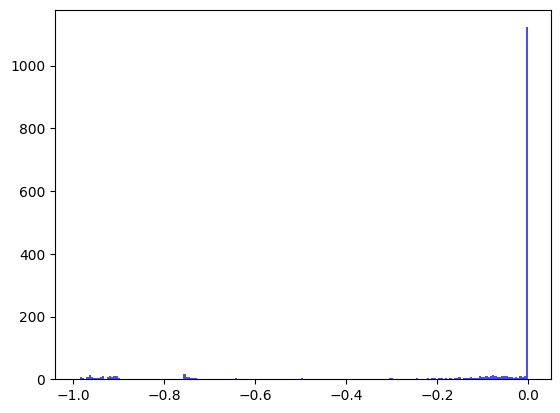

[2023-10-02T01:39:51.353826+00:00] Epochs 50, total loss: 4.48066e+03
[2023-10-02T01:39:51.355170+00:00] Training llk: -1.50405e+00
[2023-10-02T01:39:51.355695+00:00] Testing llk: -2.13176e+00
[2023-10-02T01:39:51.356210+00:00] MAE:0.07781, MRE:0.33695
saving model


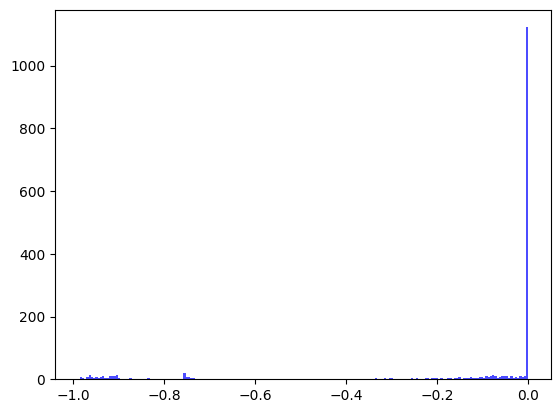

[2023-10-02T01:39:52.582717+00:00] Epochs 51, total loss: 4.46347e+03
[2023-10-02T01:39:52.583769+00:00] Training llk: -1.49922e+00
[2023-10-02T01:39:52.584306+00:00] Testing llk: -2.12483e+00
[2023-10-02T01:39:52.584816+00:00] MAE:0.07707, MRE:0.33352
saving model


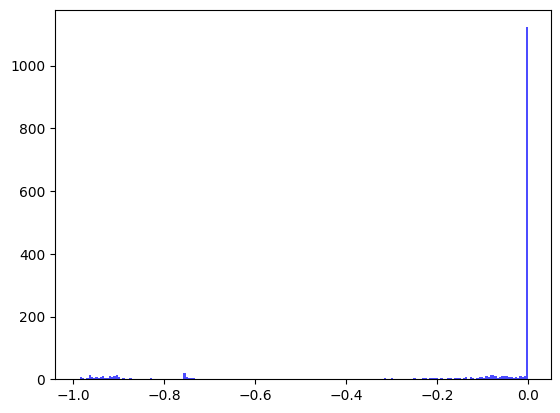

[2023-10-02T01:39:53.545500+00:00] Epochs 52, total loss: 4.44641e+03
[2023-10-02T01:39:53.545770+00:00] Training llk: -1.49443e+00
[2023-10-02T01:39:53.545936+00:00] Testing llk: -2.11797e+00
[2023-10-02T01:39:53.546023+00:00] MAE:0.07632, MRE:0.33014
saving model


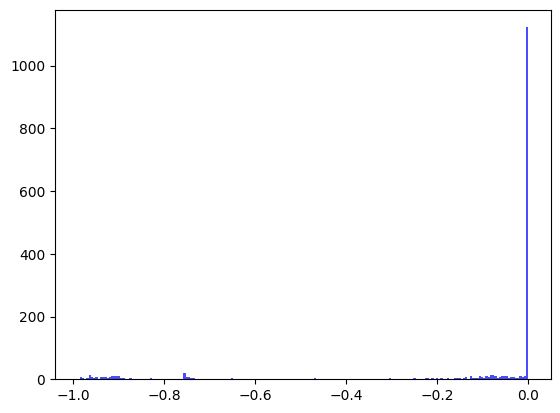

[2023-10-02T01:39:54.380583+00:00] Epochs 53, total loss: 4.42949e+03
[2023-10-02T01:39:54.380849+00:00] Training llk: -1.48969e+00
[2023-10-02T01:39:54.380936+00:00] Testing llk: -2.11118e+00
[2023-10-02T01:39:54.381015+00:00] MAE:0.07558, MRE:0.32681
saving model


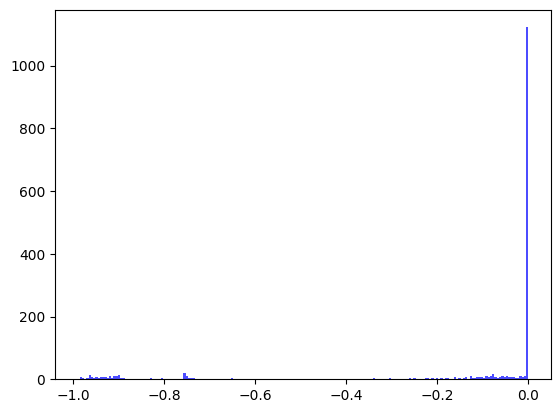

[2023-10-02T01:39:55.224003+00:00] Epochs 54, total loss: 4.41274e+03
[2023-10-02T01:39:55.224231+00:00] Training llk: -1.48500e+00
[2023-10-02T01:39:55.224311+00:00] Testing llk: -2.10447e+00
[2023-10-02T01:39:55.224383+00:00] MAE:0.07484, MRE:0.32351
saving model


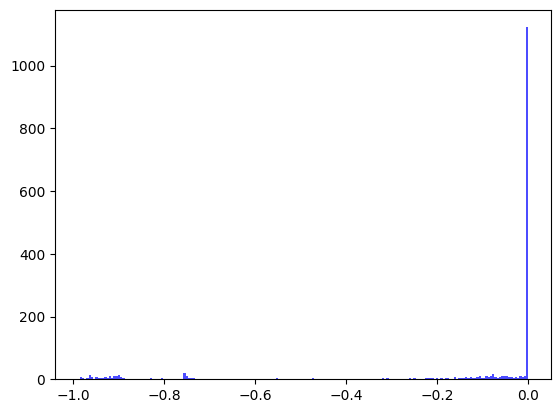

[2023-10-02T01:39:56.331087+00:00] Epochs 55, total loss: 4.39614e+03
[2023-10-02T01:39:56.331353+00:00] Training llk: -1.48038e+00
[2023-10-02T01:39:56.331458+00:00] Testing llk: -2.09784e+00
[2023-10-02T01:39:56.331524+00:00] MAE:0.07410, MRE:0.32025
saving model


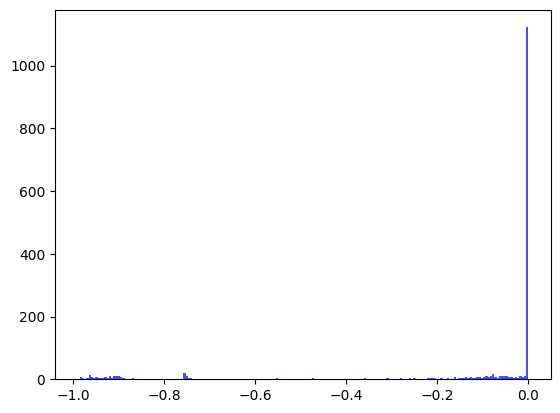

[2023-10-02T01:39:57.149258+00:00] Epochs 56, total loss: 4.37971e+03
[2023-10-02T01:39:57.150156+00:00] Training llk: -1.47581e+00
[2023-10-02T01:39:57.150321+00:00] Testing llk: -2.09130e+00
[2023-10-02T01:39:57.150434+00:00] MAE:0.07336, MRE:0.31702
saving model


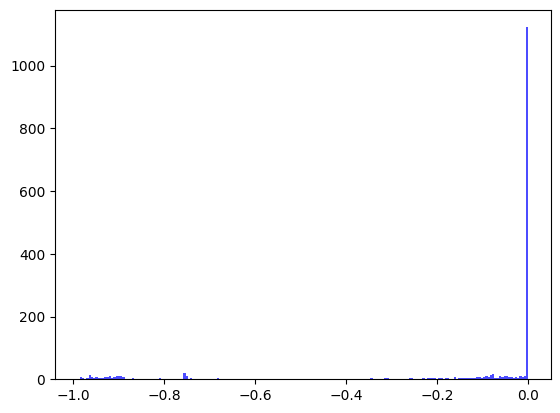

[2023-10-02T01:39:57.959115+00:00] Epochs 57, total loss: 4.36346e+03
[2023-10-02T01:39:57.960313+00:00] Training llk: -1.47130e+00
[2023-10-02T01:39:57.960842+00:00] Testing llk: -2.08485e+00
[2023-10-02T01:39:57.961379+00:00] MAE:0.07262, MRE:0.31382
saving model


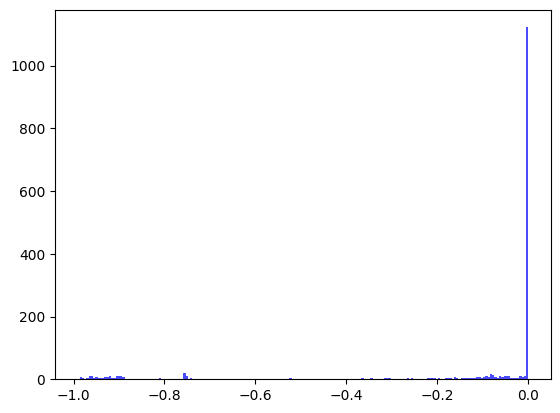

[2023-10-02T01:39:58.793566+00:00] Epochs 58, total loss: 4.34740e+03
[2023-10-02T01:39:58.794747+00:00] Training llk: -1.46685e+00
[2023-10-02T01:39:58.795268+00:00] Testing llk: -2.07849e+00
[2023-10-02T01:39:58.795761+00:00] MAE:0.07189, MRE:0.31065
saving model


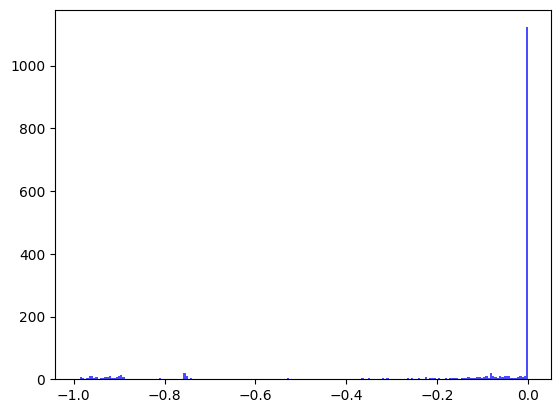

[2023-10-02T01:39:59.621011+00:00] Epochs 59, total loss: 4.33152e+03
[2023-10-02T01:39:59.622321+00:00] Training llk: -1.46246e+00
[2023-10-02T01:39:59.622997+00:00] Testing llk: -2.07222e+00
[2023-10-02T01:39:59.623625+00:00] MAE:0.07115, MRE:0.30751
saving model


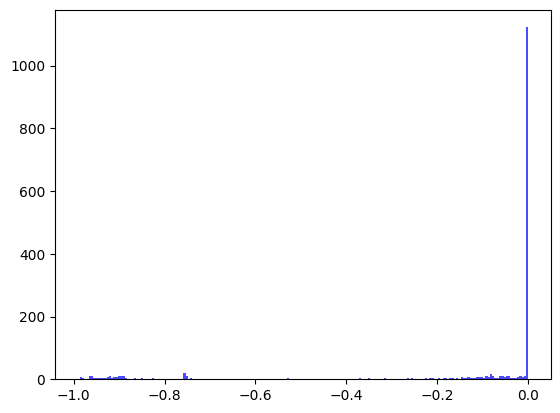

[2023-10-02T01:40:00.793191+00:00] Epochs 60, total loss: 4.31584e+03
[2023-10-02T01:40:00.793434+00:00] Training llk: -1.45814e+00
[2023-10-02T01:40:00.793536+00:00] Testing llk: -2.06604e+00
[2023-10-02T01:40:00.793616+00:00] MAE:0.07042, MRE:0.30439
saving model


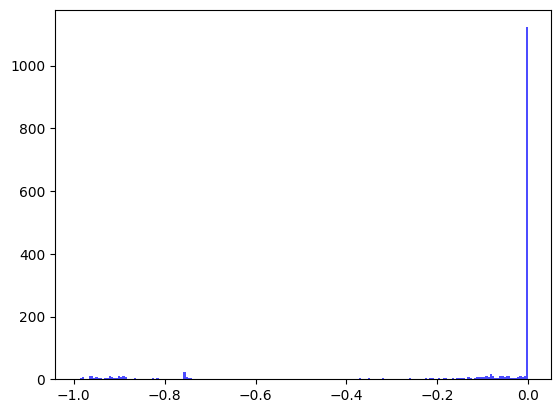

[2023-10-02T01:40:01.682238+00:00] Epochs 61, total loss: 4.30036e+03
[2023-10-02T01:40:01.682475+00:00] Training llk: -1.45389e+00
[2023-10-02T01:40:01.682560+00:00] Testing llk: -2.05996e+00
[2023-10-02T01:40:01.682622+00:00] MAE:0.06969, MRE:0.30130
saving model


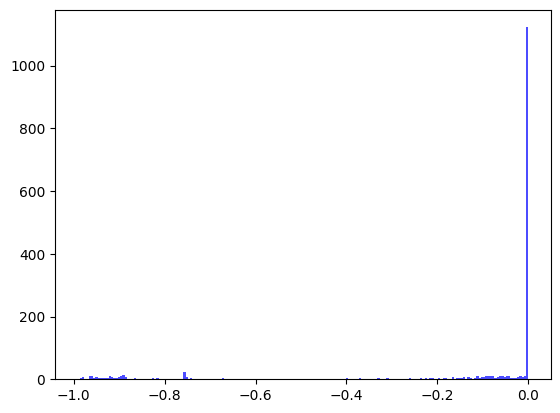

[2023-10-02T01:40:02.543415+00:00] Epochs 62, total loss: 4.28508e+03
[2023-10-02T01:40:02.544695+00:00] Training llk: -1.44970e+00
[2023-10-02T01:40:02.545370+00:00] Testing llk: -2.05397e+00
[2023-10-02T01:40:02.545926+00:00] MAE:0.06897, MRE:0.29823
saving model


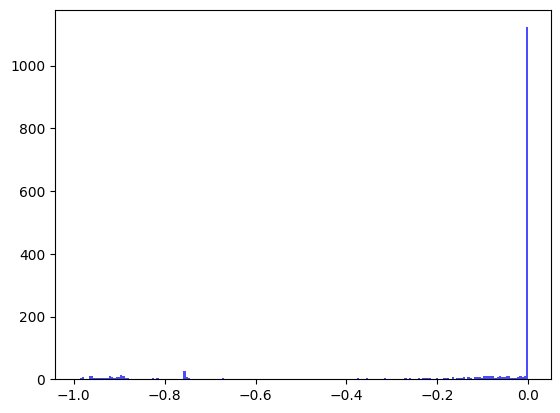

[2023-10-02T01:40:03.528614+00:00] Epochs 63, total loss: 4.27001e+03
[2023-10-02T01:40:03.529746+00:00] Training llk: -1.44557e+00
[2023-10-02T01:40:03.530295+00:00] Testing llk: -2.04809e+00
[2023-10-02T01:40:03.530843+00:00] MAE:0.06824, MRE:0.29519
saving model


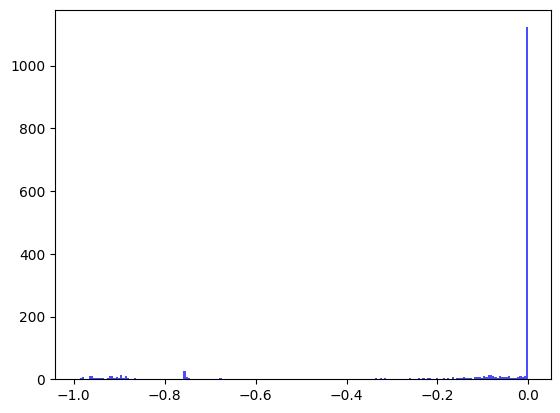

[2023-10-02T01:40:04.764675+00:00] Epochs 64, total loss: 4.25515e+03
[2023-10-02T01:40:04.765784+00:00] Training llk: -1.44152e+00
[2023-10-02T01:40:04.769402+00:00] Testing llk: -2.04230e+00
[2023-10-02T01:40:04.770124+00:00] MAE:0.06752, MRE:0.29217
saving model


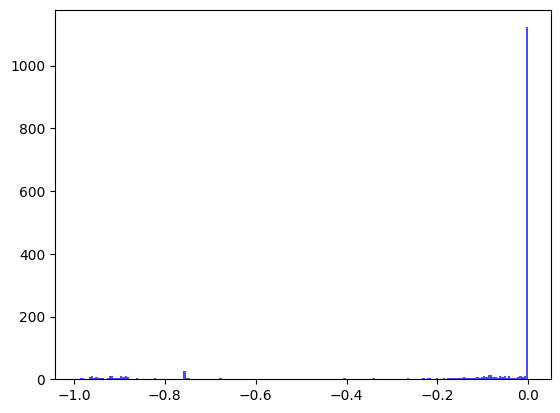

[2023-10-02T01:40:05.947942+00:00] Epochs 65, total loss: 4.24051e+03
[2023-10-02T01:40:05.950828+00:00] Training llk: -1.43753e+00
[2023-10-02T01:40:05.951426+00:00] Testing llk: -2.03661e+00
[2023-10-02T01:40:05.951905+00:00] MAE:0.06680, MRE:0.28917
saving model


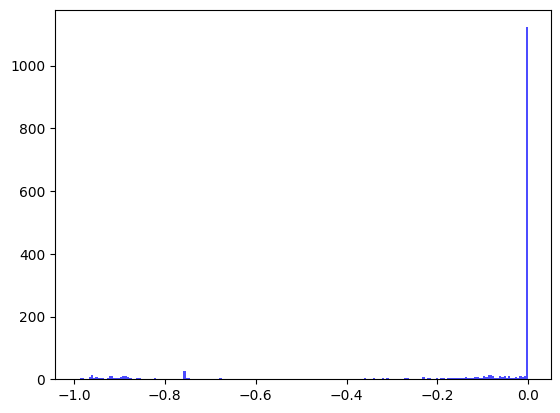

[2023-10-02T01:40:07.059525+00:00] Epochs 66, total loss: 4.22608e+03
[2023-10-02T01:40:07.060512+00:00] Training llk: -1.43361e+00
[2023-10-02T01:40:07.061016+00:00] Testing llk: -2.03102e+00
[2023-10-02T01:40:07.061567+00:00] MAE:0.06608, MRE:0.28619
saving model


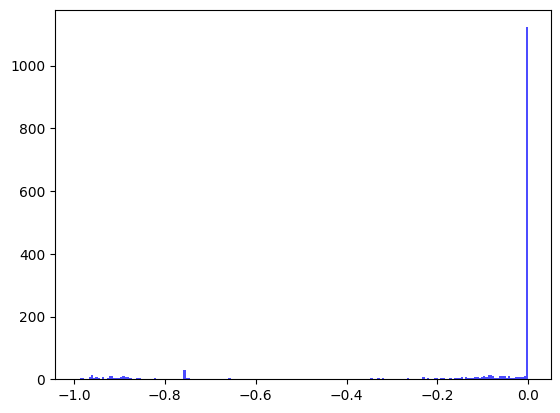

[2023-10-02T01:40:07.919004+00:00] Epochs 67, total loss: 4.21186e+03
[2023-10-02T01:40:07.919277+00:00] Training llk: -1.42976e+00
[2023-10-02T01:40:07.919387+00:00] Testing llk: -2.02554e+00
[2023-10-02T01:40:07.919469+00:00] MAE:0.06537, MRE:0.28324
saving model


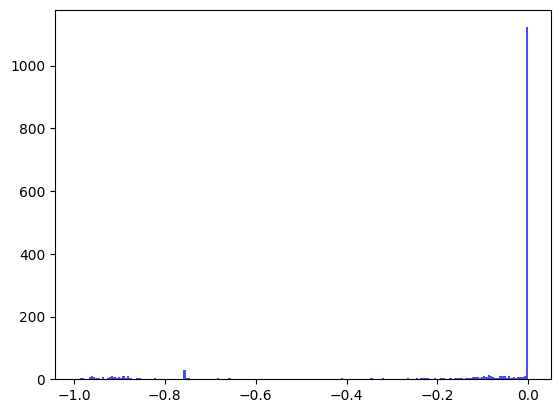

[2023-10-02T01:40:08.754637+00:00] Epochs 68, total loss: 4.19787e+03
[2023-10-02T01:40:08.755948+00:00] Training llk: -1.42599e+00
[2023-10-02T01:40:08.756619+00:00] Testing llk: -2.02015e+00
[2023-10-02T01:40:08.757268+00:00] MAE:0.06466, MRE:0.28032
saving model


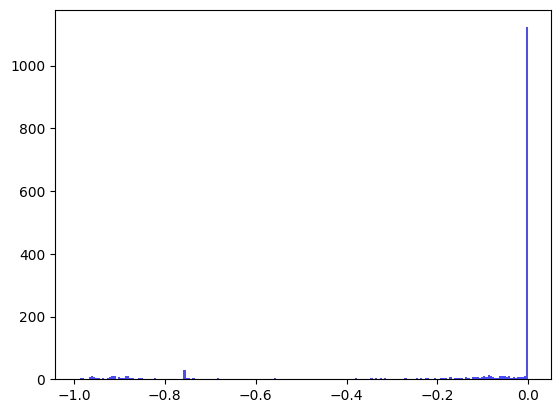

[2023-10-02T01:40:09.600456+00:00] Epochs 69, total loss: 4.18410e+03
[2023-10-02T01:40:09.601551+00:00] Training llk: -1.42227e+00
[2023-10-02T01:40:09.602142+00:00] Testing llk: -2.01486e+00
[2023-10-02T01:40:09.602657+00:00] MAE:0.06397, MRE:0.27743
saving model


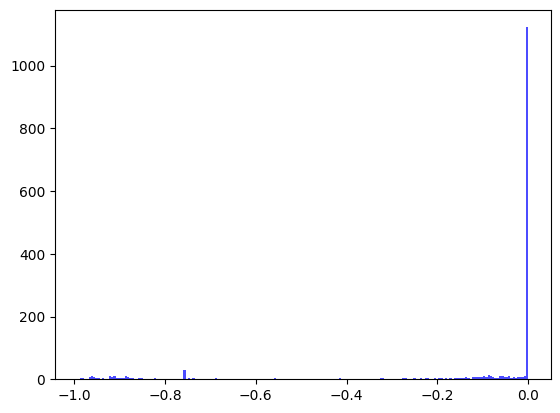

[2023-10-02T01:40:10.414314+00:00] Epochs 70, total loss: 4.17054e+03
[2023-10-02T01:40:10.414586+00:00] Training llk: -1.41863e+00
[2023-10-02T01:40:10.414682+00:00] Testing llk: -2.00968e+00
[2023-10-02T01:40:10.414796+00:00] MAE:0.06333, MRE:0.27463
saving model


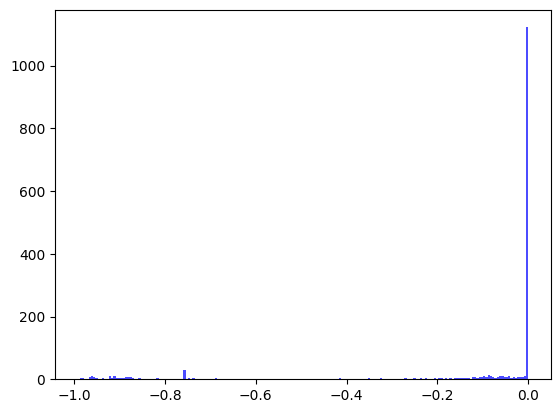

[2023-10-02T01:40:11.241722+00:00] Epochs 71, total loss: 4.15721e+03
[2023-10-02T01:40:11.242012+00:00] Training llk: -1.41506e+00
[2023-10-02T01:40:11.242146+00:00] Testing llk: -2.00459e+00
[2023-10-02T01:40:11.242252+00:00] MAE:0.06276, MRE:0.27190
saving model


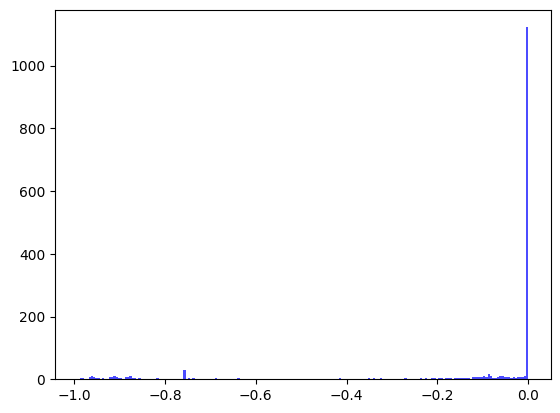

[2023-10-02T01:40:12.334533+00:00] Epochs 72, total loss: 4.14410e+03
[2023-10-02T01:40:12.334778+00:00] Training llk: -1.41156e+00
[2023-10-02T01:40:12.334882+00:00] Testing llk: -1.99960e+00
[2023-10-02T01:40:12.334947+00:00] MAE:0.06223, MRE:0.26925
saving model


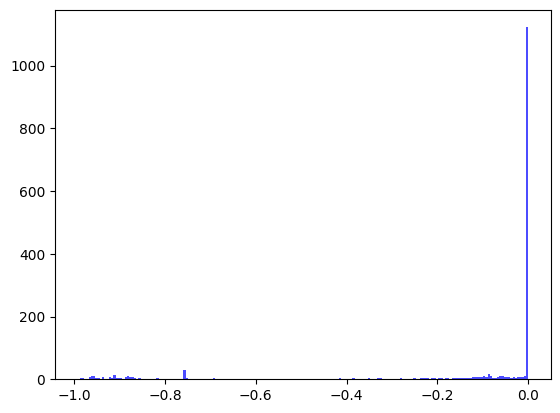

[2023-10-02T01:40:13.160686+00:00] Epochs 73, total loss: 4.13121e+03
[2023-10-02T01:40:13.160901+00:00] Training llk: -1.40812e+00
[2023-10-02T01:40:13.160992+00:00] Testing llk: -1.99472e+00
[2023-10-02T01:40:13.161075+00:00] MAE:0.06173, MRE:0.26665
saving model


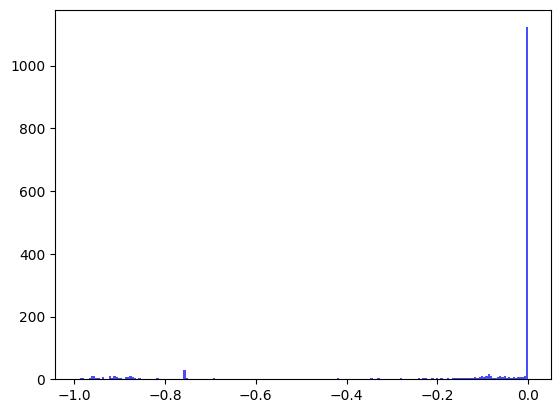

[2023-10-02T01:40:13.994735+00:00] Epochs 74, total loss: 4.11854e+03
[2023-10-02T01:40:13.994999+00:00] Training llk: -1.40475e+00
[2023-10-02T01:40:13.995111+00:00] Testing llk: -1.98993e+00
[2023-10-02T01:40:13.995217+00:00] MAE:0.06125, MRE:0.26409
saving model


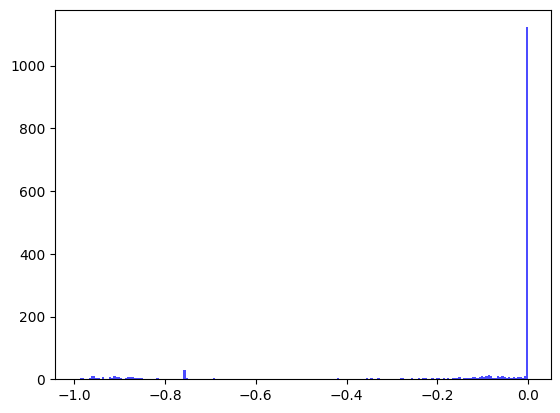

[2023-10-02T01:40:14.840917+00:00] Epochs 75, total loss: 4.10608e+03
[2023-10-02T01:40:14.841973+00:00] Training llk: -1.40145e+00
[2023-10-02T01:40:14.842542+00:00] Testing llk: -1.98523e+00
[2023-10-02T01:40:14.843067+00:00] MAE:0.06078, MRE:0.26157
saving model


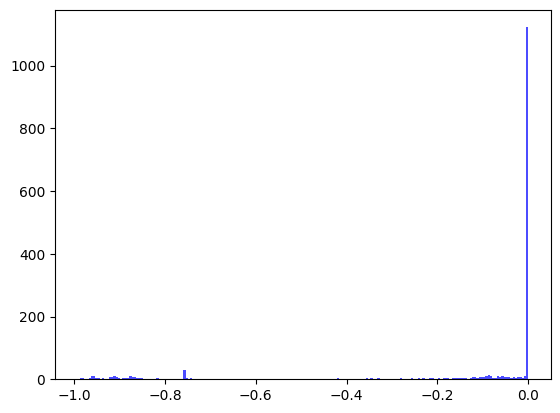

[2023-10-02T01:40:15.634654+00:00] Epochs 76, total loss: 4.09385e+03
[2023-10-02T01:40:15.634878+00:00] Training llk: -1.39822e+00
[2023-10-02T01:40:15.634964+00:00] Testing llk: -1.98064e+00
[2023-10-02T01:40:15.635026+00:00] MAE:0.06034, MRE:0.25910
saving model


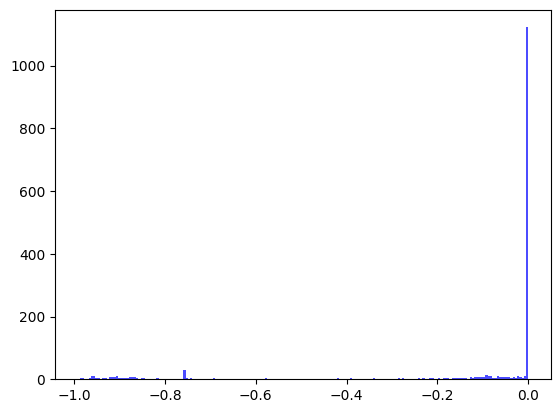

[2023-10-02T01:40:16.724962+00:00] Epochs 77, total loss: 4.08183e+03
[2023-10-02T01:40:16.726188+00:00] Training llk: -1.39505e+00
[2023-10-02T01:40:16.726777+00:00] Testing llk: -1.97614e+00
[2023-10-02T01:40:16.727356+00:00] MAE:0.05991, MRE:0.25667
saving model


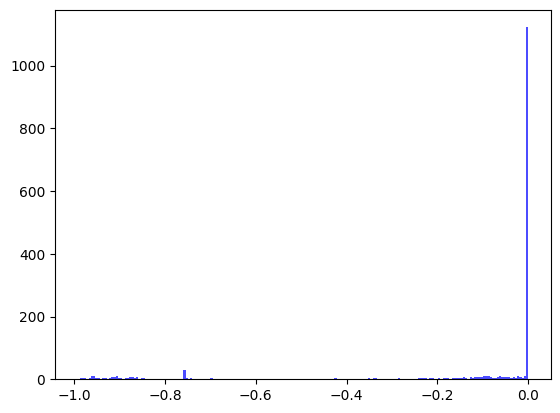

[2023-10-02T01:40:17.981401+00:00] Epochs 78, total loss: 4.07003e+03
[2023-10-02T01:40:17.982590+00:00] Training llk: -1.39195e+00
[2023-10-02T01:40:17.983152+00:00] Testing llk: -1.97173e+00
[2023-10-02T01:40:17.983647+00:00] MAE:0.05951, MRE:0.25429
saving model


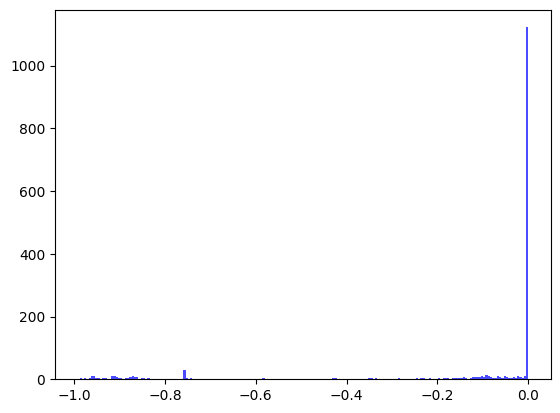

[2023-10-02T01:40:19.383239+00:00] Epochs 79, total loss: 4.05843e+03
[2023-10-02T01:40:19.383435+00:00] Training llk: -1.38891e+00
[2023-10-02T01:40:19.383525+00:00] Testing llk: -1.96742e+00
[2023-10-02T01:40:19.383594+00:00] MAE:0.05911, MRE:0.25194
saving model


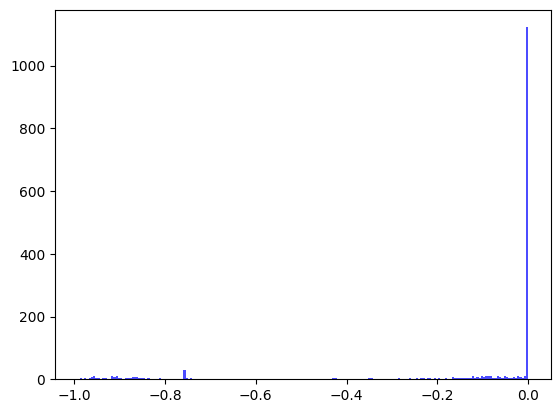

[2023-10-02T01:40:20.209457+00:00] Epochs 80, total loss: 4.04705e+03
[2023-10-02T01:40:20.209725+00:00] Training llk: -1.38594e+00
[2023-10-02T01:40:20.209816+00:00] Testing llk: -1.96320e+00
[2023-10-02T01:40:20.209899+00:00] MAE:0.05873, MRE:0.24963
saving model


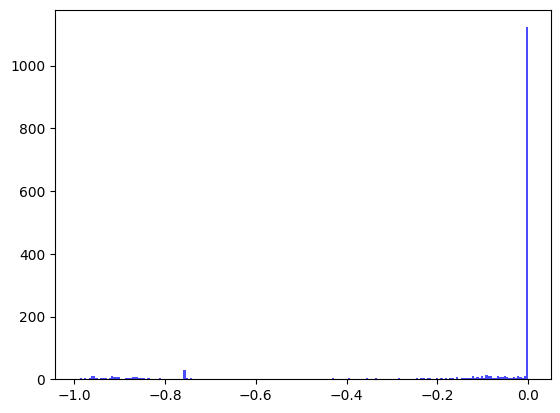

[2023-10-02T01:40:21.058376+00:00] Epochs 81, total loss: 4.03588e+03
[2023-10-02T01:40:21.058654+00:00] Training llk: -1.38303e+00
[2023-10-02T01:40:21.058752+00:00] Testing llk: -1.95907e+00
[2023-10-02T01:40:21.058837+00:00] MAE:0.05835, MRE:0.24735
saving model


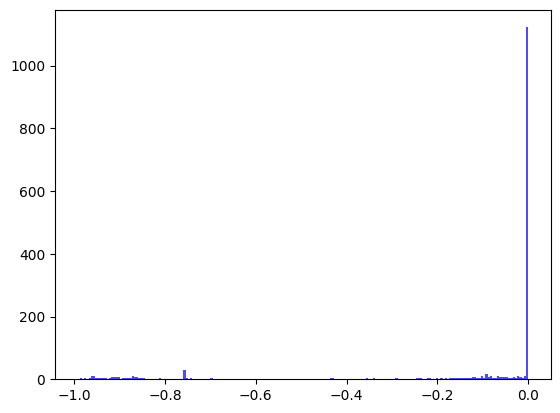

[2023-10-02T01:40:21.887975+00:00] Epochs 82, total loss: 4.02491e+03
[2023-10-02T01:40:21.891526+00:00] Training llk: -1.38018e+00
[2023-10-02T01:40:21.892514+00:00] Testing llk: -1.95503e+00
[2023-10-02T01:40:21.893210+00:00] MAE:0.05798, MRE:0.24511
saving model


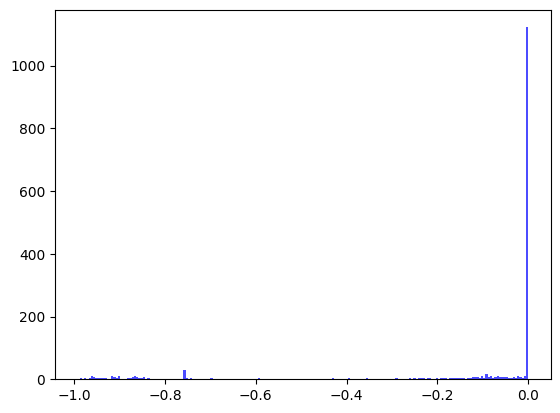

[2023-10-02T01:40:22.731730+00:00] Epochs 83, total loss: 4.01415e+03
[2023-10-02T01:40:22.731990+00:00] Training llk: -1.37739e+00
[2023-10-02T01:40:22.732093+00:00] Testing llk: -1.95107e+00
[2023-10-02T01:40:22.732186+00:00] MAE:0.05762, MRE:0.24290
saving model


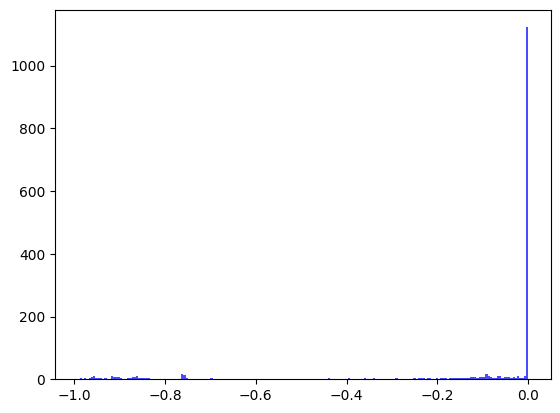

[2023-10-02T01:40:23.812870+00:00] Epochs 84, total loss: 4.00359e+03
[2023-10-02T01:40:23.813149+00:00] Training llk: -1.37466e+00
[2023-10-02T01:40:23.813252+00:00] Testing llk: -1.94720e+00
[2023-10-02T01:40:23.813332+00:00] MAE:0.05726, MRE:0.24072
saving model


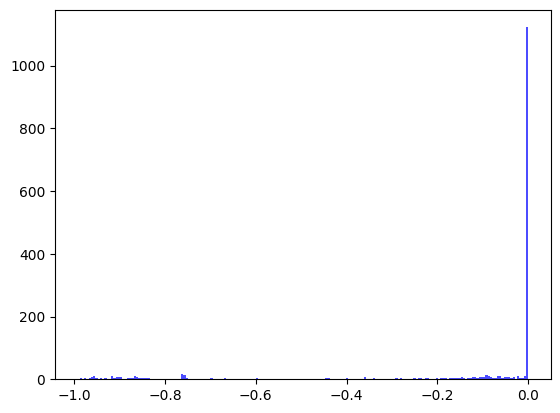

[2023-10-02T01:40:24.678795+00:00] Epochs 85, total loss: 3.99323e+03
[2023-10-02T01:40:24.678996+00:00] Training llk: -1.37200e+00
[2023-10-02T01:40:24.679102+00:00] Testing llk: -1.94342e+00
[2023-10-02T01:40:24.679190+00:00] MAE:0.05691, MRE:0.23858
saving model


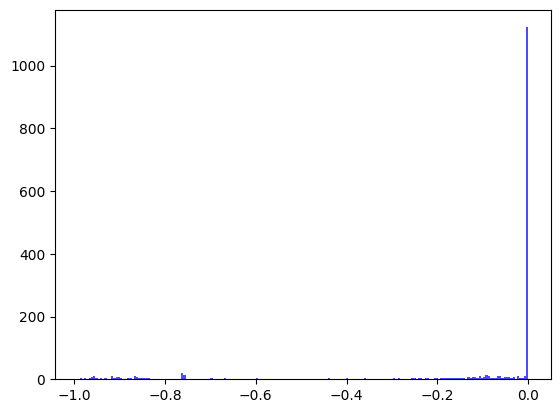

[2023-10-02T01:40:25.532447+00:00] Epochs 86, total loss: 3.98306e+03
[2023-10-02T01:40:25.532656+00:00] Training llk: -1.36939e+00
[2023-10-02T01:40:25.532741+00:00] Testing llk: -1.93972e+00
[2023-10-02T01:40:25.532815+00:00] MAE:0.05657, MRE:0.23646
saving model


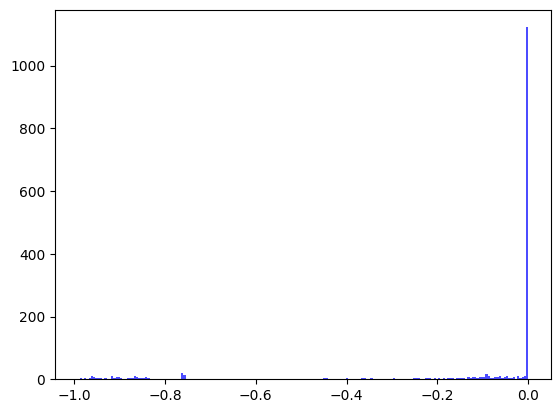

[2023-10-02T01:40:26.351877+00:00] Epochs 87, total loss: 3.97308e+03
[2023-10-02T01:40:26.353020+00:00] Training llk: -1.36683e+00
[2023-10-02T01:40:26.353638+00:00] Testing llk: -1.93611e+00
[2023-10-02T01:40:26.354300+00:00] MAE:0.05624, MRE:0.23439
saving model


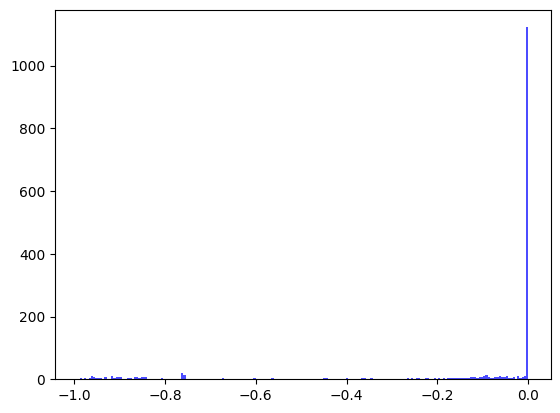

[2023-10-02T01:40:27.197166+00:00] Epochs 88, total loss: 3.96330e+03
[2023-10-02T01:40:27.197402+00:00] Training llk: -1.36434e+00
[2023-10-02T01:40:27.197489+00:00] Testing llk: -1.93257e+00
[2023-10-02T01:40:27.197552+00:00] MAE:0.05592, MRE:0.23235
saving model


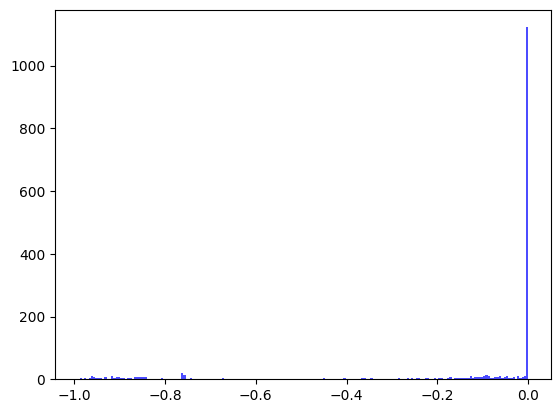

[2023-10-02T01:40:28.006177+00:00] Epochs 89, total loss: 3.95370e+03
[2023-10-02T01:40:28.006446+00:00] Training llk: -1.36190e+00
[2023-10-02T01:40:28.006555+00:00] Testing llk: -1.92911e+00
[2023-10-02T01:40:28.006642+00:00] MAE:0.05562, MRE:0.23036
saving model


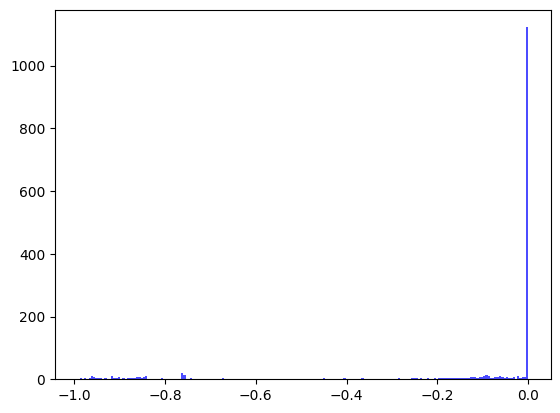

[2023-10-02T01:40:29.262285+00:00] Epochs 90, total loss: 3.94429e+03
[2023-10-02T01:40:29.263404+00:00] Training llk: -1.35951e+00
[2023-10-02T01:40:29.263920+00:00] Testing llk: -1.92574e+00
[2023-10-02T01:40:29.264432+00:00] MAE:0.05533, MRE:0.22840
saving model


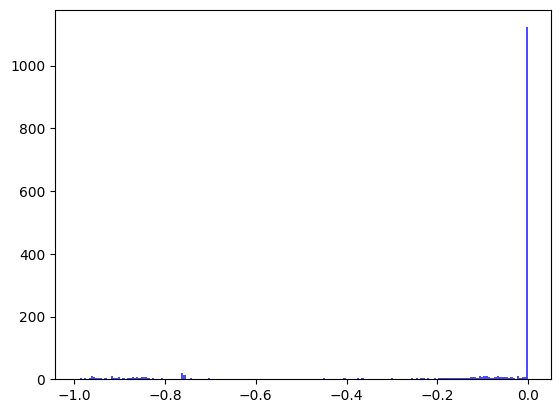

[2023-10-02T01:40:30.505316+00:00] Epochs 91, total loss: 3.93506e+03
[2023-10-02T01:40:30.506416+00:00] Training llk: -1.35717e+00
[2023-10-02T01:40:30.506948+00:00] Testing llk: -1.92243e+00
[2023-10-02T01:40:30.507474+00:00] MAE:0.05505, MRE:0.22648
saving model


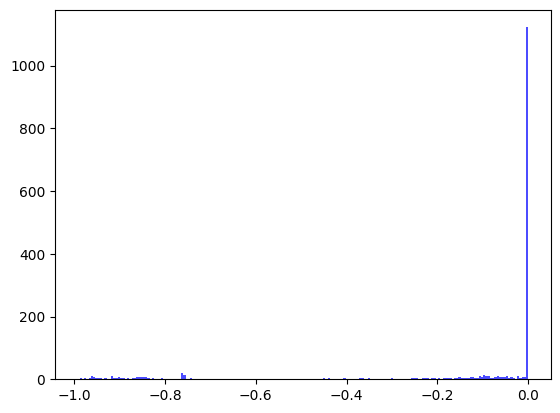

[2023-10-02T01:40:31.709569+00:00] Epochs 92, total loss: 3.92600e+03
[2023-10-02T01:40:31.709791+00:00] Training llk: -1.35489e+00
[2023-10-02T01:40:31.709874+00:00] Testing llk: -1.91920e+00
[2023-10-02T01:40:31.709944+00:00] MAE:0.05477, MRE:0.22459
saving model


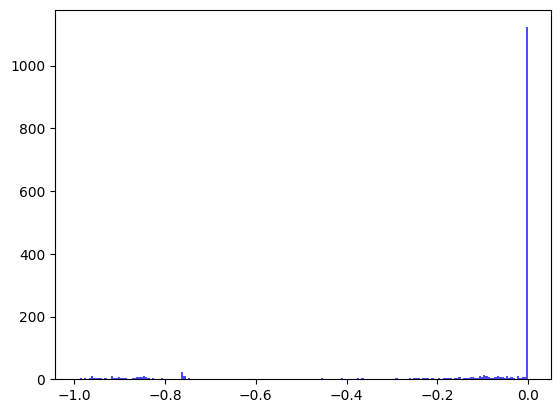

[2023-10-02T01:40:32.528483+00:00] Epochs 93, total loss: 3.91713e+03
[2023-10-02T01:40:32.528729+00:00] Training llk: -1.35266e+00
[2023-10-02T01:40:32.528831+00:00] Testing llk: -1.91605e+00
[2023-10-02T01:40:32.528902+00:00] MAE:0.05451, MRE:0.22273
saving model


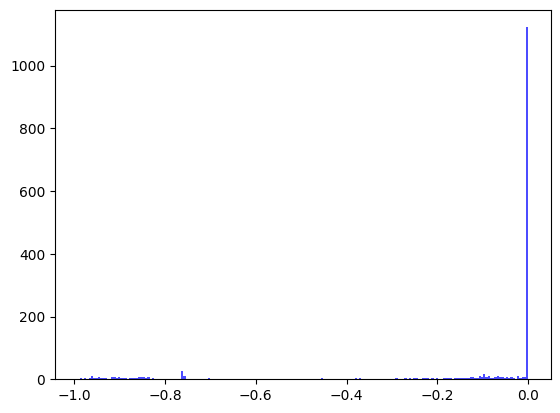

[2023-10-02T01:40:33.359962+00:00] Epochs 94, total loss: 3.90842e+03
[2023-10-02T01:40:33.360208+00:00] Training llk: -1.35048e+00
[2023-10-02T01:40:33.360328+00:00] Testing llk: -1.91296e+00
[2023-10-02T01:40:33.360407+00:00] MAE:0.05426, MRE:0.22092
saving model


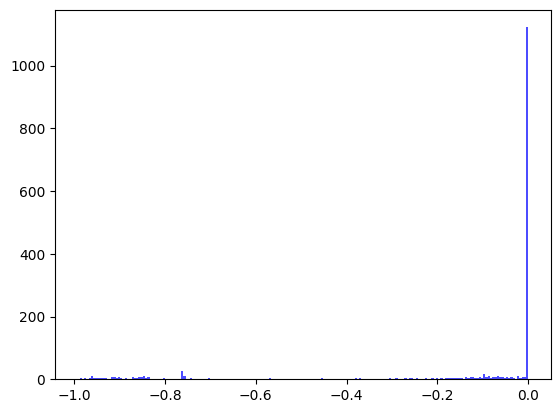

[2023-10-02T01:40:34.166010+00:00] Epochs 95, total loss: 3.89988e+03
[2023-10-02T01:40:34.166313+00:00] Training llk: -1.34835e+00
[2023-10-02T01:40:34.166411+00:00] Testing llk: -1.90995e+00
[2023-10-02T01:40:34.166502+00:00] MAE:0.05402, MRE:0.21914
saving model


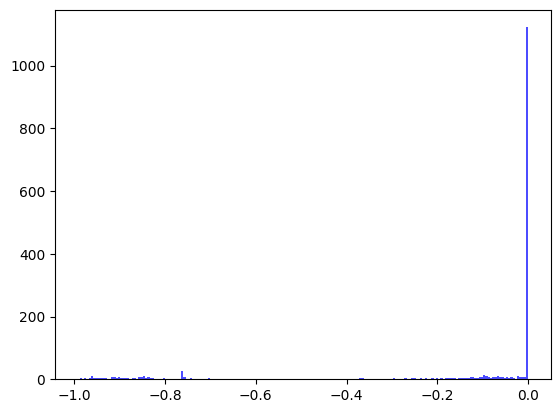

[2023-10-02T01:40:34.974430+00:00] Epochs 96, total loss: 3.89151e+03
[2023-10-02T01:40:34.975524+00:00] Training llk: -1.34627e+00
[2023-10-02T01:40:34.976056+00:00] Testing llk: -1.90701e+00
[2023-10-02T01:40:34.976563+00:00] MAE:0.05379, MRE:0.21739
saving model


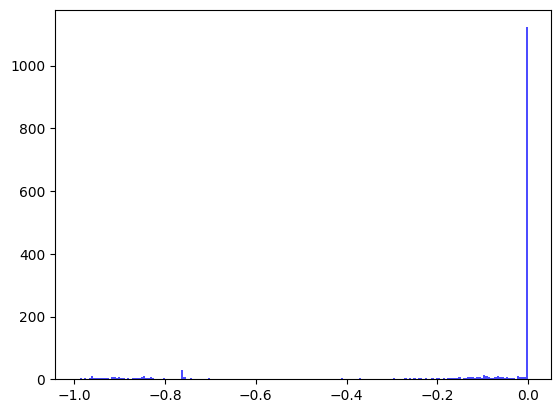

[2023-10-02T01:40:36.405248+00:00] Epochs 97, total loss: 3.88330e+03
[2023-10-02T01:40:36.406366+00:00] Training llk: -1.34423e+00
[2023-10-02T01:40:36.406882+00:00] Testing llk: -1.90413e+00
[2023-10-02T01:40:36.407391+00:00] MAE:0.05356, MRE:0.21567
saving model


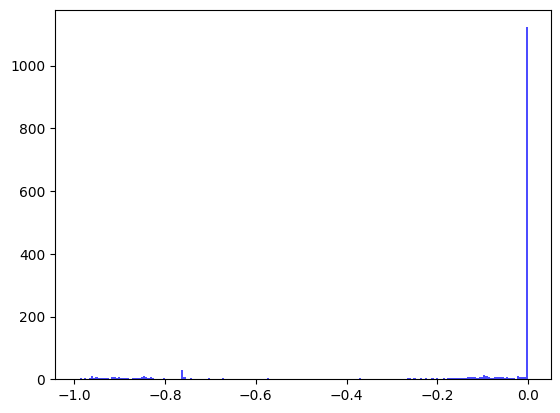

[2023-10-02T01:40:37.678533+00:00] Epochs 98, total loss: 3.87526e+03
[2023-10-02T01:40:37.680820+00:00] Training llk: -1.34224e+00
[2023-10-02T01:40:37.681393+00:00] Testing llk: -1.90131e+00
[2023-10-02T01:40:37.681888+00:00] MAE:0.05334, MRE:0.21397
saving model


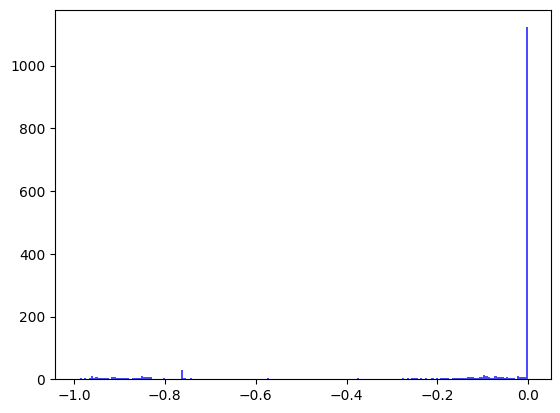

[2023-10-02T01:40:38.654058+00:00] Epochs 99, total loss: 3.86736e+03
[2023-10-02T01:40:38.654275+00:00] Training llk: -1.34030e+00
[2023-10-02T01:40:38.654364+00:00] Testing llk: -1.89857e+00
[2023-10-02T01:40:38.654424+00:00] MAE:0.05312, MRE:0.21231
saving model
training done!


In [ ]:
# For third data set
true_mu = 0.1
true_alpha = 1.0
true_beta = 5.0
raw_train_data = np.load('sample_data/training_3_0911.npy')
raw_test_data = np.load('sample_data/testing_3_0911.npy')


buffer_start_time = 35
buffer_end_time = 50
end_time = raw_test_data.max()

buffer_train_time = [buffer_start_time, buffer_end_time]
buffer_test_time = [buffer_start_time, buffer_end_time]
test_time = [buffer_end_time, end_time]

btrain_lens = ((raw_train_data <= buffer_train_time[1]) * (raw_train_data > buffer_train_time[0])).sum(1)
btest_lens = ((raw_test_data <= buffer_test_time[1]) * (raw_test_data > buffer_train_time[0])).sum(1)
test_lens = ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum(1)

buffer_train_data = np.zeros((raw_train_data.shape[0], btrain_lens.max()))
buffer_test_data = np.zeros((raw_test_data.shape[0], btest_lens.max()))
test_data = np.zeros((raw_test_data.shape[0], test_lens.max()))

for i in range(raw_train_data.shape[0]):
    seq = raw_train_data[i]
    buffer_train_data[i, :btrain_lens[i]] = seq[(seq <= buffer_train_time[1]) * (seq > buffer_train_time[0])]

for i in range(raw_test_data.shape[0]):
    seq = raw_test_data[i]
    test_data[i, :test_lens[i]] = seq[(seq <= test_time[1]) * (seq > test_time[0])]
    buffer_test_data[i, :btest_lens[i]] = seq[(seq <= buffer_test_time[1]) * (seq > buffer_train_time[0])]

buffer_train_data = np.concatenate((np.ones_like(buffer_train_data[:, :1]) * buffer_train_time[0], buffer_train_data), axis=-1)
buffer_test_data = np.concatenate((np.ones_like(buffer_test_data[:, :1]) * buffer_test_time[0], buffer_test_data), axis=-1)

test_data_ = generate_event_mark(test_data)
buffer_train_data_ = generate_event_mark(buffer_train_data)
buffer_test_data_ = generate_event_mark(buffer_test_data)


print(test_data_.shape, buffer_train_data_.shape, buffer_test_data_.shape)
ngrid = 100

ts = np.linspace(test_time[0], test_time[1], ngrid)
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

event_loglams = 0
for i in range(raw_test_data.shape[0]):
    ts = raw_test_data[i, :][(raw_test_data[i, :] <= test_time[1]) * (raw_test_data[i, :] > test_time[0])]
    if len(ts) == 0: continue
    lams = Exponential_Hawkes(ts, raw_test_data[[i], :], mu=true_mu, alpha=true_alpha, beta=true_beta)
    event_loglams += np.log(lams).sum()

(event_loglams - true_lams.sum() * (test_time[1] - test_time[0]) / ngrid) / ((raw_test_data <= test_time[1]) * (raw_test_data > test_time[0])).sum()

for Tm in [100.]:

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("You are using GPU acceleration.")
        print("Number of CUDAs(cores): ", torch.cuda.device_count())
    else:
        device = torch.device("cpu")
        print("CUDA is not Available. You are using CPU only.")
        print("Number of cores: ", os.cpu_count())

    # device="cpu"

    print(Tm)
    T = [buffer_end_time, Tm]
    tau_max = 10.
    baserate = true_mu
    nsample = 10
    n_class = 1
    int_res = 200
    hid_dim = 1
    batch_size = 16
    train_size = 1000
    lr = 0.01
    epoch = 100
    config = config_generate(T0=str(T[0]),
                            T1=str(T[1]),
                            tau_max=str(tau_max),
                            nsample=str(nsample),
                            int_res=str(int_res),
                            n_class=str(n_class),
                            lr=str(lr),
                            epoch=str(epoch),
                            hid_dim=str(hid_dim),
                            batch_size=str(batch_size))
    config.own_event_embed = False
    config.bptt = 10
    config.alpha = true_alpha

    train_lens = ((raw_train_data <= Tm) * (raw_train_data > T[0])).sum(1)
    train_data = np.zeros((raw_train_data.shape[0], train_lens.max()))
    for i in range(train_data.shape[0]):
        seq = raw_train_data[i]
        train_data[i, :train_lens[i]] = seq[(seq <= Tm) * (seq > T[0])]

    train_data_ = generate_event_mark(train_data)

    # modelname = "1d-synthetic-exponential%.2f_hid_dim%d_T[%d, %d]_#train%d_#test%d" % (baserate,
    #                                                                                         hid_dim,
    #                                                                                         T[0],
    #                                                                                         T[1],
    #                                                                                         train_size,
    #                                                                                         test_data.shape[0])
    # save_path = os.path.join(os.getcwd(), 'Neural_Hawkes', 'saved_models', modelname)

    # if os.path.exists(save_path):
    #     # raise(ValueError("Duplicated folder!"))
    #     pass
    # else:
    #     os.makedirs(save_path)

    # seeds = [300, 816, 2999]
    # seeds = [1000, 2000, 3000]
    seeds = [0]

    for seed in seeds:
        # torch.random.manual_seed(seed)
        random.seed(seed)

        train_idx = np.arange(train_data_.shape[0])
        # random.shuffle(train_idx)
        train_data2 = train_data_[train_idx[:train_size]]
        buffer_train_data2 = buffer_train_data_[train_idx[:train_size]]

        nh_model = NH(config, device)
        num_paras = count_parameters(nh_model)
        print("#parameters: %d" % num_paras)

        for name, parameter in nh_model.named_parameters():
            if name == "baserate_mu":
                # parameter.data.fill_(random.uniform(0.4, 0.5))
                parameter.data.fill_(baserate)
            else:
                parameter.data.fill_(random.gauss(0, 0.01))

        ts = np.linspace(test_time[0], test_time[1], ngrid)
        true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

        # model = torch.load(save_path + "/model-%d.pt" % 816)

        nh_model, train_llks, test_llks, test_maes, test_mres, wall_time = model_train(train_data2,
                                                                                       test_data_,
                                                                                       buffer_train_data2,
                                                                                       buffer_test_data_,
                                                                                       nh_model,
                                                                                       config,
                                                                                       device,
                                                                                       True, ts, true_lams)


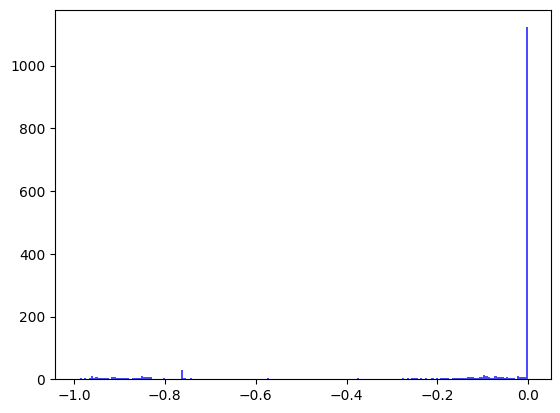

Text(0.5, 1.0, 'Conditional Intensity')

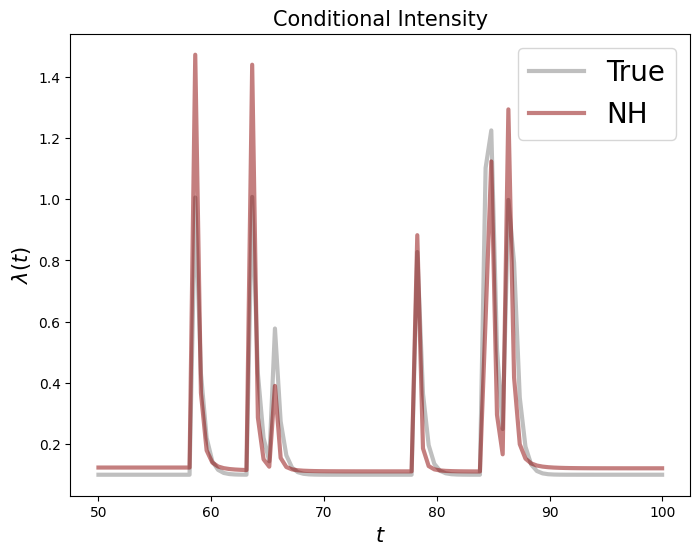

In [ ]:
test_time[1]
ts = np.linspace(test_time[0], test_time[1], ngrid)

nh_lams = nh_model.sample_intensity(ts,
                              torch.tensor(test_data_, dtype=torch.float32),
                              torch.tensor(buffer_test_data_, dtype=torch.float32),
                              device="cpu")
true_lams = Exponential_Hawkes(ts, raw_test_data, mu=true_mu, alpha=true_alpha, beta=true_beta)

# print(np.mean(np.abs(lams - true_lams)))
# print(np.mean(np.abs(lams - true_lams) / true_lams))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)

plot_idx = 0
ax.plot(ts, true_lams[plot_idx], color="gray", alpha=0.5, linewidth=3, label="True")
ax.plot(ts, nh_lams[plot_idx], color="darkred", alpha=0.5, linewidth=3, label="NH")
# ax.set_ylim(0, 10)
ax.legend(fontsize=20)
ax.set_xlabel(r"$t$", fontsize=15)
ax.set_ylabel(r"$\lambda(t)$", fontsize=15)
ax.set_title("Conditional Intensity", fontsize = 15)
# ax.set_xlim(150, 170)